Hello! Thank you for checking out our tool.

The purpose of this demo is demonstrate some of the basics. In doing so, we will generate a flipset for one individual. In doing so, we'll show:

1. How to use the ActionSet interface to specify immutable variables and variables with custom ranges.
2. How to use a model to align an ActionSet
3. How to use the RecourseBuilder interface to find the feasibility of one person.

We'll work using CPLEX. The problem is equivalent for CBC. To install either package, read [here](https://github.com/ustunb/actionable-recourse/blob/master/README.md).

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import sklearn
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from recourse.builder import RecourseBuilder
from recourse.builder import ActionSet
from recourse.flipset import Flipset
import traceback
import seaborn as sns

data_dir = "../data/2_1_experiment_1/"
pd.set_option('display.max_columns', None)


In [2]:
from sklearn.preprocessing import LabelEncoder

def ohe(data, categorical_names, encoder, columns = [], target_columns = []):
    if isinstance(data, pd.DataFrame):
        df_data = data.copy()
    else:
        if len(columns) == 0:
            raise ValueError('Need to supply columns to make a pandas dataframe')
        df_data = pd.DataFrame(data, columns = columns)        
    transformed = encoder.transform(df_data[categorical_names])
    df_transformed = (pd.DataFrame(transformed, columns = encoder.get_feature_names(input_features = categorical_names)))
    to_return = pd.concat([df_data.reset_index(drop = True), df_transformed], axis=1).drop(categorical_names, axis=1)
    if len(target_columns) != 0:
        to_return = to_return[target_columns]
    return to_return, to_return.columns

def un_ohe(ohe_data, categorical_names, encoder, columns):
    ohe_categorical_columns = encoder.get_feature_names(input_features = categorical_names)
    if len(columns) == 0:
            raise ValueError('Need to supply columns to make a pandas dataframe')
    if isinstance(ohe_data, pd.DataFrame):
        df_ohe_data = ohe_data.copy()
    else:
        df_ohe_data = pd.DataFrame(ohe_data, columns = columns)        
    untransformed = encoder.inverse_transform(df_ohe_data[ohe_categorical_columns])
    untransformed_df = pd.DataFrame(untransformed, columns = categorical_names)
    to_return = pd.concat([df_ohe_data.reset_index(drop = True), untransformed_df], axis=1).drop(ohe_categorical_columns, axis=1)
    return to_return[columns]

#NEED TO FINISH
# target_columns: columns of one-hot-encoded
def ohe_coefficients(w, starting_columns, x, enc, categorical_names, target_columns):
    new_coefficients = {}
    categories_mapping = {}
    ohe_columns = ohe([x], categorical_names, enc, columns = starting_columns)[0].columns
    
    for feat_idx, feat in enumerate(categorical_names):
        categories_mapping[feat] = enc.categories_[feat_idx]
    
    for coef, feat, val in zip(w, starting_columns, x):
        if feat in categorical_names:
            feat_ohe_columns = [col for col in target_columns if feat in col]
            all_values = categories_mapping[feat]
            for poss_val in all_values:
                if val == poss_val:
                    new_coefficients[feat + "_" + str(int(val))] = coef
                else:
                    new_coefficients[feat + "_" + str(int(poss_val))] = 0.000001
        else:
            new_coefficients[feat] = coef
        
    sorted_new_coefficients = []
    for col in target_columns:
        sorted_new_coefficients.append(new_coefficients[col])
        
    return sorted_new_coefficients


def get_label_encoders(categorical_names, data):
    return_data = data.copy()
    categorical_encoders = {}

    for cf in categorical_names:
        le = LabelEncoder()
        le.fit(data[cf])
        return_data[cf] = le.transform(return_data[cf])
        categorical_encoders[cf] = le
    
    return categorical_encoders, return_data

# COMPAS dataset

In [3]:
data_name = "compas-scores-two-years"
data_file = os.path.join(data_dir, '%s.csv' % data_name)
## load and process data
compas_df = pd.read_csv(data_file).reset_index(drop=True)

# filter according to https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb and https://github.com/dylan-slack/Fooling-LIME-SHAP/blob/e763fdea8242f4f3a5955951161c69f573db624d/get_data.py#L5
# compas_df = compas_df.loc[(compas_df['days_b_screening_arrest'] <= 30) & \
#                           (compas_df['days_b_screening_arrest'] >= -30) & \
#                           (compas_df['is_recid'] != -1) & \
#                           (compas_df['c_charge_degree'] != "O") & \
#                           (compas_df['score_text'] != "NA")]

# cols_with_missing_values = []
# for col in compas_df.columns:
#     if len(np.where(compas_df[col].values == '?')[0]) >= 1 or compas_df[col].isnull().values.any():
#         cols_with_missing_values.append(col)    
# compas_df = compas_df.drop(cols_with_missing_values, axis=1)

compas_df['length_of_stay'] = (pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])).dt.days

compas_df = compas_df[['age', 'two_year_recid','juv_misd_count', 'juv_fel_count', 'juv_other_count', 'c_charge_degree', 'race', 'sex', 'priors_count', 'length_of_stay', 'score_text']]
compas_df = compas_df.dropna()

compas_X = compas_df.drop('score_text', axis=1)

compas_y = pd.Series(np.array([-1 if score == 'High' else 1 for score in compas_df['score_text']]))
# compas_X = compas_df.drop('score_text', axis=1)

# CATEGORICAL FEATURES
compas_categorical_features = [1, 5, 6, 7]

compas_X = compas_X.reset_index(drop = True)
compas_X.columns = compas_X.columns.str.replace("_", "-")
compas_y = compas_y.reset_index(drop = True)

columns = compas_X.columns
compas_categorical_names = [columns[i] for i in compas_categorical_features] 


# ENCODE NUMERICALLY
compas_label_encoders, compas_X = (get_label_encoders(compas_categorical_names, compas_X))

# CREATE ENCODER
from sklearn.preprocessing import OneHotEncoder
compas_enc = OneHotEncoder(sparse = False, handle_unknown='error')
compas_enc.fit(compas_X[compas_categorical_names])
print(compas_enc.categories_)

# display(compas_X)
ohe_compas_X, _ = ohe(compas_X, compas_categorical_names, compas_enc)
# display(ohe_compas_X)
# display(un_ohe(ohe_compas_X, compas_categorical_names, compas_enc, columns = compas_X.columns))
display(ohe_compas_X)

[array([0, 1]), array([0, 1]), array([0, 1, 2, 3, 4, 5]), array([0, 1])]


age  juv-misd-count  juv-fel-count  juv-other-count  priors-count  \
0      69               0              0                0             0   
1      34               0              0                0             0   
2      24               0              0                1             4   
3      44               0              0                0             0   
4      41               0              0                0            14   
...   ...             ...            ...              ...           ...   
6902   23               0              0                0             0   
6903   23               0              0                0             0   
6904   57               0              0                0             0   
6905   33               0              0                0             3   
6906   23               0              0                0             2   

      length-of-stay  two-year-recid_0  two-year-recid_1  c-charge-degree_0  \
0                0.0               1.0               0.0                1.0   
1               10.0               0.0               1.0                1.0   
2                1.0               0.0               1.0                1.0   
3                1.0               1.0               0.0                0.0   
4                6.0               0.0               1.0                1.0   
...              ...               ...               ...                ...   
6902             1.0               1.0               0.0                1.0   
6903             1.0               1.0               0.0                1.0   
6904             1.0               1.0               0.0                1.0   
6905             1.0               1.0               0.0                0.0   
6906             1.0               0.0               1.0                1.0   

      c-charge-degree_1  race_0  race_1  race_2  race_3  race_4  race_5  \
0                   0.0     0.0     0.0     0.0     0.0     0.0     1.0   
1                   0.0     1.0     0.0     0.0     0.0     0.0     0.0   
2                   0.0     1.0     0.0     0.0     0.0     0.0     0.0   
3                   1.0     0.0     0.0     0.0     0.0     0.0     1.0   
4                   0.0     0.0     0.0     1.0     0.0     0.0     0.0   
...                 ...     ...     ...     ...     ...     ...     ...   
6902                0.0     1.0     0.0     0.0     0.0     0.0     0.0   
6903                0.0     1.0     0.0     0.0     0.0     0.0     0.0   
6904                0.0     0.0     0.0     0.0     0.0     0.0     1.0   
6905                1.0     1.0     0.0     0.0     0.0     0.0     0.0   
6906                0.0     0.0     0.0     0.0     1.0     0.0     0.0   

      sex_0  sex_1  
0       0.0    1.0  
1       0.0    1.0  
2       0.0    1.0  
3       0.0    1.0  
4       0.0    1.0  
...     ...    ...  
6902    0.0    1.0  
6903    0.0    1.0  
6904    0.0    1.0  
6905    1.0    0.0  
6906    1.0    0.0  

[6907 rows x 18 columns]

# German Credit dataset

In [4]:
data_name = 'german_processed'
data_file = os.path.join(data_dir, '%s.csv' % data_name)
## load and process data
german_df = pd.read_csv(data_file).reset_index(drop=True)

german_df = (german_df
             .assign(isMale=lambda df: (df['Gender']=='Male').astype(int))
             .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore', 'HasTelephone'], axis=1)
            )

german_y = german_df['GoodCustomer']
german_X = german_df.drop('GoodCustomer', axis=1)

# def label_CheckingAccountBalance(row):
#     if row['CheckingAccountBalance_geq_0'] == 1 :
#         return "geq0"
#     elif row['CheckingAccountBalance_geq_200'] == 1:
#         return "geq200"
    
# def label_SavingsAccountBalance(row):
#     if row['SavingsAccountBalance_geq_100'] == 1 :
#         return "geq100"
#     elif row['SavingsAccountBalance_geq_500'] == 1:
#         return "geq500"
    
# def label_YearsAtCurrentJob(row):
#     if row['YearsAtCurrentJob_lt_1'] == 1 :
#         return "lt1"
#     elif row['YearsAtCurrentJob_geq_4'] == 1:
#         return "geqr"


# german_X['CheckingAccountBalance'] = german_X.apply (lambda row: label_CheckingAccountBalance(row), axis=1)
# german_X['SavingsAccountBalance'] = german_X.apply (lambda row: label_SavingsAccountBalance(row), axis=1)
# german_X['YearsAtCurrentJob'] = german_X.apply (lambda row: label_YearsAtCurrentJob(row), axis=1)

german_X = (german_X
             .drop(['CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200', \
                    'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500', \
                   'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'RentsHouse'], axis=1)
            )

display(german_X)

# CATEGORICAL FEATURES
german_categorical_features = [0, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

german_X.columns = german_X.columns.str.replace("_", "-")

columns = german_X.columns
german_categorical_names = [columns[i] for i in german_categorical_features] 


# ENCODE NUMERICALLYnu
german_label_encoders, german_X = (get_label_encoders(german_categorical_names, german_X))

# CREATE ENCODER
from sklearn.preprocessing import OneHotEncoder
german_enc = OneHotEncoder(sparse = False, handle_unknown='error')
german_enc.fit(german_X[german_categorical_names])
print(german_enc.categories_)

ohe_german_X, _ = ohe(german_X, german_categorical_names, german_enc)
# display(ohe_german_X)

display(german_y)
display(german_categorical_features)

ForeignWorker  Single  Age  LoanDuration  LoanAmount  \
0                0       1   67             6        1169   
1                0       0   22            48        5951   
2                0       1   49            12        2096   
3                0       1   45            42        7882   
4                0       1   53            24        4870   
..             ...     ...  ...           ...         ...   
995              0       0   31            12        1736   
996              0       0   40            30        3857   
997              0       1   38            12         804   
998              0       1   23            45        1845   
999              0       1   27            45        4576   

     LoanRateAsPercentOfIncome  YearsAtCurrentHome  NumberOfOtherLoansAtBank  \
0                            4                   4                         2   
1                            2                   2                         1   
2                            2                   3                         1   
3                            2                   4                         1   
4                            3                   4                         2   
..                         ...                 ...                       ...   
995                          3                   4                         1   
996                          4                   4                         1   
997                          4                   4                         1   
998                          4                   4                         1   
999                          3                   4                         1   

     NumberOfLiableIndividuals  MissedPayments  NoCurrentLoan  \
0                            1               1              0   
1                            1               1              0   
2                            2               1              0   
3                            2               1              0   
4                            2               0              0   
..                         ...             ...            ...   
995                          1               1              0   
996                          1               1              0   
997                          1               1              0   
998                          1               1              0   
999                          1               1              0   

     CriticalAccountOrLoansElsewhere  OtherLoansAtBank  HasCoapplicant  \
0                                  1                 0               0   
1                                  0                 0               0   
2                                  1                 0               0   
3                                  0                 0               0   
4                                  0                 0               0   
..                               ...               ...             ...   
995                                0                 0               0   
996                                0                 0               0   
997                                0                 0               0   
998                                0                 0               0   
999                                1                 0               0   

     HasGuarantor  OwnsHouse  Unemployed  JobClassIsSkilled  isMale  
0               0          1           0                  1       1  
1               0          1           0                  1       0  
2               0          1           0                  0       1  
3               1          0           0                  1       1  
4               0          0           0                  1       1  
..            ...        ...         ...                ...     ...  
995             0          1           0                  0       0  
996             0          1           0                  1       1  
997        

[array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1]), array([0, 1])]


0      1
1     -1
2      1
3      1
4     -1
      ..
995    1
996    1
997    1
998   -1
999    1
Name: GoodCustomer, Length: 1000, dtype: int64

[0, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

# Adult dataset

In [5]:
data_name = "adult"
data_file = os.path.join(data_dir, '%s.csv' % data_name)
## load and process data
adult_df = pd.read_csv(data_file).reset_index(drop=True)
adult_df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex',\
                                          'capital-gain','capital-loss','hours-per-week','native-country','label']

cols_with_missing_values = []
for col in adult_df.columns:
    if len(np.where(adult_df[col].values == '?')[0]) >= 1 or adult_df[col].isnull().values.any():
        cols_with_missing_values.append(col)    

adult_df = adult_df.drop(cols_with_missing_values, axis=1)

adult_df['Married'] = adult_df.apply(lambda row: 1 if 'Married' in row['marital-status'] else 0, axis=1)
adult_df['Widowed'] = adult_df.apply(lambda row: 1 if 'Widowed' in row['marital-status'] else 0, axis=1)
adult_df['NeverMarried'] = adult_df.apply(lambda row: 1 if 'Never-married' in row['marital-status'] else 0, axis=1)

adult_df['workclass_gov'] = adult_df.apply(lambda row: 1 if 'gov' in row['workclass'] else 0, axis=1)
adult_df['workclass_private'] = adult_df.apply(lambda row: 1 if 'Private' in row['workclass'] else 0, axis=1)
adult_df['workclass_self-emp'] = adult_df.apply(lambda row: 1 if 'Self-emp' in row['workclass'] else 0, axis=1)
# adult_df['workclass_never-worked'] = adult_df.apply(lambda row: 1 if 'Never-worked' in row['workclass'] else 0, axis=1)

adult_df['White'] = adult_df.apply(lambda row: 1 if 'White' in row['race'] else 0, axis=1)

# adult_df = pd.get_dummies(adult_df, columns=['race'])
adult_df = pd.get_dummies(adult_df, columns=['sex'])

adult_df = adult_df.drop(['education', 'occupation', 'native-country', \
                          'relationship'], axis=1)
adult_df = adult_df.drop(['sex_ Female', 'race'], axis=1)
adult_df = adult_df.drop(['marital-status', 'workclass', 'fnlwgt'], axis=1)

adult_df.columns = adult_df.columns.str.replace(' ', '')

adult_X = adult_df.drop('label', axis=1)
adult_y = adult_df['label'].replace(' <=50K', -1)
adult_y = adult_y.replace(' >50K', 1)

for col in adult_X.columns:
    print(col)
    print(adult_X[col].value_counts())

adult_categorical_features = [5, 6, 7, 8, 9, 10, 11, 12]
columns = adult_X.columns
print(columns)
adult_categorical_names = [columns[i] for i in adult_categorical_features] 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64
education-num
9     10501
10     7291
13     5354
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education-num, dtype: int64
capital-gain
0        29849
15024      347
7688       284
7298       246
99999      159
         ...  
4931         1
1455         1
6097         1
22040        1
1111         1
Name: capital-gain, Length: 119, dtype: int64
capital-loss
0       31041
1902      202
1977      168
1887      159
1848       51
        ...  
1411        1
1539        1
2472        1
1944        1
2201        1
Name: capital-loss, Length: 92, dtype: int64
hours-per-week
40    15216
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours-per-week, Lengt

Make the data not ohe.

In [6]:
#need the data for recourse and lime to be NOT one-hot-encoded and to be numerical
#need the data for the classifier to be one hot encoded

# german_df['YearsAtCurrentJob_lt_1'] = german_df['YearsAtCurrentJob_lt_1'].replace(1, 'lt_1')
# german_df['YearsAtCurrentJob'] = german_df['YearsAtCurrentJob_lt_1']
# german_df['YearsAtCurrentJob_geq_4'] = german_df['YearsAtCurrentJob_geq_4'].replace(1, 'geq_4')
# german_df['YearsAtCurrentJob'] = german_df.apply(lambda row: 'geq_4' if row['YearsAtCurrentJob_geq_4'] == 'geq_4' else row['YearsAtCurrentJob'], axis=1)
# german_df['YearsAtCurrentJob'] = german_df['YearsAtCurrentJob_lt_1'].replace(0, 'bet_1_4')
# german_df = german_df.drop(['YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4'], axis=1)

# german_df['CheckingAccountBalance_geq_0'] = german_df['CheckingAccountBalance_geq_0'].replace(1, 'geq_0')
# german_df['CheckingAccountBalance_geq_200'] = german_df['CheckingAccountBalance_geq_200'].replace(1, 'geq_200')
# german_df['CheckingAccountBalance'] = german_df['CheckingAccountBalance_geq_0']
# german_df['CheckingAccountBalance'] = german_df.apply(lambda row: 'geq_200' if row['CheckingAccountBalance_geq_200'] == 'geq_200' else row['CheckingAccountBalance'], axis=1)
# german_df['CheckingAccountBalance'] = german_df['CheckingAccountBalance'].replace('geq_0', '0_200')
# german_df = german_df.drop(['CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200'], axis=1)

# german_df['SavingsAccountBalance_geq_100'] = german_df['SavingsAccountBalance_geq_100'].replace(1, '100_500')
# german_df['SavingsAccountBalance_geq_500'] = german_df['SavingsAccountBalance_geq_500'].replace(1, 'geq_500')
# german_df['SavingsAccountBalance'] = german_df['SavingsAccountBalance_geq_100']
# german_df['SavingsAccountBalance'] = german_df.apply(lambda row: 'geq_500' if row['SavingsAccountBalance_geq_500'] == 'geq_500' else row['SavingsAccountBalance'], axis=1)
# german_df['SavingsAccountBalance'] = german_df['SavingsAccountBalance'].replace('0', 'lt_100')
# german_df = german_df.drop(['SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500'], axis=1)
# display(german_df)


In [7]:
pd.set_option('display.max_columns', None)
# display(X)
# display(y)

In [8]:
# msk = np.random.rand(len(X)) < 0.8
# train = X[msk]
# test = X[~msk]

# train_y = y[msk]
# test_y = y[~msk]

Currently, no immutable features.

# Train model

Ok great, now let's get into the meat of it. Let's train up a model as see what recourse exists.

# Generate Recourse

First, let's score everyone using our model. Now, let's say that we will give loans to anyone with a greater than a $80\%$ chance of paying it back

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from IPython.display import HTML
import time

from sklearn.tree import DecisionTreeRegressor
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append("../..")
from mlinsights.mlinsights.mlmodel import PiecewiseRegressor


# start by randomly picking an action for each feature
def sample_with_actions(instance, actions, num_samples, ordered_feature_names):
    num_features = len(ordered_feature_names)
    sampled_data = np.zeros((num_samples, num_features))
    sampled_data[0, :] = instance
    
    len_actions = [len(actions[feat]) for feat in ordered_feature_names]
    ordered_actions = [actions[feat] for feat in ordered_feature_names]
    
#     print("instance: ", instance)
#     print("actions: ", ordered_actions)
#     print("len_actions; ", len_actions)
#     print("ordered_actions: ", ordered_actions)
    
    # max number of actions
    max_actions = len(actions[max(actions, key=lambda feat:len(actions[feat]))])
            
#     print(len_actions)    
        
    for s in range(1, num_samples):
        sampled_actions = [ordered_actions[i][np.random.choice(x)] for i, x in enumerate(len_actions)]
#         print("sampled_actions: ", sampled_actions)
        sampled_data[s, :] = instance + sampled_actions
#         print("sampled_actions: ", sampled_actions)
        
    return sampled_data

def convert_binary_categorical_coefficients(exp_list):
    cleaned_exp_dict = {}
    for (feat, coeff) in exp_list:
        if "=" in feat:
            original_feat, val = feat.split("=")
            int_val = int(val)
            if int_val == 1:
                cleaned_exp_dict[original_feat] = coeff
            else:
                cleaned_exp_dict[original_feat] = -1 * coeff
        else:
            cleaned_exp_dict[feat] = coeff
    return cleaned_exp_dict

# scaled_X = (X - explainer.scaler.mean_) / explainer.scaler.scale_

In [10]:
from functools import partial
from sklearn.model_selection import train_test_split
from pyutilib.common import ApplicationError
from sklearn.preprocessing import KBinsDiscretizer

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append("../..")
    
# import MAPLE.MAPLE
from MAPLE.Code.Misc import load_normalize_data, unpack_coefs
from MAPLE.Code.MAPLE import MAPLE

def get_nonzero_actions(feature_names, action):
    action_dict = {}
    for feat_idx, feat_name in enumerate(feature_names):
        action_for_feat = action[feat_idx]
        if action_for_feat != 0:
            action_dict[feat_name] = action_for_feat
    return action_dict

# # X_train is unnormalized
# def find_testing_interventions(x, model, X_train, binary_categorical_features, num_divisions = 100):
#     interventions = [[]] * len(X_train.columns)
#     original_pred = model
#     for feat_idx, feat in X_train.columns:
#         if feat_idx not in binary_categorical_features:
#             feat_min = X_train[feat].min()
#             feat_max = X_train[feat].max()
#             increment = (feat_max - feat_min) / 100
#         else:
#             x[feat_idx] = 
        
# data is array-like of shape (n_samples, n_features)
def get_pred_function(model, categorical_names, enc, columns, target_columns):
    def new_predict_proba(data):
        transformed_data, _ = ohe(data, categorical_names, enc, columns = columns, target_columns = target_columns)
        return model.predict_proba(transformed_data)
    return new_predict_proba        
    
def get_lime_sampled(lime_explainer, x, new_predict_proba, num_features, num_samples, columns, true_index):
    exp = lime_explainer.explain_instance(x, new_predict_proba, num_features = num_features, num_samples = num_samples)
    return exp.inverse, exp.scaled_data, exp.all_sampled_preds, exp.weights, lime_explainer.scaler.mean_, lime_explainer.scaler.scale_
    
def get_lime_coefficients(lime_explainer, x, new_predict_proba, num_features, num_samples, columns, true_index):
    exp = lime_explainer.explain_instance(x, new_predict_proba, num_features = num_features, num_samples = num_samples)
    inverse_data = (pd.DataFrame(exp.inverse, columns = columns))
#     display(inverse_data)
#     display(pd.DataFrame([x], columns = columns))
#     display(inverse_data['race'].value_counts())
#     display(inverse_data['sex'].value_counts())
    local_pred = exp.local_pred

    coefficients = [None] * num_features

    local_exp = exp.local_exp[true_index]
        
    for (feat, coef) in local_exp:
        coefficients[feat] = coef
    
#     cleaned_exp_dict = convert_binary_categorical_coefficients(exp.as_list())
    
#     for j, col in enumerate(columns):
#         coefficients[j] = cleaned_exp_dict[col]

        
    print("exp.local_exp:", local_exp)
        
    intercept = exp.intercept[true_index]

    x_shift = np.array(lime_explainer.scaler.mean_)
    x_scale = np.array(lime_explainer.scaler.scale_)
    w = coefficients / x_scale
    b = intercept - np.sum(w * x_shift) - 0.5 # subtract 0.5 bc using probs as labels
    
    discrete_yss = (exp.yss[:, true_index] > 0.5).astype(int)
    discrete_sampled_preds = (exp.all_sampled_preds > 0.5).astype(int)
    
    num_pos_yss = (np.count_nonzero(discrete_yss == 1))
    num_neg_yss = (np.count_nonzero(discrete_yss == 0))
    
    num_accurate_preds = np.count_nonzero(discrete_yss == discrete_sampled_preds)
    accuracy_sampled = num_accurate_preds/len(discrete_yss)
    
    return w, b, local_pred, accuracy_sampled

def get_maple_coefficients(maple_explainer, x, mean, std, lime_sampled = [], model_preds_sampled = [], use_distance_weights = True):
    if lime_sampled != []:
        e_maple = maple_explainer.explain(x, lime_sampled = lime_sampled, model_preds_sampled = model_preds_sampled, use_distance_weights = use_distance_weights)
    else:
        e_maple = maple_explainer.explain(x, use_distance_weights = use_distance_weights)
        
    coefs_maple = e_maple["coefs"][1:]
    intercept_maple = e_maple["coefs"][0]
    
    
    w = coefs_maple / std
    b = intercept_maple - np.sum(w * mean) - 0.5 # subtract 0.5 bc using probs as labels
        
    num_pos_yss = (np.count_nonzero(e_maple['selected_sampled_yss'] == 1))
    num_neg_yss = (np.count_nonzero(e_maple['selected_sampled_yss'] == 0))
    
    num_accurate_preds = np.count_nonzero(e_maple['selected_sampled_yss'] == e_maple['selected_sampled_preds'])   
    accuracy_sampled = num_accurate_preds/len(e_maple['selected_sampled_preds'])
    local_pred = e_maple['pred']    
    
#     print(e_maple['weights'])
#     print(len(np.nonzero(e_maple['weights'])[0]))
#     print(e_maple['weights'][np.nonzero(e_maple['weights'])[0]])
    
    return w, b, local_pred, accuracy_sampled

def get_piecewise_coefficients_with_maple(maple_explainer, x, lime_sampled = [], model_preds_sampled = [], use_distance_weights = False):
    e_maple = maple_explainer.explain(x, lime_sampled = lime_sampled, model_preds_sampled = model_preds_sampled, use_distance_weights = use_distance_weights)
    maple_weights = e_maple['weights']
    
    model = PiecewiseRegressor(verbose=False,
                           binner=DecisionTreeRegressor(min_samples_leaf=2500))
    model.fit(lime_sampled, model_preds_sampled, sample_weight=maple_weights)
    
    estimators = model.estimators_
    
    return estimators    

def get_piecewise_coefficients(x, lime_sampled, model_preds_sampled, lime_sampled_weights):
    model = PiecewiseRegressor(verbose=False,
                           binner=DecisionTreeRegressor(min_samples_leaf=2500))
    model.fit(lime_sampled, model_preds_sampled, sample_weight=lime_sampled_weights)
    
#     sampled_preds = model.predict()
    
#     accuracy_sampled = 
    
    estimators = model.estimators_
    
    return estimators

# def get_ohe_coefficients(w):
#     df_w = pd.DataFrame(w, columns = columns)        
#     transformed = encoder.transform(df_data[categorical_names])
#     df_transformed = (pd.DataFrame(transformed, columns = encoder.get_feature_names(input_features = categorical_names)))
#     return pd.concat([df_data.reset_index(drop = True), df_transformed], axis=1).drop(categorical_names, axis=1)

    

def get_recourse(x, action_set, w, b):
    action_set.align(coefficients=w)
    fb = Flipset(x = x, action_set = action_set, coefficients = w, intercept = b)
    
    try:
        print("populating...")
        fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
        actions = fb._builder.actions

        error = False

        returned_actions = [result['actions'] for result in fb.items]

    except (ValueError, ApplicationError, AssertionError) as e:
        print("excepting...")
        print("error: ", e)
        print(traceback.print_exc())
#         print("coeffs from error: ", w)
        error = True

        returned_actions = []
    

    return returned_actions, error

# assumes data is properly formatted
def calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, file_name, \
    num_samples = 5000, kernel_width = None, explanation_type = 'lime', lime_sample_around_instance = None, \
    use_lime_sampled_maple = None, maple_use_distance_weights = None, instances_subset = None, \
    cluster_ratio = None):
    
    instances_with_recourses = []
    
    use_lime_inverse = True
    
    with open(file_name, "a") as f:   
        
        X_train = data['X_train']
        y_train = data['y_train']

        X_val = data['X_val']
        y_val = data['y_val']

        X_test = data['X_test']
        y_test = data['y_test']
        
        ohe_X_train, target_columns = ohe(X_train, categorical_names, enc)
        ohe_X_val, _ = ohe(X_val, categorical_names, enc, target_columns = target_columns)
        ohe_X_test, _ = ohe(X_test, categorical_names, enc, target_columns = target_columns)
        
        print("\n\nTRAIN LABEL SPLIT: ", file=f)
        print(y_train.value_counts(), file=f)

        print("validation score: ", model.score(ohe_X_val, y_val), file=f)

        
        new_predict_proba = get_pred_function(model, categorical_names, enc, X_train.columns, target_columns)
        
        if instances_subset != None:
            calculate_subset_accuracy = True
            subset_total_recourses = 0
            subset_total_actual_recourses = 0
        else:
            instances_subset = []
            calculate_subset_accuracy = False
        
        classes = model.classes_
        true_index = list(classes).index(1)
        
        scores = pd.Series(new_predict_proba(X_test)[:, true_index])
        discrete_scores = pd.Series(model.predict(ohe_X_test))

        total_recourses = 0
        total_actual_recourses = 0
        
        total_instances_with_recourses = 0

        num_actiongrid_regressor_agree = 0
        num_lime_agree = 0
        num_sampled_total = 0
        

        print("NUM SAMPLES: ", num_samples, file=f)
        print("KERNEL WIDTH: ", kernel_width, file=f)
        print("EXPLANATION TYPE: ", explanation_type, file=f)
        if lime_sample_around_instance != None:
            print("LIME SAMPLE AROUND INSTANCES: ", lime_sample_around_instance, file=f)
        if use_lime_sampled_maple != None:
            print("USE SAMPLED LIME FOR MAPLE: ", use_lime_sampled_maple, file=f)
        if maple_use_distance_weights != None:
            print("USE DISTANCE WEIGHTS FOR MAPLE: ", maple_use_distance_weights, file=f)
        if cluster_ratio != None:
            num_clusters = int(X_train.values.shape[0] * cluster_ratio)
            print("NUM CLUSTERS: ", num_clusters, "; fraction of training: ", cluster_ratio, file=f)           
        print("num unique preds: ", np.unique(discrete_scores, axis=0).shape[0])


        print("TEST LABEL SPLIT: ", file=f)

        print(discrete_scores.value_counts())

        # class_names have to be ordered according to what the classifier is using
        lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, categorical_features=categorical_features, 
                                                           categorical_names=categorical_names, \
                                                           feature_names=X_train.columns, class_names=classes, \
                                                           discretize_continuous=False, kernel_width = kernel_width, \
                                                           sample_around_instance = lime_sample_around_instance, feature_selection='none')

        train_stddev = X_train[X_train.columns[:]].std()
        train_mean = X_train[X_train.columns[:]].mean()
        
        for feat in categorical_features:
            train_mean[feat] = 0
            train_stddev[feat] = 1

        # Normalize to have mean 0 and variance 1
        norm_X_train = (X_train - train_mean) / train_stddev
        norm_X_val = (X_val - train_mean) / train_stddev
        norm_X_test = (X_test - train_mean) / train_stddev
        
        display(train_mean)
        display

        pred_train = new_predict_proba(X_train)[:, true_index]
        pred_val = new_predict_proba(X_val)[:, true_index]

        maple_explainer = MAPLE(norm_X_train, pred_train, norm_X_val, pred_val)

#         action_set = ActionSet(X = ohe_X_train)
        action_set = ActionSet(X = ohe_X_train, custom_bounds={'race_1':(0, 1.0), 'race_4':(0, 1.0)})
        display(action_set)

        start_time = time.time()
        num_neg_test_preds = 0

        negative_scores = np.nonzero(scores < 0.5)[0]
        recourses = [None] * len(negative_scores)

        num_neg_test_preds = len(negative_scores)

        columns = X_train.columns
        
        print(len(X_train))
        
        if explanation_type == "baseline":
            baseline_model = Ridge()
            baseline_model.fit(norm_X_train, pred_train)
            coefs = baseline_model.coef_
            intercept = baseline_model.intercept_
            baseline_w = coefs / train_stddev
            baseline_b = intercept - np.sum(baseline_w * train_mean) - 0.5 # subtract 0.5 bc using probs as labels       
                
        if "cluster" in explanation_type:
            cluster_model = PiecewiseRegressor(verbose=False,
                                   binner=DecisionTreeRegressor(max_leaf_nodes = num_clusters))
            if explanation_type == "cluster_train":
                cluster_model.fit(norm_X_train, pred_train)
#             else: NEED SAMPLED POINTS
#                 cluster_model.fit(lime_sampled, model_preds_sampled, sample_weight=lime_sampled_weights)
            cluster_estimators = cluster_model.estimators_
            print(len(cluster_estimators))
            bins = cluster_model.transform_bins(norm_X_train.values)
        
        for idx, i in enumerate(negative_scores): #scores is for X_test specifically
            if idx % 25 == 0:
                print("\n", idx, " out of ", len(negative_scores))
            if idx % 100 == 0:
                print("time elapsed: ", (time.time() - start_time) / 60, " minutes")
                start_time = time.time()
            
            x = X_test.values[i]
            ohe_x = (ohe(x.reshape(1, -1), categorical_names, enc, columns = columns, target_columns = target_columns)[0].values[0])
            print(ohe_x)
            
            num_features = len(x)

            print(explanation_type)
            
            if explanation_type == "baseline":
                ohe_w = ohe_coefficients(baseline_w, X_train.columns, x, enc, categorical_names, target_columns)
                b = baseline_b
                returned_actions, error = get_recourse(ohe_x, action_set, ohe_w, b)
            
            elif "cluster" in explanation_type:
                normalized_x = (x - train_mean) / train_stddev
                estimator_idx = int(cluster_model.transform_bins(np.array([normalized_x]))[0])
                print(estimator_idx)
                coefs = cluster_estimators[estimator_idx].coef_
                intercept = cluster_estimators[estimator_idx].intercept_
                
                w = coefs / train_stddev
                b = intercept - np.sum(w * train_mean) - 0.5 # subtract 0.5 bc using probs as labels                   w, b = 
                ohe_w = ohe_coefficients(w, X_train.columns, x, enc, categorical_names, target_columns)

                returned_actions, error = get_recourse(ohe_x, action_set, ohe_w, b)                
            
            elif explanation_type == "lime":
                w, b, local_pred, accuracy_sampled = get_lime_coefficients(lime_explainer, x, new_predict_proba, num_features, num_samples, X_train.columns, true_index)
                
                ohe_w = ohe_coefficients(w, X_train.columns, x, enc, categorical_names, target_columns)

                returned_actions, error = get_recourse(ohe_x, action_set, ohe_w, b)
                
            elif explanation_type == "maple":
                if use_lime_sampled_maple:
                    inverse_lime_sampled, scaled_binary_lime_sampled, model_preds_sampled, lime_sampled_weights, mean, std = get_lime_sampled(lime_explainer, x, new_predict_proba, num_features, num_samples, X_train.columns, true_index)
#                     un_ohe_lime_sampled = un_ohe(lime_sampled, categorical_names, enc, columns = columns)
                    if use_lime_inverse:
                        lime_sampled = inverse_lime_sampled
                    else:
                        lime_sampled = scaled_binary_lime_sampled
                    w, b, local_pred, accuracy_sampled = get_maple_coefficients(maple_explainer, x, train_mean, train_stddev, lime_sampled = lime_sampled, model_preds_sampled = model_preds_sampled, use_distance_weights = maple_use_distance_weights)
                else:
                    w, b, local_pred, accuracy_sampled = get_maple_coefficients(maple_explainer, x, train_mean, train_stddev, use_distance_weights = maple_use_distance_weights)
                
                ohe_w = ohe_coefficients(w, X_train.columns, x, enc, categorical_names, target_columns)
                returned_actions, error = get_recourse(ohe_x, action_set, ohe_w, b)
                
            elif explanation_type == "piecewise" or explanation_type == "piecewise_maple":
                inverse_lime_sampled, scaled_binary_lime_sampled, model_preds_sampled, lime_sampled_weights, mean, std = get_lime_sampled(lime_explainer, x, new_predict_proba, num_features, num_samples, X_train.columns, true_index)
                if use_lime_inverse:
                    lime_sampled = inverse_lime_sampled
                else:
                    lime_sampled = scaled_binary_lime_sampled
                if explanation_type == "piecewise":
                    estimators = get_piecewise_coefficients(x, lime_sampled, model_preds_sampled, lime_sampled_weights)
                else:
                    estimators = get_piecewise_coefficients_with_maple(maple_explainer, x, lime_sampled = lime_sampled, model_preds_sampled = model_preds_sampled, use_distance_weights = False)
                returned_actions, error = [], []
                
                print("NUM ESTIMATORS: ", len(estimators))
                
                for estimator in estimators:
                    
                    coefs = estimator.coef_
                    intercept = estimator.intercept_
            
                    print(coefs)
                    print(intercept)
            
                    w = coefs / std
                    b = intercept - np.sum(w * mean) - 0.5 # subtract 0.5 bc using probs as labels                    
                    
                    ohe_w = ohe_coefficients(w, X_train.columns, x, enc, categorical_names, target_columns)
                    
                    ra, er = get_recourse(ohe_x, action_set, ohe_w, b)
                    for a in ra:
                        if not any((a == e).all() for e in returned_actions):
                            returned_actions.append(a)
                    error.extend([er])
                
            model_pred = (new_predict_proba([x])[0][true_index])

#             display(pd.DataFrame([x], columns=X_train.columns))
#             display(ohe_x)
#             print(w)
#             print(ohe_w)
                
            recourse = {}
            recourse['idx'] = i
            recourse['instance'] = x
            recourse['model_prob'] = model_pred
#             recourse['local_prob'] = local_pred
            recourse['model_pred'] = 1 if model_pred >= 0.5 else -1
#             recourse['local_pred'] = 1 if local_pred >= 0.5 else -1

#             recourse['scaled_coeff'] = w
#             recourse['scaled_intercept'] = b
            recourse['actions'] = returned_actions
            recourse['error_solving'] = error

            recourse['explanation_type'] = explanation_type

#             recourse['accurate_pred'] = 1 if (recourse['model_pred'] == recourse['local_pred']) else 0
#             recourse['sampled_accuracy'] = accuracy_sampled

            recourse['returned_actions'] = returned_actions
    
            recourses[idx] = recourse

            print_coefs = False

                                    
            no_changes = True
            
            if len(returned_actions) != 0:
                total_instances_with_recourses += 1
                instances_with_recourses.append(i) 
            
            for action in returned_actions:
#                 print("action: ", action)
                new_x = (ohe_x + action)
#                 ohe_new_x, _ = ohe(new_x.reshape(1, -1), categorical_names, enc, columns = columns, target_columns = target_columns)
                
                
                old_pred = recourse['model_pred']
                new_pred = model.predict([new_x])[0]

                new_lime_pred = 1 if np.dot(ohe_w, new_x) + b >= 0.0 else -1
                total_recourses += 1
                
                if i in instances_subset and calculate_subset_accuracy:
                    subset_total_recourses += 1
                
                if old_pred != new_pred:
                    print(get_nonzero_actions(target_columns, action))
                    total_actual_recourses += 1
                    no_changes = False
                    
                    if i in instances_subset and calculate_subset_accuracy:
                        subset_total_actual_recourses +=1
                
            if no_changes:
                print(x)
                    
            print("model_pred: ", recourse['model_pred']) 
#             print("local_pred: ", recourse['local_pred'])
            print("intercept: ", b)

        if explanation_type == "piecewise":
            total_errors = [1 for rec in recourses if (True not in rec['error_solving'])]            
        else:
            total_errors = [1 for rec in recourses if (rec['error_solving'] == True)]   
#         total_accurate_preds = [1 for rec in recourses if (rec['accurate_pred'] == True)]   
#         average_sampled_accuracy = np.mean([rec['sampled_accuracy'] for rec in recourses])
        average_recourses_per_all = np.mean([len(rec['returned_actions']) for rec in recourses])
        average_recourses_per_found = np.mean([len(rec['returned_actions']) for rec in recourses if rec['returned_actions'] != []])

        num_errors = sum(total_errors)
        
        try:
        
            recourse_accuracy = round(total_actual_recourses/total_recourses, 2)
            recourse_accuracy_all = round(total_actual_recourses/(average_recourses_per_found * num_neg_test_preds), 2)
            error_percentage = round(sum(total_errors)/len(recourses), 2)
            
            print("num_neg_test_preds: ", num_neg_test_preds, " out of ", len(scores), " = ", round(num_neg_test_preds/len(scores), 2), file=f)
            print("recourse accuracy: ", recourse_accuracy, "; total instances with recourses found: ", total_instances_with_recourses, file=f)
            print("recourse accuracy (on all instances, assuming recourse and assuming avg per found instance would be found): ", recourse_accuracy_all, file=f)
            if instances_subset != []:
                print("subset recourse accuracy: ", round(subset_total_actual_recourses/subset_total_recourses, 2), "; total instances in subset: ", len(instances_subset), file=f)
                print("subset recourse accuracy (out of total potential): ", round(subset_total_actual_recourses/(len(instances_subset) * 20), 2), "; total instances in subset: ", len(instances_subset), file=f)
            print("number of errors: ", num_errors, "; percent of total instances: ", round(sum(total_errors)/len(recourses), 2), file=f)
            print("average number of recourses per instance: ", round(average_recourses_per_all, 2), file=f)
            print("average number of recourses per instance found: ", round(average_recourses_per_found, 2), file=f)
#             print("number accurate preds (original data): ", sum(total_accurate_preds), "; percent of total instances: ", round(sum(total_accurate_preds)/len(recourses), 2), file=f)
#             print("average accuracy of preds on sampled data: ", average_sampled_accuracy, file=f)

        except ZeroDivisionError as error_msg:
            print(error_msg)
            recourse_accuracy = 0
            recourse_accuracy_all = 0
            error_percentage = 0
            
        stats = {
            'recourse_accuracy': recourse_accuracy,
            'recourse_accuracy_all': recourse_accuracy_all,
            'num_errors': num_errors,
            'total_instances_with_recourses': total_instances_with_recourses,
            'error_percentage': error_percentage
        }
        return instances_with_recourses, stats


In [11]:
def get_data(X, y, test_size = 0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size)
    
    data = {
        'X_train': X_train,
        'y_train': y_train,

        'X_val': X_val,
        'y_val': y_val,

        'X_test': X_test,
        'y_test': y_test
    }
    
    return data    

# Experiments

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sys
import os
# import lime.explanation
# import lime.lime_tabular

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append("../lime_experiments")
    
import explanation
import lime_tabular
import lime_base

import importlib
importlib.reload(explanation)
importlib.reload(lime_tabular)
importlib.reload(lime_base)

<module 'lime_base' from '../lime_experiments/lime_base.py'>

In [13]:
# def run_all_old(file_name, model, enc, data, categorical_features, categorical_names):
    
#     start_time = time.time()
    
#     exp1 = {'explanation_type': 'lime', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': False, 'maple_use_distance_weights': None, 'instances_subset': None}

#     experiments = [exp1]

#     for exp in experiments:
#         lime_instances = calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, \
#                                     file_name, explanation_type = exp["explanation_type"], \
#                                     use_lime_sampled_maple = exp['use_lime_sampled_maple'], \
#                                     lime_sample_around_instance = exp['lime_sample_around_instance'], \
#                                     maple_use_distance_weights = exp['maple_use_distance_weights'], instances_subset = exp['instances_subset'])

#     print("TIME FOR EXP1: ", (time.time() - start_time) / 60, " minutes")
#     cluster_exp = {'explanation_type': 'cluster_train', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': False, 'maple_use_distance_weights': None, 'instances_subset': lime_instances}
    
#     exp2 = {'explanation_type': 'piecewise_maple', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': False, 'maple_use_distance_weights': None, 'instances_subset': lime_instances}
#     exp3 = {'explanation_type': 'piecewise', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': False, 'maple_use_distance_weights': None, 'instances_subset': lime_instances}

#     exp4 = {'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': False, 'maple_use_distance_weights': True, 'instances_subset': lime_instances}
#     exp5 = {'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': False, 'maple_use_distance_weights': False, 'instances_subset': lime_instances}

#     exp6 = {'explanation_type': 'maple', 'use_lime_sampled_maple': False, 'lime_sample_around_instance': False, 'maple_use_distance_weights': False, 'instances_subset': lime_instances}
#     exp7 = {'explanation_type': 'maple', 'use_lime_sampled_maple': False, 'lime_sample_around_instance': False, 'maple_use_distance_weights': True, 'instances_subset': lime_instances}

#     experiments = [cluster_exp, exp2, exp3, exp4, exp5, exp6, exp7]


#     for exp in experiments:
#         _ = calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, \
#                                     file_name, explanation_type = exp["explanation_type"], \
#                                     use_lime_sampled_maple = exp['use_lime_sampled_maple'], \
#                                     lime_sample_around_instance = exp['lime_sample_around_instance'], \
#                                     maple_use_distance_weights = exp['maple_use_distance_weights'], instances_subset = exp['instances_subset'])

#     with open(file_name, "a") as f:
#         print("--------------------------------------------", file=f)
#         print("lime_sample_around_instance: TRUE", file=f)

#     exp8 = {'explanation_type': 'lime', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': True, 'maple_use_distance_weights': None, 'instances_subset': None}
#     experiments = [exp7]

#     for exp in experiments:
#         lime_instances = calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, \
#                                     file_name, explanation_type = exp["explanation_type"], \
#                                     use_lime_sampled_maple = exp['use_lime_sampled_maple'], \
#                                     lime_sample_around_instance = exp['lime_sample_around_instance'], \
#                                     maple_use_distance_weights = exp['maple_use_distance_weights'], instances_subset = exp['instances_subset'])

#     exp9 = {'explanation_type': 'piecewise', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': True, 'maple_use_distance_weights': None, 'instances_subset': lime_instances}
#     exp10 = {'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': True, 'maple_use_distance_weights': True, 'instances_subset': lime_instances}
#     exp11 = {'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': True, 'maple_use_distance_weights': False, 'instances_subset': lime_instances}


#     experiments = [exp9, exp10, exp11]

#     for exp in experiments:
#         _ = calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, \
#                                     file_name, explanation_type = exp["explanation_type"], \
#                                     use_lime_sampled_maple = exp['use_lime_sampled_maple'], \
#                                     lime_sample_around_instance = exp['lime_sample_around_instance'], \
#                                     maple_use_distance_weights = exp['maple_use_distance_weights'], instances_subset = exp['instances_subset'])

#     print("TOTAL TIME FOR ALL EXPERIMENTS: ", (time.time() - start_time) / 60, " minutes")


In [14]:
def run_all(file_name, model, enc, data, categorical_features, categorical_names):
    
    all_stats = {}
    
    lime = {'label': 'lime', 'explanation_type': 'lime', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': False, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': None}
    lime_centersampled = {'label': 'lime_centersampled', 'explanation_type': 'lime', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': True, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': None}

    baseline_exp = {'label': 'baseline', 'explanation_type': 'baseline', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': None, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': None}
    cluster_exp0 = {'label': 'cluster_0.005', 'explanation_type': 'cluster_train', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': None, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': 0.005}
    cluster_exp1 = {'label': 'cluster_0.01', 'explanation_type': 'cluster_train', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': None, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': 0.01}
    cluster_exp2 = {'label': 'cluster_0.05', 'explanation_type': 'cluster_train', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': None, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': 0.05}
    cluster_exp3 = {'label': 'cluster_0.1', 'explanation_type': 'cluster_train', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': None, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': 0.1}
    cluster_exp4 = {'label': 'cluster_0.15', 'explanation_type': 'cluster_train', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': None, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': 0.15}
    cluster_exp5 = {'label': 'cluster_0.2', 'explanation_type': 'cluster_train', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': None, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': 0.2}

    maple = {'label': 'maple', 'explanation_type': 'maple', 'use_lime_sampled_maple': False, 'lime_sample_around_instance': None, 'maple_use_distance_weights': False, 'instances_subset': None, 'cluster_ratio': None}
    maple_centersampled = {'label': 'maple_centersampled', 'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': True, 'maple_use_distance_weights': False, 'instances_subset': None, 'cluster_ratio': None}
    maple_sampled = {'label': 'maple_sampled', 'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': False, 'maple_use_distance_weights': False, 'instances_subset': None, 'cluster_ratio': None}
    maple_distance = {'label': 'maple_distance', 'explanation_type': 'maple', 'use_lime_sampled_maple': False, 'lime_sample_around_instance': None, 'maple_use_distance_weights': True, 'instances_subset': None, 'cluster_ratio': None}
    maple_centersampled_distance = {'label': 'maple_centersampled_distance', 'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': True, 'maple_use_distance_weights': True, 'instances_subset': None, 'cluster_ratio': None}
    maple_sampled_distance = {'label': 'maple_sampled_distance', 'explanation_type': 'maple', 'use_lime_sampled_maple': True, 'lime_sample_around_instance': False, 'maple_use_distance_weights': True, 'instances_subset': None, 'cluster_ratio': None}

    piecewise_maple = {'label': 'piecewise_maple', 'explanation_type': 'piecewise_maple', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': False, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': None}
    piecewise = {'label': 'piecewise', 'explanation_type': 'piecewise', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': False, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': None}
    piecewise_centersampled = {'label': 'piecewise_centersampled', 'explanation_type': 'piecewise', 'use_lime_sampled_maple': None, 'lime_sample_around_instance': True, 'maple_use_distance_weights': None, 'instances_subset': None, 'cluster_ratio': None}
    
    start_time = time.time()
    
    experiments = [baseline_exp, cluster_exp0, cluster_exp1, cluster_exp2]
    
    for exp in experiments:
        exp_start_time = time.time()
        lime_instances, stats = calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, \
                                    file_name, explanation_type = exp["explanation_type"], \
                                    use_lime_sampled_maple = exp['use_lime_sampled_maple'], \
                                    lime_sample_around_instance = exp['lime_sample_around_instance'], \
                                    maple_use_distance_weights = exp['maple_use_distance_weights'], \
                                    instances_subset = exp['instances_subset'], cluster_ratio = exp['cluster_ratio'])
        all_stats[exp['label']] = stats
        print("TIME FOR EXP: ", (time.time() - exp_start_time) / 60, " minutes")
    
    experiments = [lime, maple, maple_sampled]
    
    with open(file_name, "a") as f:
        print("--------------------------------------------", file=f)
        print("SAMPLE EXPERIMENTS", file=f)
        
    for exp in experiments:
        lime_instances, stats = calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, \
                                    file_name, explanation_type = exp["explanation_type"], \
                                    use_lime_sampled_maple = exp['use_lime_sampled_maple'], \
                                    lime_sample_around_instance = exp['lime_sample_around_instance'], \
                                    maple_use_distance_weights = exp['maple_use_distance_weights'], \
                                    instances_subset = exp['instances_subset'], cluster_ratio = exp['cluster_ratio'])
        all_stats[exp['label']] = stats
        print("TIME FOR EXP: ", (time.time() - exp_start_time) / 60, " minutes")

#     experiments = [cluster_exp2, cluster_exp3, cluster_exp4, cluster_exp5, lime_centersampled, maple_centersampled, maple_distance, maple_centersampled_distance, maple_sampled_distance, piecewise_maple, piecewise, piecewise_centersampled]

#     with open(file_name, "a") as f:
#         print("--------------------------------------------", file=f)
#         print("OTHER EXPERIMENTS", file=f)

#     for exp in experiments:
#         lime_instances, stats = calculate_recourse_accuracy(model, data, enc, categorical_features, categorical_names, \
#                                     file_name, explanation_type = exp["explanation_type"], \
#                                     use_lime_sampled_maple = exp['use_lime_sampled_maple'], \
#                                     lime_sample_around_instance = exp['lime_sample_around_instance'], \
#                                     maple_use_distance_weights = exp['maple_use_distance_weights'], \
#                                     instances_subset = exp['instances_subset'], cluster_ratio = exp['cluster_ratio'])
#         all_stats[exp['label']] = stats
#         print("TIME FOR EXP: ", (time.time() - exp_start_time) / 60, " minutes")

    print("TOTAL TIME FOR ALL EXPERIMENTS: ", (time.time() - start_time) / 60, " minutes")
    
    return all_stats

In [15]:
import matplotlib.pyplot as plt

def plot_metric(all_stats, metric, order, title, xticks, colors = None):
    
    sns.set(rc={'figure.figsize':(8,6)})
    sns.set_style("whitegrid")
   
    plot_dict = {label: results_dict[metric] for label, results_dict in all_stats.items()}
    plot_df = pd.DataFrame.from_dict(plot_dict, orient='index', columns=[metric])
    plot_df = plot_df.loc[order]
    
    ax = sns.barplot(x=plot_df.index, y=plot_df[metric], order=order, palette = colors)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title(title, fontsize = 18)
    ax.set_xticklabels(xticks, fontsize=16)
    

## COMPAS

In [180]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lime.explanation
import lime.lime_tabular

# NEURAL NETWORK
 
compas_nn = MLPClassifier()

compas_data = get_data(compas_X, compas_y, test_size = 0.3)

ohe_compas_X_train, _ = ohe(compas_data['X_train'], compas_categorical_names, compas_enc)
ohe_compas_X_val, _ = ohe(compas_data['X_val'], compas_categorical_names, compas_enc)
ohe_compas_X_test, _ = ohe(compas_data['X_test'], compas_categorical_names, compas_enc)

compas_nn.fit(ohe_compas_X_train, compas_data['y_train']) 
print("validation score: ", round(compas_nn.score(ohe_compas_X_val, compas_data['y_val']), 2))
test_preds = pd.Series(compas_nn.predict(ohe_compas_X_test))
print("test predictions split: ")
print(test_preds.value_counts())

validation score:  0.83
test predictions split: 
 1    646
-1     38
dtype: int64


num unique preds:  2
 1    646
-1     38
dtype: int64


age                34.609466
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.416469
length-of-stay     17.760752
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        48 |  relative |      0.01 | 20.0 |  67.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        85 |  relative |      0.01 | -1.0 | 251.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

4627

 0  out of  38
time elapsed:  0.00039848089218139646  minutes
[25. 11.  6.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
baseline
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[25.  1.  0.  0.  1. 11.  6.]
model_pred:  -1
intercept:  0.2333563856984352
[ 55.  33. 242.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
baseline
populating...
obtained 20 items in 1.3 seconds
{'age': 6.0, 'priors-count': -11.0}
{'age': 6.0, 'priors-count': -11.0, 'length-of-stay': -3.0}
{'priors-count': -11.0, 'length-of-stay': -171.0}
{'priors-count': -13.0}
{'age': 6.0, 'priors-count': -11.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -11.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -11.0, 'race_5': 1.0}
{'priors-count': -11.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'priors-count': -11.0, 'race_3': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'priors-coun

populating...
obtained 20 items in 1.1 seconds
{'age': 21.0, 'priors-count': -4.0}
{'age': 21.0, 'priors-count': -4.0, 'length-of-stay': -1.0}
{'priors-count': -10.0}
{'priors-count': -10.0, 'length-of-stay': -1.0}
{'age': 21.0, 'priors-count': -4.0, 'race_4': 1.0}
{'age': 21.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 21.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 21.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 21.0, 'priors-count': -4.0, 'race_5': 1.0}
{'age': 21.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 31.0, 'length-of-stay': -118.0}
{'age': 21.0, 'priors-count': -4.0, 'sex_0': 1.0}
{'age': 21.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'sex_0': 1.0}
{'age': 20.0, 'two-year-recid_1': -1.0}
{'age': 20.0, 'length-of-stay': -1.0, 'two-year-recid_1':

num unique preds:  2
 1    646
-1     38
dtype: int64


age                34.609466
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.416469
length-of-stay     17.760752
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        48 |  relative |      0.01 | 20.0 |  67.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        85 |  relative |      0.01 | -1.0 | 251.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


4627
23

 0  out of  38
time elapsed:  0.0022077043851216633  minutes
[25. 11.  6.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
21
populating...
obtained 20 items in 1.4 seconds
{'age': 9.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 9.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 9.0, 'race_5': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.2666538544038363
[ 55.  33. 242.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
cluster_train
12
populating...
obtained 20 items in 1.2 seconds
{'priors-count': -11.0}
{'age': 1.0, 'priors-count': -11.0}
{'priors-count': -11.0, 'length-of-stay': 3.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': 3.0}
{'age': 6.0}
{'age': 6.0, 'length-of-stay': 3.0}
{'priors-count': -11

obtained 20 items in 1.4 seconds
{'age': 15.0}
{'age': 15.0, 'length-of-stay': 2.0}
{'age': 13.0, 'priors-count': -1.0}
{'age': 13.0, 'priors-count': -1.0, 'length-of-stay': 2.0}
{'priors-count': -11.0}
{'priors-count': -11.0, 'length-of-stay': 2.0}
{'age': 15.0, 'race_1': 1.0}
{'age': 15.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'priors-count': -11.0, 'race_4': 1.0}
{'priors-count': -11.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'age': 15.0, 'race_5': 1.0}
{'age': 15.0, 'length-of-stay': 2.0, 'race_5': 1.0}
{'priors-count': -11.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.2978016778426816
[34. 13.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
21
populating...
obtained 20 items in 1.3 seconds
{'age': 4.0}
{'age': 2.0, 'priors-count': -1.0}
{'priors-count': -2.0}
{'age': 4.0, 'race_1': 1.0}

obtained 20 items in 1.4 seconds
{'priors-count': -6.0, 'length-of-stay': 3.0}
{'age': 10.0, 'race_1': 1.0}
{'age': 9.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 10.0, 'length-of-stay': 3.0, 'race_1': 1.0}
{'age': 9.0, 'priors-count': -1.0, 'length-of-stay': 3.0, 'race_1': 1.0}
{'priors-count': -6.0, 'race_1': 1.0}
{'priors-count': -6.0, 'length-of-stay': 3.0, 'race_1': 1.0}
{'age': 10.0, 'race_5': 1.0}
{'age': 9.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.2666538544038363
[21.  6.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
5
populating...
obtained 20 items in 1.2 seconds
{'age': 3.0, 'length-of-stay': -1.0}
{'priors-count': -2.0, 'length-of-stay': -1.0}
{'age': 3.0, 'race_1': 1.0}
{'age': 3.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -2.0, 'race_1': 1.0}
{'priors-count': -2.0, 'length-of-stay':

age                34.609466
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.416469
length-of-stay     17.760752
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        48 |  relative |      0.01 | 20.0 |  67.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        85 |  relative |      0.01 | -1.0 | 251.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


4627
46

 0  out of  38
time elapsed:  0.00464859406153361  minutes
[25. 11.  6.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
32
populating...
obtained 20 items in 1.3 seconds
{'age': 14.0, 'priors-count': -1.0}
{'age': 17.0}
{'age': 14.0, 'priors-count': -1.0, 'length-of-stay': 2.0}
{'age': 17.0, 'length-of-stay': 2.0}
{'priors-count': -7.0}
{'priors-count': -7.0, 'length-of-stay': 2.0}
{'age': 14.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 17.0, 'race_4': 1.0}
{'age': 14.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'age': 17.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'age': 14.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 17.0, 'race_1': 1.0}
{'age': 14.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 17.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'priors-count': -7.0, 'race_1': 1.0}
{'priors-count': -7.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 14.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 17.0, 'race_5': 1.0}


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.4 seconds
{'age': 10.0, 'priors-count': -1.0}
{'age': 13.0}
{'age': 10.0, 'priors-count': -1.0, 'length-of-stay': 3.0}
{'age': 13.0, 'length-of-stay': 3.0}
{'priors-count': -5.0}
{'priors-count': -5.0, 'length-of-stay': 3.0}
{'age': 10.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 13.0, 'race_4': 1.0}
{'age': 10.0, 'priors-count': -1.0, 'length-of-stay': 3.0, 'race_4': 1.0}
{'age': 13.0, 'length-of-stay': 3.0, 'race_4': 1.0}
{'priors-count': -5.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': 3.0, 'race_4': 1.0}
{'age': 10.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 13.0, 'race_1': 1.0}
{'age': 10.0, 'priors-count': -1.0, 'length-of-stay': 3.0, 'race_1': 1.0}
{'age': 13.0, 'length-of-stay': 3.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': 3.0, 'race_1': 1.0}
{'age': 10.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 13.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.10612851264890055
[37. 23.  1. 

obtained 20 items in 1.3 seconds
{'age': 24.0, 'priors-count': -1.0}
{'age': 26.0}
{'age': 24.0, 'priors-count': -1.0, 'length-of-stay': 2.0}
{'age': 26.0, 'length-of-stay': 2.0}
{'priors-count': -16.0, 'length-of-stay': 212.0}
{'age': 24.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 26.0, 'race_4': 1.0}
{'age': 24.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'age': 26.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'age': 24.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 26.0, 'race_1': 1.0}
{'age': 24.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 26.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 24.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 26.0, 'race_5': 1.0}
{'age': 24.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_5': 1.0}
{'age': 26.0, 'length-of-stay': 2.0, 'race_5': 1.0}
{'age': 24.0, 'priors-count': -1.0, 'race_3': 1.0}
{'age': 26.0, 'race_3': 1.0}
{'age': 24.0, 'priors-count': -1.0, 'length-of-stay': 2.0, 'race_3': 1.0}


obtained 20 items in 1.4 seconds
{'age': 19.0, 'priors-count': -4.0}
{'age': 19.0, 'priors-count': -4.0, 'length-of-stay': 1.0}
{'age': 25.0}
{'age': 25.0, 'length-of-stay': 1.0}
{'priors-count': -17.0}
{'priors-count': -17.0, 'length-of-stay': 1.0}
{'age': 19.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -4.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': 25.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -4.0, 'race_5': 1.0}
{'age': 25.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -4.0, 'length-of-stay': 1.0, 'race_5': 1.0}
{'age': 19.0, 'priors-count': -4.0, 'race_3': 1.0}
{'age': 19.0, 'priors-count': -4.0, 'length-of-stay': 1.0, 'race_3': 1.0}
model_pred:  -1
intercept:  -0.13058599111355934
[36. 19. 83.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
26
populating...
obtained 20 items in 1.2 seconds
{'age': 11.0}
{'age': 10.0, 'length-of-stay': 9.0}
{'age': 10.0, 'priors-count': -1.0}
{'age': 10.0, 'priors-count': -1

obtained 20 items in 1.3 seconds
{'age': 17.0, 'priors-count': -5.0, 'length-of-stay': 104.0}
{'age': 32.0, 'priors-count': -5.0}
{'age': 25.0, 'length-of-stay': 218.0}
{'priors-count': -12.0}
{'age': 17.0, 'priors-count': -5.0, 'length-of-stay': 104.0, 'race_4': 1.0}
{'age': 17.0, 'priors-count': -5.0, 'length-of-stay': 104.0, 'race_1': 1.0}
{'age': 24.0, 'priors-count': -5.0, 'c-charge-degree_1': -1.0}
{'age': 32.0, 'priors-count': -5.0, 'race_4': 1.0}
{'age': 23.0, 'priors-count': -5.0, 'length-of-stay': 5.0, 'c-charge-degree_1': -1.0}
{'age': 32.0, 'priors-count': -5.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -5.0, 'length-of-stay': 104.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -5.0, 'length-of-stay': 104.0, 'race_3': 1.0}
{'age': 17.0, 'priors-count': -5.0, 'length-of-stay': 104.0, 'sex_0': 1.0}
{'age': 17.0, 'priors-count': -5.0, 'length-of-stay': 104.0, 'race_2': 1.0}
model_pred:  -1
intercept:  0.0778895141094248
TIME FOR EXP:  4.347677767276764  minutes
num unique p

age                34.609466
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.416469
length-of-stay     17.760752
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        48 |  relative |      0.01 | 20.0 |  67.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        85 |  relative |      0.01 | -1.0 | 251.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


4627
231

 0  out of  38
time elapsed:  0.015303738911946614  minutes
[25. 11.  6.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
179
populating...
obtained 20 items in 1.2 seconds
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'race_4': 1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'race_1': 1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'race_5': 1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'race_3': 1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'sex_0': 1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'c-charge-degree_1': 1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'race_2': 1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 230.0, 'c-charge-degree_0': -1.0}
{'age': 40.0, 'priors-count': -11.0, 'length-of-stay': 233.0, 'two-year-recid_0': 1.0}
{'age': 40.0, 'p

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'race_4': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'race_1': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'race_5': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'race_3': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'c-charge-degree_1': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'race_2': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 213.0, 'c-charge-degree_0': -1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'two-year-recid_0': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'sex_1': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'race_1': 1.0, 'race_4': 1.0}
{'age': 36.0, 'priors-count': -11.0, 'length-of-stay': 216.0, 'race_4': 1.0, 'race_5': 1

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[28.  1.  0.  0.  1.  8. 20.]
model_pred:  -1
intercept:  -0.04664829988721009
[37. 23. 17.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
18
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[37.  1.  0.  0.  1. 23. 17.]
model_pred:  -1
intercept:  -0.15741389734835698
[28. 12. 76.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
179


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.3 seconds
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'race_4': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'race_1': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'race_5': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'race_3': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'sex_0': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'c-charge-degree_1': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'race_2': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 160.0, 'c-charge-degree_0': -1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'two-year-recid_0': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'race_1': 1.0, 'race_4': 1.0}
{'age': 37.0, 'priors-count': -12.0, 'length-of-stay': 163.0, 'race_4': 1.

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 0.9 seconds
{'age': 13.0, 'length-of-stay': 172.0}
{'age': 11.0, 'priors-count': -1.0, 'length-of-stay': 169.0}
{'priors-count': -5.0, 'length-of-stay': 169.0}
{'age': 34.0, 'priors-count': -9.0}
{'age': 13.0, 'length-of-stay': 172.0, 'race_4': 1.0}
{'age': 11.0, 'priors-count': -1.0, 'length-of-stay': 169.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': 169.0, 'race_4': 1.0}
{'age': 13.0, 'length-of-stay': 172.0, 'race_1': 1.0}
{'age': 11.0, 'priors-count': -1.0, 'length-of-stay': 169.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': 169.0, 'race_1': 1.0}
{'age': 13.0, 'length-of-stay': 172.0, 'race_5': 1.0}
{'age': 11.0, 'priors-count': -1.0, 'length-of-stay': 169.0, 'race_5': 1.0}
{'priors-count': -5.0, 'length-of-stay': 169.0, 'race_5': 1.0}
{'age': 34.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 13.0, 'length-of-stay': 172.0, 'race_3': 1.0}
{'age': 11.0, 'priors-count': -1.0, 'length-of-stay': 169.0, 'race_3': 1.0}
{'priors-

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[34.  1.  0.  0.  1. 19. 73.]
model_pred:  -1
intercept:  -0.2503707853108751
[34. 21.  5.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
220
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[34.  1.  1.  0.  1. 21.  5.]
model_pred:  -1
intercept:  -0.2503707853108751
[29. 16. 33.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
164
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[29.  1.  0.  0.  1. 16. 33.]
model_pred:  -1
intercept:  -0.23043354186304665
[34. 13.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
104
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 2.0, 'priors-count': -5.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': 2.0}
{'priors-count': -6.0}
{'priors-count': -6.0, 'length-of-stay': 2.0}
{'age': 29.0, 'length-of-stay': 5.0}
{'age': 30.0}
{'age': 2.0, 'priors-count': -5.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'priors-count': -6.0, 'race_4': 1.0}
{'priors-count': -6.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -5.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'priors-count': -6.0, 'race_1': 1.0}
{'priors-count': -6.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -5.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': 2.0, 'race_5': 1.0}
{'priors-count': -6.0, 'race_5': 1.0}
{'priors-count': -6.0, 'length-of-stay': 2.0, 'race_5': 1.0}
{'age': 2.0, 'priors-count': -5.0, 'race_3': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'le

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[38.  1.  1.  4.  1. 25.  8.]
model_pred:  -1
intercept:  -0.31923868790549803
[ 31.  12. 291.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
cluster_train
104
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[ 31.   1.   0.   0.   1.  12. 291.]
model_pred:  -1
intercept:  0.0003232964529427118
[24.  7.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
79
populating...
obtained 20 items in 0.8 seconds
{'age': 5.0, 'priors-count': -7.0}
{'age': 5.0, 'priors-count': -7.0, 'length-of-stay': -1.0}
{'age': 5.0, 'priors-count': -7.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -7.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -7.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -7.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -7.0, 'race_5': 1.0}
{'age': 5.0, 'priors-count': -7.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 5.0, 'priors-count': -7.0, 'race_3': 1.0}
{'age': 5.0,

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[24.  1.  0.  2.  1.  8. 12.]
model_pred:  -1
intercept:  0.03065198505720035
[28. 21.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
16
populating...
obtained 20 items in 0.8 seconds
{'age': -2.0, 'priors-count': -17.0}
{'age': -2.0, 'priors-count': -17.0, 'length-of-stay': 1.0}
{'priors-count': -18.0}
{'priors-count': -18.0, 'length-of-stay': 1.0}
{'age': -2.0, 'priors-count': -17.0, 'race_4': 1.0}
{'age': -2.0, 'priors-count': -17.0, 'length-of-stay': 1.0, 'race_4': 1.0}
{'priors-count': -18.0, 'race_4': 1.0}
{'priors-count': -18.0, 'length-of-stay': 1.0, 'race_4': 1.0}
{'age': -2.0, 'priors-count': -17.0, 'race_1': 1.0}
{'age': -2.0, 'priors-count': -17.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'priors-count': -18.0, 'race_1': 1.0}
{'priors-count': -18.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': -2.0, 'priors-count': -17.0, 'race_5': 1.0}
{'age': -2.0, 'priors-count': -17.0, 'length-of-stay': 

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[37.  1.  0.  0.  1. 26.  1.]
model_pred:  -1
intercept:  -0.31923868790549803
[36. 19. 83.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
46
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[36.  1.  1.  0.  1. 19. 83.]
model_pred:  -1
intercept:  -0.11844862965378306


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[27. 13. 14.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
180
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[27.  1.  0.  0.  1. 13. 14.]
model_pred:  -1
intercept:  -0.24346248676101678
[21.  6.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
78
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[21.  1.  0.  0.  1.  6.  0.]
model_pred:  -1
intercept:  -0.07217282741990122
[31. 15. -1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
15
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[31.  0.  0.  0.  1. 15. -1.]
model_pred:  -1
intercept:  -0.11371959423460076
[38. 20.  1.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.]
cluster_train
135
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[38.  1.  0.  3.  0. 20.  1.]
model_pred:  -1
intercept:  -0.1092884518494256
[37. 22.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
8
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[37.  1.  1.  0.  1. 22.  1.]
model_pred:  -1
intercept:  -0.31923868790549803
[30. 14.  5.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[30.  1.  0.  0.  0. 14.  5.]
model_pred:  -1
intercept:  -0.319192746544376
[23.  5.  4.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
162
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[23.  1.  0.  0.  1.  5.  4.]
model_pred:  -1
intercept:  0.035494786417111346
[35. 17.  2.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
220
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[35.  1.  1.  0.  1. 17.  2.]
model_pred:  -1
intercept:  -0.2503707853108751
[34. 27.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
16
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'priors-count': -24.0}
{'age': -1.0, 'priors-count': -24.0}
{'priors-count': -24.0, 'length-of-stay': 2.0}
{'age': -1.0, 'priors-count': -24.0, 'length-of-stay': 2.0}
{'priors-count': -24.0, 'race_4': 1.0}
{'age': -1.0, 'priors-count': -24.0, 'race_4': 1.0}
{'priors-count': -24.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'age': -1.0, 'priors-count': -24.0, 'length-of-stay': 2.0, 'race_4': 1.0}
{'priors-count': -24.0, 'race_1': 1.0}
{'age': -1.0, 'priors-count': -24.0, 'race_1': 1.0}
{'priors-count': -24.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': -1.0, 'priors-count': -24.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'priors-count': -24.0, 'race_5': 1.0}
{'age': -1.0, 'priors-count': -24.0, 'race_5': 1.0}
{'priors-count': -24.0, 'length-of-stay': 2.0, 'race_5': 1.0}
{'age': -1.0, 'priors-count': -24.0, 'length-of-stay': 2.0, 'race_5': 1.0}
{'priors-count': -24.0, 'race_3': 1.0}
{'age': -1.0, 'priors-count': -24.0, 'race_3': 1.0}
{'priors-count': -24.0, 

age                34.609466
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.416469
length-of-stay     17.760752
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        48 |  relative |      0.01 | 20.0 |  67.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        85 |  relative |      0.01 | -1.0 | 251.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

4627

 0  out of  38
time elapsed:  1.9280115763346353e-05  minutes
[25. 11.  6.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.09991469813019184), (3, 0.03155062472218841), (5, -0.020367081491427665), (0, 0.015234081964023125), (4, -0.012252228193997104), (2, 0.010721893704500182), (6, -0.002130965496370425)]
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


obtained 20 items in 0.8 seconds
{'age': 3.0, 'priors-count': -7.0, 'two-year-recid_1': -1.0}
{'priors-count': -8.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -7.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -8.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 26.0, 'two-year-recid_1': -1.0}
{'age': 26.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -7.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -7.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -8.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 26.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -7.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 26.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4'

obtained 20 items in 0.9 seconds
{'age': 1.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'age': 11.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 10.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 10.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 10.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 10.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 10.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}

obtained 20 items in 0.9 seconds
{'priors-count': -14.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0}
{'priors-count': -14.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -13.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -14.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -14.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -13.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -14.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -14.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -13.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -14.0, 'two-ye

obtained 20 items in 1.0 seconds
{'age': 22.0, 'priors-count': -19.0, 'two-year-recid_1': -1.0}
{'age': 22.0, 'priors-count': -19.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 22.0, 'priors-count': -19.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'two-year-recid_1': -1.0, 'race_3': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_3': 1.0}
{'age': 22.0, 'priors-count': -19.0, 'two-year-recid_1': -1.0, 'sex_0': 1.0}
{'age': 22.0, 'prior

obtained 20 items in 0.9 seconds
{'age': 30.0, 'priors-count': -21.0}
{'age': 30.0, 'priors-count': -21.0, 'length-of-stay': -2.0}
{'priors-count': -11.0, 'two-year-recid_0': -1.0}
{'age': 1.0, 'priors-count': -11.0, 'two-year-recid_0': -1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'two-year-recid_0': -1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -2.0, 'two-year-recid_0': -1.0}
{'age': 30.0, 'priors-count': -21.0, 'race_4': 1.0}
{'age': 30.0, 'priors-count': -21.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 30.0, 'priors-count': -21.0, 'race_1': 1.0}
{'age': 30.0, 'priors-count': -21.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -19.0, 'sex_1': -1.0}
{'age': 30.0, 'priors-count': -21.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -19.0, 'length-of-stay': -2.0, 'sex_1': -1.0}
{'age': 30.0, 'priors-count': -21.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 30.0, 'priors-count': -21.0, 'race_3': 1.0}
{'age': 30.0, 'priors-count': -21

obtained 20 items in 1.1 seconds
{'age': 9.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 9.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 15.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 15.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 9.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 15.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'

obtained 20 items in 0.8 seconds
{'age': 7.0, 'priors-count': -25.0}
{'age': 2.0, 'priors-count': -26.0, 'length-of-stay': -1.0}
{'priors-count': -27.0}
{'priors-count': -27.0, 'length-of-stay': -1.0}
{'age': 7.0, 'priors-count': -25.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -26.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -27.0, 'race_4': 1.0}
{'priors-count': -27.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 7.0, 'priors-count': -25.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -26.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -27.0, 'race_1': 1.0}
{'priors-count': -27.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -25.0, 'race_5': 1.0}
{'age': 2.0, 'priors-count': -26.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'priors-count': -27.0, 'race_5': 1.0}
{'priors-count': -27.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'priors-count': -21.0, 'two-year-recid_0': -1.0}
{'age': 3.0, 'priors-count': -20.0, 'two-year-recid_0': -1.0}
{'a

age                34.609466
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.416469
length-of-stay     17.760752
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        48 |  relative |      0.01 | 20.0 |  67.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        85 |  relative |      0.01 | -1.0 | 251.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

4627

 0  out of  38
time elapsed:  2.4616718292236328e-05  minutes
[25. 11.  6.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


obtained 20 items in 0.9 seconds
{'age': 6.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': 2.0, 'race_1': 1.0}
{'age': 6.0, 'race_5': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.11595481934334911
[ 55.  33. 242.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
maple
populating...
obtained 20 items in 0.9 seconds
{'priors-count': -11.0}
{'age': 1.0, 'priors-count': -11.0}
{'priors-count': -11.0, 'length-of-stay': -3.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -3.0}
{'age': 7.0}
{'age': 7.0, 'length-of-stay': -3.0}
{'priors-count': -11.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'race_4': 1.0}
{'priors-count': -11.0, 'race_1': 1.0}
{'priors-count': -11.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'race_4': 1

recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[24.  1.  0.  2.  1.  8. 12.]
model_pred:  -1
intercept:  -0.024953861007403266
[28. 21.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 0.9 seconds
{'age': 20.0}
{'age': 20.0, 'length-of-stay': 1.0}
{'age': 18.0, 'priors-count': -1.0}
{'age': 18.0, 'priors-count': -1.0, 'length-of-stay': 1.0}
{'priors-count': -15.0}
{'priors-count': -15.0, 'length-of-stay': 1.0}
{'age': 20.0, 'race_1': 1.0}
{'age': 20.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': 18.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 18.0, 'priors-count': -1.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': 20.0, 'race_5': 1.0}
{'age': 20.0, 'length-of-stay': 1.0, 'race_5': 1.0}
{'age': 20.0, 'race_3': 1.0}
{'age': 20.0, 'length-of-stay': 1.0, 'race_3': 1.0}
{'age': 18.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.07126306774226665

 25  out of  38
[27.  7.  4.  0.  1.  1.  0.  1.  0.  

age                34.609466
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.416469
length-of-stay     17.760752
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        48 |  relative |      0.01 | 20.0 |  67.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        85 |  relative |      0.01 | -1.0 | 251.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


4627

 0  out of  38
time elapsed:  3.490447998046875e-05  minutes
[25. 11.  6.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 0.9 seconds
{'age': 7.0, 'two-year-recid_1': -1.0}
{'age': 7.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 7.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 7.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
{'age': 7.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
mode

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 55.   1.   0.   2.   1.  33. 242.]
model_pred:  -1
intercept:  -0.19322405516695051
[29. 11. 23.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'priors-count': -2.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'two-year-recid_1': -1.0}
{'priors-count': -2.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 6.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -2.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 6.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'priors-count': -12.0}
{'age': 3.0, 'priors-count': -11.0}
{'priors-count': -12.0, 'length-of-stay': -2.0}
{'age': 3.0, 'priors-count': -11.0, 'length-of-stay': -2.0}
{'age': 3.0, 'priors-count': -11.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -12.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -11.0, 'race_1': 1.0}
{'priors-count': -12.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -11.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.04731964460197413
[28.  8. 20.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 25.0, 'priors-count': -8.0, 'sex_1': -1.0}
{'age': 25.0, 'priors-count': -8.0, 'length-of-stay': -3.0, 'sex_1': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'two-year-re

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
[37.  1.  0.  0.  1. 23. 17.]
model_pred:  -1
intercept:  0.09807569486272527
[28. 12. 76.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'priors-count': -9.0, 'two-year-recid_1': -1.0}
{'priors-count': -9.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -9.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 32.0, 'two-year-recid_1': -1.0}
{'age': 32.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -9.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -9.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -9.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -9.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -9.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -9.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -9.0, 'len

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 2.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'age': 12.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 12.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 12.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 12.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 12.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 12.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 25.0, 'priors-count': -9.0}
{'age': 25.0, 'priors-count': -9.0, 'length-of-stay': -2.0}
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 25.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 25.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 25.0, 'priors-count': -9.0, 'race_1': 1.0}
{'age': 25.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 25.0, 'priors-count': -9.0, 'race_5': 1.0}
{'age': 25.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 25.0, 'priors-count': -9.0, 'race_3':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'age': 1.0, 'priors-count': -11.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -12.0, 'two-year-recid_1': -1.0}
{'priors-count': -12.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -11.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -12.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -12.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -12.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -12.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 13.0, 'priors-count': -16.0}
{'age': 12.0, 'priors-count': -16.0, 'length-of-stay': -2.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 13.0, 'priors-count': -16.0, 'race_4': 1.0}
{'age': 12.0, 'priors-count': -16.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 13.0, 'priors-count': -16.0, 'race_1': 1.0}
{'age': 12.0, 'priors-count': -16.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -16.0, 'race_5': 1.0}
{'age': 12.0, 'priors-count': -16.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 13.0, 'priors-count': -16.0, 'race_3': 1.0}
{'age': 12.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 3.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 17.0, 'two-year-recid_1': -1.0}
{'age': 17.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 17.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 17.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -4.0, 'length-of-stay': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 2.0, 'priors-count': -16.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -16.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -17.0, 'two-year-recid_1': -1.0}
{'priors-count': -17.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -16.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -16.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -17.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -17.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -16.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -16.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -17.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -17.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 4.0, 'priors-count': -19.0}
{'priors-count': -20.0}
{'age': 4.0, 'priors-count': -19.0, 'length-of-stay': -3.0}
{'priors-count': -20.0, 'length-of-stay': -3.0}
{'age': 4.0, 'priors-count': -19.0, 'race_4': 1.0}
{'priors-count': -20.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -19.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'priors-count': -20.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -19.0, 'race_1': 1.0}
{'priors-count': -20.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -19.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'priors-count': -20.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -19.0, 'race_5': 1.0}
{'priors-count': -20.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.0447930474432755
[29. 16. 33.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'priors-count': -8.0, 'two-year-recid_1': -1.0}
{'priors-count': -8.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -8.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 29.0, 'two-year-recid_1': -1.0}
{'age': 29.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -8.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -8.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'len

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 27.0, 'priors-count': -13.0}
{'age': 27.0, 'priors-count': -13.0, 'length-of-stay': -1.0}
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 27.0, 'priors-count': -13.0, 'race_4': 1.0}
{'age': 27.0, 'priors-count': -13.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 27.0, 'priors-count': -13.0, 'race_1': 1.0}
{'age': 27.0, 'priors-count': -13.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 27.0, 'priors-count': -13.0, 'race_5': 1.0}
{'age': 27.0, 'priors-count': -13.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 27.0, 'priors-count': -13.0, 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 2.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -2.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'two-year-recid_1': -1.0}
{'age': 5.0, 'length-of-stay': -6.0, 'two-year-recid_1': -1.0}
{'priors-count': -2.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 6.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 5.0, 'length-of-stay': -6.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -2.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 't

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 2.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 15.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 15.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 28.0, 'priors-count': -21.0}
{'age': 28.0, 'priors-count': -21.0, 'length-of-stay': -3.0}
{'age': 25.0, 'two-year-recid_1': -1.0}
{'age': 25.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 21.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 21.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 28.0, 'priors-count': -21.0, 'race_4': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'race_1': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'race_5': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'race_3': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'length-of-stay': -3.0, 'race_3': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'sex_0': 1.0}
{'age': 28.0, 'priors-count': -21.0, 'length-of-stay':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[38.  1.  1.  4.  1. 25.  8.]
model_pred:  -1
intercept:  0.29140890987495616
[ 31.  12. 291.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 31.   1.   0.   0.   1.  12. 291.]
model_pred:  -1
intercept:  -0.09324924490866748
[24.  7.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.8 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 40.0, 'priors-count': -7.0, 'sex_1': -1.0}
{'age': 40.0, 'priors-count': -7.0, 'length-of-stay': -1.0, 'sex_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  -0.029384291851262234
[ 36.  26. 117.   0.   1.   1.   0.   0.   0.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'age': 28.0, 'priors-count': -26.0, 'length-of-stay': -25.0}
{'age': 29.0, 'priors-count': -26.0}
{'age': 11.0, 'priors-count': -25.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'priors-count': -26.0, 'length-of-stay': -4.0, 'two-year-recid_1': -1.0}
{'age': 28.0, 'priors-count': -26.0, 'length-of-stay': -25.0, 'race_4': 1.0}
{'age': 29.0, 'priors-count': -26.0, 'race_4': 1.0}
{'age': 28.0, 'priors-count': -26.0, 'length-of-stay': -25.0, 'race_1': 1.0}
{'age': 29.0, 'priors-count': -26.0, 'race_1': 1.0}
{'age': 28.0, 'priors-count': -26.0, 'length-of-stay': -25.0, 'race_5': 1.0}
{'age': 29.0, 'priors-count': -26.0, 'race_5': 1.0}
{'age': 28.0, 'priors-count': -26.0, 'length-of-stay': -25.0, 'sex_0': 1.0}
{'age': 29.0, 'priors-count': -26.0, 'sex_0': 1.0}
{'age': 28.0, 'priors-count': -26.0, 'length-of-stay': -25.0, 'c-charge-degree_1': 1.0}
{'age': 28.0, 'priors-count': -26.0, 'length-of-stay': -25.0, 'race_2': 1.0}
{'age': 29.0, 'priors-count': -26.0, 'c-

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 37.0, 'priors-count': -8.0, 'sex_1': -1.0}
{'age': 37.0, 'priors-count': -8.0, 'length-of-stay': -1.0, 'sex_1': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'priors-count': -12.0, 'two-year-recid_0': -1.0}
{'age': 1.0, 'priors-count': -12.0, 'two-year-recid_0': -1.0}
{'priors-count': -12.0, 'length-of-stay': -2.0, 'two-year-recid_0': -1.0}
{'age': 1.0, 'priors-count': -12.0, 'length-of-stay': -2.0, 'two-year-recid_0': -1.0}
{'age': 34.0, 'priors-count': -21.0, 'sex_1': -1.0}
{'age': 34.0, 'priors-count': -21.0, 'length-of-stay': -2.0, 'sex_1': -1.0}
{'priors-count': -12.0, 'two-year-recid_0': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -12.0, 'two-year-recid_0': -1.0, 'race_1': 1.0}
{'priors-count': -12.0, 'length-of-stay': -2.0, 'two-year-recid_0': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -12.0, 'length-of-stay': -2.0, 'two-year-recid_0': -1.0, 'race_1': 1.0}
{'priors-count': -12.0, 'two-year-recid_0': -1.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -12.0, 'two-year-recid_0': -1.0, 'race_5': 1.0}
{'priors-count': -12.0, 'length-of-stay': -2.0, 'two-year-recid_0': -1.0, 'race_5': 1.0}
{'ag

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 24.0, 'priors-count': -7.0}
{'age': 24.0, 'priors-count': -7.0, 'length-of-stay': -2.0}
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 24.0, 'priors-count': -7.0, 'race_4': 1.0}
{'age': 24.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 24.0, 'priors-count': -7.0, 'race_1': 1.0}
{'age': 24.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 24.0, 'priors-count': -7.0, 'race_5': 1.0}
{'age': 24.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 24.0, 'priors-count': -7.0, 'race_3':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'age': 1.0, 'priors-count': -13.0, 'length-of-stay': -1.0}
{'age': 2.0, 'priors-count': -13.0}
{'priors-count': -14.0}
{'priors-count': -14.0, 'length-of-stay': -1.0}
{'age': 33.0, 'sex_1': -1.0}
{'age': 33.0, 'length-of-stay': -1.0, 'sex_1': -1.0}
{'age': 1.0, 'priors-count': -13.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -13.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.10536882089003441
[37. 26.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 5.0, 'priors-count': -11.0}
{'age': 5.0, 'priors-count': -11.0, 'length-of-stay': -2.0}
{'priors-count': -12.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -11.0, 'race_1': 1.0}
{'priors-count': -12.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -11.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.07863223796829821
[36. 19. 83.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'priors-count': -9.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -8.0, 'two-year-recid_1': -1.0}
{'priors-count': -9.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -8.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -9.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -9.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -8.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -9.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -8.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -9.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -8.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -9.0, 'two-year-recid_1': 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 1.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -5.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 15.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 15.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 15.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 22.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'age': 22.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 31.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 32.0, 'two-year-recid_1': -1.0}
{'age': 22.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 31.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 32.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 31.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 32.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
{'age': 22.0, 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 3.0, 'two-year-recid_0': -1.0}
{'age': 28.0, 'priors-count': -15.0, 'sex_1': -1.0}
{'age': 3.0, 'two-year-recid_0': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'two-year-recid_0': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_0': -1.0, 'race_1': 1.0}
{'age': 3.0, 'two-year-recid_0': -1.0, 'race_5': 1.0}
{'priors-count': -1.0, 'two-year-recid_0': -1.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_0': -1.0, 'race_5': 1.0}
{'age': 3.0, 'two-year-recid_0': -1.0, 'race_3': 1.0}
{'priors-count': -1.0, 'two-year-recid_0': -1.0, 'race_3': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_0': -1.0, 'race_3': 1.0}
model_pred:  -1
intercept:  -0.005547742093323094
[38. 20.  1.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 1.0, 'priors-count': -10.0}
{'priors-count': -10.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0}
{'priors-count': -11.0}
{'age': 1.0, 'priors-count': -10.0, 'race_4': 1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -11.0, 'race_4': 1.0}
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_1': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -11.0, 'race_1': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-y

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 17.0, 'length-of-stay': -2.0}
{'age': 18.0}
{'age': 12.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'age': 17.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 18.0, 'race_1': 1.0}
{'age': 17.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 18.0, 'race_5': 1.0}
{'age': 17.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 18.0, 'race_3': 1.0}
{'age': 14.0, 'c-charge-degree_1': -1.0}
{'age': 13.0, 'length-of-stay': -2.0, 'c-charge-degree_1': -1.0}
model_pred:  -1
intercept:  0.14401136648311885
[30. 14.  5.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 32.0, 'priors-count': -14.0, 'sex_0': -1.0}
{'age': 32.0, 'priors-count': -14.0, 'length-of-stay': -3.0, 'sex_0': -1.0}
{'age': 2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  -0.0058345355156635414
[23.  5.  4.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 33.0, 'priors-count': -5.0, 'length-of-stay': -2.0, 'sex_1': -1.0}
{'age': 34.0, 'priors-count': -5.0, 'sex_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-coun

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 23.0, 'priors-count': -17.0, 'sex_1': -1.0}
{'age': 23.0, 'priors-count': -17.0, 'length-of-stay': -3.0, 'sex_1': -1.0}
{'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'length-of-stay': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.01947465506435042
[34. 27.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.8 seconds
{'age': 1.0, 'priors-count': -18.0}
{'age': 1.0, 'priors-count': -18.0, 'length-of-stay': -1.0}
{'priors-count': -19.0}
{'priors-count': -19.0, 'length-of-stay': -1.0}
{'age': 25.0, 'priors-count': -5.0, 'two-year-recid_0': -1.0}
{'age': 25.0, 'priors-count': -5.0, 'length-of-stay': -1.0, 'two-year-recid_0': -1.0}
{'age': 1.0, 'priors-count': -18.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -18.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -19.0, 'race_4': 1.0}
{'priors-count': -19.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -18.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -18.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -19.0, 'race_1': 1.0}
{'priors-count': -19.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -18.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -18.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'priors-count': -19.0, 'race_5': 1.0}
{'priors-count': -12.0, 'two-y

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


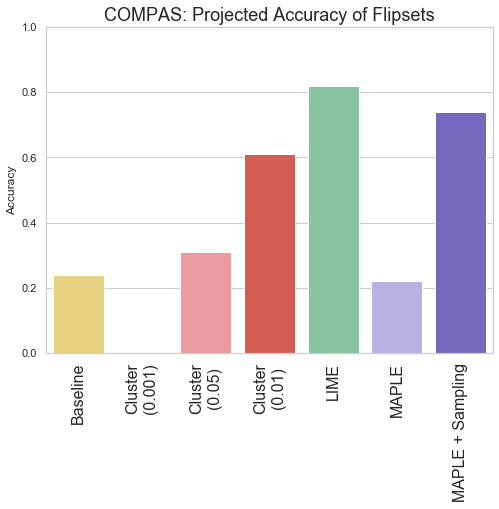

In [183]:
compas_nn_stats = run_all("featselectionauto_3_30_ohe_final_compas_nn.txt", compas_nn, compas_enc, compas_data, \
                          compas_categorical_features, compas_categorical_names)

order = ['baseline', 'cluster_0.001', 'cluster_0.05', 'cluster_0.01', 'lime', 'maple', 'maple_sampled']
names = ['Baseline', 'Cluster\n(0.001)', 'Cluster\n(0.05)', 'Cluster\n(0.01)', 'LIME', 'MAPLE', 'MAPLE + Sampling']

color_orders = ['#F7DC6F', '#f7b7d9', '#f98d94', '#E74C3C', '#7DCEA0', '#b5a8ea','#6a5acd']

plot_metric(compas_nn_stats, 'recourse_accuracy_all', order, "COMPAS: Projected Accuracy of Flipsets", names, colors = color_orders)


validation score:  0.82
test predictions split: 
 1    637
-1     47
dtype: int64
num unique preds:  2
 1    600
-1     84
dtype: int64


age                34.668252
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.483467
length-of-stay     17.428788
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        47 |  relative |      0.01 | 20.0 |  66.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        82 |  relative |      0.01 | -1.0 | 242.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

4627

 0  out of  84
time elapsed:  0.00018196900685628256  minutes
[52. 21. 19.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
baseline
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


obtained 20 items in 0.9 seconds
{'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -2.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -4.0}
{'age': 11.0, 'length-of-stay': -11.0}
{'age': 13.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -4.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.18128760040261305
[28.  9. 12.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
baseline
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[28.  1.  1.  0.  0.  9. 12.]
model_pred:  -1
intercept:  0.18128760040261305
[26. 13. -1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
baseline
populating...
obtained 20 items in 0.9 

obtained 20 items in 0.8 seconds
{'age': 4.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.18128760040261305
[28. 18.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
baseline
populating...
obtained 20 items in 0.8 seconds
{'age': 23.0}
{'age': 23.0, 'length-of-stay': -1.0}
{'age': 5.0, 'priors-count': -5.0, 'race_1': 1.0}
{'age': 23.0, 'race_1': 1.0}
{'age': 23.0, 'length-of-stay': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.18128760040261305
[ 38.   6. 202.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
baseline
populating...
obtained 20 items in 0.8 seconds
[ 38.   1.   0.   0.   1.   6. 202.]
model_pred:  -1
intercept:  0.18128760040261305
[28. 12.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
baseline
populating...

recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[28.  1.  1.  0.  1.  4. 34.]
model_pred:  -1
intercept:  0.18128760040261305
[ 23.   2. 164.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
baseline
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[ 23.   1.   0.   2.   1.   2. 164.]
model_pred:  -1
intercept:  0.18128760040261305
[26.  9.  2.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
baseline
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[26.  1.  0.  0.  1.  9.  2.]
model_pred:  -1
intercept:  0.18128760040261305
[22.  2. 30.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
baseline
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[22.  1.  0.  0.  1.  2. 30.]
model_pred:  -1
intercept:  0.18128760040261305
[32. 13. 97.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
baseline
populating...
obtained 20 items in 0.8 seconds
{'age': 19.0}
{'age': 19.0, 'rac

obtained 20 items in 0.9 seconds
{'age': 1.0, 'priors-count': -11.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -2.0}
{'priors-count': -11.0, 'length-of-stay': -8.0}
{'priors-count': -12.0}
{'age': 15.0, 'length-of-stay': -143.0}
{'age': 1.0, 'priors-count': -11.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -11.0, 'length-of-stay': -8.0, 'race_4': 1.0}
{'priors-count': -12.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -11.0, 'length-of-stay': -8.0, 'race_1': 1.0}
{'priors-count': -12.0, 'race_1': 1.0}
{'age': 15.0, 'length-of-stay': -143.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -11.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'priors-count': -11.0, 'length-of-stay': -8.0, 'race_5': 1.0}
{'priors-count': -12.0, 'race_5': 1.0}
{'age': 15.0, 'lengt

age                34.668252
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.483467
length-of-stay     17.428788
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        47 |  relative |      0.01 | 20.0 |  66.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        82 |  relative |      0.01 | -1.0 | 242.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

4627
23

 0  out of  84
time elapsed:  0.0014928340911865234  minutes
[52. 21. 19.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
cluster_train
1
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


obtained 20 items in 0.8 seconds
{'priors-count': -2.0, 'length-of-stay': -2.0}
{'age': 3.0, 'race_1': 1.0}
{'age': 2.0, 'length-of-stay': -5.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -2.0, 'race_1': 1.0}
{'priors-count': -2.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 3.0, 'race_5': 1.0}
{'age': 2.0, 'length-of-stay': -5.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.31194149985052516
[28.  9. 12.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
cluster_train
19
populating...
obtained 20 items in 0.9 seconds
{'age': 6.0}
{'age': 4.0, 'priors-count': -1.0}
{'age': 6.0, 'length-of-stay': -1.0}
{'age': 4.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -1.0}
{'age': 6.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 6.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 4.0, 'pri

populating...
obtained 20 items in 0.8 seconds
{'priors-count': -11.0}
{'priors-count': -11.0, 'length-of-stay': -2.0}
{'priors-count': -11.0, 'race_4': 1.0}
{'priors-count': -11.0, 'race_1': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -11.0, 'race_5': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'priors-count': -11.0, 'race_3': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'priors-count': -11.0, 'sex_0': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'sex_0': 1.0}
{'priors-count': -11.0, 'race_2': 1.0}
{'priors-count': -11.0, 'c-charge-degree_1': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'race_2': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'c-charge-degree_1': 1.0}
{'priors-count': -11.0, 'two-year-recid_1': -1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
model_pred:  -1
intercept:  -0.31194149985052516
[20.  2. 16.  0.  1.  1.  0.  1.  0. 

obtained 20 items in 0.8 seconds
{'age': 22.0}
{'age': 22.0, 'length-of-stay': -1.0}
{'age': 20.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'age': 21.0, 'priors-count': -1.0}
{'priors-count': -18.0}
{'priors-count': -18.0, 'length-of-stay': -1.0}
{'age': 22.0, 'race_1': 1.0}
{'age': 22.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 20.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 22.0, 'race_5': 1.0}
{'age': 22.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 20.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 22.0, 'race_3': 1.0}
{'age': 22.0, 'length-of-stay': -1.0, 'race_3': 1.0}
model_pred:  -1
intercept:  -0.3656238092863161
[ 38.   6. 202.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
cluster_train
14
populating...
obtained 20 items in 0.9 seconds
{'age': 6.0, 'priors-count': -2.0}
{'age': 6.0, 'priors-cou

obtained 20 items in 0.9 seconds
{'age': 2.0}
{'priors-count': -1.0}
{'age': 2.0, 'length-of-stay': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0}
{'age': 1.0, 'priors-count': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'age': 2.0, 'race_1': 1.0}
{'priors-count': -1.0, 'race_1': 1.0}
{'age': 2.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 2.0, 'race_5': 1.0}
{'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.3389582070765757
[37. 17.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
16
populating...
obtained 20 items in 0.8 seconds
{'age': 12.0}
{'age': 11.0, 'length-of-stay': -2.0}
{'age': 10.0, 'priors-count': -1.0}
{'age': 10.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'priors-count': -9.0, 'length-of-stay': -2.0}
{'priors-count

obtained 20 items in 1.2 seconds
{'length-of-stay': -41.0}
model_pred:  -1
intercept:  -0.3465551109942876
[30. 15.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
16
populating...
obtained 20 items in 1.0 seconds
{'age': 16.0}
{'age': 16.0, 'length-of-stay': -2.0}
{'age': 15.0, 'priors-count': -1.0}
{'age': 15.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'priors-count': -13.0}
{'priors-count': -13.0, 'length-of-stay': -2.0}
{'age': 16.0, 'race_1': 1.0}
{'age': 16.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 15.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 15.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -13.0, 'race_4': 1.0}
{'age': 16.0, 'race_5': 1.0}
{'priors-count': -13.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 16.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 15.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 16.0, 'race_3': 1.0}
model_pred:  -1
intercept:  -0.3656238092863161
[28.  4. 34.  0.  1.  0.  1

recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[ 49.   1.   1.   0.   0.  14. 122.]
model_pred:  -1
intercept:  0.0025478826069273985
[26.  8.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
18
populating...
obtained 20 items in 0.7 seconds
{'age': 1.0, 'race_1': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  -0.2692834487633382
[36. 14.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
cluster_train
16
populating...
obtained 20 items in 0.8 seconds
{'age': 9.0}
{'age': 9.0, 'length-of-stay': -1.0}
{'age': 8.0, 'priors-count': -1.0}
{'age': 8.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'priors-count': -7.0}
{'priors-count': -7.0, 'length-of-stay': -1.0}
{'age': 9.0, 'race_1': 1.0}
{'

populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[22.  1.  0.  0.  1.  2. 16.]
model_pred:  -1
intercept:  -0.3465551109942876
[30.  8. 54.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
14
populating...
obtained 20 items in 1.2 seconds
{'age': 7.0, 'priors-count': -2.0}
{'age': 13.0}
{'age': 7.0, 'priors-count': -2.0, 'length-of-stay': -1.0}
{'age': 12.0, 'length-of-stay': -4.0}
{'priors-count': -5.0}
{'priors-count': -5.0, 'length-of-stay': -1.0}
{'age': 7.0, 'priors-count': -2.0, 'race_4': 1.0}
{'age': 13.0, 'race_4': 1.0}
{'age': 7.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 12.0, 'length-of-stay': -4.0, 'race_4': 1.0}
{'priors-count': -5.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 13.0, 'race_1': 1.0}
{'age': 12.0, 'length-of-stay': -4.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -2.0, 'race_5': 1.0}
{'age': 13.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.028

recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[31.  0.  0.  0.  1. 15. -1.]
model_pred:  -1
intercept:  -0.20756759616557363
[22.  3. 16.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
4
populating...
obtained 20 items in 0.8 seconds
{'age': 1.0, 'priors-count': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'age': 1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'length-of-stay': -5.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  -0.3465551109942876
[ 21.   4. 219.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
cluster_train
5
populating...
obtained 20 items in 0.8 seconds
{'age': 28.0, 'priors-count': -1.0}
{'age': 30.0}
{'age': 28.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'age': 30.0, 'length-of-stay': -1.0}
{'age': 28.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 30.0, 'race_4': 1.0}
{'age': 28.0, 'p

age                34.668252
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.483467
length-of-stay     17.428788
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        47 |  relative |      0.01 | 20.0 |  66.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        82 |  relative |      0.01 | -1.0 | 242.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


4627
46

 0  out of  84
time elapsed:  0.0023405869801839192  minutes
[52. 21. 19.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
cluster_train
45
populating...
obtained 20 items in 0.8 seconds
{'priors-count': -18.0}
{'age': 1.0, 'priors-count': -17.0, 'length-of-stay': -2.0}
{'priors-count': -17.0, 'length-of-stay': -5.0}
{'age': 2.0, 'priors-count': -17.0}
{'priors-count': -18.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -17.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -17.0, 'length-of-stay': -5.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -17.0, 'race_4': 1.0}
{'priors-count': -18.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -17.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -17.0, 'length-of-stay': -5.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -17.0, 'race_1': 1.0}
{'priors-count': -18.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -17.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'priors-count': -17.0, 'length-of-stay': -5.0, 'race_5': 1.0}
{'a

recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[ 33.   1.   1.   0.   1.   3. 114.]
model_pred:  -1
intercept:  0.049190697405391615
[25.  7.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
5
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[25.  1.  1.  0.  1.  7.  0.]
model_pred:  -1
intercept:  -0.2692834487633382
[66. 33. 13.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
43
populating...
obtained 20 items in 0.7 seconds
{'priors-count': -18.0}
{'priors-count': -18.0, 'length-of-stay': -2.0}
{'priors-count': -11.0, 'two-year-recid_1': -1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -18.0, 'race_4': 1.0}
{'priors-count': -18.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -18.0, 'race_1': 1.0}
{'priors-count': -18.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -18.0, 'race_5': 1.0}
{'priors-count': -18.0, 'length-of-stay': -2.0, '

obtained 20 items in 0.9 seconds
{'age': 17.0, 'priors-count': -20.0}
{'age': 20.0, 'priors-count': -18.0, 'length-of-stay': -3.0}
{'age': 17.0, 'priors-count': -20.0, 'race_4': 1.0}
{'age': 20.0, 'priors-count': -18.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 17.0, 'priors-count': -20.0, 'race_1': 1.0}
{'age': 20.0, 'priors-count': -18.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -20.0, 'race_5': 1.0}
{'age': 20.0, 'priors-count': -18.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -20.0, 'sex_0': 1.0}
{'age': 20.0, 'priors-count': -18.0, 'length-of-stay': -3.0, 'sex_0': 1.0}
{'age': 17.0, 'priors-count': -20.0, 'race_2': 1.0}
{'age': 17.0, 'priors-count': -20.0, 'c-charge-degree_1': 1.0}
{'age': 20.0, 'priors-count': -18.0, 'length-of-stay': -3.0, 'race_2': 1.0}
{'age': 20.0, 'priors-count': -18.0, 'length-of-stay': -3.0, 'c-charge-degree_1': 1.0}
{'age': 17.0, 'priors-count': -20.0, 'race_0': 1.0}
{'age': 19.0, 'priors-count':

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 24.0, 'priors-count': -14.0}
{'age': 24.0, 'priors-count': -14.0, 'length-of-stay': -1.0}
{'age': 24.0, 'priors-count': -14.0, 'race_4': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'race_1': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'race_5': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'race_3': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'length-of-stay': -1.0, 'race_3': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'sex_0': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'length-of-stay': -1.0, 'sex_0': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'race_2': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'c-charge-degree_1': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'length-of-stay': -1.0, 'race_2': 1.0}
{'age': 24.0, 'priors-count': -14.0, 'le

obtained 20 items in 0.8 seconds
{'age': 21.0, 'length-of-stay': -4.0}
{'age': 22.0}
{'age': 19.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'age': 20.0, 'priors-count': -1.0}
{'age': 21.0, 'length-of-stay': -4.0, 'race_4': 1.0}
{'age': 22.0, 'race_4': 1.0}
{'age': 19.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 20.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 21.0, 'length-of-stay': -4.0, 'race_1': 1.0}
{'age': 22.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 20.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 21.0, 'length-of-stay': -4.0, 'race_5': 1.0}
{'age': 22.0, 'race_5': 1.0}
{'age': 19.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 20.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 21.0, 'length-of-stay': -4.0, 'race_3': 1.0}
{'age': 22.0, 'race_3': 1.0}
{'age': 19.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_3': 1.0}
{'age': 20.0, 'priors-count': -1.0, 'r

obtained 20 items in 0.8 seconds
{'age': 6.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'priors-count': -5.0}
{'priors-count': -5.0, 'length-of-stay': -2.0}
{'age': 7.0, 'race_1': 1.0}
{'age': 7.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 7.0, 'race_5': 1.0}
{'age': 7.0, 'length-of-stay': -2.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.3389582070765757

 50  out of  84
[30. 14.  2.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
4
populating...
obtained 20 items in 0.8 seconds
{'age': 15.0}
{'age': 14.0, 'priors-count': -1.0}
{'age': 15.0, 'length-of-stay': -3.0}
{'age': 14.0, 'priors-count': -1.0, 'length-of-stay': -3.0}
{'priors-count': -12.0, 'length-of-stay': -3.0}
{'priors-count': -13.0}
{'age': 15.0, 'race_1': 1.0}
{'age': 14.0, '

obtained 20 items in 0.8 seconds
{'age': 9.0}
{'age': 9.0, 'length-of-stay': -1.0}
{'age': 7.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'age': 8.0, 'priors-count': -1.0}
{'priors-count': -7.0}
{'priors-count': -7.0, 'length-of-stay': -1.0}
{'age': 9.0, 'race_4': 1.0}
{'age': 9.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 8.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 9.0, 'race_1': 1.0}
{'age': 9.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 8.0, 'priors-count': -1.0, 'race_1': 1.0}
{'priors-count': -7.0, 'race_4': 1.0}
{'priors-count': -7.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -7.0, 'race_1': 1.0}
{'priors-count': -7.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 9.0, 'race_5': 1.0}
{'age': 9.0, 'length-of-stay': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.3656238092863161
[27.  8.  1.  0. 

obtained 20 items in 0.9 seconds
{'age': 19.0}
{'age': 17.0, 'priors-count': -1.0}
{'age': 18.0, 'length-of-stay': -3.0}
{'age': 17.0, 'priors-count': -1.0, 'length-of-stay': -3.0}
{'age': 19.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 18.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 19.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 18.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 19.0, 'race_3': 1.0}
{'age': 17.0, 'priors-count': -1.0, 'race_3': 1.0}
{'age': 18.0, 'length-of-stay': -3.0, 'race_3': 1.0}
{'age': 17.0, 'priors-count': -1.0, 'length-of-stay': -3.0, 'race_3': 1.0}
model_pred:  -1
intercept:  -0.3656238092863161
[27.  7.  4.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
5
populating...
recovered all minimum-cost items
obtained 0 items in 0.

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 27.0, 'length-of-stay': -202.0}
{'age': 26.0, 'priors-count': -1.0, 'length-of-stay': -196.0}
{'age': 37.0, 'priors-count': -3.0, 'length-of-stay': -34.0, 'sex_1': -1.0}
{'age': 42.0, 'priors-count': -3.0, 'sex_1': -1.0}
{'age': 27.0, 'length-of-stay': -202.0, 'race_4': 1.0}
{'age': 26.0, 'priors-count': -1.0, 'length-of-stay': -196.0, 'race_4': 1.0}
{'age': 27.0, 'length-of-stay': -202.0, 'race_1': 1.0}
{'age': 26.0, 'priors-count': -1.0, 'length-of-stay': -196.0, 'race_1': 1.0}
{'age': 27.0, 'length-of-stay': -202.0, 'race_5': 1.0}
{'age': 26.0, 'priors-count': -1.0, 'length-of-stay': -196.0, 'race_5': 1.0}
{'age': 27.0, 'length-of-stay': -202.0, 'sex_0': 1.0}
{'age': 26.0, 'priors-count': -1.0, 'length-of-stay': -196.0, 'sex_0': 1.0}
{'age': 27.0, 'length-of-stay': -202.0, 'race_2': 1.0}
{'age': 26.0, 'priors-count': -1.0, 'length-of-stay': -196.0, 'race_2': 1.0}
{'age': 26.0, 'length-of-stay': -157.0, 'sex_1': -1.0}
{'age': 27.0, 'length-of-

age                34.668252
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.483467
length-of-stay     17.428788
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        47 |  relative |      0.01 | 20.0 |  66.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        82 |  relative |      0.01 | -1.0 | 242.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


4627
231

 0  out of  84
time elapsed:  0.009769368171691894  minutes
[52. 21. 19.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
cluster_train
156
populating...
obtained 20 items in 0.7 seconds
{'age': 1.0, 'priors-count': -20.0, 'length-of-stay': -2.0}
{'priors-count': -20.0, 'length-of-stay': -5.0}
{'age': 2.0, 'priors-count': -20.0}
{'priors-count': -21.0}
{'age': 1.0, 'priors-count': -20.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -20.0, 'length-of-stay': -5.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -20.0, 'race_4': 1.0}
{'priors-count': -21.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -20.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -20.0, 'length-of-stay': -5.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -20.0, 'race_1': 1.0}
{'priors-count': -21.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -20.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'priors-count': -20.0, 'length-of-stay': -5.0, 'race_5': 1.0}
{'age': 2.0, 'priors-count': -20.0, 'race

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 32.   1.   0.   2.   1.  11. 314.]

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK



model_pred:  -1
intercept:  -0.42009702010385475
[31. 11.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
cluster_train
173
populating...
obtained 20 items in 0.8 seconds
{'age': 8.0}
{'age': 8.0, 'length-of-stay': -1.0}
{'age': 7.0, 'priors-count': -1.0}
{'age': 7.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'priors-count': -9.0}
{'priors-count': -9.0, 'length-of-stay': -1.0}
{'age': 8.0, 'race_1': 1.0}
{'age': 8.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -9.0, 'race_4': 1.0}
{'priors-count': -9.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 8.0, 'race_5': 1.0}
{'age': 8.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'race_5': 1.0}
{'priors-count': -9.0, 'race_1': 1.0}
model_pred:  -1
intercept:  -0.1494213905084275
[28.  8.  3.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
200
populatin

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[20.  1.  0.  0.  1.  2. 16.]
model_pred:  -1
intercept:  -0.07249640970858295
[24.  9. 10.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.]
cluster_train
173
populating...
obtained 20 items in 0.8 seconds
{'age': 14.0}
{'age': 13.0, 'priors-count': -1.0}
{'age': 14.0, 'length-of-stay': -2.0}
{'age': 13.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'age': 14.0, 'race_4': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 14.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 14.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 14.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 14.0, 'race_5': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 14.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 13.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 14.0, 'ra

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 26.   1.   1.   0.   1.   3. 205.]
model_pred:  -1
intercept:  -0.28939009485518563
[ 36.  20. 221.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
   1.]
cluster_train
4
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 36.   1.   0.   3.   1.  20. 221.]
model_pred:  -1
intercept:  -0.42009702010385475
[33. 14.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
124
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 23.0}
{'age': 22.0, 'priors-count': -1.0}
{'age': 23.0, 'length-of-stay': -2.0}
{'age': 22.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'age': 23.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 23.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 23.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 23.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 23.0, 'race_5': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 23.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 23.0, 'race_3': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'race_3': 1.0}
{'age': 23.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 22.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'r

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 41.   0.   0.   0.   1.  19. 220.]
model_pred:  -1
intercept:  -0.31520339573724654
[ 29.  15. 186.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
cluster_train
4
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 29.   1.   0.   0.   1.  15. 186.]
model_pred:  -1
intercept:  -0.42009702010385475
[ 24.   1. 123.   0.   1.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   1.]
cluster_train
203
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisro

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 24.   1.   1.   0.   1.   1. 123.]
model_pred:  -1
intercept:  -0.1981958639764263
[29.  8. 13.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
149
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[29.  1.  0.  0.  1.  8. 13.]
model_pred:  -1
intercept:  -0.12278032126278932
[37. 12.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
144
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 19.0, 'priors-count': -11.0}
{'age': 19.0, 'priors-count': -11.0, 'length-of-stay': -1.0}
{'age': 19.0, 'priors-count': -11.0, 'race_4': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'race_5': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'race_3': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'length-of-stay': -1.0, 'race_3': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'sex_0': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'length-of-stay': -1.0, 'sex_0': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'race_2': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'c-charge-degree_1': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'length-of-stay': -1.0, 'race_2': 1.0}
{'age': 19.0, 'priors-count': -11.0, 'le

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisro

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 30.   1.   0.   0.   0.   9. 243.]
model_pred:  -1
intercept:  -0.42009702010385475
[28. 14. 20.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
176
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[28.  1.  1.  0.  1. 14. 20.]
model_pred:  -1
intercept:  -0.3528805739223627
[ 21.   4. 117.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
cluster_train
202
populating...
obtained 20 items in 0.9 seconds
{'age': 26.0, 'priors-count': -4.0, 'length-of-stay': -31.0}
{'age': 32.0, 'priors-count': -4.0}
{'age': 40.0, 'length-of-stay': -100.0}
{'age': 26.0, 'priors-count': -4.0, 'length-of-stay': -31.0, 'race_4': 1.0}
{'age': 32.0, 'priors-count': -4.0, 'race_4': 1.0}
{'age': 26.0, 'priors-count': -4.0, 'length-of-stay': -31.0, 'race_1': 1.0}
{'age': 32.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 26.0, 'priors-count': -4.0, 'length-of-stay': -31.0, 'race_5': 1.0}
{'age': 32.0, 'priors-count': -4.0, 'race_5': 1.0}
{'age': 26.0, 'priors-count': -4.0, 'length-of-stay': -31.0, 'race_3': 1.0}
{'age': 32.0, 'priors-count': -4.0, 'race_3': 1.0}
{'age': 26.0, 'priors-count': -4.0, 'length-of-stay': -31.0, 'sex_0': 1.0}
{'age': 32.0, 'priors-count': -4.0, 'sex_0': 1.0}
{'age': 2

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 6.0, 'priors-count': -10.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0}
{'age': 6.0, 'priors-count': -10.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'race_5': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0, 'race_5': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'race_3': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0, 'race_3': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'sex_0': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0, 'sex_0': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'race_2': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0, 'race_2': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'two-year-recid_0': 1.0}
{'age': 6.0, 'priors-count': -10.0, 'length-of-stay': 3.0, 'two

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 22.0, 'priors-count': -4.0}
{'age': 22.0, 'priors-count': -4.0, 'length-of-stay': -2.0}
{'age': 36.0, 'length-of-stay': -5.0}
{'age': 37.0}
{'age': 22.0, 'priors-count': -4.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 36.0, 'length-of-stay': -5.0, 'race_4': 1.0}
{'age': 37.0, 'race_4': 1.0}
{'age': 36.0, 'length-of-stay': -5.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -4.0, 'race_5': 1.0}
{'age': 22.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 37.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -4.0, 'race_3': 1.0}
{'age': 22.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 22.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'c-charge-degree_1': -1.0}
{'age': 19.0, 'priors-count': -3.0, 'c-charge-degree_1': -1.0}
{

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 5.0, 'priors-count': -10.0}
{'age': 5.0, 'priors-count': -10.0, 'length-of-stay': 1.0}
{'priors-count': -10.0, 'length-of-stay': 76.0}
{'age': 5.0, 'priors-count': -10.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'length-of-stay': 1.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'race_5': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'length-of-stay': 1.0, 'race_5': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'race_3': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'length-of-stay': 1.0, 'race_3': 1.0}
{'priors-count': -10.0, 'length-of-stay': 76.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'sex_0': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'length-of-stay': 1.0, 'sex_0': 1.0}
{'priors-count': -10.0, 'length-of-stay': 76.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -10.0, 'race_2': 1.0}
{'age': 5.0, 'priors-cou

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.8 seconds
{'age': 7.0}
{'age': 7.0, 'length-of-stay': -1.0}
{'age': 5.0, 'priors-count': -1.0}
{'age': 5.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -1.0}
{'age': 7.0, 'race_4': 1.0}
{'age': 7.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 7.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 7.0, 'race_5': 1.0}
{'age': 7.0, 'length-of-stay': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.05188095961587097
[ 49.  14. 122.   0.   1.   0.   1.   1.   0.   0.   0.   0.   0.   1.
   0.]
cluster_train
169
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 s

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 10.0}
{'age': 8.0, 'priors-count': -1.0}
{'age': 10.0, 'length-of-stay': -2.0}
{'age': 8.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'priors-count': -5.0}
{'priors-count': -5.0, 'length-of-stay': -2.0}
{'age': 10.0, 'race_1': 1.0}
{'age': 8.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 8.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 10.0, 'race_5': 1.0}
{'age': 8.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.04035880251839341
[27. 11.  3.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
49
populating...
obtained 20 items in 0.8 seconds
{'age': 17.0, 'priors-count': -9.0}
{'age': 17.0, 'priors-count': -9.0, 'length-of-stay': -1.0}
{'age': 17.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 17.0, 'priors-count': -9.0, 'length-

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.8 seconds
[47.  1.  0.  0.  0. 19. 30.]
model_pred:  -1
intercept:  -0.1603455449736727
[21.  4. 54.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
cluster_train
190
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[21.  1.  0.  0.  0.  4. 54.]
model_pred:  -1
intercept:  -0.16604621366688826
[ 39.  21. 194.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
cluster_train
24
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 39.   0.   0.   2.   1.  21. 194.]
model_pred:  -1
intercept:  -0.1328775087228417
[ 39.  17. 181.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
cluster_train
4
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[ 39.   1.   0.   2.   1.  17. 181.]
model_pred:  -1
intercept:  -0.42009702010385475
[22.  2. 16.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
139
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[22.  1.  0.  0.  1.  2. 16.]
model_pred:  -1
intercept:  0.0708090780410765
[30.  8. 54.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
82
populating...
obtained 20 items in 0.8 seconds
{'age': 20.0, 'priors-count': -8.0, 'length-of-stay': -7.0}
{'age': 22.0, 'priors-count': -8.0}
{'age': 20.0, 'priors-count': -8.0, 'length-of-stay': -7.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -8.0, 'race_4': 1.0}
{'age': 20.0, 'priors-count': -8.0, 'length-of-stay': -7.0, 'race_1': 1.0}
{'age': 22.0, 'priors-count': -8.0, 'race_1': 1.0}
{'age': 20.0, 'priors-count': -8.0, 'length-of-stay': -7.0, 'race_5': 1.0}
{'age': 22.0, 'priors-count': -8.0, 'race_5': 1.0}
{'age': 20.0, 'priors-count': -8.0, 'length-of-stay': -7.0, 'race_3': 1.0

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.8 seconds
{'age': 24.0}
{'age': 23.0, 'priors-count': -1.0}
{'age': 24.0, 'length-of-stay': -2.0}
{'age': 23.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'age': 24.0, 'race_4': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 24.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 24.0, 'race_1': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 24.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 24.0, 'race_5': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 24.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 24.0, 'race_3': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'race_3': 1.0}
{'age': 24.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 23.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'r

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'age': 21.0, 'priors-count': -1.0}
{'age': 23.0}
{'age': 21.0, 'priors-count': -1.0, 'length-of-stay': 1.0}
{'age': 23.0, 'length-of-stay': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'race_4': 1.0}
{'age': 23.0, 'race_4': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'length-of-stay': 1.0, 'race_4': 1.0}
{'age': 23.0, 'length-of-stay': 1.0, 'race_4': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 23.0, 'race_1': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': 23.0, 'length-of-stay': 1.0, 'race_1': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 23.0, 'race_5': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'length-of-stay': 1.0, 'race_5': 1.0}
{'age': 23.0, 'length-of-stay': 1.0, 'race_5': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'race_3': 1.0}
{'age': 23.0, 'race_3': 1.0}
{'age': 21.0, 'priors-count': -1.0, 'length-of-stay': 1.0, 'race_3': 1.0}
{'age': 23.0, 'length-of-stay': 1.0, 'race_3': 1.

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[ 23.   1.   1.   3.   1.   3. 276.]
model_pred:  -1
intercept:  -0.3128149778643379
[29. 15.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
125
populating...
obtained 20 items in 0.8 seconds
{'age': 32.0, 'priors-count': -15.0}
{'age': 32.0, 'priors-count': -15.0, 'length-of-stay': -2.0}
{'age': 32.0, 'priors-count': -15.0, 'race_4': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'race_1': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'race_5': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'race_3': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'sex_0': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'length-of-stay': -2.0, 'sex_0': 1.0}
{'age': 32.0, 'priors-count': -15.0, 'race_2': 1.0}


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[ 21.   1.   0.   0.   1.   4. 219.]
model_pred:  -1
intercept:  -0.28939009485518563
[33. 21.  6.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
cluster_train
79
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[33.  1.  1.  0.  1. 21.  6.]
model_pred:  -1
intercept:  -0.26008163849157784
TIME FOR EXP:  4.664621750513713  minutes
num unique preds:  2
 1    600
-1     84
dtype: int64


age                34.668252
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.483467
length-of-stay     17.428788
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        47 |  relative |      0.01 | 20.0 |  66.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        82 |  relative |      0.01 | -1.0 | 242.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

4627

 0  out of  84
time elapsed:  4.1429201761881514e-05  minutes
[52. 21. 19.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
lime
exp.local_exp: [(1, -0.09230022544311367), (4, 0.045371384629691196), (3, 0.0380704387413282), (5, -0.03052134423825048), (0, 0.013875650748150435), (6, -0.003798760913643586), (2, -0.0022873325816265776)]
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


obtained 20 items in 0.7 seconds
{'priors-count': -10.0}
{'priors-count': -10.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -10.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'priors-count': -10.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -10.0, 'race_1': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0,

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 32.   1.   0.   2.   1.  11. 314.]
model_pred:  -1
intercept:  -0.17823246574553941
[31. 11.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
lime


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(1, -0.10185058409793428), (3, 0.024493447494639466), (5, -0.020612928469976522), (0, 0.011184132438121991), (6, -0.004393218171415482), (4, -0.0033859176513260044), (2, -0.001575305653803456)]
populating...
obtained 20 items in 0.9 seconds
{'priors-count': -1.0}
{'age': 3.0}
{'priors-count': -1.0, 'length-of-stay': -1.0}
{'age': 1.0, 'priors-count': -1.0}
{'age': 3.0, 'length-of-stay': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'priors-count': -1.0, 'race_1': 1.0}
{'age': 3.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 3.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'race_5': 1.0}
{'age': 3.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.09699989423902411
[28.  8.  3.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.10540854736385709), (

obtained 20 items in 0.9 seconds
{'age': 18.0, 'priors-count': -5.0}
{'age': 18.0, 'priors-count': -5.0, 'length-of-stay': -1.0}
{'age': 38.0}
{'age': 38.0, 'length-of-stay': -1.0}
{'age': 18.0, 'priors-count': -5.0, 'race_4': 1.0}
{'age': 18.0, 'priors-count': -5.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 18.0, 'priors-count': -5.0, 'race_1': 1.0}
{'age': 18.0, 'priors-count': -5.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 18.0, 'priors-count': -5.0, 'race_5': 1.0}
{'age': 18.0, 'priors-count': -5.0, 'length-of-stay': -1.0, 'race_5'

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 32.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 33.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'age': 32.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 33.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 32.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 6.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 33.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 11.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 11.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'priors-count': -3.0, 'lengt

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 36.   1.   0.   3.   1.  20. 221.]
model_pred:  -1
intercept:  -0.23839656587265123
[33. 14.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(1, -0.1097433362618509), (3, 0.028736025300205185), (5, -0.023000671116334286), (0, 0.01331874263334716), (4, -0.012760086893800045), (2, -0.01103644809455247), (6, -0.0049182658296474625)]
populating...
obtained 20 items in 0.8 seconds
{'age': 17.0, 'priors-count': -14.0}
{'age': 17.0, 'priors-count': -14.0, 'length-of-stay': -2.0}
{'age': 17.0, 'priors-count': -14.0, 'race_4': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'race_3': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'sex_0': 1.0}
{'age': 17.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'sex_0': 1.0}
model_pred

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'age': 1.0, 'priors-count': -8.0}
{'priors-count': -8.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -2.0}
{'priors-count': -9.0}
{'age': 37.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -8.0, 'race_4': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 38.0}
{'priors-count': -9.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'race_1': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -9.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'race_5': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.07364772096540184

 25  out of  84
[31. 10.  1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.0954823046201993), (3, 0.02499018226

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 29.   1.   0.   0.   1.  15. 186.]
model_pred:  -1
intercept:  -0.2555323382399521
[ 24.   1. 123.   0.   1.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   1.]
lime
exp.local_exp: [(1, -0.146155353475418), (2, -0.06043690035564478), (3, 0.035668780944250356), (4, 0.03281880739296736), (5, -0.03070622211861454), (0, 0.017754223568146956), (6, -0.001983566821853567)]
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'age': 38.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 38.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 40.0, 'length-of-stay': -67.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 42.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 38.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 38.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 38.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 38.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 40.0, 'length-of-stay': -64.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 38.0, 'priors-count': -1.0,

populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 30.   1.   0.   0.   0.   9. 243.]
model_pred:  -1
intercept:  -0.17877541330501756
[28. 14. 20.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.12753776450974452), (3, 0.0335072682988378), (5, -0.027536970857760804), (2, -0.016347646386324563), (0, 0.014687169024157377), (4, -0.006146419467305014), (6, -0.004988556005981973)]
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.4 seconds
{'age': 35.0, 'priors-count': -14.0}
{'age': 34.0, 'priors-count': -14.0, 'length-of-stay': -9.0}
{'age': 22.0, 'priors-count': -14.0, 'c-charge-degree_1': -1.0}
{'age': 35.0, 'priors-count': -14.0, 'race_4': 1.0}
{'age': 34.0, 'priors-count': -14.0, 'length-of-stay': -9.0, 'race_4': 1.0}
{'age': 22.0, 'priors-count': -14.0, 'length-of-stay': -3.0, 'c-charge-degree_1': -1.0}
{'age': 35.0, 'priors-count': -14.0, 'race_1': 1.0}
{'age': 34.0, 'priors-count': -14.0, 'length-of-stay': -9.0, 'race_1': 1.0}
{'age': 35.0, 'priors-count': -14.0, 'race_5': 1.0}
{'age': 34.0, 'priors-count': -14.0, 'length-of-stay': -9.0, 'race_5': 1.0}
{'age': 35.0, 'priors-count': -14.0, 'race_3': 1.0}
{'age': 34.0, 'priors-count': -14.0, 'length-of-stay': -9.0, 'race_3': 1.0}
model_pred:  -1
intercept:  0.04048859849597386
[ 21.   4. 117.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
lime
exp.local_exp: [(1, -0.15172804922377908), (2, -0.061328103716041846), (3,

exp.local_exp: [(1, -0.11478285878913534), (3, 0.029760259541205064), (5, -0.02532820754506471), (2, -0.014811622973953168), (0, 0.01326337362121819), (6, -0.0050906205366257), (4, -0.0027551307564734097)]
populating...
obtained 20 items in 1.3 seconds
{'age': 9.0, 'priors-count': -14.0}
{'age': 9.0, 'priors-count': -14.0, 'length-of-stay': -2.0}
{'age': 9.0, 'priors-count': -14.0, 'race_4': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'race_1': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'race_5': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'race_3': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'sex_0': 1.0}
{'age': 9.0, 'priors-count': -14.0, 'length-of-stay': -2.0, 'sex_0': 1.0}
model_pred:  -1
interce

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'priors-count': -4.0}
{'age': 1.0, 'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -3.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -3.0}
{'age': 19.0}
{'age': 18.0, 'length-of-stay': -3.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'age': 19.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 18.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 19.0, 'race_1': 1.0}
{'age': 18.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.06942264869181924
[22.  2. 30.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.11081683877497044), (3, 0.027567654342559395), (5, -0.025800308926244717), (2, -0.01765234466062005), (4, 0.01443819586501685), (0, 0.013

populating...
obtained 20 items in 1.1 seconds
{'age': 25.0, 'priors-count': -10.0}
{'age': 25.0, 'priors-count': -10.0, 'length-of-stay': -3.0}
{'age': 25.0, 'priors-count': -10.0, 'race_4': 1.0}
{'age': 25.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 25.0, 'priors-count': -10.0, 'race_1': 1.0}
{'age': 25.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 25.0, 'priors-count': -10.0, 'race_5': 1.0}
{'age': 25.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 25.0, 'priors-count': -10.0, 'race_3': 1.0}
{'age': 25.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_3': 1.0}
{'age': 15.0, 'priors-count': -9.0, 'c-charge-degree_0': -1.0}
{'age': 10.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'c-charge-degree_0': -1.0}
model_pred:  -1
intercept:  0.034631187768812355
[37. 23.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.1162271540738787), (5, -0.03241062787092371), (3, 0.0

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 21.   1.   0.   0.   1.   8. 243.]
model_pred:  -1
intercept:  -0.21612662930988075
[32. 14.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.09292075364427131), (3, 0.026046683316499133), (5, -0.02283610305967765), (0, 0.012608868592188021), (2, 0.006292663386609339), (6, -0.004447669996068496), (4, -0.002083786358452703)]
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'priors-count': -10.0}
{'age': 3.0, 'priors-count': -9.0}
{'priors-count': -10.0, 'length-of-stay': -2.0}
{'age': 3.0, 'priors-count': -9.0, 'length-of-stay': -2.0}
{'priors-count': -10.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'race_4': 1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -10.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'race_1': 1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.04941919684470242
[27. 11.  3.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.10996605897860913), (3, 0.02687777231981781), (5, -0.022989270961640676), (2, -0.01739595734711206), (4, 0.012728488966937014), (0, 0.01270411109799226), (6, -0.0043916963115936064)]
populating...
obtained 20 it

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 39.   0.   0.   2.   1.  21. 194.]
model_pred:  -1
intercept:  -0.22785954024682248
[ 39.  17. 181.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
lime
exp.local_exp: [(1, -0.11309259031007839), (3, 0.039350693031340256), (5, -0.03524319499047522), (2, -0.023584482728800954), (0, 0.018632572305190043), (4, 0.010399975988894498), (6, -0.0016398159461116497)]
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 39.   1.   0.   2.   1.  17. 181.]
model_pred:  -1
intercept:  -0.18877100278331455
[22.  2. 16.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
lime
exp.local_exp: [(1, -0.10948773713611112), (3, 0.02725105332468944), (5, -0.02304290949067309), (2, -0.016698411027376108), (0, 0.012298394144305138), (6, -0.0037805473355102654), (4, 0.0012312937718750882)]
populating...


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'age': 12.0, 'priors-count': -2.0}
{'age': 21.0}
{'age': 16.0, 'priors-count': -1.0, 'length-of-stay': -2.0}
{'age': 21.0, 'length-of-stay': -2.0}
{'age': 12.0, 'priors-count': -2.0, 'race_4': 1.0}
{'age': 21.0, 'race_4': 1.0}
{'age': 16.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 21.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 12.0, 'priors-count': -2.0, 'race_1': 1.0}
{'age': 21.0, 'race_1': 1.0}
{'age': 16.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 21.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 12.0, 'priors-count': -2.0, 'race_5': 1.0}
{'two-year-recid_1': -1.0}
{'age': 21.0, 'race_5': 1.0}
{'age': 16.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 21.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
model_pred:  -1

obtained 20 items in 1.0 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay'

Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'priors-count': -9.0, 'race_1': 1.0}
{'priors-count': -9.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -9.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -9.0, 'length-of-stay': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.06817037908849621
TIME FOR EXP:  16.796896334489187  minutes
num unique preds:  2
 1    600
-1     84
dtype: int64


age                34.668252
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.483467
length-of-stay     17.428788
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        47 |  relative |      0.01 | 20.0 |  66.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        82 |  relative |      0.01 | -1.0 | 242.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

4627

 0  out of  84
time elapsed:  6.406307220458984e-05  minutes
[52. 21. 19.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


obtained 20 items in 1.1 seconds
{'age': 2.0, 'race_1': 1.0}
{'age': 2.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -8.0, 'race_1': 1.0}
{'priors-count': -2.0, 'race_1': 1.0}
{'age': 2.0, 'race_5': 1.0}
{'age': 2.0, 'length-of-stay': -2.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.1952422700516998
[28.  9. 12.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
maple
populating...
obtained 20 items in 1.0 seconds
{'age': 7.0}
{'age': 5.0, 'priors-count': -1.0}
{'age': 7.0, 'length-of-stay': -1.0}
{'age': 5.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -1.0}
{'age': 7.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 7.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'

obtained 20 items in 1.1 seconds
{'priors-count': -5.0}
{'priors-count': -5.0, 'length-of-stay': -1.0}
{'priors-count': -5.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 8.0, 'race_5': 1.0}
{'age': 8.0, 'length-of-stay': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.23014876277772411
[ 41.  25. 185.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple
populating...
obtained 20 items in 1.1 seconds
[ 41.   1.   0.   0.   1.  25. 185.]
model_pred:  -1
intercept:  -0.23014876277772411
[23.  3. 91.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 1.1 seconds
{'length-of-stay': -89.0}
{'age': 5.0, 'race_5': 1.0}
{'age': 5.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 4.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 3.0, 'priors-count': -1.0, 'length-of-stay': -5.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.2271232016948605
[26.  7.  2.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  

recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[31.  1.  1.  0.  1.  9.  0.]
model_pred:  -1
intercept:  -0.13448492341348495
[37. 17.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 1.2 seconds
{'age': 9.0, 'race_1': 1.0}
{'age': 9.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 8.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 9.0, 'race_5': 1.0}
{'age': 9.0, 'length-of-stay': -2.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.16916070250217718
[30. 19.  9.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 1.2 seconds
{'priors-count': -13.0}
{'priors-count': -13.0, 'length-of-stay': -1.0}
{'age': 20.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 21.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -1.0, 'ra

obtained 20 items in 1.3 seconds
{'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -2.0}
{'age': 7.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 7.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 7.0, 'race_5': 1.0}
{'age': 5.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.16916070250217718

 50  out of  84
[30. 14.  2.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 1.3 seconds
{'age': 12.0, 'length-of-stay': -3.0}
{'age': 10.0, 'priors-count': -1.0, 'length-of-stay': -3.0}
{'priors-count': -8.0}
{'priors-count': -8.0, 'length-of-stay': -3.0}
{'age': 12.0, 'race_1': 1.0}
{'age': 11.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 12.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 10.0, 'priors-count': -1.

obtained 20 items in 1.2 seconds
{'priors-count': -2.0}
{'priors-count': -2.0, 'length-of-stay': -2.0}
{'age': 3.0, 'race_1': 1.0}
{'age': 3.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -2.0, 'race_1': 1.0}
{'priors-count': -2.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 3.0, 'race_5': 1.0}
{'age': 3.0, 'length-of-stay': -2.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.16916070250217718
[22. 12. 35.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 1.3 seconds
{'age': 19.0}
{'age': 17.0, 'priors-count': -1.0}
{'age': 17.0, 'priors-count': -1.0, 'length-of-stay': -3.0}
{'priors-count': -12.0}
{'priors-count': -11.0, 'length-of-stay': -12.0}
{'priors-count': -12.0, 'race_4': 1.0}
{'age': 19.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -1.0, 'race_5': 1.0}
{'age': 19.0, 'length-of-stay': -3.0, 'race_5':

obtained 20 items in 1.3 seconds
{'length-of-stay': -265.0}
model_pred:  -1
intercept:  -0.21847858831275052
[29. 15.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 1.1 seconds
{'priors-count': -8.0, 'length-of-stay': -2.0}
{'age': 14.0, 'race_1': 1.0}
{'age': 12.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 14.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 12.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -8.0, 'race_1': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 14.0, 'race_5': 1.0}
{'age': 12.0, 'priors-count': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.16916070250217718
[31. 15. -1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...
obtained 20 items in 1.1 seconds
{'age': 9.0}
{'age': 7.0, 'priors-count': -1.0}
{'priors-count': -5.0}
{'age': 9.0, 'race_1': 1.0}
{'age': 7.0, 'priors-count': -1.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race

age                34.668252
two-year-recid      0.000000
c-charge-degree     0.000000
race                0.000000
sex                 0.000000
priors-count        3.483467
length-of-stay     17.428788
dtype: float64

+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |   lb |    ub |
+-------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+------+-------+
|               age | <class 'int'> |    True |       True |              0 |            nan |        47 |  relative |      0.01 | 20.0 |  66.0 |
|      priors-count | <class 'int'> |    True |       True |              0 |            nan |        23 |  relative |      0.01 |  0.0 |  22.0 |
|    length-of-stay | <class 'int'> |    True |       True |              0 |            nan |        82 |  relative |      0.01 | -1.0 | 242.0 |
|  two-year-recid_0 | <class 'int'> |    True |       True |              0 |            nan |         2 |  relative |      

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


4627

 0  out of  84
time elapsed:  3.243684768676758e-05  minutes
[52. 21. 19.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[52.  1.  0.  0.  0. 21. 19.]
model_pred:  -1
intercept:  0.08464060464926348
[28.  9. 12.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 14.0, 'priors-count': -9.0}
{'age': 14.0, 'priors-count': -9.0, 'length-of-stay': -1.0}
{'age': 14.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 14.0, 'priors-count': -9.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 14.0, 'priors-count': -9.0, 'race_1': 1.0}
{'age': 14.0, 'priors-count': -9.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 14.0, 'priors-count': -9.0, 'race_5': 1.0}
{'age': 14.0, 'priors-count': -9.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 14.0, 'priors-count': -9.0, 'race_3': 1.0}
{'age': 14.0, 'priors-count': -9.0, 'length-of-stay': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'priors-count': -10.0}
{'age': 4.0, 'priors-count': -9.0}
{'priors-count': -10.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -9.0, 'race_4': 1.0}
{'priors-count': -10.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -9.0, 'race_1': 1.0}
{'priors-count': -10.0, 'race_5': 1.0}
{'age': 4.0, 'priors-count': -9.0, 'race_5': 1.0}
{'priors-count': -10.0, 'race_3': 1.0}
{'age': 4.0, 'priors-count': -9.0, 'race_3': 1.0}
{'priors-count': -10.0, 'sex_0': 1.0}
{'age': 4.0, 'priors-count': -9.0, 'sex_0': 1.0}
{'age': 2.0, 'priors-count': -6.0, 'c-charge-degree_0': -1.0}
{'priors-count': -10.0, 'race_2': 1.0}
{'priors-count': -10.0, 'c-charge-degree_1': 1.0}
{'priors-count': -7.0, 'c-charge-degree_0': -1.0}
model_pred:  -1
intercept:  0.08389280681742295
[ 19.   3. 199.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 19.   1.   0.   0.   1.   3. 199.]
model_pred:  -1
intercept:  -0.19222715405740864
[ 32.  11. 314.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 32.   1.   0.   2.   1.  11. 314.]
model_pred:  -1
intercept:  -0.06928447061227394
[31. 11.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 2.0, 'priors-count': -1.0}
{'priors-count': -2.0}
{'age': 2.0, 'priors-count': -1.0, 'length-of-stay': -1.0}
{'priors-count': -2.0, 'length-of-stay': -1.0}
{'age': 6.0, 'length-of-stay': -1.0}
{'age': 7.0}
{'age': 2.0, 'priors-count': -1.0, 'race_1': 1.0}
{'priors-count': -2.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -2.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 6.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 7.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -1.0, 'race_5': 1.0}
{'priors-count': -2.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.11021198592902837
[28.  8.  3.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 1.0, 'priors-count': -1.0}
{'priors-count': -1.0, 'race_1': 1.0}
{'age': 3.0, 'race_1': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'race_1': 1.0}
{'age': 3.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -1.0, 'race_5': 1.0}
{'age': 3.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.08817462883243643
[24.  3. 97.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'age': 18.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 19.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 32.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 31.0, 'length-of-stay': -14.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 18.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 19.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 18.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 19.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 32.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 31.0, 'length-of-stay': -14.0, 'two-ye

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'age': 2.0, 'priors-count': -4.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0}
{'priors-count': -5.0}
{'priors-count': -5.0, 'length-of-stay': -1.0}
{'age': 20.0}
{'age': 20.0, 'length-of-stay': -1.0}
{'age': 2.0, 'priors-count': -4.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -5.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 20.0, 'race_4': 1.0}
{'age': 20.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 20.0, 'race_1': 1.0}
{'age': 20.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'race_5': 1.0}
{'age': 2.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_5': 1.0}
m

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 15.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 15.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 28.0, 'length-of-stay': -7.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 29.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 15.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 15.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 15.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 15.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 28.0, 'length-of-stay': -7.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 15.0, 'priors-c

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -1.0}
{'age': 1.0, 'priors-count': -4.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -1.0}
{'age': 18.0}
{'age': 18.0, 'length-of-stay': -1.0}
{'priors-count': -4.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 18.0, 'race_4': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'age': 18.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 18.0, 'race_1': 1.0}
{'age': 18.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_5': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.069854010

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[66.  1.  0.  0.  1. 33. 13.]
model_pred:  -1
intercept:  0.257210157948529
[20.  2. 16.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'age': 29.0, 'priors-count': -2.0, 'length-of-stay': -2.0}
{'age': 30.0, 'priors-count': -2.0}
{'age': 38.0, 'length-of-stay': -2.0}
{'age': 39.0}
{'age': 29.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 30.0, 'priors-count': -2.0, 'race_4': 1.0}
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 29.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 30.0, 'priors-count': -2.0, 'race_1': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 38.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 39.0, 'race_4': 1.0}
{'age': 38.0, 'length-o

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 6.0, 'priors-count': -9.0}
{'age': 6.0, 'priors-count': -9.0, 'length-of-stay': -2.0}
{'age': 6.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -9.0, 'race_1': 1.0}
{'two-year-recid_1': -1.0}
{'age': 6.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 6.0, 'priors-count': -9.0, 'race_5': 1.0}
{'age': 6.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 6.0, 'priors-count': -9.0, 'rac

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 2.0, 'priors-count': -8.0}
{'priors-count': -9.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -3.0}
{'priors-count': -9.0, 'length-of-stay': -3.0}
{'age': 2.0, 'priors-count': -8.0, 'race_4': 1.0}
{'priors-count': -9.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'priors-count': -9.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -8.0, 'race_1': 1.0}
{'priors-count': -9.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'priors-count': -9.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 2.0, 'priors-count': -8.0, 'race_5': 1.0}
{'priors-count': -1.0, 'length-of-stay': -3.0, 'two-year-recid_1': -1.0}
model_pred:  -1
intercept:  0.06510633841123326
[24.  6. 45.  0.  1.  1.  0.  1.  0.  0.  0.  

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 3.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 12.0, 'two-year-recid_1': -1.0}
{'age': 12.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 12.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 12.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -2.0, 'length-of-stay': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 41.   1.   0.   0.   1.  25. 185.]
model_pred:  -1
intercept:  -0.4214469499950842
[23.  3. 91.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 41.0, 'priors-count': -3.0, 'length-of-stay': -47.0, 'two-year-recid_1': -1.0}
{'age': 43.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'age': 11.0, 'priors-count': -3.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 11.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 24.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 24.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 41.0, 'priors-count': -3.0, 'length-of-stay': -47.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 41.0, 'priors-count': -3.0, 'length-of-stay': -47.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 41.0, 'priors-count': -3.0, 'length-of-stay': -47.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
{'age': 41.0, 'priors-count': -3.0, 'length-of-stay': -47.0, 'two-year-recid_1': -1.0, 'race_3': 1.0}
{'age': 41.0, 'priors-count': -3.0, 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 1.0, 'priors-count': -3.0}
{'priors-count': -4.0}
{'age': 1.0, 'priors-count': -3.0, 'length-of-stay': -3.0}
{'priors-count': -4.0, 'length-of-stay': -3.0}
{'age': 15.0}
{'age': 15.0, 'length-of-stay': -3.0}
{'priors-count': -4.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 15.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -3.0, 'race_1': 1.0}
{'age': 15.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -3.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 15.0, 'race_1': 1.0}
{'age': 15.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -3.0, 'race_5': 1.0}
{'priors-count': -4.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.07016584910818524
[ 26.   3. 205.   0.   1.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 26.   1.   1.   0.   1.   3. 205.]
model_pred:  -1
intercept:  -0.17571500274485347
[ 36.  20. 221.   0.   1.   1.   0.   0.   0.   0.   1.   0.   0.   0.
   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 36.   1.   0.   3.   1.  20. 221.]
model_pred:  -1
intercept:  -0.39107285568335387
[33. 14.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'priors-count': -10.0}
{'age': 3.0, 'priors-count': -9.0}
{'age': 2.0, 'priors-count': -9.0, 'length-of-stay': -2.0}
{'priors-count': -10.0, 'length-of-stay': -2.0}
{'priors-count': -10.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -10.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -9.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.07549216223879296
[28. 18.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'priors-count': -14.0}
{'age': 3.0, 'priors-count': -13.0}
{'priors-count': -14.0, 'length-of-stay': -1.0}
{'age': 3.0, 'priors-count': -13.0, 'length-of-stay': -1.0}
{'age': 3.0, 'priors-count': -13.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -14.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -13.0, 'race_1': 1.0}
{'priors-count': -14.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -13.0, 'length-of-stay': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.11894026142841341
[ 38.   6. 202.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 38.   1.   0.   0.   1.   6. 202.]
model_pred:  -1
intercept:  -0.17856152403205378
[28. 12.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'age': 1.0, 'priors-count': -10.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0}
{'priors-count': -11.0}
{'priors-count': -11.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -10.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -11.0, 'race_4': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -11.0, 'race_1': 1.0}
{'priors-count': -11.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.05823973950707628

 25  out of  84
[31. 10.  1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'priors-count': -4.0}
{'age': 1.0, 'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -2.0}
{'age': 17.0}
{'age': 17.0, 'length-of-stay': -2.0}
{'priors-count': -4.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 17.0, 'race_4': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 17.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 17.0, 'race_1': 1.0}
{'age': 17.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.0727970

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 4.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0}
{'age': 4.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 13.0, 'two-year-recid_1': -1.0}
{'age': 13.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 13.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 13.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 13.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 13.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
{'priors-

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 41.   0.   0.   0.   1.  19. 220.]
model_pred:  -1
intercept:  -0.28507142523969914
[ 29.  15. 186.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 29.   1.   0.   0.   1.  15. 186.]
model_pred:  -1
intercept:  -0.2611754366026282
[ 24.   1. 123.   0.   1.   0.   1.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'age': 30.0, 'priors-count': -1.0, 'length-of-stay': -4.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 31.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 35.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 35.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 30.0, 'priors-count': -1.0, 'length-of-stay': -4.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 31.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 30.0, 'priors-count': -1.0, 'length-of-stay': -4.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 31.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 35.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 35.0, 'length-of-stay': -1.0, 'two-year

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 2.0, 'priors-count': -7.0}
{'age': 2.0, 'priors-count': -7.0, 'length-of-stay': -2.0}
{'priors-count': -8.0}
{'priors-count': -8.0, 'length-of-stay': -2.0}
{'age': 33.0}
{'age': 33.0, 'length-of-stay': -2.0}
{'age': 2.0, 'priors-count': -7.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -8.0, 'race_4': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -7.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -8.0, 'race_1': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
model_pred:  

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 1.0, 'priors-count': -5.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': -1.0}
{'priors-count': -6.0}
{'priors-count': -6.0, 'length-of-stay': -1.0}
{'age': 23.0, 'length-of-stay': -1.0}
{'age': 24.0}
{'age': 1.0, 'priors-count': -5.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -6.0, 'race_4': 1.0}
{'priors-count': -6.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -6.0, 'race_1': 1.0}
{'priors-count': -6.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -5.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'priors-count': -6.0, 'race_5': 1.0}
{'priors-count': -6.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 23.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[31.  1.  1.  0.  1.  9.  0.]
model_pred:  -1
intercept:  0.07703916701808011
[37. 17.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 8.0, 'priors-count': -17.0}
{'age': 8.0, 'priors-count': -17.0, 'length-of-stay': -2.0}
{'age': 8.0, 'priors-count': -17.0, 'race_4': 1.0}
{'age': 8.0, 'priors-count': -17.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 8.0, 'priors-count': -17.0, 'race_1': 1.0}
{'age': 8.0, 'priors-count': -17.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 8.0, 'priors-count': -17.0, 'race_5': 1.0}
{'age': 8.0, 'priors-count': -17.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 8.0, 'priors-count': -17.0, 'race_3': 1.0}
{'age': 2.0, 'priors-count': -13.0, 'c-charge-degree_0': -1.0}
{'age': 8.0, 'priors-count': -17.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'priors-count': -14.0, 'c-charge-degree_0': -1.0}
model_pred:  -1
intercept:  0.07675122451423899
[30. 19.  9.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 1.0, 'priors-count': -12.0}
{'age': 1.0, 'priors-count': -12.0, 'length-of-stay': -1.0}
{'priors-count': -13.0}
{'priors-count': -13.0, 'length-of-stay': -1.0}
{'age': 1.0, 'priors-count': -12.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -12.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -13.0, 'race_1': 1.0}
{'priors-count': -13.0, 'length-of-stay': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.08724575316545069
[ 30.   9. 243.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   1.
   0.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 30.   1.   0.   0.   0.   9. 243.]
model_pred:  -1
intercept:  -0.21460992069442214
[28. 14. 20.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 25.0, 'priors-count': -14.0}
{'age': 25.0, 'priors-count': -14.0, 'length-of-stay': -3.0}
{'age': 25.0, 'priors-count': -14.0, 'race_4': 1.0}
{'age': 25.0, 'priors-count': -14.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 25.0, 'priors-count': -14.0, 'race_1': 1.0}
{'age': 25.0, 'priors-count': -14.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -13.0, 'c-charge-degree_1': -1.0}
{'age': 8.0, 'priors-count': -14.0, 'length-of-stay': -3.0, 'c-charge-degree_1': -1.0}
{'age': 25.0, 'priors-count': -14.0, 'race_5': 1.0}
{'age': 25.0, 'priors-count': -14.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 25.0, 'priors-count': -14.0, 'race_3': 1.0}
{'age': 25.0, 'priors-count': -14.0, 'length-of-stay': -3.0, 'race_3': 1.0}
model_pred:  -1
intercept:  0.02137574262220132
[ 21.   4. 117.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.
   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'age': 34.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 34.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 34.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 34.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 34.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 34.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 34.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_5': 1.0}
{'age': 34.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_5': 1.0}
{'age': 34.0, 'priors-count': -4.0, 'two-year-recid_1':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 32.0, 'priors-count': -8.0, 'c-charge-degree_0': -1.0}
{'age': 32.0, 'priors-count': -8.0, 'length-of-stay': -2.0, 'c-charge-degree_0': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
model_pred:  -1
intercept:  0.013058208541864236
[26. 10.  5.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 18.0, 'priors-count': -9.0}
{'age': 18.0, 'priors-count': -9.0, 'length-of-stay': -3.0}
{'age': 18.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 18.0, 'priors-count': -9.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 18.0, 'priors-count': -9.0, 'race_1': 1.0}
{'age': 18.0, 'priors-count': -9.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 18.0, 'priors-count': -9.0, 'race_5': 1.0}
{'age': 18.0, 'priors-count': -9.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 18.0, 'priors-count': -9.0, 'race_3': 1.0}
{'age': 18.0, 'priors-count': -9.0, 'length-of-stay': -3.0, 'race_3': 1.0}
{'age': 15.0, 'priors-count': -8.0, 'c-charge-degree_1': -1.0}
{'age': 18.0, 'priors-count': -9.0, 'sex_0': 1.0}
model_pred:  -1
intercept:  0.03502291669370261
[19.  1. 48.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'priors-count': -16.0}
{'age': 1.0, 'priors-count': -16.0}
{'priors-count': -16.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -16.0, 'race_4': 1.0}
{'priors-count': -16.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -16.0, 'race_1': 1.0}
{'priors-count': -16.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -16.0, 'race_5': 1.0}
{'priors-count': -16.0, 'race_3': 1.0}
{'age': 1.0, 'priors-count': -16.0, 'race_3': 1.0}
{'priors-count': -16.0, 'race_2': 1.0}
model_pred:  -1
intercept:  0.059107873150814894
[23.  4. 43.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 3.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_5': 1.0}
model_pred:  -1
intercept:  -0.01405935887952392
[30. 15.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 3.0, 'priors-count': -12.0}
{'priors-count': -13.0}
{'age': 2.0, 'priors-count': -12.0, 'length-of-stay': -2.0}
{'priors-count': -13.0, 'length-of-stay': -2.0}
{'age': 3.0, 'priors-count': -12.0, 'race_4': 1.0}
{'priors-count': -13.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -12.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -13.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -12.0, 'race_1': 1.0}
{'priors-count': -13.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -12.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -13.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.06803033478002929
[28.  4. 34.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 35.0, 'priors-count': -4.0, 'c-charge-degree_1': -1.0}
{'age': 35.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'c-charge-degree_1': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 23.   1.   0.   2.   1.   2. 164.]
model_pred:  -1
intercept:  -0.17363884839560867
[26.  9.  2.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 3.0, 'priors-count': -6.0}
{'priors-count': -7.0}
{'age': 3.0, 'priors-count': -6.0, 'length-of-stay': -3.0}
{'priors-count': -7.0, 'length-of-stay': -3.0}
{'age': 32.0}
{'age': 32.0, 'length-of-stay': -3.0}
{'age': 3.0, 'priors-count': -6.0, 'race_4': 1.0}
{'priors-count': -7.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -6.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'priors-count': -7.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -6.0, 'race_1': 1.0}
{'priors-count': -7.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -6.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'priors-count': -7.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -6.0, 'race_5': 1.0}
{'priors-count': -7.0, 'race_5': 1.0}
{'age': 32.0, 'race_4': 1.0}
model_pred:  -1
intercept:  0.0682894383572169
[22.  2. 30.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 42.0, 'priors-count': -2.0, 'length-of-stay': -16.0, 'c-charge-degree_0': -1.0}
{'age': 43.0, 'priors-count': -2.0, 'c-charge-degree_0': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'tw

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.2 seconds
{'age': 12.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 12.0, 'priors-count': -13.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 12.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 12.0, 'priors-count': -13.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 12.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 12.0, 'priors-count': -13.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 12.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_5': 1.0}
{'age': 12.0, 'priors-count': -13.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_5': 1.0}
{'age': 12.0, 'priors-count': -13.0, 'two-year-recid_1': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'priors-count': -7.0}
{'age': 4.0, 'priors-count': -6.0}
{'priors-count': -7.0, 'length-of-stay': -2.0}
{'age': 4.0, 'priors-count': -6.0, 'length-of-stay': -2.0}
{'age': 34.0}
{'age': 34.0, 'length-of-stay': -2.0}
{'priors-count': -7.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -6.0, 'race_4': 1.0}
{'priors-count': -7.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -6.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -7.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -6.0, 'race_1': 1.0}
{'priors-count': -7.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -6.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -7.0, 'race_5': 1.0}
{'age': 4.0, 'priors-count': -6.0, 'race_5': 1.0}
{'priors-count': -7.0, 'length-of-stay': -2.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.08975119044438296

 50  out of  84
[30. 14.  2.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
popula

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 2.0, 'priors-count': -11.0}
{'priors-count': -12.0}
{'age': 2.0, 'priors-count': -11.0, 'length-of-stay': -3.0}
{'priors-count': -12.0, 'length-of-stay': -3.0}
{'age': 2.0, 'priors-count': -11.0, 'race_4': 1.0}
{'priors-count': -12.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'priors-count': -12.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -11.0, 'race_1': 1.0}
{'priors-count': -12.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -11.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'priors-count': -12.0, 'length-of-stay': -3.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.04253004808384686
[25.  7.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 2.0, 'priors-count': -6.0}
{'age': 2.0, 'priors-count': -6.0, 'length-of-stay': -1.0}
{'priors-count': -7.0}
{'priors-count': -7.0, 'length-of-stay': -1.0}
{'age': 30.0}
{'age': 30.0, 'length-of-stay': -1.0}
{'age': 2.0, 'priors-count': -6.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -6.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -7.0, 'race_4': 1.0}
{'priors-count': -7.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -6.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -6.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -7.0, 'race_1': 1.0}
{'priors-count': -7.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 30.0, 'race_4': 1.0}
{'age': 30.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 30.0, 'race_1': 1.0}
{'age': 30.0, 'length-of-stay': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.06147117019827075
[28. 10. 20.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populatin

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 17.0, 'priors-count': -10.0}
{'age': 16.0, 'priors-count': -10.0, 'length-of-stay': -3.0}
{'age': 17.0, 'priors-count': -10.0, 'race_4': 1.0}
{'age': 16.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 17.0, 'priors-count': -10.0, 'race_1': 1.0}
{'age': 16.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 17.0, 'priors-count': -10.0, 'race_5': 1.0}
{'age': 16.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 17.0, 'priors-count': -10.0, 'race_3': 1.0}
{'age': 16.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'race_3': 1.0}
{'age': 17.0, 'priors-count': -10.0, 'sex_0': 1.0}
{'age': 16.0, 'priors-count': -10.0, 'length-of-stay': -3.0, 'sex_0': 1.0}
model_pred:  -1
intercept:  0.03129961284534333
[37. 23.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[37.  1.  0.  0.  1. 23.  1.]
model_pred:  -1
intercept:  0.22273844670967347
[21.  4. 33.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 31.0, 'priors-count': -4.0, 'c-charge-degree_1': -1.0}
{'age': 31.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'c-charge-degree_1': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 13.0, 'priors-count': -14.0, 'length-of-stay': -24.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 14.0, 'priors-count': -14.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0}
{'age': 13.0, 'priors-count': -14.0, 'length-of-stay': -24.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 14.0, 'priors-count': -14.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_4': 1.0}
{'age': 13.0, 'priors-count': -14.0, 'length-of-stay': -24.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 14.0, 'priors-count': -14.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_1': 1.0}
{'age': 13.0, 'priors-count': -14.0, 'length-of-stay': -24.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_5': 1.0}
{'age': 14.0, 'priors-count': -14.0, 'two-year-recid_1': -1.0, 'c-charge-degree_1': -1.0, 'race_5': 1.0}
{'age': 13.0, 'priors-count': -14.0, 'length-of-stay': -2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 15.0, 'priors-count': -7.0}
{'age': 15.0, 'priors-count': -7.0, 'length-of-stay': -2.0}
{'age': 15.0, 'priors-count': -7.0, 'race_4': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'race_1': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 15.0, 'priors-count': -7.0, 'race_5': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'race_3': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'sex_0': 1.0}
{'age': 15.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'sex_0': 1.0}
model_pred:  -1
intercep

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'priors-count': -11.0}
{'age': 4.0, 'priors-count': -10.0}
{'priors-count': -11.0, 'length-of-stay': -1.0}
{'age': 4.0, 'priors-count': -10.0, 'length-of-stay': -1.0}
{'priors-count': -11.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -10.0, 'race_4': 1.0}
{'priors-count': -11.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -10.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -11.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -10.0, 'race_1': 1.0}
{'priors-count': -11.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -10.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-y

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 21.   1.   0.   0.   1.   8. 243.]
model_pred:  -1
intercept:  -0.2145435147732372
[32. 14.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'priors-count': -5.0}
{'age': 3.0, 'priors-count': -4.0}
{'priors-count': -5.0, 'length-of-stay': -2.0}
{'age': 3.0, 'priors-count': -4.0, 'length-of-stay': -2.0}
{'age': 22.0, 'length-of-stay': -2.0}
{'age': 23.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -4.0, 'race_1': 1.0}
{'priors-count': -5.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 22.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 23.0, 'race_4': 1.0}
{'age': 22.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 23.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_5': 1.0}
{'age': 3.0, 'priors-count': -4.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.08762008505792329
[27. 11.  3.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 3.0, 'priors-count': -9.0}
{'age': 3.0, 'priors-count': -9.0, 'length-of-stay': -1.0}
{'priors-count': -10.0}
{'priors-count': -10.0, 'length-of-stay': -1.0}
{'age': 3.0, 'priors-count': -9.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -10.0, 'race_4': 1.0}
{'priors-count': -10.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -9.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -10.0, 'race_1': 1.0}
{'priors-count': -10.0, 'length-of-stay': -1.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.06320315234208973
[29. 11.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'age': 2.0, 'priors-count': -3.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -1.0}
{'priors-count': -4.0}
{'priors-count': -4.0, 'length-of-stay': -1.0}
{'age': 15.0, 'length-of-stay': -1.0}
{'age': 16.0}
{'age': 2.0, 'priors-count': -3.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -4.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 15.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 16.0, 'race_4': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 15.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 16.0, 'race_1': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'race_5': 1.0}
{'age': 2.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'race_5': 1.0}
model_pred:  -1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'priors-count': -4.0}
{'age': 3.0, 'priors-count': -3.0}
{'priors-count': -4.0, 'length-of-stay': -1.0}
{'age': 3.0, 'priors-count': -3.0, 'length-of-stay': -1.0}
{'age': 16.0, 'length-of-stay': -1.0}
{'age': 17.0}
{'priors-count': -4.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -3.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 3.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -4.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -3.0, 'race_1': 1.0}
{'age': 16.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -3.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 17.0, 'race_4': 1.0}
{'age': 16.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 17.0, 'race_1': 1.0}
{'priors-count': -4.0, 'race_5': 1.0}
{'age': 3.0, 'priors-count': -3.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.0697179

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 16.0, 'priors-count': -7.0}
{'age': 16.0, 'priors-count': -7.0, 'length-of-stay': -2.0}
{'age': 16.0, 'priors-count': -7.0, 'race_4': 1.0}
{'age': 16.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 16.0, 'priors-count': -7.0, 'race_1': 1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 16.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 16.0, 'priors-count': -7.0, 'race_5': 1.0}
{'age': 16.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_5': 1.0}
{'age': 16.0, 'priors-count': -7.0, 'race_3': 1.0}
{'age': 16.0, 'priors-count': -7.0, 'length-of-stay': -2.0, 'race_3': 1.0}
{'age': 16.0, 'priors-count': -7.0, 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'age': 44.0, 'priors-count': -12.0, 'length-of-stay': -36.0}
{'age': 30.0, 'priors-count': -12.0, 'c-charge-degree_0': -1.0}
{'age': 30.0, 'priors-count': -12.0, 'length-of-stay': -3.0, 'c-charge-degree_0': -1.0}
model_pred:  -1
intercept:  0.02547595335136188
[47. 19. 30.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 1.0, 'priors-count': -19.0}
{'age': 1.0, 'priors-count': -19.0, 'length-of-stay': -1.0}
{'priors-count': -19.0, 'length-of-stay': -10.0}
{'age': 1.0, 'priors-count': -19.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -19.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'priors-count': -19.0, 'length-of-stay': -10.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -19.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -19.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'priors-count': -19.0, 'length-of-stay': -10.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -19.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -19.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'priors-count': -19.0, 'length-of-stay': -10.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.02434372754736014
[21.  4. 54.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 5.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0}
{'age': 5.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 13.0, 'two-year-recid_1': -1.0}
{'age': 13.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 5.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -3.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -2.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -3.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 13.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 13.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 5.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 5.0, 'priors-count': -2.0, 'length-of-stay': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 39.   0.   0.   2.   1.  21. 194.]
model_pred:  -1
intercept:  -0.27031935952225067
[ 39.  17. 181.   0.   1.   1.   0.   0.   0.   1.   0.   0.   0.   0.
   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 39.   1.   0.   2.   1.  17. 181.]
model_pred:  -1
intercept:  -0.20557247272813473
[22.  2. 16.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'age': 21.0, 'priors-count': -2.0}
{'age': 21.0, 'priors-count': -2.0, 'length-of-stay': -2.0}
{'age': 30.0}
{'age': 30.0, 'length-of-stay': -2.0}
{'age': 21.0, 'priors-count': -2.0, 'race_4': 1.0}
{'age': 21.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 30.0, 'race_4': 1.0}
{'age': 30.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 21.0, 'priors-count': -2.0, 'race_1': 1.0}
{'age': 21.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 30.0, 'race_1': 1.0}
{'age': 30.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 18.0, 'two-year-recid_1': -1.0}
{'age': 18.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -4.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'priors-count': -4.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_1': 1.0}
{'age': 18.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 18.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 6.0, 'priors-count': -21.0}
{'age': 6.0, 'priors-count': -21.0, 'length-of-stay': -1.0}
{'age': 6.0, 'priors-count': -21.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'length-of-stay': -1.0, 'race_4': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'length-of-stay': -1.0, 'race_1': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'race_5': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'length-of-stay': -1.0, 'race_5': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'race_3': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'length-of-stay': -1.0, 'race_3': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'sex_0': 1.0}
{'age': 6.0, 'priors-count': -21.0, 'length-of-stay': -1.0, 'sex_0': 1.0}
model_pred:  -1
intercept:  0.03349973408044027
[31. 13.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'priors-count': -8.0}
{'age': 1.0, 'priors-count': -8.0}
{'priors-count': -8.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -2.0}
{'age': 1.0, 'priors-count': -8.0, 'race_4': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -8.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'race_1': 1.0}
{'priors-count': -8.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -8.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -8.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.056439730860594506
[27. 13. 14.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'age': 18.0, 'priors-count': -13.0}
{'age': 18.0, 'priors-count': -13.0, 'length-of-stay': -3.0}
{'age': 18.0, 'priors-count': -13.0, 'race_4': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'length-of-stay': -3.0, 'race_4': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'race_1': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'length-of-stay': -3.0, 'race_1': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'race_5': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'length-of-stay': -3.0, 'race_5': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'race_3': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'length-of-stay': -3.0, 'race_3': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'sex_0': 1.0}
{'age': 18.0, 'priors-count': -13.0, 'length-of-stay': -3.0, 'sex_0': 1.0}
model_pred:  -1
intercept:  0.052555261653058905
[27.  7.  4.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'priors-count': -5.0}
{'age': 4.0, 'priors-count': -4.0}
{'priors-count': -5.0, 'length-of-stay': -2.0}
{'age': 4.0, 'priors-count': -4.0, 'length-of-stay': -2.0}
{'age': 22.0}
{'age': 22.0, 'length-of-stay': -2.0}
{'priors-count': -5.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -4.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 4.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'priors-count': -5.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -4.0, 'race_1': 1.0}
{'age': 22.0, 'race_4': 1.0}
{'priors-count': -5.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 4.0, 'priors-count': -4.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 22.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 22.0, 'race_1': 1.0}
{'age': 22.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'priors-count': -5.0, 'race_5': 1.0}
{'age': 4.0, 'priors-count': -4.0, 'race_5': 1.0}
model_pred:  -1
intercept:  0.0554433

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'age': 40.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 40.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0}
{'age': 40.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 40.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_4': 1.0}
{'age': 40.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 40.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_1': 1.0}
{'age': 40.0, 'priors-count': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_5': 1.0}
{'age': 40.0, 'priors-count': -2.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0, 'c-charge-degree_0': -1.0, 'race_5': 1.0}
{'age': 40.0, 'priors-count': -2.0, 'two-year-recid_1':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'two-year-recid_1': -1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0}
{'two-year-recid_1': -1.0, 'race_4': 1.0}
{'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'priors-count': -1.0, 'length-of-stay': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'l

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[ 31.   1.   0.   0.   1.   5. 336.]
model_pred:  -1
intercept:  0.12030244323851591
[ 23.   3. 276.   0.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.
   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 23.   1.   1.   3.   1.   3. 276.]
model_pred:  -1
intercept:  -0.1832612286186232
[29. 15.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.2 seconds
{'priors-count': -9.0}
{'age': 3.0, 'priors-count': -8.0}
{'priors-count': -9.0, 'length-of-stay': -2.0}
{'age': 3.0, 'priors-count': -8.0, 'length-of-stay': -2.0}
{'priors-count': -9.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -8.0, 'race_1': 1.0}
{'priors-count': -9.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 3.0, 'priors-count': -8.0, 'length-of-stay': -2.0, 'race_1': 1.0}
model_pred:  -1
intercept:  0.07729287975320276
[31. 15. -1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'age': 1.0, 'priors-count': -10.0}
{'priors-count': -11.0}
{'age': 1.0, 'priors-count': -10.0, 'race_4': 1.0}
{'priors-count': -11.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_1': 1.0}
{'priors-count': -11.0, 'race_1': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_5': 1.0}
{'priors-count': -11.0, 'race_5': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_3': 1.0}
{'priors-count': -11.0, 'race_3': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'sex_0': 1.0}
{'priors-count': -11.0, 'sex_0': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'race_2': 1.0}
{'age': 1.0, 'priors-count': -10.0, 'c-charge-degree_1': 1.0}
{'priors-count': -11.0, 'race_2': 1.0}
{'priors-count': -11.0, 'c-charge-degree_1': 1.0}
model_pred:  -1
intercept:  0.04510777233038976
[22.  3. 16.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'age': 32.0, 'priors-count': -3.0}
{'age': 32.0, 'priors-count': -3.0, 'length-of-stay': -2.0}
{'two-year-recid_1': -1.0}
{'age': 1.0, 'two-year-recid_1': -1.0}
{'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 44.0, 'length-of-stay': -17.0}
{'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'age': 1.0, 'priors-count': -1.0, 'two-year-recid_1': -1.0}
{'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 32.0, 'priors-count': -3.0, 'race_4': 1.0}
{'age': 1.0, 'priors-count': -1.0, 'length-of-stay': -2.0, 'two-year-recid_1': -1.0}
{'age': 32.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'race_4': 1.0}
{'age': 32.0, 'priors-count': -3.0, 'race_1': 1.0}
{'age': 32.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'race_1': 1.0}
{'age': 32.0, 'priors-count': -3.0, 'race_5': 1.0}
{'age': 32.0, 'priors-count': -3.0, 'length-of-stay': -2.0, 'race_5

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 21.   1.   0.   0.   1.   4. 219.]
model_pred:  -1
intercept:  -0.22778663260037596
[33. 21.  6.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.]
maple


Traceback (most recent call last):
  File "<ipython-input-182-f52743265ec6>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'age': 29.0, 'length-of-stay': -4.0}
{'age': 30.0}
model_pred:  -1
intercept:  0.11751916188473888
TIME FOR EXP:  42.25850940148036  minutes
TOTAL TIME FOR ALL EXPERIMENTS:  61.662609136104585  minutes


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


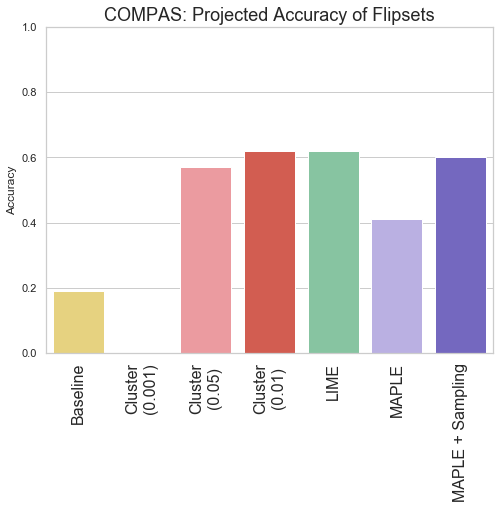

In [185]:
compas_nn2 = MLPClassifier()

compas_data2 = get_data(compas_X, compas_y, test_size = 0.3)

ohe_compas_X_train2, _ = ohe(compas_data2['X_train'], compas_categorical_names, compas_enc)
ohe_compas_X_val2, _ = ohe(compas_data2['X_val'], compas_categorical_names, compas_enc)
ohe_compas_X_test2, _ = ohe(compas_data2['X_test'], compas_categorical_names, compas_enc)

compas_nn2.fit(ohe_compas_X_train2, compas_data2['y_train']) 
print("validation score: ", round(compas_nn2.score(ohe_compas_X_val2, compas_data2['y_val']), 2))
test_preds2 = pd.Series(compas_nn.predict(ohe_compas_X_test2))
print("test predictions split: ")
print(test_preds2.value_counts())

compas_nn_stats2 = run_all("V3_featselectionauto_3_30_ohe_final_compas_nn2.txt", compas_nn2, compas_enc, compas_data2, \
                          compas_categorical_features, compas_categorical_names)

order = ['baseline', 'cluster_0.001', 'cluster_0.05', 'cluster_0.01', 'lime', 'maple', 'maple_sampled']
names = ['Baseline', 'Cluster\n(0.001)', 'Cluster\n(0.05)', 'Cluster\n(0.01)', 'LIME', 'MAPLE', 'MAPLE + Sampling']

color_orders = ['#F7DC6F', '#f7b7d9', '#f98d94', '#E74C3C', '#7DCEA0', '#b5a8ea','#6a5acd']

plot_metric(compas_nn_stats2, 'recourse_accuracy_all', order, "COMPAS: Projected Accuracy of Flipsets", names, colors = color_orders)


In [147]:
# RANDOM FOREST

compas_rf = RandomForestClassifier()

compas_rf.fit(ohe_compas_X_train, compas_data['y_train']) 
print("validation score: ", round(compas_rf.score(ohe_compas_X_val, compas_data['y_val']), 2))
test_preds = pd.Series(compas_rf.predict(ohe_compas_X_test))
print("test predictions split: ")
print(test_preds.value_counts())

validation score:  0.82
test predictions split: 
 1    595
-1     89
dtype: int64


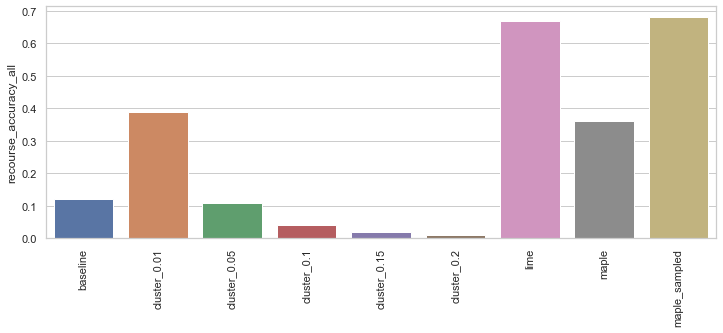

In [119]:
# compas_rf_stats = run_all("V23_29_ohe_final_compas_rf.txt", compas_rf, compas_enc, compas_data, \
#                           compas_categorical_features, compas_categorical_names)

order = ['baseline', 'cluster_0.01', 'cluster_0.05', 'cluster_0.1', 'cluster_0.15', \
             'cluster_0.2', 'lime', 'maple', 'maple_sampled']

plot_metric(compas_rf_stats, 'recourse_accuracy_all', order)


## German

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lime.explanation
import lime.lime_tabular


# NEURAL NETWORK
 
german_nn = MLPClassifier(hidden_layer_sizes=(100), max_iter = 1000)

german_data = get_data(german_X, german_y, test_size = 0.5)

ohe_german_X_train, _ = ohe(german_data['X_train'], german_categorical_names, german_enc)
ohe_german_X_val, _ = ohe(german_data['X_val'], german_categorical_names, german_enc)
ohe_german_X_test, _ = ohe(german_data['X_test'], german_categorical_names, german_enc)

train_stddev = ohe_german_X_train[ohe_german_X_train.columns[:]].std()
train_mean = ohe_german_X_train[ohe_german_X_train.columns[:]].mean()

for feat in german_categorical_features:
    train_mean[feat] = 0
    train_stddev[feat] = 1

# Normalize to have mean 0 and variance 1
norm_X_train = (ohe_german_X_train - train_mean) / train_stddev
norm_X_val = (ohe_german_X_val - train_mean) / train_stddev
norm_X_test = (ohe_german_X_test - train_mean) / train_stddev

german_nn.fit(norm_X_train, german_data['y_train']) 
print("validation score: ", round(german_nn.score(norm_X_val, german_data['y_val']), 2))
test_preds = pd.Series(german_nn.predict(norm_X_test))
print("test predictions split: ")
print(test_preds.value_counts())

validation score:  0.73
test predictions split: 
 1    128
-1     37
dtype: int64


In [47]:
run_all("3_28_ohe_final_german_nn.txt", german_nn, german_enc, german_data, german_categorical_features, \
        german_categorical_names)

num unique preds:  2
 1    88
-1    77
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

670

 0  out of  77
time elapsed:  0.00039033889770507814  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
baseline
populating...


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


obtained 20 items in 1.3 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.1520834594730156
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
baseline
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   27   12 2930    2    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.1520834594730156
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.

obtained 20 items in 1.4 seconds
{'Age': 9.0}
{'Age': 8.0, 'LoanAmount': -338.0}
{'Age': 3.0, 'LoanDuration': -7.0, 'LoanAmount': -64.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -11.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -10.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -11.0, 'LoanAmount': -64.0, 'ForeignWorker_1': 1.0}
{'Age': 9.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'LoanAmount': -338.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.1520834594730156
[4.2000e+01 3.6000e+01 1.0477e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
baseline
populating...
ob

obtained 20 items in 1.3 seconds
{'Age': 7.0, 'LoanAmount': -125.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'LoanAmount': -125.0}
{'Age': 7.0, 'LoanDuration': -1.0}
{'Age': 8.0}
{'LoanDuration': -9.0}
{'LoanDuration': -9.0, 'LoanAmount': -125.0}
{'Age': 6.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 5.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 6.0, 'LoanAmount': -125.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 5.0, 'LoanDuration': -1.0, 'LoanAmount': -125.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -7.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -7.0, 'LoanAmount': -125.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 7.0, 'LoanAmount': -125.0, 'ForeignWorker_1': 1.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'LoanAmount': -125.0, 'ForeignWorker_1': 1.0}
{'Age': 7.0, 'LoanDuration': -1.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'HasCoapplicant_1': 1.0}
model_pred:  -1
intercept:  -0.1520834594730156
[3.900e+01 3.600e+0

populating...
obtained 20 items in 1.5 seconds
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.1520834594730156
[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
baseline
populating...
obtained 20 items in 1.4 seconds
[   0    0   32   24 1938    4    3    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.1520834594730156
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+0

obtained 20 items in 1.2 seconds
{'Age': 2.0, 'LoanDuration': -8.0}
{'Age': 6.0, 'LoanDuration': -3.0, 'LoanAmount': -28.0}
{'LoanDuration': -11.0}
{'Age': 9.0}
{'LoanDuration': -11.0, 'LoanAmount': -28.0}
{'Age': 9.0, 'LoanAmount': -28.0}
{'Age': 6.0, 'LoanDuration': -3.0, 'YearsAtCurrentHome': -1.0}
{'Age': 6.0, 'LoanDuration': -3.0, 'LoanAmount': -28.0, 'YearsAtCurrentHome': -1.0}
{'LoanDuration': -11.0, 'YearsAtCurrentHome': -1.0}
{'Age': 9.0, 'YearsAtCurrentHome': -1.0}
{'LoanDuration': -11.0, 'LoanAmount': -28.0, 'YearsAtCurrentHome': -1.0}
{'Age': 9.0, 'LoanAmount': -28.0, 'YearsAtCurrentHome': -1.0}
{'Age': 2.0, 'LoanDuration': -8.0, 'ForeignWorker_1': 1.0}
{'Age': 6.0, 'LoanDuration': -3.0, 'LoanAmount': -28.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -11.0, 'ForeignWorker_1': 1.0}
{'Age': 9.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -11.0, 'LoanAmount': -28.0, 'ForeignWorker_1': 1.0}
{'Age': 9.0, 'LoanAmount': -28.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.152

populating...
obtained 20 items in 1.3 seconds
{'Age': 16.0, 'ForeignWorker_1': 1.0}
{'Age': 16.0, 'LoanAmount': -49.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.1520834594730156
[3.100e+01 2.400e+01 3.161e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
baseline
populating...
obtained 20 items in 1.4 seconds
[   0    1   31   24 3161    4    2    1    1    1    0    0    0    0
    1    1    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.1520834594730156
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e

obtained 20 items in 1.3 seconds
{'Age': 19.0}
model_pred:  -1
intercept:  -0.1520834594730156
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
baseline
populating...
obtained 20 items in 1.4 seconds
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.1520834594730156
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00


obtained 20 items in 1.3 seconds
{'Age': 9.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanAmount': -49.0}
{'Age': 9.0, 'LoanAmount': -49.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'ForeignWorker_1': 1.0}
{'Age': 9.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanAmount': -49.0, 'ForeignWorker_1': 1.0}
{'Age': 9.0, 'LoanAmount': -49.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -11.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -11.0, 'LoanAmount': -49.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.1520834594730156
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
baseline
populati

populating...
obtained 20 items in 1.4 seconds
{'LoanAmount': -5102.0}
{'LoanAmount': -5102.0, 'YearsAtCurrentHome': -1.0}
model_pred:  -1
intercept:  -0.1520834594730156
[3.500e+01 2.400e+01 2.439e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
baseline
populating...
obtained 20 items in 1.4 seconds
{'Age': 3.0, 'ForeignWorker_1': 1.0}
{'Age': 3.0, 'LoanAmount': -69.0, 'ForeignWorker_1': 1.0}
{'Age': 2.0, 'LoanDuration': -1.0, 'LoanAmount': -69.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -4.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -3.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -3.0, 'LoanAmount': -206.0,

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
6

 0  out of  77
time elapsed:  0.0007268985112508138  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
0
populating...
obtained 20 items in 1.5 seconds
{'Age': 29.0, 'LoanDuration': -30.0, 'LoanAmount': -4343.0}
{'Age': 29.0, 'LoanDuration': -30.0, 'LoanAmount': -4343.0, 'ForeignWorker_1': 1.0}
{'Age': 29.0, 'LoanDuration': -30.0, 'LoanAmount': -4343.0, 'HasCoapplicant_1': 1.0}
{'Age': 29.0, 'LoanDuration': -30.0, 'LoanAmount': -4343.0, 'NoCurrentLoan_1': 1.0}
{'Age': 29.0, 'LoanDuration': -30.0, 'LoanAmount': -4343.0, 'HasGuarantor_1': 1.0}
{'Age': 29.0, 'LoanDurati

obtained 20 items in 1.4 seconds
{'Age': 2.0, 'ForeignWorker_1': 1.0}
{'Age': 2.0, 'LoanAmount': -1.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': -138.0, 'ForeignWorker_1': 1.0}
{'Age': 2.0, 'LoanDuration': -1.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.21802470610209873
[2.800e+01 3.600e+01 5.371e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
0
populating...
obtained 20 items in 1.5 seconds
{'Age': 30.0, 'LoanDuration': -30.0, 'LoanAmount': -4645.0}
{'Age': 28.0, 'LoanDuration': -30.0, 'LoanAmount': -4919.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 29.0, 'Loa

obtained 20 items in 1.0 seconds
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 36.0, 'LoanDuration': -30.0, 'LoanAmount': -3311.0, 'HasCoapplicant_1': -1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0, 'ForeignWorker_1': 1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0, 'NoCurrentLoan_1': 1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0, 'HasGuarantor_1': 1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0, 'Unemployed_1': 1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0, 'CheckingAccountBalance-geq-200_1': 1.0}
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanAmount': -5640.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -5503.0, 'MissedPayments_0': 1.0}
{'Age': 37.0, 'LoanDuration': -30.0, 'LoanAmount': -5640.0, 'YearsAtCurrentHome': -1.0}
{'Age': 36.0, 'LoanDuration

obtained 20 items in 1.0 seconds
{'Age': 7.0, 'LoanAmount': -125.0}
{'Age': 7.0, 'LoanDuration': -1.0}
{'Age': 8.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'LoanAmount': -262.0}
{'Age': 6.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 5.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -9.0, 'LoanAmount': -399.0}
{'Age': 5.0, 'LoanAmount': -262.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 5.0, 'LoanDuration': -1.0, 'LoanAmount': -125.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -8.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -8.0, 'LoanAmount': -125.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 7.0, 'LoanAmount': -125.0, 'ForeignWorker_1': 1.0}
{'Age': 7.0, 'LoanDuration': -1.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'ForeignWorker_1': 1.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'LoanAmount': -262.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'HasCoapplicant_1': 1.0}
model_pred:  -1
intercept:  -0.21802470610209873
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 

obtained 20 items in 1.3 seconds
{'Age': 15.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0}
{'Age': 16.0, 'LoanDuration': -11.0}
{'Age': 14.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 14.0, 'LoanDuration': -11.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 25.0}
{'Age': 22.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 25.0, 'LoanAmount': -57.0}
{'Age': 23.0, 'LoanAmount': -194.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 15.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'ForeignWorker_1': 1.0}
{'Age': 16.0, 'LoanDuration': -11.0, 'ForeignWorker_1': 1.0}
{'Age': 14.0, 'LoanDuration': -12.0, 'Unemployed_1': -1.0}
{'Age': 14.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'Unemployed_1': -1.0}
{'Age': 14.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -1.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.04169460685280213
[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00

obtained 20 items in 1.0 seconds
{'Age': 33.0, 'LoanDuration': -30.0, 'LoanAmount': -3461.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'LoanAmount': -3461.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 33.0, 'LoanDuration': -30.0, 'LoanAmount': -3187.0, 'YearsAtCurrentHome': -1.0}
{'Age': 36.0, 'LoanDuration': -30.0, 'LoanAmount': -1680.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0}
{'Age': 42.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 41.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0}
{'Age': 42.0, 'LoanDuration': -30.0, 'YearsAtCurrentHome': -1.0}
{'Age': 43.0, 'LoanDuration': -30.0}
{'Age': 35.0, 'LoanDuration': -30.0, 'LoanAmount': -447.0, 'CheckingAccountBalance-geq-200_1': -1.0}
{'Age': 37.0, 'LoanDuration': -29.0, 'CheckingAccountBalance-geq-200_1': -1.0}
{'Age': 35.0, 'LoanDuration': -30.0, 'LoanAmount': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-200_1': -1.0}
{'Age': 36.0

populating...
obtained 20 items in 1.3 seconds
{'Age': 19.0, 'LoanAmount': -108.0}
{'Age': 6.0, 'LoanDuration': -18.0, 'LoanAmount': -245.0}
{'Age': 7.0, 'LoanDuration': -18.0}
{'Age': 20.0}
{'LoanDuration': -18.0, 'LoanAmount': -2711.0}
{'Age': 19.0, 'LoanAmount': -108.0, 'YearsAtCurrentHome': -1.0}
{'Age': 17.0, 'LoanDuration': -2.0, 'LoanAmount': -245.0, 'YearsAtCurrentHome': -1.0}
{'Age': 17.0, 'LoanDuration': -3.0, 'YearsAtCurrentHome': -1.0}
{'Age': 20.0, 'YearsAtCurrentHome': -1.0}
{'LoanDuration': -18.0, 'LoanAmount': -2574.0, 'YearsAtCurrentHome': -1.0}
{'Age': 19.0, 'LoanAmount': -108.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 17.0, 'LoanDuration': -3.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 6.0, 'LoanDuration': -18.0, 'LoanAmount': -245.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 20.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 19.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'LoanDuration': -18.0, 'LoanAmount': -2711.0, 'NumberOfOtherLoansAtBank': 

obtained 20 items in 1.1 seconds
{'Age': 13.0, 'LoanAmount': -126.0, 'ForeignWorker_1': 1.0}
{'Age': 14.0, 'ForeignWorker_1': 1.0}
{'Age': 13.0, 'LoanDuration': -1.0, 'ForeignWorker_1': 1.0}
{'Age': 12.0, 'LoanDuration': -1.0, 'LoanAmount': -263.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -18.0, 'LoanAmount': -263.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.21802470610209873
[3.300e+01 4.800e+01 4.844e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
cluster_train
0
populating...
obtained 20 items in 1.2 seconds
{'Age': 25.0, 'LoanDuration': -42.0, 'LoanAmount': -4118.0}
{'Age': 23.0, 'LoanDuration': -42.0, 

obtained 20 items in 1.3 seconds
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanAmount': -7339.0}
{'Age': 33.0, 'LoanDuration': -30.0, 'LoanAmount': -7339.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 33.0, 'LoanDuration': -30.0, 'LoanAmount': -7476.0, 'YearsAtCurrentHome': -1.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'LoanAmount': -7476.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0}
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanAmount': -7339.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 33.0, 'LoanDuration': -30.0, 'LoanAmount': -7339.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 33.0, 'LoanDuration': -30.0, 'LoanAmount': -7476.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'LoanAmount': -7476.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanAmount': -7339.0, 'ForeignWorker_1': 1.0}
{'Age': 34.0, '

[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
0
populating...
obtained 20 items in 1.3 seconds
{'Age': 35.0, 'LoanDuration': -54.0, 'LoanAmount': -9555.0}
{'Age': 34.0, 'LoanDuration': -54.0, 'LoanAmount': -9555.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 35.0, 'LoanDuration': -54.0, 'LoanAmount': -9555.0, 'ForeignWorker_1': 1.0}
{'Age': 35.0, 'LoanDuration': -54.0, 'LoanAmount': -9555.0, 'HasCoapplicant_1': 1.0}
{'Age': 35.0, 'LoanDuration': -54.0, 'LoanAmount': -9555.0, 'NoCurrentLoan_1': 1.0}
{'Age': 35.0, 'LoanDuration': -54.0,

obtained 20 items in 1.2 seconds
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.31548759226530976
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
0
populating...
obtained 20 items in 1.1 seconds
{'Age': 28.0, 'LoanDuration': -21.0, 'LoanAmount': -3321.0}
{'Age': 30.0, 'LoanDuration': -21.0, 'LoanAmount': -2362.0, 'YearsAtCurrentHome': -1.0}
{'Age': 37.0, 'LoanDuration': -21.0, 'YearsAtCurrentHome': -1.0}
{'Age': 28.0, 'LoanDuration': -21.0, 'LoanAmount': -3321

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
33

 0  out of  77
time elapsed:  0.0014307339986165365  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
19
populating...
obtained 20 items in 1.1 seconds
{'Age': 24.0, 'LoanDuration': -30.0, 'LoanAmount': -4206.0}
{'Age': 38.0, 'LoanDuration': -30.0}
{'Age': 25.0, 'LoanDuration': -30.0, 'LoanAmount': -918.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 28.0, 'LoanDuration': -30.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 24.0, 'LoanDuration': -30.0, 'LoanAmount': -4206.0, 'ForeignWorker_1': 1.0}
{'Age': 24.0, 'LoanDuration': -30.0, 'LoanAmount': -4206.0, 'HasCoapplican

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'LoanDuration': -13.0}
{'LoanDuration': -13.0, 'LoanAmount': -60.0}
{'Age': 1.0, 'LoanDuration': -13.0}
{'Age': 1.0, 'LoanDuration': -12.0, 'LoanAmount': -197.0}
{'LoanDuration': -12.0, 'NumberOfOtherLoansAtBank': -1.0}
{'LoanDuration': -11.0, 'LoanAmount': -197.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 27.0, 'LoanAmount': -2526.0}
{'Age': 1.0, 'LoanDuration': -12.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 1.0, 'LoanDuration': -11.0, 'LoanAmount': -197.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 20.0, 'LoanAmount': -2526.0, 'NumberOfOtherLoansAtBank': -1.0}
{'LoanDuration': -13.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -13.0, 'LoanAmount': -60.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -13.0, 'HasCoapplicant_1': 1.0}
{'LoanDuration': -13.0, 'LoanAmount': -60.0, 'HasCoapplicant_1': 1.0}
{'Age': 1.0, 'LoanDuration': -13.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -12.0, 'LoanAmount': -197.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'Loan

obtained 20 items in 1.1 seconds
{'Age': 32.0, 'LoanAmount': -2227.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 32.0, 'LoanDuration': -1.0, 'LoanAmount': -2227.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 34.0, 'LoanAmount': -2090.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 34.0, 'LoanDuration': -1.0, 'LoanAmount': -2090.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 31.0, 'LoanAmount': -2090.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 31.0, 'LoanDuration': -1.0, 'LoanAmount': -2090.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 35.0, 'LoanAmount': -2090.0, 'LoanRateAsPercentOfIncome': -3.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
{'Age': 23.0, 'LoanAmount': -5041.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'MissedPayments_1': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 23.0, 'LoanDuration': -1.0, 'LoanAmount': -5041.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'MissedPayments_1': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 23.0, 'LoanAmount': -6959.0, 'NumberOfLiableIndividuals': 1.0, 'MissedPayments_1': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 23.0, 'LoanDuration': -1.0, 'LoanAmount': -6959.0, 'NumberOfLiableIndividuals': 1.0, 'MissedPayments_1': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 28.0, 'LoanDuration': -1.0, 'LoanAmount': -7233.0, 'LoanRateAsPercentOfIncome': -1.0, 'MissedPayments_1': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 29.0, 'LoanAmount': -6959.0, 'LoanRateAsPerce

23
populating...
obtained 20 items in 1.3 seconds
{'Age': 39.0}
{'Age': 39.0, 'LoanAmount': -80.0}
{'Age': 39.0, 'LoanDuration': -1.0}
{'Age': 39.0, 'LoanDuration': -1.0, 'LoanAmount': -80.0}
{'Age': 15.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 15.0, 'LoanAmount': -80.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 15.0, 'LoanDuration': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 15.0, 'LoanDuration': -1.0, 'LoanAmount': -80.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 25.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 25.0, 'LoanAmount': -80.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 25.0, 'LoanDuration': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 25.0, 'LoanDuration': -1.0, 'LoanAmount': -80.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 39.0, 'ForeignWorker_1': 1.0}
{'Age': 39.0, 'LoanAmount': -80.0, 'ForeignWorker_1': 1.0}
{'Age': 39.0, 'HasCoapplicant_1': 1.0}
{'Age': 39.0, 'LoanAmount': -80.0, 'HasCoapplicant_1': 1.0}
model_pred:  -1
intercept:  -0.1

obtained 20 items in 1.0 seconds
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.1039317152704965
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
cluster_train
17
populating...
obtained 20 items in 0.9 seconds
{'Age': 3.0, 'LoanDuration': -8.0, 'LoanAmount': -422.0}
{'Age': 9.0, 'LoanAmount': -422.0}
{'Age': 4.0, 'LoanDuration': -9.0}
{'Age': 11.0}
{'Age': 3.0, 'LoanDuration': -8.0, 'LoanAmount': -422.0, 'ForeignWorker_1': 1.0}
{'Age': 9.0, 'LoanAmount': -422.0, 'ForeignWorker_1': 1.0}
{'Age': 4.0, 'LoanDuration': -9.0, 'ForeignWorker_1': 1.0}
{'Age': 3.0, 'LoanDuration': -8.0, 'LoanAmount': -422.0, 'HasCoapplicant_1': 1.0}
{'Age': 9.0, 'LoanAmount': -422.0, 'HasCoapplicant_1': 1.0}
{'Age': 4.0, 'LoanDuration': -9.0, 'H

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.38425354208049367

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
29
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
{'LoanDuration': -16.0}
{'LoanDuration': -16.0, 'LoanAmount': -14.0}
{'Age': 1.0, 'LoanDuration': -16.0}
{'Age': 1.0, 'LoanDuration': -16.0, 'LoanAmount': -14.0}
{'LoanDuration': -16.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -16.0, 'LoanAmount': -14.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -16.0, 'HasCoapplicant_1': 1.0}
{'LoanDuration': -16.0, 'LoanAmount': -14.0, 'HasCoapplicant_1': 1.0}
{'Age': 1.0, 'LoanDuration': -16.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -16.0, 'LoanAmount': -14.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -16.0, 'HasCoapplicant_1': 1.0}
{'Age': 1.0, 'LoanDuration': -16.0, 'LoanAmount': -14.0, 'HasCoapplicant_1': 1.0}
{'LoanDuration': -16.0, 'HasGuarantor_1': 1.0}
{'LoanDuration': -16.0, 'LoanAmount': -14.0, 'HasGuarantor_1': 1.0}
{'LoanDuration': -16.0, 'Unemployed_1': 1.0}
{'LoanDuration': -16.0, 'LoanAmount': -14.0, 'Unemployed_1': 1.0}
model_pred:  -1
intercept:  0.20235675717077628
[2.30e+01 2

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.1 seconds
{'LoanDuration': -13.0, 'LoanAmount': -116.0}
{'LoanDuration': -14.0}
{'Age': 1.0, 'LoanDuration': -13.0}
{'Age': 1.0, 'LoanDuration': -13.0, 'LoanAmount': -116.0}
{'LoanDuration': -13.0, 'LoanAmount': -116.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -14.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -13.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -13.0, 'HasCoapplicant_1': 1.0}
{'Age': 1.0, 'LoanDuration': -13.0, 'LoanAmount': -116.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -13.0, 'LoanAmount': -116.0, 'HasCoapplicant_1': 1.0}
{'LoanDuration': -13.0, 'LoanAmount': -116.0, 'HasGuarantor_1': 1.0}
{'LoanDuration': -14.0, 'HasGuarantor_1': 1.0}
{'Age': 1.0, 'LoanDuration': -13.0, 'HasGuarantor_1': 1.0}
model_pred:  -1
intercept:  0.20235675717077628
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00

obtained 20 items in 0.9 seconds
[   0    0   20   12 1282    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.1039317152704965
[2.800e+01 3.000e+01 5.234e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
cluster_train
19
populating...
obtained 20 items in 1.2 seconds
{'Age': 26.0, 'LoanDuration': -24.0, 'LoanAmount': -4508.0}
{'Age': 25.0, 'LoanDuration': -24.0, 'LoanAmount': -4782.0, 'YearsAtCurrentHome': -1.0}
{'Age': 25.0, 'LoanDuration': -24.0, 'LoanAmount': -4782.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 25.0, 'LoanDuration

obtained 20 items in 1.0 seconds
{'Age': 7.0, 'LoanDuration': -14.0}
{'Age': 7.0, 'LoanDuration': -14.0, 'LoanAmount': -28.0}
{'Age': 17.0, 'LoanAmount': -165.0}
{'Age': 18.0}
{'LoanDuration': -15.0, 'LoanAmount': -2083.0}
{'Age': 7.0, 'LoanDuration': -14.0, 'YearsAtCurrentHome': -1.0}
{'Age': 7.0, 'LoanDuration': -14.0, 'LoanAmount': -28.0, 'YearsAtCurrentHome': -1.0}
{'Age': 17.0, 'LoanAmount': -165.0, 'YearsAtCurrentHome': -1.0}
{'Age': 18.0, 'YearsAtCurrentHome': -1.0}
{'LoanDuration': -15.0, 'LoanAmount': -2083.0, 'YearsAtCurrentHome': -1.0}
{'Age': 3.0, 'LoanDuration': -14.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 3.0, 'LoanDuration': -14.0, 'LoanAmount': -28.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 14.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 14.0, 'LoanAmount': -28.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanDuration': -15.0, 'LoanAmount': -850.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 3.0, 'LoanDuration': -14.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': 1.

obtained 20 items in 1.1 seconds
{'Age': 35.0, 'LoanAmount': -5862.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 35.0, 'LoanDuration': -1.0, 'LoanAmount': -5862.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 38.0, 'LoanAmount': -5725.0, 'LoanRateAsPercentOfIncome': -3.0, 'OtherLoansAtBank_1': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 38.0, 'LoanDuration': -1.0, 'LoanAmount': -5725.0, 'LoanRateAsPercentOfIncome': -3.0, 'OtherLoansAtBank_1': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 34.0, 'LoanAmount': -5862.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 34.0, 'LoanDuration': -1.0, 'LoanAmount': -5862.0, 'LoanRateAsPercentOfIncome':

obtained 20 items in 1.0 seconds
{'LoanDuration': -18.0}
{'Age': 1.0, 'LoanDuration': -18.0}
{'Age': 1.0, 'LoanDuration': -17.0, 'LoanAmount': -106.0}
{'LoanDuration': -18.0, 'YearsAtCurrentHome': 1.0}
{'Age': 1.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': 1.0}
{'Age': 1.0, 'LoanDuration': -17.0, 'LoanAmount': -106.0, 'YearsAtCurrentHome': 1.0}
{'LoanDuration': -18.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  0.20235675717077628
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
17
populating...
obtained 20 items in 1.3 seconds
{'Age': 12.0, 'LoanDuration': -11.0, 'Loan

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.38425354208049367
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
32
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 28.0, 'LoanAmount': -6229.0, 'MissedPayments_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 28.0, 'LoanDuration': -1.0, 'LoanAmount': -6229.0, 'MissedPayments_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 21.0, 'LoanAmount': -2119.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'MissedPayments_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 20.0, 'LoanDuration': -1.0, 'LoanAmount': -2393.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'MissedPayments_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 22.0, 'LoanAmount': -2667.0, 'LoanRateAsPercentOfIncome': -3.0, 'MissedPayments_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 22.0, 'LoanDuration': -1.0, 'LoanAmount': -2667.0, 'LoanRateAsPercentOfIncome': -3.0, 'MissedPayments_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 27.0, 'CheckingAccountBalance-geq-0_1': -

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.31441962031410003
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
24
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 38.0, 'LoanAmount': -2360.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'LoanDuration': -1.0, 'LoanAmount': -2360.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanAmount': -2223.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanAmount': -2360.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 33.0, 'LoanDuration': -1.0, 'LoanAmount': -2223.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -1.0, 'LoanAmount': -2360.0, 'LoanRateAsPercentOfIncome': -1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.1039317152704965
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
30
populating...
obtained 20 items in 1.0 seconds
{'LoanDuration': -8.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 2.0, 'SavingsAccountBalance-geq-100_0': -1.0}
{'LoanDuration': -8.0, 'LoanAmount': 14.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 2.0, 'SavingsAc

obtained 20 items in 1.2 seconds
{'Age': 2.0, 'LoanDuration': -12.0}
{'Age': 1.0, 'LoanDuration': -12.0, 'LoanAmount': -208.0}
{'Age': 8.0, 'LoanAmount': -893.0}
{'LoanDuration': -12.0, 'LoanAmount': -619.0}
{'Age': 11.0}
{'Age': 2.0, 'LoanDuration': -12.0, 'YearsAtCurrentHome': -1.0}
{'Age': 1.0, 'LoanDuration': -12.0, 'LoanAmount': -208.0, 'YearsAtCurrentHome': -1.0}
{'Age': 8.0, 'LoanAmount': -893.0, 'YearsAtCurrentHome': -1.0}
{'LoanDuration': -12.0, 'LoanAmount': -619.0, 'YearsAtCurrentHome': -1.0}
{'Age': 11.0, 'YearsAtCurrentHome': -1.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 4.0, 'LoanAmount': -893.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 7.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'LoanAmount': -71.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanDuration': -9.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanDuration': -9.0, 'LoanAmount': -71.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'YearsAtCu

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.2887266365849228
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
8
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   20   12 1107    2    2    1    2    1    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.1039317152704965
[2.600e+01 2.400e+01 3.235e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
24
populating...
obtained 20 items in 1.1 seconds
{'Age': 39.0, 'LoanAmount': -2646.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -1.0, '

obtained 20 items in 0.9 seconds
[   0    0   35   24 2439    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2887266365849228

 75  out of  77
[ 27.  24. 937.   4.   3.   2.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
cluster_train
23
populating...
obtained 20 items in 1.0 seconds
{'Age': 31.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0}
{'Age': 31.0, 'LoanAmount': -74.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0}
{'Age': 30.0, 'LoanDuration': -2.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0}
{'Age': 30.0, 'LoanDuration': -1.0, 'LoanAmount': -485.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0}
{'Age': 22.0, 'YearsAtCurrentHome': -2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 22.0,

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
67

 0  out of  77
time elapsed:  0.00546411673227946  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
57
populating...
obtained 20 items in 1.4 seconds
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanAmount': -4343.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 37.0, 'LoanDuration': -30.0, 'LoanAmount': -4343.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 36.0, 'LoanDuration': -29.0, 'LoanAmount': -4343.0, 'LoanRateAsPer

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'LoanDuration': -18.0, 'LoanAmount': -2389.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': -1.0, 'LoanDuration': -18.0, 'LoanAmount': -2252.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': -2.0, 'LoanDuration': -18.0, 'LoanAmount': -2526.0, 'isMale': -1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': -4.0, 'LoanDuration': -18.0, 'LoanAmount': -2526.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0}
{'LoanDuration': -16.0, 'NumberOfOtherLoansAtBank': -1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'LoanDuration': -16.0, 'LoanAmount': -60.0, 'NumberOfOtherLoansAtBank': -1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'MissedPayments_0': -1.0

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 5371    3    2    2    1    0    0    0    0    0
    1    0    1    0    0    1    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.06993158217143225
[2.600e+01 6.000e+00 3.518e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
34
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   26    6 3518    2    3    1    1    0    0    0    0    0
    1    0    0    0    0    1    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  0.03404675962747683
[2.900e+01 2.400e+01 2.679e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
65
populating...
obtained 20 items in 1.3 seconds
{'Age': 37.0, 'LoanAmount': 787.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanDuration': 1.0, 'LoanAmount': 787.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.3702697583896184
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
59
populating...
obtained 20 items in 1.0 seconds
{'Age': 25.0, 'LoanDuration': -18.0, 'LoanAmount': -375.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -2.0}
{'Age': 26.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -2.0}
{'Age': 23.0, 'LoanDuration': -18.0, 'LoanAmount': -7362.0, 'YearsAtCurrentHome'

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.3926884209239361
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK



cluster_train
19
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.2615705850195431


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
57
populating...
obtained 20 items in 1.1 seconds
{'Age': 39.0, 'LoanDuration': -29.0, 'LoanAmount': -3143.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 40.0, 'LoanDuration': -30.0, 'LoanAmount': -3143.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 40.0, 'LoanDuration': -30.0, 'LoanAmount': -3143.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.3 seconds
{'Age': 42.0, 'LoanAmount': 11520.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'SavingsAccountBalance-geq-500_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'SavingsAccountBalance-geq-500_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor

obtained 20 items in 1.0 seconds
{'Age': 35.0, 'LoanAmount': -1430.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 28.0, 'LoanAmount': -1430.0, 'JobClassIsSkilled': -1.0}
{'Age': 35.0, 'LoanAmount': -1430.0, 'YearsAtCurrentHome': -3.0}
{'Age': 35.0, 'LoanDuration': -1.0, 'LoanAmount': -1430.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 28.0, 'LoanDuration': -1.0, 'LoanAmount': -1430.0, 'JobClassIsSkilled': -1.0}
{'Age': 35.0, 'LoanDuration': -1.0, 'LoanAmount': -1430.0, 'YearsAtCurrentHome': -3.0}
{'Age': 34.0, 'JobClassIsSkilled': -1.0}
{'Age': 39.0, 'LoanAmount': -1430.0, 'RentsHouse_1': -1.0}
{'Age': 34.0, 'LoanDuration': -1.0, 'JobClassIsSkilled': -1.0}
{'Age': 39.0, 'LoanDuration': -1.0, 'LoanAmount': -1430.0, 'RentsHouse_1': -1.0}
{'Age': 40.0, 'LoanDuration': -4.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 33.0, 'LoanAmount': -1293.0, 'MissedPayments_1': -1.0}
{'Age': 40.0, 'LoanDuration': -5.0, 'YearsAtCurrentHome': -3.0}
{'Age': 32.0, 'LoanDuration': -2.0, 'LoanAmount': -1430.0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.38425354208049367

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
21
populating...
obtained 20 items in 1.0 seconds
{'Age': -7.0, 'LoanDuration': -18.0, 'LoanAmount': -2617.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.3302849100986571


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
21
populating...
obtained 20 items in 1.0 seconds
{'LoanDuration': -11.0, 'LoanAmount': -116.0, 'NumberOfLiableIndividuals': 1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'LoanDuration': -12.0, 'NumberOfLiableIndividuals': 1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'LoanDuration': -18.0, 'LoanAmount': -390.0, 'NumberOfLiableIndividuals': 1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   20 7057    3    4    2    2    1    1    0    0    0
    0    0    0    1    0    0    0    1    0    0    1    1    1]
model_pred:  -1
intercept:  -0.14882609624579773
[2.400e+01 1.200e+01 1.768e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
53
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
{'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'LoanAmount': -83.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'LoanAmount': -1316.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'Re

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  -0.1805155831291566
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
20
populating...
obtained 20 items in 1.0 seconds
{'Age': 13.0}
{'Age': 12.0, 'LoanAmount': -212.0}
{'Age': 11.0, 'LoanDuration': -1.0, 'LoanAmount': -349.0}
{'Age': 8.0, 'YearsAtCurrentHome': -1.0}
{'Age': 7.0, 'LoanDuration': -1.0, 'LoanAmount': -75.0, 'YearsAtCurrentHome': -1.0}
{'Age': 13.0, 'LoanDuration': -

obtained 20 items in 1.2 seconds
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 2.0, 'RentsHouse_1': -1.0}
model_pred:  -1
intercept:  -0.1805155831291566
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
28
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2612026894551658
[2.300e+01 1.500e+01 1.444

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.3 seconds
{'Age': 40.0, 'LoanAmount': 12160.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 40.0, 'LoanDuration': -1.0, 'LoanAmount': 12160.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanAmount': 11886.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanDuration': -1.0, 'LoanAmount': 11886.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -

populating...
obtained 20 items in 1.3 seconds
{'Age': 20.0, 'LoanAmount': -1383.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0}
{'Age': 20.0, 'LoanDuration': -1.0, 'LoanAmount': -1246.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0}
{'Age': 25.0, 'LoanAmount': -1383.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 25.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0}
{'Age': 25.0, 'LoanDuration': -1.0, 'LoanAmount': -1383.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 25.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0}
{'Age': 31.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 30.0, 'LoanDuration': -2.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 30.0, 'LoanAmount': -1383.0, 'YearsAtCurrentHome': -1.0}
{'Age': 30.0, 'LoanDuration': -1.0, 'LoanAmount': -1383.0, 'YearsAtCurrentHome': -1.0}
{'Age': 35.0, 'LoanAmount': -1383.0}
{'Age': 35.0, 'LoanDuration': -1.0, 'LoanAmount': -1383.0}
{'Age': 36.0, 'YearsA

obtained 20 items in 1.3 seconds
{'Age': 35.0, 'LoanAmount': -3057.0, 'HasGuarantor_1': -1.0}
{'Age': 35.0, 'LoanDuration': -1.0, 'LoanAmount': -3057.0, 'HasGuarantor_1': -1.0}
{'Age': 36.0, 'LoanAmount': -2920.0, 'YearsAtCurrentJob-geq-4': -1.0}
{'Age': 35.0, 'LoanDuration': -3.0, 'LoanAmount': -3057.0, 'YearsAtCurrentJob-geq-4': -1.0}
{'Age': 32.0, 'LoanAmount': -3057.0, 'JobClassIsSkilled': -1.0}
{'Age': 32.0, 'LoanDuration': -1.0, 'LoanAmount': -3057.0, 'JobClassIsSkilled': -1.0}
{'Age': 38.0, 'LoanDuration': -4.0, 'LoanAmount': -3057.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 39.0, 'LoanAmount': -2920.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 35.0, 'LoanAmount': -2920.0, 'NumberOfOtherLoansAtBank': 1.0, 'HasGuarantor_1': -1.0}
{'Age': 35.0, 'LoanDuration': -1.0, 'LoanAmount': -2920.0, 'NumberOfOtherLoansAtBank': 1.0, 'HasGuarantor_1': -1.0}
{'Age': 36.0, 'LoanAmount': -3057.0, 'MissedPayments_1': -1.0}
{'Age': 36.0, 'LoanDuration': -1.0, 'LoanAmount': -3057.0, 'MissedPaymen

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


65
populating...
obtained 20 items in 1.2 seconds
{'Age': 41.0, 'LoanAmount': 1518.0, 'LoanRateAsPercentOfIncome': -3.0, 'Unemployed_0': -1.0}
{'Age': 41.0, 'LoanDuration': 1.0, 'LoanAmount': 1518.0, 'LoanRateAsPercentOfIncome': -3.0, 'Unemployed_0': -1.0}
{'Age': 39.0, 'LoanAmount': 559.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'Unemployed_0': -1.0}
{'Age': 39.0, 'LoanDuration': 1.0, 'LoanAmount': 559.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'Unemployed_0': -1.0}
{'Age': 40.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'Unemployed_0': -1.0}
{'Age': 40.0, 'LoanDuration': 1.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'Unemployed_0': -1.0}
{'Age': 41.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 41.0, 'LoanAmount': 11.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 4

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3702697583896184
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
57
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 37.0, 'LoanDuration': -23.0, 'LoanAmount': -1881.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 38.0, 'LoanDuration': -24.0, 'LoanAmount': -1881.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 38.0, 'LoanDuration': -24.0, 'LoanAmount': -1881.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 'HasCoapplicant_0': -1.0}
{'Age': 34.0, 'LoanDuration': -24.0, 'LoanAmount': -1881.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 33.0, 'LoanDuration': -23.0, 'LoanAmount': -1881.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 34.0, 'LoanDuration': -24.0, 'LoanAmount': -1881.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCur

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 36.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 36.0, 'LoanAmount': 106.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 36.0, 'LoanDuration': 1.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 36.0, 'LoanDuration': 1.0, 'LoanAmount': 106.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 37.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 37.0, 'LoanAmount': 106.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 37.0, 'LoanDuration': 1.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 37.0, 'LoanDuration': 1.0, 'LoanAmount': 106.0,

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.03404675962747683
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
10
populating...
obtained 20 items in 1.0 seconds
{'LoanDuration': -8.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 2.0, 'SavingsAccountBalance-geq-100_0': -1.0}
{'LoanDuration': -8.0, 'LoanAmount': 14.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 2.0, 'SavingsAc

obtained 20 items in 1.1 seconds
{'Age': 31.0, 'LoanAmount': -3147.0}
{'Age': 31.0, 'LoanDuration': -1.0, 'LoanAmount': -3147.0}
{'Age': 31.0, 'LoanAmount': -3010.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 31.0, 'LoanDuration': -1.0, 'LoanAmount': -3010.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 42.0, 'LoanDuration': -15.0}
{'Age': 20.0, 'LoanAmount': -3010.0, 'RentsHouse_1': -1.0}
{'Age': 13.0, 'LoanAmount': -3010.0, 'YearsAtCurrentJob-geq-4': -1.0}
{'Age': 20.0, 'LoanDuration': -1.0, 'LoanAmount': -3010.0, 'RentsHouse_1': -1.0}
{'Age': 13.0, 'LoanDuration': -1.0, 'LoanAmount': -3010.0, 'YearsAtCurrentJob-geq-4': -1.0}
{'Age': 25.0, 'YearsAtCurrentJob-geq-4': -1.0}
{'Age': 16.0, 'LoanAmount': -3010.0, 'YearsAtCurrentHome': -3.0}
{'Age': 25.0, 'LoanDuration': -1.0, 'YearsAtCurrentJob-geq-4': -1.0}
{'Age': 16.0, 'LoanDuration': -1.0, 'LoanAmount': -3010.0, 'YearsAtCurrentHome': -3.0}
{'Age': 32.0, 'RentsHouse_1': -1.0}
{'Age': 31.0, 'LoanAmount': -3147.0, 'ForeignWorker_1': 1.0}
{'Age

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.069499884587502
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
3
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   20   12 1107    2    2    1    2    1    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  0.03404675962747683
[2.600e+01 2.400e+01 3.235e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
65
populating...
obtained 20 items in 1.4 seconds
{'Age': 37.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 37.0, 'LoanAmount': 94.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 37.0, 'LoanDuration': -20.0, 'LoanAmount': -5513.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 38.0, 'LoanDuration': -21.0, 'LoanAmount': -5513.0, 'NoCurrentLoan_0': -1.0}
{'Age': 38.0, 'LoanDuration': -21.0, 'LoanAmount': -5513.0, 'YearsAtCurrentHome': 1.0, 'HasCoapplicant_0': -1.0}
{'Age': 35.0, 'LoanDuration': -21.0, 'LoanAmount': -5513.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 36.0, 'LoanDuration': -21.0, 'LoanAmount': -5513.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 36.0, 'LoanDuration': -21.0, 'LoanAmount': -5513.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 'HasCoapplicant_0': -1.0}
{'Age': 32.0, 'LoanDuration': -21.0, 'LoanAmount': -5513.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 31.0, 'LoanDuration': -20.0, 'LoanAmount': -5513.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_1': -1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.2 seconds
{'Age': 30.0, 'LoanDuration': -18.0, 'LoanAmount': 8650.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
model_pred:  -1
intercept:  -0.0818095271776032
TIME FOR EXP:  4.34503626426061  minutes
num unique preds:  2
 1    88
-1    77
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
100

 0  out of  77
time elapsed:  0.0036273996035257974  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
92
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2876770835606588
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
{'NumberOfLiableIndividuals': 1.0}
{'LoanAmount': 125.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanAmount': 125.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanRateAsPercentOfIncome': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanAmount': 125.0, 'LoanRateAsPercentOfIncome': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 9.0, 'LoanRateAsPercentOfIncome': 1.0, 'JobClassIsSkilled': -1.0}
{'Age': 9.0, 'LoanAmount': 125.0, 'LoanRateAsPercentOfIncome': 1.0, 'JobClassIsSkilled': -1.0}
{'Age': 1.0, 'HasCoapplicant_0': -1.0}
{'Age': 1.0, 'LoanAmount': 125.0, 'HasCoapplicant_0': -1.0}
{'Age': 23.0, 'JobClassIsSkilled': -1.0}
model_pred:  -1
intercept:  -0.003156881828970559
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
{'LoanDuration': -8.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanDuration': -8.0, 'LoanAmount': -60.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': -1.0, 'LoanDuration': -8.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': -1.0, 'LoanDuration': -8.0, 'LoanAmount': -60.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
model_pred:  -1
intercept:  -0.02138110036368035
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
95
populating...
    model=unknown;
        message from solver=<undefin

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


76
populating...
obtained 20 items in 0.9 seconds
{'LoanDuration': -17.0, 'LoanAmount': -1.0, 'Single_1': -1.0, 'RentsHouse_0': -1.0}
{'LoanDuration': -18.0, 'Single_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': -1.0, 'LoanDuration': -17.0, 'Single_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': -1.0, 'LoanDuration': -17.0, 'LoanAmount': -1.0, 'Single_1': -1.0, 'RentsHouse_0': -1.0}
model_pred:  -1
intercept:  -0.02138110036368035
[2.800e+01 3.600e+01 5.371e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
83
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   26    6 3518    2    3    1    1    0    0    0    0    0
    1    0    0    0    0    1    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.011200364841067456
[2.900e+01 2.400e+01 2.679e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
69
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   24 2679    4    1    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
inter

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   42   36 3804    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.024790057593646164
[4.2000e+01 3.6000e+01 1.0477e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
35
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    42    36 10477     2     4     2     1     0     0     0
     0     0     1     0     1     0     0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.3702697583896184
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
72
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'Age': 28.0, 'LoanDuration': 12.0, 'YearsAtCurrentHome': -2.0}
{'Age': 28.0, 'LoanDuration': 12.0, 'LoanAmount': -101.0, 'YearsAtCurrentHome': -2.0}
{'Age': 29.0, 'LoanAmount': -2156.0, 'YearsAtCurrentHome': -2.0}
{'Age': 29.0, 'LoanDuration': 20.0}
{'Age': 29.0, 'LoanDuration': 20.0, 'LoanAmount': -101.0}
{'Age': 30.0, 'YearsAtCurrentHome': -2.0}
model_pred:  -1
intercept:  -0.057076471674904705
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
44
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.3926884209239361
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
14
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.2615705850195431
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
96
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 3595    4    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.38430064427652916
[2.800e+01 3.000e+01 4.249e+03 4.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 4249    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.18121445790498808
[2.000e+01 1.500e+01 2.221e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
29
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 42.0, 'LoanAmount': 11520.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'SavingsAccountBalance-geq-500_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'SavingsAccountBalance-geq-500_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.232157580164086
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
60
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.407201203517612
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
cluster_train
58
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.40564227660041613

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
76
populating...
obtained 20 items in 0.9 seconds
{'LoanDuration': -12.0, 'NumberOfLiableIndividuals': 1.0, 'Single_1': -1.0, 'RentsHouse_0': -1.0}
{'LoanDuration': -12.0, 'LoanAmount': -14.0, 'NumberOfLiableIndividuals': 1.0, 'Single_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': -1.0, 'LoanDuration': -12.0, 'NumberOfLiableIndividuals': 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.3302849100986571


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
76
populating...
obtained 20 items in 1.1 seconds
{'Age': -9.0, 'LoanDuration': -18.0, 'NumberOfLiableIndividuals': 1.0, 'Single_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': -8.0, 'LoanDuration': -18.0, 'LoanAmount': -116.0, 'NumberOfLiableIndividuals': 1.0, 'Single_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
model_pred:  -1
intercept:  -0.02138110036368035
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   20 7057    3    4    2    2    1    1    0    0    0
    0    0    0    1    0    0    0    1    0    0    1    1    1]
model_pred:  -1
intercept:  -0.14882609624579773
[2.400e+01 1.200e+01 1.768e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
36
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'LoanAmount': -83.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'LoanAmount': -1316.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'Re

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  -0.1805155831291566
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
47
populating...
obtained 20 items in 1.1 seconds
[   0    1   28   21 2993    3    2    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.004306198677518469
[2.300e+01 3.600e+01 3.913e+03 2.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2481507154345508
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
47
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'LoanAmount': -2494.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': -2357.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
{'Age': -1.0, 'LoanAmount': -2494.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
{'Age': -1.0, 'LoanDuration': -1.0, 'LoanAmount': -2357.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
{'LoanAmount': -2083.0, 'LoanRateAsPercentOfIncome': -3.0, 'JobClassIsSkilled': -1.0}
{'Age': -1.0, 'LoanAmount': -2083.0, 'LoanRateAsPercentOfIncome': -3.0, 'JobClassIsSkilled': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': -2083.0, 'LoanRateAsPercentOfIncome': -3.0, 'JobClassIsSkilled': -1.0}
{'Age': -1.0, 'LoanDuration': -1.0, 'LoanAmount': -2083.0, 'LoanRateAsPercentOfIncome': -3.0, 'JobClassIsSkilled': -1.0}
{'LoanAmount': -2357.0, 'LoanRateAsPercentOfIncome': -3.0, 'Yea

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 40.0, 'LoanAmount': 12160.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 40.0, 'LoanDuration': -1.0, 'LoanAmount': 12160.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanAmount': 11886.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanDuration': -1.0, 'LoanAmount': 11886.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 6314    4    2    2    1    1    0    0    0    0
    1    0    1    1    1    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.06766469817578535
[2.500e+01 2.100e+01 1.835e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
47

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK



populating...
obtained 20 items in 0.9 seconds
{'LoanAmount': -835.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': -698.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
{'Age': -1.0, 'LoanAmount': -835.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
{'Age': -1.0, 'LoanDuration': -1.0, 'LoanAmount': -698.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0}
model_pred:  -1
intercept:  -0.004306198677518469
[2.600e+01 2.100e+01 3.414e+03 2.000e+00 1.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.1 seconds
[   0    1   31   24 3161    4    2    1    1    1    0    0    0    0
    1    1    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.02138110036368035
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
47
populating...
obtained 20 items in 1.1 seconds
{'LoanDuration': -1.0, 'LoanAmount': -3057.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasGuarantor_1': -1.0}
{'LoanAmount': -3057.0, 'LoanRateAsPercentOfIncome': -3.0, 'ForeignWorker_1': 1.0, 'HasGuarantor_1': -1.0}
{'Age': -1.0, 'LoanAmount': -3057.0, 'Loan

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK



intercept:  -0.2481507154345508
[3.300e+01 4.800e+01 4.844e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
cluster_train
57
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.3129448151955621
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3702697583896184
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
92
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2876770835606588
[3.700e+01 3.600e+01 7.409e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
67
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   37   36 7409    3    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.13396982389361795
[5.7000e+01 3.6000e+01 1.4318e+04 4.000

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.407201203517612
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
68
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   26   24 2812    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.2481507154345508
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
4
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.38021064392772597
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
64
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.011200364841067456
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'Age': 38.0, 'LoanAmount': -186.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanDuration': -1.0, 'LoanAmount': -597.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 38.0, 'LoanDuration': -1.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 39.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 27.0, 'LoanAmount': -186.0, 'YearsAtCurrentHome': -3.0, 'HasTelephone_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 27.0, 'LoanDuration': -1.0, 'LoanAmount': -49.0, 'YearsAtCurrentHome': -3.0, 'HasTelephone_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 28.0, 'YearsAtCurrentHome': -3.0, 'Has

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.013889275675582236
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
58
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   20   12 1107    2    2    1    2    1    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.011200364841067456
[2.600e+01 2.400e+01 3.235e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
68
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3235    3    2    1    1    1    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
inter

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2612026894551658
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
92
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   30   27 5965    1    2    2    1    1    1    0    0    0
    0    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2876770835606588
[3.500e+01 2.400e+01 2.439e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
85
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    0   35   24 2439    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.14774170111016016

 75  out of  77
[ 27.  24. 937.   4.   3.   2.   1.   0.   0.   1.   1.   0.   1.  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'Age': 30.0, 'LoanDuration': -18.0, 'LoanAmount': 8650.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
model_pred:  -1
intercept:  -0.0818095271776032
TIME FOR EXP:  2.4513999819755554  minutes
num unique preds:  2
 1    88
-1    77
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
134

 0  out of  77
time elapsed:  0.005372536182403564  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
63
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2876770835606588
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'NumberOfLiableIndividuals': 1.0}
{'LoanAmount': 125.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanAmount': 125.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanRateAsPercentOfIncome': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanAmount': 125.0, 'LoanRateAsPercentOfIncome': 1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 9.0, 'LoanRateAsPercentOfIncome': 1.0, 'JobClassIsSkilled': -1.0}
{'Age': 9.0, 'LoanAmount': 125.0, 'LoanRateAsPercentOfIncome': 1.0, 'JobClassIsSkilled': -1.0}
{'Age': 1.0, 'HasCoapplicant_0': -1.0}
{'Age': 1.0, 'LoanAmount': 125.0, 'HasCoapplicant_0': -1.0}
{'Age': 23.0, 'JobClassIsSkilled': -1.0}
model_pred:  -1
intercept:  -0.003156881828970559
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   32   24 2978    4    4    2    2    1    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  0.057275898022102756
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
121
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   36 2613    4    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
inter

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   30   24 1823    4    2    1    2    0    0    0    0    0
    1    0    0    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  0.057275898022102756
[2.800e+01 3.600e+01 5.371e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
57
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 5371    3    2    2    1    0    0    0    0    0
    1    0    1    0    0    1    1    0    0    0    0    1    1]
model_pred:  -1
interc

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.600e+01 6.000e+00 3.518e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
42
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   26    6 3518    2    3    1    1    0    0    0    0    0
    1    0    0    0    0    1    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.011200364841067456
[2.900e+01 2.400e+01 2.679e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    0   42   36 3804    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.024790057593646164
[4.2000e+01 3.6000e+01 1.0477e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
23
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    42    36 10477     2     4     2     1     0     0     0
     0     0     1     0     1     0     0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.3519746949379576
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
78
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 28.0, 'LoanDuration': 18.0, 'YearsAtCurrentHome': -2.0}
{'Age': 27.0, 'LoanDuration': 22.0, 'LoanAmount': -238.0, 'YearsAtCurrentHome': -2.0}
{'Age': 28.0, 'LoanDuration': 21.0, 'LoanAmount': -2156.0}
{'Age': 29.0, 'LoanDuration': 23.0}
{'Age': 28.0, 'LoanAmount': -6540.0, 'YearsAtCurrentHome': -2.0}
model_pred:  -1
intercept:  0.012403219156625678
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
29
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.3926884209239361
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
8
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.2615705850195431
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
66
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 3595    4    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.38430064427652916
[2.800e+01 3.000e+01 4.249e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
cluster_train
57
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 4249    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.18121445790498808
[2.000e+01 1.500e+01 2.221e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
19
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 42.0, 'LoanAmount': 11520.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'SavingsAccountBalance-geq-500_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'SavingsAccountBalance-geq-500_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanAmount': 11383.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.26435547947272997
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
40
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.407201203517612
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
cluster_train


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


38
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.40564227660041613

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
128
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'LoanDuration': -16.0, 'Single_1': -1.0, 'SavingsAccountBalance-geq-100_1': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanDuration': -13.0, 'Single_1': -1.0, 'HasGuarantor_0': -1.0, 'OwnsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
model_pred:  -1
intercept:  0.05667108574721946
[2.30e+01 2.70e+01 2.52e+03 4.00e+00 2.00e+00 2.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
cluster_train
56
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   27 2520    4    2    2    1    0    1    0    1    1
    1    0    1    0    0    0    1    0   

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.3302849100986571
[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
128
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
[   0    0   32   24 1938    4    3    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.05667108574721946
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
95
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 3552    3    4    1    1    0    0    0    0    0
    1    1    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2955776845388131
[3.600e

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   20 7057    3    4    2    2    1    1    0    0    0
    0    0    0    1    0    0    0    1    0    0    1    1    1]
model_pred:  -1
intercept:  -0.14882609624579773


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.400e+01 1.200e+01 1.768e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
24
populating...
obtained 20 items in 1.0 seconds
{'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'LoanAmount': -83.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_0': -1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'isMal

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  -0.1805155831291566
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
124
populating...
obtained 20 items in 1.1 seconds
{'LoanDuration': -3.0, 'LoanAmount': -2541.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'HasGuarantor_0': -1.0}
{'LoanDuration': -13.0, 'LoanAmount': -2541.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansA

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2481507154345508
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
88
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   29   21 3357    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.029228835780710505
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
28
populating...
obtained 20 items in 1.3 seconds
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 2.0, 'RentsHouse_1': -1.0}
model_pred:  -1
intercept:  -0.1805155831291566
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 40.0, 'LoanAmount': 12160.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 40.0, 'LoanDuration': -1.0, 'LoanAmount': 12160.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanAmount': 11886.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanDuration': -1.0, 'LoanAmount': 11886.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   27   24 6314    4    2    2    1    1    0    0    0    0
    1    0    1    1    1    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.06766469817578535
[2.500e+01 2.100e+01 1.835e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
124
populating...
obtained 20 items in 0.9 seconds
{'Age': -1.0, 'LoanDuration': -5.0, 'LoanAmount': -1383.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'JobClassIsSkilled': -1.0, 'Single_0': -1.0, 'HasGuarantor_0': -1.0}
{'LoanDuration': -6.0, 'LoanAmount': -1383.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
[   0    1   31   24 3161    4    2    1    1    1    0    0    0    0
    1    1    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  0.05667108574721946
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
124
populating...
obtained 20 items in 1.1 seconds
{'Age': -3.0, 'LoanDuration': -12.0, 'LoanAmount': -3057.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': -1.0, 'JobClassIsSkilled': -1.0, 'Single_0': -1.0, 'HasGuarantor_1': -1.0}
{'LoanDuration': -10.0, 'LoanAmount': -3057.0, 'LoanRateAsPercentOfInco

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2481507154345508
[3.300e+01 4.800e+01 4.844e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
cluster_train
75


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.25022501423099197
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


83
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3519746949379576
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
63

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK



populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2876770835606588
[3.700e+01 3.600e+01 7.409e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


45
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   37   36 7409    3    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.13396982389361795
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


40
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.407201203517612
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
46
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 2812    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.2481507154345508
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
2
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.38021064392772597
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
42
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.011200364841067456
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
70
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 3863    1    2    1    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
inter

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'LoanDuration': -5.0, 'LoanAmount': -830.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanDuration': -11.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': -1.0, 'LoanDuration': -10.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': -1.0, 'LoanDuration': -1.0, 'LoanAmount': -830.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanDuration': -2.0, 'LoanAmount': -830.0, 'YearsAtCurrentHome': -1.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
model_pred:  -1
intercept:  0.05667108574721946
[2.300e+01 1.800e+01 1.961e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.08464087381256813
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
124
populating...
obtained 20 items in 0.9 seconds
{'LoanDuration': -10.0, 'LoanAmount': -893.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'JobClassIsSkilled': -1.0, 'HasGuarantor_0': -1.0}
{'Age': -1.0, 'LoanDuration': -10.0, 'LoanAmount': -893.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'JobClassIsSkilled

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.013889275675582236
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
38
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.40564227660041613
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
42
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   20   12 1107    2    2    1    2    1    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.011200364841067456
[2.600e+01 2.400e+01 3.235e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
46
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3235    3    2    1    1    1    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
inter

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.15727759345032571
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
63
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   27 5965    1    2    2    1    1    1    0    0    0
    0    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2876770835606588
[3.500e+01 2.400e+01 2.439e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
99
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    0   35   24 2439    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
interce

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   31   24 4817    2    3    1    1    1    0    0    0    0
    1    0    0    0    1    0    1    0    0    0    1    1    1]

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK



model_pred:  -1
intercept:  -0.05026805772235782
TIME FOR EXP:  2.13399068514506  minutes
num unique preds:  2
 1    88
-1    77
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  1.592238744099935e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
lime
exp.local_exp: [(16, 0.05665153366422301), (23, -0.029212724564161935), (13, 0.022837205885127672), (10, -0.022319751742356796), (24, 0.019961265789145297), (9, 0.015976897840781764), (5, -0.014996360537718585), (21, -0.014242173883152348), (12, 0.01316516912580064), (15, -0.012385194522362359), (19, -0.011575739193879945), (0, 0.011565490699473362), (2, 0.010406827511636754), (1, 0.009444277319187528), (8, 0.008465687879073092), (20, 0.007977786160978561), (3, -0.007822723847

obtained 20 items in 1.0 seconds
{'Age': 37.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -6.0, 'LoanAmount': 125.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanAmount': 125.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 0.9 seconds
{'Age': 27.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -17.0, 'LoanAmount': -60.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 23.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 25.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, '

populating...
obtained 20 items in 1.0 seconds
{'Age': 30.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 30.0, 'LoanDuration': -18.0, 'LoanAmount': 136.0, 'LoanRateAsPercentOfIncome': -3.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 29.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 29.0, 'LoanDuration': -18.0, 'LoanAmount': 136.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 16.0, 'LoanDuration': -2.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 16.0, 'LoanDuration': -2.0, 'LoanAmount': 136.0, 'LoanRateAsPerce

obtained 20 items in 0.9 seconds
{'Age': 39.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 39.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 37.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 36.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 

obtained 20 items in 1.0 seconds
{'Age': 18.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 18.0, 'LoanDuration': -30.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 17.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 17.0, 'LoanDuration': -30.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 25.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 25.0, 'LoanDuration': -29.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals

populating...
obtained 20 items in 1.1 seconds
{'Age': 30.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanDuration': -42.0, 'LoanAmount': -109.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 21.0, 'LoanDuration': -41.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 21.0, 'LoanDuration': -41.0, 'LoanAmount': -109.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGua

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.2726286096001401
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03338744778691093), (13, 0.011834729125831138), (21, -0.011685169784571438), (10, -0.010036526360286046), (23, -0.009990224263149553), (5, -0.009010873748120124), (24, 0.008941046904380122), (1, 0.007830441345322627), (9, 0.007610508902732457), (15, -0.007292350569543876), (0, 0.007179308696941278), (12, 0.006339142704485724), (20, 0.006286635221223509), (19, -0.0062223193128547825), (2, 0.00579930703200819), (18, -0.005726421507242815), (8, 0.005486299026215112), (11, 0.005025083103463678), (14, 0.004997946604653338), (3, -0.004208040149069916), (25, -0.004206936553478311), (7, -0.002345041445887817), (17, -0.0019817973355633566), (22, -0.0010412988286818124), (26, -0.0008385606154052009), (6, 0.0005723334035019329), (4, -1.4858176297582926e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.05088482939220538), (8, 0.03816852735642031), (23, -0.027443604570925113), (13, 0.023870419392190867), (10, -0.022818446904954857), (0, 0.022788835113960813), (24, 0.022286151404112206), (9, 0.019014734101060558), (21, -0.016749518975012055), (18, -0.016381131869683714), (15, -0.014481692633143525), (5, -0.014391045454645205), (2, 0.01312543300841138), (11, 0.01310059183057977), (19, -0.012729260632121792), (20, 0.011579833871839742), (12, 0.010097692826637491), (3, -0.01001989278085052), (7, -0.008479407899773677), (17, -0.0073016239534640474), (6, 0.006201672374335888), (25, -0.0050211184369107625), (22, 0.004111010167107329), (26, 0.0010444118854820556), (1, 0.00037549582119568924), (14, 3.295156202366231e-05), (4, 1.7848028059151264e-05)]
populating...
obtained 20 items in 1.1 seconds
{'Age': 45.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurr

obtained 20 items in 1.0 seconds
{'Age': 27.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -29.0, 'LoanAmount': -129.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 26.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 26.0, 'LoanDuration': -30.0, 'LoanAmount': -129.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'isMale': -1.0, 'YearsAtCurrentJob-lt-1_0':

populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3982826316241736
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.0796682790192259), (13, 0.030235601095964206), (15, -0.029088149907815504), (23, -0.02819338070769659), (9, 0.024413933211224675), (10, -0.023746261366634585), (24, 0.02266295894019964), (0, 0.022632154108074714), (

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'Age': 16.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 16.0, 'LoanDuration': -29.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 24.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 24.0, 'LoanDuration': -29.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 22.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.06033940973266824), (8, 0.04668601487117121), (11, 0.03075841968541255), (23, -0.02747778681467395), (17, 0.02434949897147605), (12, 0.022199200261044303), (15, -0.021838556226669494), (24, 0.019325880718795808), (9, 0.01869146070228086), (13, 0.01865423115077131), (14, 0.01764836187475223), (1, 0.012198867160388299), (0, 0.012080584300238777), (5, -0.012011915591889393), (2, 0.01115523159986852), (18, -0.011094064260491294), (22, -0.009594610480291588), (10, -0.009475445849858054), (21, -0.009303888122071195), (26, 0.009255940099571777), (20, 0.008446151143397626), (3, -0.008394728521643961), (19, -0.006895491168526917), (25, 0.005284736461314495), (6, 0.005216115758278985), (7, 0.0006206897099984924), (4, 6.159278881194026e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
mo

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.062289278399265), (23, -0.029768340495687), (8, 0.02844954930782521), (10, -0.02482434157903621), (15, -0.022957578403899122), (5, -0.02243347588230305), (13, 0.02148526436836831), (2, 0.01302852428762068), (26, 0.012643689564071801), (9, 0.012416964471266247), (22, -0.0121904426903775), (20, 0.011787462794570356), (19, -0.011585573818705992), (25, -0.01135059934048583), (12, 0.010390228688383544), (3, -0.01037525833647748), (24, 0.009318548034771083), (21, 0.006278380589695636), (17, 0.005554190459818342), (11, -0.005197390429434485), (14, 0.005084856999372596), (18, -0.004413390720517433), (6, 0.003162355524875885), (0, -0.002296016403210167), (7, -0.0021848086720238713), (1, 0.0007119107199863993), (4, 1.95058577131031e-05)]
populating...
obtained 20 items in 1.2 seconds
{'Age': 43.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled':

exp.local_exp: [(16, 0.033868036920531766), (13, 0.014168481552700675), (18, -0.012860289134730456), (23, -0.011217139146507732), (8, 0.009410655102800125), (15, -0.009346013333655477), (5, -0.009092482346893072), (9, 0.008239919686318611), (22, -0.008085390360291102), (10, -0.00796999281307986), (24, 0.007481218417111725), (21, -0.006986742300907926), (1, 0.006860881174201756), (12, 0.006138864003475048), (2, 0.005867151023427413), (0, 0.005066348155330401), (3, -0.004368295148950146), (19, -0.004150037674208313), (17, 0.0029342237050310823), (7, -0.002768930895458045), (11, 0.001443789861553789), (6, 0.0013521164025874777), (14, 0.0010820605200006351), (26, 0.0010108251777983432), (25, -0.0007571836075848525), (20, 0.0004295005429014076), (4, -1.5605875144635677e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.35162805922109486

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.0710220207934849), (10, -0.03348605972694821), (13, 0.03281207605885598), (15, -0.03264838130762546), (23, -0.031588607525101856), (5, -0.029763040337014896), (9, 0.029688798299284225), (19, -0.029

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.3 seconds
{'Age': 15.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 15.0, 'LoanDuration': -18.0, 'LoanAmount': -14.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 19.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 19.0, 'LoanDuration': -17.0, 'LoanAmount': -14.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 27.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanAmount': -14.0, 'LoanRateAsPe

populating...
obtained 20 items in 1.1 seconds
{'Age': 15.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 15.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 23.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 23.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 15.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'ForeignWorker_1': 1.0}
{'Age': 15.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasCoapplicant_1': 1.0}
{'Age': 15.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIn

obtained 20 items in 1.0 seconds
{'Age': 25.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 29.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 25.0, 'LoanDuration': -18.0, 'LoanAmount': -86.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 29.0, 'LoanDuration': -18.0, 'LoanAmount': -86.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 31.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 31.0, 'LoanDuration': -18.0, 'LoanAmount': -86.0, 'LoanRateAsPercentOfIncome': -2.0, 'N

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   12 1282    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3133092364488175
[2.800e+01 3.000e+01 5.234e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.05326891243208653), (23, -0.020531775099888145), (21, -0.020391247354318888), (13, 0.020323467341805745), (9, 0.019953740291866893), (10, -0.01957847568481262), (8, 0.01753893996393396), (15, -0.01725513784356824), (24, 0.0163825

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 39.0, 'LoanDuration': -23.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': 39.0, 'LoanDuration': -23.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -24.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoa

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 37.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -15.0, 'LoanAmount': -75.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -15.0, 'LoanAmount': -75.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtC

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2699333566885926
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
lime
exp.local_exp: [(16, 0.06356898291804212), (13, 0.030816789873946995), (5, -0.028661963577968543), (23, -0.025694362192200757), (10, -0.021129463141851334), (24, 0.02110063387362904), (0, 0.018691780904288878), (8, 0.017115413455305116), (9, 0.01630241

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.1 seconds
{'Age': 30.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 30.0, 'LoanDuration': -15.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 28.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 28.0, 'LoanDuration': -14.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 38.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 38.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 11.0, 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.0 seconds
{'Age': 12.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 12.0, 'LoanDuration': -1.0, 'LoanAmount': -18.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 13.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 13.0, 'LoanAmount': -18.0, 'LoanRateAsPercentOfIncome': -3.0}
{'LoanDuration': -19.0, 'LoanRateAsPercentOfIncome': -3.0}
{'LoanDuration': -19.0, 'LoanAmount': -18.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 1.0, 'LoanDuration': -36.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -38.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanDuration': -36.0, 'LoanAmount': -18.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -38.0, 'LoanAmount': -18.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 17.0, 'LoanDuration': -42.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 17.0, 'LoanDuration': -42.0, 'LoanAmount': -18.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 17.0, 'LoanDuration': -41.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   36 2862    4    3    1    1    0    1    0    1    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.3742258474128325
[2.700e+01 2.400e+01 6.314e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.05073536466723618), (18, -0.0202360930107204), (5, -0.016627861878244596), (23, -0.015354959038017563), (24, 0.014720889457730767), (13, 0.014302217916955299), (9, 0.014155575946159986), (10, -0.012457256788021433), (22, -0.01245

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanAmount': -108.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 37.0, 'LoanDuration': -17.0, 'LoanAmount': -108.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 34.0, 'LoanDuration': -

obtained 20 items in 1.0 seconds
{'Age': 34.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 34.0, 'LoanDuration': -14.0, 'LoanAmount': -85.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 33.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 33.0, 'LoanDuration': -15.0, 'LoanAmount': -85.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 38.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCu

exp.local_exp: [(16, 0.06430111366258115), (15, -0.04408954778037443), (23, -0.02935686477761481), (5, -0.028947836460121504), (13, 0.023684877707397592), (0, 0.023097794251212264), (12, 0.02309316499839041), (9, 0.02215687119384838), (21, -0.0190513061184621), (10, -0.018393621634244885), (7, -0.015313609006671525), (2, 0.015190060596313995), (8, 0.013339039456345356), (3, -0.011517080950940986), (1, 0.009723657617441785), (19, -0.009061130855666948), (24, 0.008004481636439985), (17, 0.007966430323645843), (11, 0.007684161029626027), (14, 0.00455651390481335), (25, -0.004370012015243729), (20, 0.0035919814386723477), (18, -0.002689823580236494), (26, 0.00264767574539023), (22, -0.0018740639005713684), (6, 0.00012978648694672752), (4, -1.4293773317433305e-05)]
populating...
obtained 20 items in 1.4 seconds
{'Age': 37.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_1': -1.0}
{'Age': 37.0, 'LoanDuration': -17.0, 'LoanAmount': -106.0, 'LoanRateAsPercentOfIncome

exp.local_exp: [(16, 0.07375639081639704), (23, -0.03348869406862685), (5, -0.025206481160170505), (8, 0.02384238270066344), (9, 0.021874815961012185), (12, 0.020959887921764453), (24, 0.020812122578544184), (13, 0.018773563130857252), (15, -0.017993652528920018), (18, -0.016982776822880238), (2, 0.015522444836257232), (20, 0.014006168844272951), (10, -0.011627343343950764), (3, -0.011586637806226917), (11, 0.009711256650069913), (1, 0.008835133360474394), (22, -0.008326056367570585), (21, 0.007583505560378417), (19, -0.006409507937375459), (14, 0.006365337890702089), (26, 0.005631637467575806), (25, -0.005517616473524992), (17, -0.0038688232694344456), (6, 0.0038057876662591157), (7, -0.002745756173337961), (0, 0.0017692495722412555), (4, 7.967735494516257e-06)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 38.0, 'LoanDuration': -9.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClas

exp.local_exp: [(16, 0.07643313418453015), (23, -0.03407963443071651), (10, -0.028852033572134457), (8, 0.028664577723043892), (5, -0.026680168420332044), (13, 0.02296347281383152), (21, -0.02278336250421697), (0, 0.018807928239617404), (15, -0.014586880412060972), (2, 0.014432736688250687), (12, 0.014269394858294978), (18, -0.014095443250204037), (9, 0.01387262949020689), (24, 0.013865610380113342), (19, -0.012229856901360886), (1, 0.012131106415662134), (3, -0.010876573834013685), (26, 0.009064027601964899), (11, 0.008596267345988801), (22, 0.007679692462476253), (20, -0.005326598199358832), (17, 0.004573541745072297), (7, -0.001318380883535927), (14, 0.0008385219042582536), (25, 0.0007377993390303958), (6, -0.000688897251845835), (4, 1.56178980570021e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 40.0, 'LoanDuration': -9.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, '

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.06923378513753764), (13, 0.032402634386093435), (23, -0.03104716591787475), (0, 0.025765668091278702), (15, -0.02473935611384193), (8, 0.024409214157488576), (18, -0.023459414590760102), (21, -0.022059926167456608), (5, -0.020877171948759828), (10, -0.020347496438175853), (9, 0.018567063048591355), (24, 0.018023570839038733), (1, 0.017395668155924263), (20, 0.015362700915358386), (2, 0.013563220538001672), (3, -0.009730284585940168), (19, -0.009129650507740455), (25, -0.008900311841868302), (12, 0.008054060188553416), (7, -0.0072421575210451505), (22, -0.006060206134561392), (26, 0.004938105738682491), (11, 0.004816911418357969), (14, 0.0037020968587041236), (6, -0.0001951063364348097), (17, -9.015830892099965e-05), (4, -1.1385213359545521e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 30.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'Checking

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.04799303604349405), (23, -0.018842543373405237), (15, -0.01658847087034273), (10, -0.016279305223487323), (13, 0.016136353369941906), (24, 0.013508446685966045), (5, -0.013247186022329377), (9, 0.012842833423490607), (12, 0.011576159320699681), (21, -0.011355800998750158), (8, 0.010847252325127288), (14, 0.010360838007313617), (2, 0.009280990895220375), (0, 0.009031170879083972), (20, 0.008508765461961307), (19, -0.008337374378023489), (26, 0.00717336744856572), (3, -0.006727569774173534), (7, -0.004757713053454329), (11, 0.004244070444428457), (1, 0.004199917825122889), (18, -0.0030263247082560874), (25, -0.002872283673269713), (6, 0.0022157055106548557), (22, 0.0016369221538175356), (17, -0.000174513137589925), (4, -2.3236723421434196e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 27.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCur

exp.local_exp: [(16, 0.07125641231656624), (13, 0.03431269371137039), (23, -0.03358474997708637), (15, -0.02732639084398253), (0, 0.023788350605880606), (8, 0.02174246664358088), (10, -0.02145999639778437), (9, 0.02085441665049113), (24, 0.020534172217251612), (5, -0.02030065105738067), (12, 0.015845154682873116), (21, -0.014570460607609718), (2, 0.012119068295104866), (18, -0.011987371665190621), (19, -0.010525004566520396), (1, 0.00951826405632192), (3, -0.008811698082128143), (25, -0.008277358302479023), (14, 0.00778257090779775), (11, 0.007725134777012408), (7, -0.0059096785562912455), (20, 0.005882352868420949), (22, -0.005172012734535396), (17, -0.001828119494697802), (26, -0.0010029799372309753), (6, 0.00041993156418179196), (4, -3.193208008488825e-05)]
populating...
obtained 20 items in 1.7 seconds
[   0    1   37   36 7409    3    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.1949417211910

exp.local_exp: [(16, 0.03598939102252543), (13, 0.01747098843840157), (23, -0.017272099816405442), (10, -0.012418660775362807), (0, 0.011715447607150847), (5, -0.011146438520329894), (15, -0.01085301206965725), (9, 0.010158965113797599), (12, 0.010029585538932823), (21, -0.0083928843944631), (7, -0.008237363302772291), (24, 0.008120245032097751), (18, -0.007974578311797443), (8, 0.0071327498127543385), (17, 0.006676400797066053), (2, 0.006329577444731537), (19, -0.005873001252792386), (1, 0.005629714006126982), (3, -0.004669475099525019), (22, -0.0037741570754988856), (14, 0.0032373922055658963), (26, 0.0027750595272574537), (25, -0.0024304058186167404), (6, 0.0024097717524223378), (11, 0.002108807547850971), (20, 0.0019032832817157388), (4, -1.719969626387152e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.0634729287374125), (8, 0.052591436740025324), (19, -0.04639094148385048), (23, -0.041042410179707195), (25, -0.03793758706179482), (24, 0.033557178462674184), (10, -0.033184603948047925), (5, -0.02826307764481042), (21, -0.02446582364036973), (15, -0.022656535571118314), (22, -0.021424019836330865), (9, 0.020765075303066302), (12, 0.02016222413537944), (7, -0.017263269763873466), (2, 0.012785627318253365), (1, -0.011436766121479163), (0, 0.010724863647091288), (20, 0.010551775541397024), (13, 0.01038090209932837), (3, -0.008956342762311864), (14, 0.006757178933283244), (26, -0.006300914295474773), (11, 0.006068594509605025), (18, -0.0038224676063305357), (6, -0.002782764588077211), (17, 0.0017367875498980662), (4, 5.20402196059902e-05)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 43.0, 'LoanDuration': -6.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 43.0, 'LoanDuration': 

exp.local_exp: [(16, 0.05651089284129631), (12, 0.042140225219985436), (23, -0.025948479813240825), (1, 0.022499197718949582), (19, -0.02138434337391819), (10, -0.021183916473450037), (5, -0.019365581309208006), (8, 0.01926676339533421), (20, 0.018957387308060108), (14, -0.018710999569649087), (26, 0.017670567309197603), (11, 0.01756782345504553), (15, -0.016799652367779156), (18, -0.014381689836983232), (2, 0.012780561807638948), (21, -0.01270522385045016), (24, 0.01152994697871662), (17, 0.011275149652288752), (25, -0.010086620076700428), (3, -0.009392487981892081), (9, 0.008874427441282457), (7, -0.006284077088773318), (6, 0.0059436558838498925), (22, 0.0030003129020124415), (0, 0.002745365756060595), (13, -0.001019299523218842), (4, 4.861951959372895e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   32   24 1282    4    2    1    1    0    0    0    1    0
    1    0    0    0    0    0    1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.0632194950299317), (23, -0.03502656624383941), (13, 0.03377809632892213), (18, -0.03194155849937263), (0, 0.03099785393313875), (11, 0.027566180775151026), (9, 0.024973294203083585), (5, -0.022956596084821774), (19, -0.02129790158424221), (8, 0.02041206580055138), (26, -0.019842278608596765), (24, 0.01970035317890452), (21, -0.01863387411903515), (10, -0.015585416518055032), (15, -0.014414581028263864), (2, 0.013204829861079516), (12, 0.011556920541044222), (22, -0.010039271274522397), (3, -0.009750486763155824), (17, 0.009129905934588893), (14, 0.007047297095622666), (1, 0.006517575723156808), (25, -0.0058768672702706), (20, -0.0057569654620396845), (7, 0.0031447868437787904), (6, 0.0013716365657240588), (4, 2.502782204898971e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 42.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasCoapplican

exp.local_exp: [(16, 0.06242989746267713), (9, 0.021020017644149923), (10, -0.01785732951744836), (24, 0.017564120971609195), (5, -0.017518831827333364), (13, 0.015215642418764544), (19, -0.014872724855893788), (8, 0.013552504037209387), (23, -0.013318129326959648), (15, -0.01221212617335507), (7, -0.011244690044844427), (25, 0.01058252238184538), (2, 0.010563710101109814), (18, -0.009149748248320749), (3, -0.008825299328587348), (17, -0.005426427526581619), (26, 0.004028171411224199), (21, 0.0032814242627806633), (1, -0.003000992053643394), (12, -0.0023780820153055083), (11, -0.0022875680738775094), (22, -0.002237147226662073), (6, 0.0007667443968498073), (14, -0.0004933745763396098), (20, 0.00032850972431228365), (0, 0.0003055693252254766), (4, 4.052835239618828e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.06739520507132746), (10, -0.04289062141012373), (23, -0.04078351077870619), (18, -0.037736324916549234), (15, -0.03538849705959516), (11, 0.034275438057936536), (21, -0.030403618096527068), (5, -0.026125744854374362), (22, -0.022911317028242083), (13, 0.0209825896732817), (7, -0.016142394528290364), (24, 0.014900394069151208), (2, 0.012244294090309702), (17, 0.011242981061992357), (26, 0.011207074307806248), (9, 0.010162951162052698), (3, -0.009402029237636915), (1, 0.007728341037457027), (8, -0.0070319079721390485), (19, 0.005726984657441591), (14, 0.005499109761201473), (12, -0.003617204117675955), (0, -0.001896302564575098), (6, 0.0013342971350338013), (20, 0.001257635960979473), (25, -0.0010941315692242347), (4, 4.5990145366228615e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   18 1345    4    3    1    1    0    0    0    0    0
    1    0    0    1    0    0  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.007291417154681619), (13, 0.0034593075045982378), (0, 0.0024819764818776917), (5, -0.002209867898698848), (19, -0.0019736782327884816), (23, -0.0019249054754007019), (8, 0.0017236643242719612), (10, -0.001695028774002152), (1, 0.0015738524031296036), (24, 0.001415257384237375), (21, -0.0013250963372162844), (9, 0.0012717142352992867), (2, 0.0012499168801292269), (11, 0.0009899610256877522), (3, -0.0008957940055249261), (14, 0.0008875822606404149), (18, -0.0007805216788319122), (15, -0.0007495083671238116), (20, 0.0007459916547627722), (26, 0.0006626192901462736), (12, 0.0005699812732118082), (22, -0.0003422397154992902), (17, 0.0003236840810208874), (25, -0.00032164601889351374), (6, 0.00021961779565934702), (7, -0.00017591505844942373), (4, -3.1673421460156277e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
   

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.05824247986933087), (5, -0.026984041281192053), (23, -0.023237405455231494), (13, 0.022445429226897965), (26, -0.02208130651782016), (24, 0.019418550760909294), (15, -0.01760649911188503), (9, 0.016031754759380307), (21, -0.015531072935006001), (2, 0.01238599279353559), (10, -0.011856535551738363), (17, 0.011830362927582647), (3, -0.010408920051589585), (12, 0.009615786063590023), (20, -0.008110275529543617), (19, -0.006496553846021694), (0, -0.006278104855499036), (1, -0.005277264431371973), (25, 0.005176272170595679), (7, 0.0034371494103684593), (14, -0.0030541317711649113), (6, 0.0022050212411747648), (8, -0.0013599791126420826), (22, 0.0009159100500299485), (11, 0.0004210554160789665), (18, -0.0001914391865778858), (4, 5.899501491203558e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.0023463031084561443), (13, 0.0012929974888905554), (14, 0.0007621786655011086), (15, -0.0007521286053213739), (23, -0.0007132726081817447), (5, -0.0006878097073067676), (10, -0.0005794361280663245), (24, 0.00056934164346611), (21, -0.0004771610879390018), (9, 0.00047609460163227355), (0, 0.00044535381085664296), (19, -0.0004130841512258655), (2, 0.0003935505743302244), (11, 0.0003927277509729823), (8, 0.00037482699190923295), (1, 0.000296318165087007), (3, -0.0002847050274274775), (18, -0.00022340722024022643), (25, -0.00020221289162159641), (12, 0.0002009764231215469), (7, -8.865204624108948e-05), (22, -7.282333625450013e-05), (20, -6.922073366957983e-05), (6, -6.753170282938513e-05), (17, -4.8237390109833054e-05), (26, 4.132499195050281e-05), (4, -9.742597175492238e-07)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.056633340268688805), (13, 0.042934094230639396), (10, -0.0385201797724531), (15, -0.03594319282957383), (24, 0.03043265336351746), (19, -0.028784608054031758), (23, -0.024459959930307744), (14, 0.022273979546066035), (5, -0.022038538355579528), (17, 0.02092684759171028), (20, -0.0164358738111245), (8, 0.015936087808585717), (0, 0.015358270110383753), (9, 0.01411339821474438), (25, -0.012850608451522237), (2, 0.012571066327747103), (3, -0.00974133032299237), (18, -0.008469917148430551), (21, -0.006820787490409294), (22, 0.005259216393550778), (1, 0.004524887072308391), (26, 0.0035073277940203644), (11, 0.002342233398529952), (6, 0.002229732877340303), (7, -0.0013674389499940699), (12, -0.0009076822105435436), (4, 5.72946637102058e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 41.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_

exp.local_exp: [(16, 0.07873070515444956), (19, -0.03438846756337963), (13, 0.031023351078468094), (15, -0.02937481920705923), (23, -0.028052373741791394), (9, 0.02727919353775636), (5, -0.024887626838409036), (21, -0.02338198051991579), (8, 0.023376100125743107), (24, 0.02154472013284254), (10, -0.020565844021211834), (12, 0.019610800997392083), (0, 0.0155080205933045), (2, 0.014917365875756101), (20, 0.01222176627997316), (18, -0.010819319631174473), (3, -0.010747638705744559), (7, -0.01011803932672062), (11, 0.009199004266810274), (1, 0.008247861849715913), (25, -0.007817411706029878), (14, 0.0053324708256005824), (17, 0.004644381676292424), (22, -0.002529390421787011), (26, 0.0014790764108863705), (6, -7.111734944084362e-05), (4, -3.7278555009594237e-05)]
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.059888868818173735), (13, 0.03498031354799855), (10, -0.030110061753242028), (23, -0.026076622023285975), (25, 0.02541457924053389), (22, -0.021106355781926878), (0, 0.019749404131825955), (9, 0.017517674006978432), (5, -0.014973104751001753), (21, -0.01487531417176075), (20, 0.013467962440293746), (14, 0.012523326292400775), (2, 0.010362492453046669), (19, -0.009251977781437132), (15, -0.00871570950786005), (3, -0.007987264354318539), (26, 0.004467063306585625), (8, 0.003978953374041245), (7, -0.0036320468546023965), (11, -0.002652155756365695), (24, -0.0020105020857829684), (17, 0.0015145037237157442), (12, 0.00136421384044361), (1, -0.0012248108941262073), (6, -0.0010513539430640003), (4, 4.99361457194429e-05), (18, -7.489210077137268e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  27  24 937   4   3   2   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.08377710314977166), (23, -0.037301384236194134), (13, 0.03532966678405716), (18, -0.0339359527358891), (9, 0.029848829169568946), (5, -0.026152829638135436), (10, -0.025477796448827545), (15, -0.02425372860575554), (21, -0.023329066151848737), (8, 0.023229953882174595), (19, -0.020076577421033935), (24, 0.019277567225169486), (0, 0.017048889461479127), (2, 0.0163015872926815), (11, 0.014156613685265588), (12, 0.013007450134672123), (1, 0.011856852397028713), (3, -0.011823862699246419), (7, -0.007372013595054417), (20, 0.007257165786647266), (22, -0.007084079837074117), (14, 0.005033723806560091), (25, -0.004626205903625899), (6, 0.0036968086563147436), (17, 0.0015417708206890207), (26, 0.0011825615590814458), (4, -3.457325861841601e-05)]
populating...
obtained 20 items in 1.4 seconds
{'Age': 9.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 9.0, 'LoanDuration': -17.0, 'LoanAmount': -118.0, 'LoanRateAsPercentO

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  6.0947736104329425e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
lime
exp.local_exp: [(16, 0.02784351076098876), (23, -0.023584666578181604), (5, -0.014604382175750075), (2, 0.014190966040782503), (10, -0.011627543371656286), (1, 0.011326292849962625), (6, 0.010506536935366203), (3, -0.010200380150302325), (24, 0.009891467459409128), (26, 0.008784768301710717), (21, -0.007417667525179417), (22, -0.007413836884516551), (13, 0.006141904627459608), (0, 0.004378986919332118), (12, 0.003417831116548552), (20, -0.002522781159352409), (15, -0.00190713

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03429442625022689), (8, 0.018076051929112318), (10, -0.016627209080587506), (2, 0.015716695934038932), (9, 0.015265806253235606), (3, -0.013189995571479854), (5, -0.012768946275727003), (7, -0.012618066240035253), (13, 0.011926145314747356), (12, 0.011094456695558742), (24, 0.011084989877041448), (23, -0.01042970874067775), (25, -0.008267603096134859), (1, 0.006647837299270907), (6, -0.005723214645615474), (26, -0.003938729218110114), (22, 0.003287621745752614), (11, 0.0028715447645531558), (15, -0.0026106995868608873), (21, -0.0018259036917227171), (17, 0.0010948684426073932), (14, -0.0009994502889506907), (18, -0.0009473329832516354), (0, 0.00045648481388366245), (20, 0.00034732457405690215), (19, -0.00017807559263063793), (4, -1.3218025523674846e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 30.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 30.0, 'LoanD

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[3.200e+01 2.400e+01 2.978e+03 4.000e+00 4.000e+00 2.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.028062071417757357), (2, 0.014808261452722824), (5, -0.01410238619895655), (14, -0.013539700513423914), (24, 0.011391582750374748), (3, -0.011244882960713099), (8, 0.009822002202108814), (21, -0.008759238723921516), (17, 0.007776686940663744), (12, 0.0073131270767779), (10, -0.006252111499790189), (7, 0.005936821348697731), (13, 0.005259584082622173), (9, -0.0049617883249449485), (26, 0.004389695455219919), (25, 0.003956151819673631), (6, 0.003856109568250423), (22, -0.0036062496676542767), (23, -0.003509458018796853),

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.051011666887679864), (13, 0.0223842322111827), (5, -0.0196308602658632), (10, -0.018200860884079618), (12, 0.018013493971018243), (9, 0.016976362792879247), (23, -0.016941237590289232), (2, 0.014901666274914148), (20, 0.013083192856496537), (15, -0.011429642783234377), (3, -0.011033733869785017), (1, 0.010170558044187155), (0, 0.009784892612683197), (8, 0.00974330903028101), (14, 0.009521126389180623), (18, -0.00655603582861946), (21, -0.006468657105523412), (24, 0.005580503681381032), (25, 0.005072582511727512), (17, 0.00473837913709211), (22, 0.0035807542864385554), (19, -0.003352988884091488), (11, 0.0014470541998198307), (26, -0.0013987325804301364), (7, -0.0007030439500836792), (6, -0.0004320387834518524), (4, -9.591244441552767e-06)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 40.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurr

exp.local_exp: [(16, 0.03799615981846074), (22, 0.036070166054727806), (9, 0.023825395182851504), (23, -0.02080079194489706), (8, 0.019883758967549733), (17, 0.012174212566795089), (7, 0.011793091335633912), (1, 0.01113375857534703), (2, 0.010784822448084784), (12, 0.010283931865956691), (3, -0.01026270107109445), (5, -0.008816071914662162), (14, 0.007619753811051886), (10, -0.0073208142956105345), (26, -0.006332165469286588), (6, 0.005636402298672742), (15, -0.0054241488881380745), (19, -0.005195998428115484), (13, 0.004665063569646391), (21, -0.004476465752440907), (18, -0.003942763527211214), (20, 0.002646394737461741), (11, 0.0024927560446353124), (0, 0.0021735343100526307), (25, 0.0006535833622562887), (24, 0.00020787439303820263), (4, 2.7652161707950547e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 1823    4    2    1    2    0    0    0    0    0
    1    0    0    0    0    0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.05253595413509781), (19, -0.027404053214879952), (5, -0.020680459153646368), (23, -0.01976990749763653), (9, 0.017967996202644464), (8, 0.01531060058927267), (2, 0.014997845251127838), (13, 0.014379260609199187), (10, -0.012623134056634722), (12, 0.011672232930252985), (21, -0.011654962248033786), (3, -0.010813795162025077), (15, -0.010385252295499038), (24, 0.010294762158467896), (0, 0.009401416039627233), (6, 0.00799592105963496), (25, -0.00741480915162662), (1, 0.007321776483617788), (20, 0.006572210560192847), (18, -0.005545405390981066), (11, 0.005356245994419359), (7, -0.004554103726098877), (17, 0.0030840720212441286), (26, -0.0016784118401943799), (22, 0.001312068973308441), (14, -0.0005470709410382881), (4, -2.3980002428886093e-05)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSk

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03687220841343675), (24, 0.0188094743719033), (5, -0.01567253775016795), (13, 0.015315278942685157), (2, 0.014798428939688234), (12, 0.013998072366850304), (23, -0.013143039007016334), (3, -0.012041375497615603), (1, 0.01054177486794588), (8, 0.009331006786254219), (10, -0.008882915767093226), (21, -0.007583013933991301), (26, 0.007352400770940243), (9, 0.007071518381092285), (0, 0.007066498181365298), (14, 0.006928024736247254), (15, -0.006755423388959989), (6, 0.0063386456227287795), (25, -0.005430840646000877), (18, -0.003241126221302936), (17, 0.001796354059566224), (7, 0.0016037320544688809), (22, -0.0013166106891882438), (19, -0.0001546460988642752), (11, -0.00014958779784682112), (20, 0.00014131910611353194), (4, -2.85576520503405e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   24 2679    4    1    1    1    1    0    0    0    0
    1    0    0    0    0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03867283025333099), (10, -0.019875830942696265), (5, -0.016541748330502006), (2, 0.015624529637172842), (21, -0.013518036059282337), (23, -0.013379038781510796), (13, 0.012545485266175915), (3, -0.011945426190849475), (24, 0.01097668042618821), (12, 0.010760063447450386), (9, 0.00959722491422669), (26, 0.0077634048010332), (8, 0.007627943123829059), (20, 0.007065914246881621), (19, -0.00414145189397025), (17, 0.003551790631999507), (11, 0.0033854540065712613), (15, -0.0030927971521597375), (1, 0.002710097911136211), (7, 0.002579293434588819), (14, 0.0022537446442926147), (6, 0.001666545427045902), (0, 0.0016299365882118365), (18, -0.0013499387000936072), (25, -0.0007504811948998379), (22, -0.00010961569236220115), (4, -2.6654408661493296e-05)]
populating...
obtained 20 items in 1.4 seconds
{'Age': 25.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCu

exp.local_exp: [(16, 0.022818252194086133), (2, 0.015893442408851342), (5, -0.014105139274438754), (3, -0.010607720928444649), (10, -0.009861538284323165), (13, 0.007142788045632761), (1, 0.0063173802985883555), (9, 0.005425288319793831), (24, 0.0048346797334507755), (23, -0.004404960329030239), (15, -0.0035755091212862126), (18, -0.0026548129345322527), (12, 0.0022170236090261856), (20, 0.0021395995424113405), (6, 0.0021034719185419174), (22, -0.0017934290336002205), (17, -0.0013477247666920293), (26, -0.0013318940249068463), (25, -0.0011304042227122339), (14, 0.0008528636076432742), (0, 0.0007896569028473338), (8, 0.0007642874666328194), (21, 0.000722875353786073), (7, 0.00045309559889880364), (11, 0.0003893831098070713), (19, 8.754795464596836e-05), (4, -3.891476376473283e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    42    36 10477     2     4     2     1     0     0     0
     0     0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.013781528642492963), (3, -0.011437288107327468), (16, 0.005180466512109923), (20, 0.0035772509488222926), (15, -0.002923865377872383), (19, -0.0026896409382500615), (21, -0.0023151483736466457), (1, 0.002147135779134625), (5, -0.0015789562290010944), (6, -0.0015159590802730015), (12, 0.001332876777316776), (26, 0.0013130827752221353), (13, 0.001268244657301199), (23, -0.0009595565816872359), (9, 0.000942683238643548), (10, -0.0009386066408187793), (25, -0.000847283245996404), (24, 0.0008455822847937337), (8, 0.0006619229628793002), (7, -0.0005692230509034625), (0, 0.00040187540909740965), (18, -0.0003978641496985998), (11, 0.00037324961797719543), (17, 0.00010761594067715765), (22, 6.828331215103176e-05), (14, -3.8609886822424126e-05), (4, -3.746284683492384e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.07090513665981427), (23, -0.027745389986842683), (5, -0.025929161550670356), (10, -0.02314252032835867), (9, 0.021539308858084333), (13, 0.020405604595937765), (8, 0.017262031395279157), (2, 0.016729322346297457), (21, -0.016011820449401932), (24, 0.01571926123332325), (0, 0.013143936638503578), (3, -0.012318797373158719), (19, -0.011515046135659438), (12, 0.011430905769799273), (1, 0.010313676695529772), (18, -0.008531525700539047), (15, -0.007327193989839094), (20, 0.006762333666639247), (11, 0.0058496228649960085), (7, -0.005600995020496379), (14, 0.005481114866939971), (22, -0.0038563269408322986), (26, -0.0019073232746389202), (17, 0.0015723465401676544), (25, -0.0011979503872288338), (6, -0.00037965794808310404), (4, -4.222831926135599e-05)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 6.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 6.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 4.0, 'LoanDuration': -3.0, 'LoanRateAsPercentO

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.01214080434277876), (3, -0.009110170841874276), (5, -0.004840698059331005), (16, 0.00222220249883305), (20, -0.0013953026313994381), (9, 0.0013798615914133417), (6, 0.0012618603361662672), (10, -0.001088803205225454), (23, -0.0010752881776996562), (25, -0.0009096633076497679), (8, 0.0006233894898403348), (26, -0.0005716934334997382), (12, 0.00045932940206387006), (17, -0.00040892913421589804), (1, 0.0003703647928271225), (24, 0.00021519906281607917), (14, -0.00020217968338562126), (11, 0.00014308162170692906), (18, 0.00011456411035815069), (21, -0.00011203738900755449), (7, 0.00010546764018565508), (13, 0.00010282211186686203), (22, 9.029027455026304e-05), (15, -6.0002597454491234e-05), (0, 3.706244882378639e-05), (4, -2.7709997423469266e-05), (19, 2.6254678302535914e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(9, 0.028944991353654782), (16, 0.022644644200814988), (2, 0.014224664815149108), (23, -0.012175047686300941), (1, 0.010565373541229503), (14, 0.010335862796848946), (8, 0.010020091166924879), (3, -0.009163362711760778), (26, -0.0060876806224389075), (6, 0.0057654541284211545), (5, -0.005730832460328749), (24, 0.005368893558641747), (12, 0.0053350040255862145), (10, -0.004471333516972901), (19, -0.003871092298438613), (22, -0.0035990450747589806), (20, 0.0035615761411236777), (0, 0.0034557629670484884), (15, -0.0033687288609889426), (21, -0.0028315050635904634), (11, 0.0026239998495431304), (17, -0.002495340805750492), (7, -0.0022505641249049415), (13, -0.0014325386020500462), (18, -0.0013183619408785293), (25, -0.0006855130609107081), (4, 8.540303339955693e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.05479260224196791), (5, -0.0256176423195446), (23, -0.02334625007257462), (15, -0.018212043789634286), (13, 0.017651375210746938), (20, 0.01659829141084032), (2, 0.014675990566970257), (9, 0.014161225545021467), (10, -0.014060077010763977), (21, -0.014007081202830701), (0, 0.013307206128142181), (24, 0.01284682663561548), (1, 0.011505979293903087), (3, -0.01096516312607663), (12, 0.006905102230641921), (19, -0.006082971190725808), (11, 0.005039188820022844), (14, 0.004875279874376319), (25, -0.004796699150191886), (26, 0.004212281263660778), (8, 0.00294794869442227), (7, -0.0026590006465532575), (17, 0.0026391380061846345), (6, 0.0022707891888158645), (22, 0.0012641590941556132), (18, -0.0011470659109035976), (4, -1.7643650697763928e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 36.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 

exp.local_exp: [(13, 0.019842402304071066), (16, 0.01908203911923643), (12, 0.016885911751897624), (2, 0.01483197842756784), (3, -0.013318663469646313), (5, -0.00895222374080055), (23, -0.008340189984376831), (24, 0.005596220084024538), (15, -0.005432184868978157), (26, -0.005309958896314243), (7, -0.004535176574765737), (10, -0.00437699410025074), (25, 0.004240884208168181), (20, 0.004144700810693546), (21, 0.004011997934738412), (8, 0.002250282765880307), (9, 0.0017574307930542609), (14, 0.0017051368883510558), (0, 0.0012686516442972165), (6, 0.0007643229598910102), (19, -0.0007325746939860062), (18, 0.0003292722792625469), (1, 0.00030614860266870114), (22, -0.00025924263424888315), (11, -0.00025642067149227887), (17, -0.00018426853672883045), (4, 6.03584821476324e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0   

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(5, -0.023424682763753406), (2, 0.016677450003703232), (9, 0.015735783700955908), (16, 0.015043012251469638), (17, 0.013695117188129153), (3, -0.010634681936639476), (24, 0.009656586032728775), (10, -0.008468816079304515), (1, 0.007672586307554175), (8, 0.007022398173699045), (13, 0.006659525762482007), (20, -0.005898295303143134), (23, -0.0052780492261287875), (7, -0.004889144892878993), (25, 0.0038499386023630134), (0, 0.003171108628179477), (6, 0.0029082535443310784), (15, -0.00240090596525378), (22, -0.002092144531226711), (18, -0.001743632262586018), (19, -0.0012908069593523088), (11, 0.0012635855203822204), (12, 0.0010101958445779204), (26, 0.0007829861842371679), (21, 0.000706006091529493), (14, 5.7926529845803294e-05), (4, -1.1114431215702635e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   39   36 3249    2    4    1    2    1    0    0    0    0
    1    0    0    1   

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.013876325894746269), (1, -0.01261626717861802), (20, 0.008952133564040888), (3, -0.008171171537059202), (6, -0.008000278651182538), (16, 0.0076549074924596935), (19, 0.006907755447894584), (7, -0.006291976110501357), (13, 0.005925708092377002), (17, 0.004409349463597877), (26, 0.003888616891648339), (0, 0.003536881975961924), (10, -0.0032449195030028197), (8, 0.0031647139378904792), (21, -0.002778511886974968), (14, 0.0027120826056345267), (22, 0.0020374918063254858), (11, 0.001978696539532666), (25, -0.0019280757812904063), (23, -0.0017330207562422308), (24, 0.0014918394713740932), (5, 0.0012147508445250579), (9, 0.0009294943114859841), (18, -0.0008515593722200184), (15, 0.000594307511456449), (12, 0.00015115366058511464), (4, 3.138462119266024e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(10, -0.03712460838776076), (13, 0.014128332156896363), (16, 0.01368486865554276), (2, 0.013112409368079947), (12, 0.012805208084210684), (3, -0.011891937242077362), (8, 0.011864618592933805), (5, -0.01168876439094763), (1, 0.011395667600915559), (6, -0.011369672153250965), (26, 0.011293710496086396), (21, -0.011022872148690292), (9, 0.00995237588410474), (0, 0.008903405168454987), (14, 0.005849494664380893), (15, -0.0056186086733078094), (25, 0.0051292548898482625), (19, -0.004743849503330891), (11, 0.003356723667543313), (22, -0.0028009162016914154), (24, 0.002686167467154299), (20, 0.0022039909052233467), (17, -0.0014744835466071187), (18, -0.0012402661756769934), (23, -0.001137889442305171), (7, -0.0007077133872534535), (4, 2.381255025996057e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.029341871218619284), (20, 0.018723522052094366), (2, 0.014221628908385981), (5, -0.01402443791341122), (3, -0.011591437271291248), (21, -0.010864856251501891), (10, -0.010314336425534289), (7, -0.008991071309545169), (25, -0.008366246732023127), (23, -0.006204824027191525), (6, 0.00545644866009604), (12, 0.005002669446285715), (26, -0.004721135188134068), (14, -0.004190036634017264), (13, 0.003935697451109503), (24, 0.003455757351842472), (11, 0.0026536718427439287), (19, -0.0025756444280332093), (22, 0.0019635660399501607), (0, 0.0015179699894337143), (8, 0.0012864131920447134), (9, -0.0011349302548802765), (17, 0.0010116410346781971), (18, -0.0009732389737989099), (15, -0.0006648219283833905), (1, -0.0005733602582379298), (4, 1.1696891269106525e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.009991952554126523), (3, -0.0063749218118991455), (16, 0.0007500616734382653), (15, -0.0004837541378247689), (17, -0.00040113472457285347), (18, 0.0003029820805403417), (10, -0.0002642568967104219), (12, 0.00023514730040215587), (20, -0.00023143236275456088), (25, 0.00021088041561834116), (5, -0.00018497082132902575), (23, -0.00018134457346814868), (13, 0.00013108675094270248), (24, -0.00013051978296963035), (14, -0.00011618065802145242), (6, -8.764422533600856e-05), (26, -7.948231817600722e-05), (19, -6.784169823494869e-05), (11, 6.749108404744698e-05), (21, -6.690743468349275e-05), (22, -6.362737440039596e-05), (9, 5.124505253758147e-05), (7, -4.1947142277342445e-05), (1, -3.585068679788454e-05), (4, -3.2589371055777476e-05), (0, 1.9108043303796012e-05), (8, -1.353689320040695e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.009929515523688365), (5, -0.006628131114592483), (3, -0.0056196698634889955), (9, 0.0025008064964292458), (16, 0.0021977086818164957), (7, -0.0019286370335366797), (26, -0.001406102998461397), (21, -0.0010571230039728703), (13, 0.0009372406641963338), (1, -0.0008125460983153132), (20, 0.0005137262224484144), (6, -0.000496868599618877), (23, -0.0004438932148712086), (12, 0.0003613801849328167), (25, 0.0002567999396882251), (0, 0.00025043178742893126), (15, -0.00021147868998287948), (14, 0.00020449078870279366), (11, -0.0001951706348950497), (8, 9.793783988822741e-05), (10, 8.891538223401102e-05), (22, -7.256261243522325e-05), (19, 4.825027604197087e-05), (17, 3.819621499681645e-05), (24, -3.7332786358382274e-05), (4, -2.0575946563057162e-05), (18, -7.491711456967062e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.05021182946767902), (12, 0.027324420083316005), (13, 0.025410185715756928), (5, -0.02033518990403164), (23, -0.01973024259213764), (9, 0.016837919753683175), (2, 0.01663585360631622), (10, -0.016009761002187844), (24, 0.01571812501242652), (8, 0.01250699397236748), (21, -0.012358996836394532), (15, -0.01157422163099297), (3, -0.011510191794325827), (1, 0.010050701512004412), (26, 0.009615326959150943), (18, -0.006751950713793395), (11, 0.006349848755363175), (7, -0.006176280869829985), (0, 0.004754810643613973), (14, 0.0037147498248757994), (6, 0.003160866655012377), (19, -0.0024633085604090937), (22, 0.0005544467896625183), (20, 0.000375370540057025), (25, -0.00019353188120806955), (17, 0.00012993359009077138), (4, -1.154175386551391e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 3069    4    4    1    1    0    1    0    1    0
    1    0    0    0    0    0  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03941282613023126), (13, 0.019545682953049353), (12, 0.017205906587252445), (2, 0.01464796459331533), (23, -0.01237755911153271), (1, 0.011992831610147935), (3, -0.01079396951368319), (25, -0.010360895951744198), (6, -0.008005649791027193), (5, -0.007049278159436394), (20, 0.006329342031874048), (10, 0.0060124311310935765), (26, 0.005113970615530987), (21, -0.0048657350390003155), (17, -0.004416792436476557), (7, 0.0037646523494869605), (15, -0.003618440727107912), (9, 0.0031219679400844454), (19, -0.002944183860538981), (22, -0.002583278088817583), (8, -0.001026633368530605), (18, -0.0004570803568470042), (14, -0.0003797302636137763), (24, 0.00037688030112984557), (0, 0.0003014570711705136), (11, -0.0002833773669704874), (4, -1.4526902693130122e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   27 2520    4    2    2    1    0    1    0    1    1
    1    0    1    0 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.015398837410792466), (3, -0.009817329841121027), (16, 0.005974400419426002), (10, -0.004875227377081302), (5, -0.00413227913704325), (22, -0.003309904103267914), (13, 0.003168538330839828), (20, 0.0028479746291678433), (1, 0.0023397822034372955), (7, -0.0011592639845469487), (25, -0.0011469634687298815), (24, 0.0010028658394383677), (23, -0.0007520817877198868), (26, 0.0006137022230657638), (21, -0.0006078399215550424), (8, 0.0004252231307086368), (9, 0.00032505186689592454), (6, -0.00032333474654124234), (15, -0.00029542483655851866), (12, 0.00014258112982683125), (18, -0.0001139811801335139), (17, -0.00010694757686596026), (14, 0.00010005615024114305), (4, -4.789296071190167e-05), (0, -2.4534223362088e-05), (19, -2.2683414272221067e-05), (11, 1.8816353904411623e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.06807536765873519), (10, -0.028202380920863822), (23, -0.021819835205513147), (9, 0.020557114905353925), (0, 0.018684676267647877), (2, 0.015538727008075364), (5, -0.014594701983741855), (20, 0.014324422384120615), (13, 0.01288711594150997), (8, 0.012876260492202283), (3, -0.01240763259412801), (11, 0.011903018673604422), (24, 0.0118618265772764), (12, 0.01148638077405422), (19, -0.010502469264891559), (21, -0.009052564200209681), (7, -0.00851066753007555), (18, -0.005640671840342001), (25, 0.005144345916512807), (15, -0.004954846846815445), (14, 0.0036695239401107363), (17, 0.0030866912910568135), (22, 0.0020794238491489477), (6, 0.0020081696585776106), (26, 0.0017195989131405063), (1, 0.0010249935801460673), (4, 9.865051019596787e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   32   24 1938    4    3    1    1    0    0    0    0    0
    1    0    0    0    0    0    1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.05757655358915269), (15, -0.03877832911704646), (23, -0.024146908090984093), (5, -0.021062324132856712), (9, 0.020297379262445354), (13, 0.019834516271250255), (2, 0.016078690949636598), (25, -0.01390992193896817), (10, -0.013655309239776339), (3, -0.012333811970536046), (12, 0.011343268550667378), (8, 0.01077997764210326), (24, 0.009790470592061819), (18, -0.00787257119347714), (19, -0.00784431702331039), (21, -0.007796369602880844), (1, 0.006697926136445809), (11, 0.006014442969167079), (22, -0.0031095913871934788), (6, 0.002585232821130646), (0, 0.0023226659182353), (7, -0.0011798678710583173), (14, 0.0010789303293470653), (20, 0.0006531688684820006), (17, 0.0002518172543318561), (4, -1.435960754812987e-05), (26, 7.967076457425006e-06)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 35.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'NoCurrentLoan_1': -1.0, 'YearsAtCurrentJob-lt-

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   12 1768    3    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    0    1]
model_pred:  -1
intercept:  -0.40088659302639756
[2.000e+01 1.200e+01 1.282e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03508766099335378), (5, -0.0264032211559037), (1, -0.02015903890047186), (10, -0.02003023286840153), (12, 0.017255240531352956), (21, -0.016532875554089103), (26, -0.01381759547973857), (0, 0.01357973215138565), (2, 0.013409467395392812), (6, 0.011730397215547677), (23, -0.011692850215410652), (3, -0.011320245145338434), (7, -0.010610681634613902), (19, -0.009515570743029294), (9, 0.008668235002575613), (24, 0.008450878678794356), (8, 0.008065964017338516), (13, 0.0077851705823579025), (22, 0.005834343927004679), (17, -0.003720169298873084), (18, -0.002979285146871554), (11, 0.0011749739636330355), (20, -0.001113660966390142), (25, 0.0007680980389037842), (15, -0.0006548333644878546), (14, 0.00025946904994965413), (4, 1.5732053812520007e-05)]
populating...
obtained 20 items in 1.7 seconds
{'Age': 48.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'Single_0': -1.0, 'CheckingAccountBalanc

exp.local_exp: [(16, 0.0458306907487057), (5, -0.01928348024641574), (10, -0.016905752436729253), (23, -0.016246237801989315), (2, 0.015375645099568775), (9, 0.014449416983770811), (22, -0.013327944065626735), (13, 0.012770039256132367), (3, -0.01103789421792145), (24, 0.010917231454077074), (21, -0.010569345954464456), (8, 0.010554927248786131), (1, 0.010337897415692299), (12, 0.009229181430248172), (15, -0.00793937146405001), (0, 0.007171942112805703), (18, -0.005820435243692552), (20, 0.005649511125728735), (19, -0.005549962701222051), (17, 0.005453571458922379), (11, 0.003023474027492401), (25, -0.0023227050120640624), (26, 0.0020168104962759175), (14, 0.0011625221690476847), (6, 0.000657601931917405), (7, 0.00025185360092532867), (4, -3.282062230460703e-05)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 38.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccou

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03847507565657756), (5, -0.025026606423164382), (24, 0.024716914182776262), (9, 0.023721465201716162), (23, -0.020160370472123622), (2, 0.014457428312697931), (3, -0.013040999791866044), (21, -0.0120404011637826), (20, 0.011742432648498788), (11, 0.009192845526297814), (14, 0.009152777865116072), (7, -0.008969296628190893), (8, 0.008833412862649579), (12, 0.007301700143941845), (13, 0.006460570807216033), (15, -0.00630029526844061), (0, 0.006201751561490419), (1, 0.005558930073003525), (10, -0.005017192226078259), (18, -0.0027111449551380997), (25, 0.0025899748531194615), (22, -0.002348989543875515), (17, 0.0014976208189408273), (6, -0.0012224719361685172), (26, -0.00014868329402630844), (19, 0.00010279083805202667), (4, -6.617482684065567e-06)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 37.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 

exp.local_exp: [(2, 0.018035746142713846), (3, -0.011687234766342623), (21, -0.008816985071601627), (15, -0.007857811646989695), (19, -0.00704653562485883), (16, 0.006459868912432508), (0, -0.006167056704398691), (17, -0.00583399938114005), (20, 0.0051785645234610185), (1, 0.0037623508347914315), (24, 0.0035360347687006743), (9, 0.0034994026441254656), (6, -0.0024693920131797047), (26, 0.002464271489869471), (25, -0.0023673149834828166), (12, 0.002107363295626034), (8, 0.0019334868051941849), (13, 0.0019059301508844125), (10, -0.0012882688368475563), (7, 0.001117961319380675), (11, 0.0010190736477400566), (5, 0.0005744652875542354), (22, 0.00038748257155177474), (14, -0.0002648621178127242), (18, -0.0001497040711792716), (23, 9.491700853353061e-05), (4, -1.9109680493585495e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.030712138924153136), (5, -0.020582052579679436), (2, 0.016210497882315416), (23, -0.013475714945004469), (12, 0.012355254582619098), (3, -0.011282079572969013), (10, -0.010818267609801), (9, 0.008271022575894037), (0, 0.007957351683507755), (13, 0.007606300778920995), (21, -0.005832886350753158), (7, -0.004852322272548693), (24, 0.004425626449568207), (8, 0.0036936506046302887), (6, 0.0036438344377323173), (19, -0.0033596717669329024), (15, -0.002657485254417951), (17, 0.002478591527167976), (11, 0.0023350836278599662), (14, 0.002055122384832511), (20, 0.002055089747957664), (25, -0.0012085023161788034), (22, 0.0005959025999157878), (1, -0.0005719950314505113), (18, -0.000315124714850688), (26, 0.00029203484421170216), (4, -1.350343530088832e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   21 3357    4    2    1    1    0    0    0    1    1
    1    0    0    1    0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
lime
exp.local_exp: [(16, 0.017860905953365817), (5, -0.017691657363177325), (2, 0.016151669359626187), (21, -0.014701960537217593), (12, 0.011475693733621896), (3, -0.00917076257925574), (1, -0.009036528213697855), (24, 0.00824225063324871), (0, 0.006201788550932112), (10, -0.005823445393327342), (23, -0.0051466163814186715), (6, -0.0043586629836386516), (26, 0.0035684683013992077), (13, 0.002801104002451528), (15, -0.002614345861833121), (7, -0.0022422539059398804), (19, -0.0020167743977249158), (8, 0.00147169048338601), (17, 0.0014577403202923

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.37019471501793233
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(2, 0.015229971065802796), (5, -0.014315567733248633), (16, 0.014280255926034342), (3, -0.013395066231607012), (10, -0.012337330627514536), (14, 0.010463903249554011), (20, 0.007918195898529113), (9, 0.006275898593686356), (12, 0.005586743887881457), (8, 0.0037794632130267888), (17, 0.00376434052952538), (23, -0.0032377465988427884), (7, 0.00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   36 2862    4    3    1    1    0    1    0    1    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.3064291569048976
[2.700e+01 2.400e+01 6.314e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
lime


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.033626081659137746), (2, 0.016214094266492562), (5, -0.01574724401188657), (3, -0.01141527205966331), (10, -0.00985151739337977), (18, -0.009715844083303761), (22, -0.009559833140106862), (23, -0.009258661095928187), (9, 0.00865498299635011), (24, 0.008458903927473178), (21, -0.006096228082332702), (8, 0.005854288576891299), (19, -0.005111873501193941), (12, 0.0050203801941512746), (13, 0.004689506303753599), (15, -0.0037745554048295524), (11, 0.0035300110504368058), (7, -0.0035136923071749726), (0, 0.003081152381478299), (25, -0.0028840707830324595), (20, 0.002098455530319499), (17, -0.0014440402559966425), (14, 0.0013114839035588569), (26, 0.0012786535000360126), (1, -0.0005829379862354513), (6, 5.780727153709643e-05), (4, -3.628965108251462e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 38.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'Ye

populating...
obtained 20 items in 1.5 seconds
{'Age': 42.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'ForeignWorker_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 42.0, 'LoanDuration': -15.0, 'LoanAmount': 124.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'ForeignWorker_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'R

populating...
obtained 20 items in 1.5 seconds
{'Age': 36.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanDuration': -15.0, 'LoanAmount': -85.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 41.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 41.0, 'LoanDuration': -15.0, 'LoanAmount': -85.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 38.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCur

exp.local_exp: [(16, 0.049218862474267704), (15, -0.04245501877932944), (5, -0.025469252302568086), (21, -0.0228387243111966), (13, 0.016614511815379648), (2, 0.015791816146883256), (12, 0.015516447244137954), (23, -0.014397993584004124), (3, -0.011493189131935777), (20, 0.011454683077100064), (24, 0.009866274124512306), (9, 0.009457108259866455), (19, -0.0076366831336600535), (14, 0.0072748106820311334), (8, 0.0072409039431777485), (10, -0.006113183012604689), (7, 0.005202099601325326), (25, -0.004746497948547484), (0, 0.004400002221862433), (18, -0.004131793257767637), (22, -0.0029135332908946676), (11, 0.0021665415384654212), (26, -0.002145210875815417), (6, 0.002006615084055923), (17, -0.00041450163981515117), (1, -0.00025504654391902124), (4, -1.2627170385389079e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'Ye

exp.local_exp: [(16, 0.03520925254076957), (19, -0.02127883370746767), (5, -0.02094026256482843), (9, 0.01995372564900689), (2, 0.016449863223475837), (6, 0.011608589552592459), (3, -0.011572590194068238), (13, 0.010131821105317311), (7, 0.009589581362797006), (21, -0.008379503657180437), (1, 0.007957448002781068), (15, -0.00794343529736932), (23, -0.007785748927586223), (25, -0.005458483197651251), (24, 0.005334731394410248), (10, -0.004103408397041572), (12, 0.0038838832180152117), (8, 0.0037550588702037683), (17, -0.00353355735121049), (22, 0.0033632815408676064), (0, 0.0030046380191887487), (14, -0.0020365699735636162), (18, -0.0014081885179420318), (11, 0.0009092381390229481), (26, -0.0005892529457009167), (20, -0.0005095713368723383), (4, -1.317687983636161e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 3509    4    1    1    1    0    0    0    0    0
    1    0    0    0    0 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.800e+01 1.500e+01 2.631e+03 2.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.028341611248481065), (5, -0.02208809876625257), (9, 0.017268101004907638), (2, 0.01569877559669429), (10, -0.014085422607767741), (24, 0.013144700675580842), (3, -0.011131944777224118), (21, -0.00933351240836681), (20, 0.008316018639196234), (14, 0.007920863877080266), (8, 0.007142766822466193), (26, -0.006368403594991435), (25, -0.005886740063611763), (1, 0.005319113781689425), (23, -0.0045574743445651), (6, 0.00420992490034532), (15, -0.003660431503771971), (7, 0.003342712631085033), (19, -0.003333686507450864), (11,

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.015929321225026005), (5, -0.015644865483386772), (20, 0.014085097904578696), (16, 0.012433690532504291), (3, -0.00968990921151721), (25, 0.007903991646825924), (22, -0.006783877954840579), (6, 0.00517598113896729), (13, 0.005015365455288745), (1, 0.0049343095283472605), (10, -0.004642435133157106), (7, -0.004606250773118011), (19, -0.0042702376200427295), (26, -0.004233800782855323), (0, 0.004067951213382963), (23, -0.003982761183079075), (24, 0.0036244745721402656), (9, 0.003405897857639796), (8, 0.0033516961858186963), (12, 0.0031327163794241694), (21, -0.0025457038479836055), (11, 0.002446063375153288), (14, -0.001200865064618424), (17, 0.0009619311306849081), (15, -0.0007493166584672817), (18, -0.0005404243209367668), (4, 2.770683758191783e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   15 2511    1    4    1    1    0    0    0    0    0
    1    0    0    0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.012693236624785009), (16, 0.01001242913974707), (3, -0.009739106172075735), (5, -0.007588880494173536), (6, 0.004206389531513463), (24, 0.0038090242908760522), (1, 0.003444802303437562), (19, -0.003151235450059542), (23, -0.002857368155095234), (8, 0.002743793430937334), (20, 0.0027345324462621683), (21, -0.002652893433592015), (13, 0.002166774107174429), (9, 0.0017479689190848977), (10, -0.0017310819774909384), (12, 0.0015167927319066931), (7, 0.0006330610225270833), (25, -0.0005940598531843056), (26, 0.0005820730903658019), (0, -0.000564786019659901), (15, -0.000496129778349942), (11, 0.000480624778832687), (22, -0.0004766604700467641), (14, 0.0004720599474439145), (18, -0.00026901988521739814), (17, -0.00017176107593033636), (4, -3.0318753283963e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03747317219842219), (23, -0.028149712081469484), (5, -0.01744272089628599), (9, 0.017006051135549666), (2, 0.01627344536834279), (1, 0.013227925763422726), (3, -0.011514396935574576), (24, 0.011232681364225297), (0, 0.011108551861960553), (13, 0.010407778460539988), (12, 0.009603084700999442), (8, 0.009118775452794487), (10, -0.008451486192684775), (6, -0.008251509667791384), (11, 0.007735773702992942), (21, -0.006564854676215589), (20, 0.005984564301942686), (19, -0.004926705370943971), (15, -0.004760575889503848), (26, -0.004154987630625512), (18, -0.002724443312148325), (14, 0.001879346609384372), (7, -0.0015363986218504323), (22, 0.0015053666963317407), (17, 0.0010276788948480613), (25, 0.00021420948106272206), (4, -1.756420300228471e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 41.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingA

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.01384097690881559), (3, -0.011606772276991263), (5, -0.00672314049400297), (16, 0.0049997107564903375), (24, 0.002984724858225247), (20, 0.0028792887212461316), (9, 0.0027848215402917218), (23, -0.0017205280710397757), (10, -0.0016221333510940596), (21, -0.0012278696571081812), (13, 0.0008955679253424728), (14, 0.0008871575920101766), (15, -0.00048081705853410776), (17, -0.00045470077097453307), (0, 0.0003918220254987729), (8, 0.0003826127170817828), (19, -0.0003382365896169318), (6, 0.00031500180156268296), (1, -0.0002779281585446783), (12, -0.00022138958559103977), (22, -0.0001496129991033933), (25, -0.0001489398518283133), (26, -0.0001447926801988105), (18, -7.05961668914531e-05), (11, -3.415908458546878e-05), (7, -3.356990353637989e-05), (4, -3.2605888973284603e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(13, 0.04089822457766078), (12, 0.03305828561984262), (16, 0.032238114590814014), (10, -0.022232908472153676), (2, 0.014808095715079484), (17, 0.014716461062310358), (20, 0.01352072442988601), (5, -0.012962991288690655), (23, -0.012853717771922225), (3, -0.0111691620884757), (15, -0.010977293894650447), (24, 0.008599270429228173), (9, 0.008377487619656657), (21, -0.008303388533270638), (6, 0.008240301482334098), (7, -0.007937341741555599), (14, 0.006504234345036544), (1, 0.005859296080914761), (26, 0.005209118351452854), (0, 0.003841741237782725), (18, -0.003062676319824869), (11, 0.0027330266915103958), (22, -0.0025480527629964784), (25, 0.0016276035060244006), (19, 0.0014615190002078798), (8, 0.00101165879685221), (4, -1.179229374089249e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.06170549161628384), (9, 0.020769635114556286), (5, -0.020565795215007215), (23, -0.018609346941158265), (13, 0.018356638518741725), (2, 0.015404152894774514), (24, 0.01445949453859337), (10, -0.013442583495033234), (12, 0.01242275063420174), (21, -0.011803703267667597), (15, -0.011785459595010504), (3, -0.011549833986732589), (8, 0.010388888320205205), (25, -0.00878510819737321), (1, 0.008035371062659492), (0, 0.0070230519821636835), (7, -0.004940077076124014), (20, 0.004860320020689534), (19, -0.004481504603834147), (11, 0.003957916789933968), (26, 0.003845112377583288), (14, 0.0038216384123247777), (18, -0.003415999366241425), (6, 0.00297557998226327), (22, -0.0021907514852792438), (17, 0.0017498066830692993), (4, -3.9390121327998904e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 7.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 7.0, 'LoanDuration': -29.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 5.0, '

exp.local_exp: [(16, 0.037744735868828545), (2, 0.012783248192718828), (5, -0.012089877476524109), (24, 0.010855268116447181), (9, 0.01076610948766196), (3, -0.009176420061604556), (25, -0.008248163159282212), (10, -0.008020679522313912), (23, -0.007759457321295054), (21, -0.007605819100709856), (12, 0.007297012941898304), (13, 0.006734160155511166), (22, -0.005526525370679549), (20, -0.004181870218446191), (8, 0.0025054356109795034), (1, 0.0020841690630989227), (19, -0.0020430842359903177), (26, 0.001930316389885594), (17, 0.0018042630085195535), (15, -0.001766426379455376), (18, -0.0015375313039157471), (0, 0.0013787051422664424), (7, -0.001361477686870776), (11, 0.0007310590317974095), (6, 0.0004849355100352274), (14, -0.0004385690229248799), (4, -2.8166008909050443e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(6, -0.01823762589749744), (16, 0.017404082987693217), (5, -0.014248409565121441), (2, 0.01404322729037445), (1, -0.012603553506026398), (23, -0.012547721005672465), (7, -0.012350537595981627), (3, -0.012126785091533969), (9, 0.011305124940932654), (20, 0.010302136505443699), (26, -0.00764737480525184), (17, -0.005540186717434489), (21, -0.004906222924168049), (15, -0.004841762581199154), (24, 0.004725304650383001), (22, -0.004447840817787729), (0, 0.004380600423258315), (19, -0.0038664531682299956), (8, -0.003482568996866718), (12, 0.0030399099135535582), (14, 0.0009387393615967852), (25, 0.0009072805384786168), (11, -0.00082039989202028), (10, -0.0003755374907273453), (18, -0.0002793069608408813), (13, 8.794930390989517e-05), (4, 9.118213342405235e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.053574894609364), (13, 0.021875573303286894), (23, -0.021264208770347078), (10, -0.020107719623615912), (5, -0.018158116889206325), (8, 0.017295790690303823), (9, 0.016317000054150568), (2, 0.016095067664147818), (21, -0.013464638477302759), (3, -0.012057749946946422), (18, -0.01095096202150935), (12, 0.010206669858027206), (7, -0.010095437716113022), (20, 0.009781123812746022), (15, -0.009375333550447533), (14, 0.008982332682503848), (24, 0.008712064915468384), (0, 0.0072939134729701335), (25, -0.005438944781533708), (19, -0.004831335586089503), (1, 0.0040201270047214655), (17, -0.0024947692268939285), (11, -0.002443147906332479), (26, 0.002436437344317627), (6, 0.0020500486262884955), (22, 0.0010455780212643812), (4, -1.8527848333365212e-05)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 31.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'Rent

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03815249175123215), (11, 0.021544163005038468), (23, -0.021341714528024455), (6, -0.015867347923975865), (2, 0.01583635104333354), (24, 0.013399599445349322), (9, 0.011223750067019464), (3, -0.010841159769859056), (5, -0.009162653230182893), (21, -0.00910925526007777), (19, -0.008932943112369916), (13, 0.00879489513759097), (22, -0.00848561549772038), (12, 0.007708962253331703), (20, 0.007199544003809254), (15, -0.005323780973622066), (17, 0.004746211143314576), (0, 0.0046083219876683484), (18, 0.00401033235662312), (1, -0.0037569043086662676), (10, -0.0035443333900412838), (25, -0.0028643430818007243), (7, -0.002547201991436009), (26, 0.0015486641179123834), (14, -0.0012745659970979963), (8, 0.00038088520468895846), (4, 4.0667498736624386e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   18 1961    3    2    1    1    0    1    1    0    0
    1    0    0    0    0  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.01581904902039413), (16, 0.014502812257024836), (3, -0.009991351228600983), (6, -0.00975772493739412), (21, -0.007846569460616456), (9, 0.007483176172700261), (5, -0.006512242177289202), (24, 0.005216938576014824), (10, -0.004090005977310325), (26, 0.004064324887445558), (23, -0.0036127180404538373), (7, 0.0033214360755275617), (20, 0.0030332960391398363), (17, 0.0029757470556230968), (25, 0.002684335452797681), (13, -0.0023125078498182194), (12, 0.0022192620360203482), (1, 0.00215222283653297), (0, 0.0017858347342268241), (8, 0.0017054271802159284), (19, -0.0016493837130515496), (15, -0.0008308496835972521), (14, 0.0007735177636430895), (11, -0.0005351640214635372), (18, 0.00030062169489582116), (22, 0.00015661525146311216), (4, -8.731161128709352e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   21 3599    1    4    1    1    0    0    0    0    0
    1    0    0    

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.035346744038429655), (7, -0.023063634414844717), (23, -0.017965664905753825), (5, -0.016527392911445782), (21, 0.01575547439953255), (2, 0.01416276481639031), (8, 0.013086462715934858), (1, -0.012220651515284897), (13, 0.011509371338199926), (3, -0.011353125984766184), (20, -0.007922927016410166), (10, -0.006079561736544113), (24, 0.005844385324039167), (9, 0.005448633165856931), (18, -0.004299113039837328), (26, 0.0039239965357333656), (0, 0.0035004720380326865), (6, 0.003461739090005172), (15, -0.0032656302687792457), (25, -0.002744654877126023), (17, 0.002664841489574866), (14, 0.0015847718699234174), (19, 0.0008986507457482937), (11, -0.0003259441517805855), (22, -0.00029784865193589294), (12, 0.00022832436658942154), (4, 1.7323942506819803e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.05459244975157198), (10, -0.04158139669704238), (5, -0.024756302004407565), (9, 0.024530138877944026), (23, -0.022107073936334844), (14, 0.021786478139334334), (15, -0.018815303016263964), (20, 0.015330974599886731), (13, 0.014965980214810999), (0, 0.014851547835021548), (2, 0.014415514303746494), (21, -0.01351573640870235), (19, -0.013244103925480099), (3, -0.011539141236924049), (8, 0.011192061948807385), (26, 0.010607511876494165), (12, 0.010139087347380529), (25, 0.009822315685539078), (1, -0.007872774616229905), (24, 0.006913248586146787), (17, 0.005620425293636216), (11, 0.004394294571680645), (6, 0.003896927481070636), (22, 0.001940183701337943), (7, -0.0013287016442747694), (18, -0.0009710908684407869), (4, 1.0923807239724967e-05)]
populating...
obtained 20 items in 1.6 seconds
{'Age': 42.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'Single_0': -1.

exp.local_exp: [(2, 0.004716600370055879), (3, -0.0035525856973613002), (12, 0.0015617727447414763), (9, 0.0011839900541535263), (5, -0.0010524314147363943), (10, -0.0008857445925577111), (16, 0.00045134638827288545), (7, -0.00042051194392527885), (6, 0.00039863904178608675), (21, -0.0003556204267185939), (1, -0.0002636949304999544), (26, -0.00023649316536422218), (0, -0.0002194288607159101), (13, 0.00021766581655098354), (17, -0.0001986662013385777), (24, 0.00014997550201668766), (20, 0.00011535601311035656), (14, -0.00010168833439929678), (25, 9.676067432924042e-05), (11, 9.140373204831933e-05), (18, -8.948412048659459e-05), (22, -4.351053258744575e-05), (15, -4.0892060846012555e-05), (19, -2.1161954416512252e-05), (23, 1.932244865357721e-05), (8, -9.751084906008963e-06), (4, -7.733256001016906e-06)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1   

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.043265620081497085), (5, -0.021340466489718355), (13, 0.01680206478139227), (24, 0.01568159834677834), (26, 0.01360889025217214), (2, 0.013586609383356632), (18, -0.012291129409970118), (15, -0.011734699345236792), (3, -0.010193244505685452), (25, 0.00946021690205041), (21, -0.009096161972735004), (17, -0.008729230126769332), (9, 0.007880411271295698), (8, 0.005625968898510518), (0, 0.0035670763869688612), (20, -0.0034982481484731277), (14, -0.0031078067169674124), (11, 0.003026084219435538), (6, 0.002884966086253496), (22, 0.0023788168080510486), (10, 0.0014804316443621697), (1, 0.0008887643335413951), (12, 0.0008281754082900523), (23, -0.0007746069461142551), (19, -0.0006568363110980331), (7, -0.0004067464987205056), (4, 2.8083151662282385e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(2, 0.001304788495175535), (3, -0.0004228768460591829), (9, 6.594556071559024e-05), (10, -3.057944603260672e-05), (26, -2.8645987994623147e-05), (5, 2.688608024749439e-05), (24, 2.5652611339384996e-05), (1, -2.4314887682158548e-05), (25, 2.3071386993802902e-05), (8, 2.156029559667271e-05), (14, -1.7945118280215607e-05), (7, -1.677458664975329e-05), (16, 1.5116952240932946e-05), (12, 1.4799160070590048e-05), (19, 9.575113731698354e-06), (4, -9.10733467805364e-06), (21, 6.785365859875798e-06), (18, -5.9383662685311445e-06), (22, -4.80110620666381e-06), (20, 4.544776586640117e-06), (6, 2.3500710181360422e-06), (13, 2.203695411814227e-06), (11, -1.8697977310339982e-06), (17, 1.4691413149047925e-06), (0, 1.3369487152617557e-06), (23, 1.3098807860997779e-06), (15, -9.614660594473796e-07)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.4 seconds
{'Age': 45.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'OwnsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 45.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'OwnsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 42.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 42.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 44.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'SavingsAccountBalance-g

exp.local_exp: [(2, 0.015298654040849995), (3, -0.013306304902128425), (16, 0.006769134485069699), (19, -0.0050005416426733475), (20, 0.004508181172032685), (5, -0.004279913455279483), (24, 0.002640451765516963), (9, 0.001678650353638294), (10, -0.0014099670687064598), (12, 0.0013862298949547036), (21, -0.0010318955958576815), (8, -0.0008925618654303882), (22, -0.0007158237277394518), (11, 0.0007130949382271485), (13, 0.0006470259961823602), (15, -0.0004652517534976277), (17, -0.0004251910256755562), (14, 0.0004237169814371575), (23, 0.0004224065344425522), (1, -0.0003607605008441444), (0, 0.00035164462309254124), (25, 0.00028589223188374153), (6, -0.0002781494701726382), (18, -0.0002307343492996736), (26, -0.00021100216209722625), (7, 0.0001595023079339273), (4, -4.643472490207199e-05)]
populating...
obtained 20 items in 1.4 seconds
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.04044714697660494), (10, -0.030562522106341704), (25, -0.01973085686901695), (23, -0.01887663699519861), (7, 0.015400629071610897), (2, 0.01462131808126606), (9, 0.013010727017280675), (20, 0.01294069136002908), (24, 0.010437654546290963), (3, -0.008918314385518936), (11, -0.008774593215269924), (5, -0.008392928530403077), (1, 0.007847283270533896), (22, -0.0074831772526648905), (21, -0.007282571888495547), (12, 0.00709106843779363), (0, 0.0066135865536906795), (19, -0.006247310568905397), (17, 0.005932566500146481), (8, 0.0049372315972748505), (13, -0.004748940526077083), (14, 0.003969583010812437), (26, -0.0037490716443090255), (15, -0.0020093057502849135), (6, -0.001306482859719242), (18, -0.0009293020555303704), (4, 2.3811647953128936e-05)]
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  27  24 937   4   3   2   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.06406259392917545), (18, -0.029335377686393542), (5, -0.028159534057429644), (23, -0.027139412886743618), (13, 0.021249281015955995), (21, -0.020162909840031065), (8, 0.020077606119935632), (0, 0.01777027943938467), (2, 0.016566992163976505), (10, -0.016040608338028672), (15, -0.015997737167373283), (12, 0.013826126037447707), (24, 0.013758468596868278), (9, 0.013198936505855519), (3, -0.012105907052863001), (19, -0.011721585413353173), (11, 0.008493340712277411), (20, 0.008467907233597713), (25, -0.007636931032630479), (17, 0.005641822794557102), (1, 0.004500934939519037), (7, -0.0031050236559030434), (22, -0.0027494749622334336), (6, 0.0019309180740122894), (26, -0.0012688309447609137), (4, -2.9526356922303177e-05), (14, 1.1790525211789503e-05)]
populating...
obtained 20 items in 1.5 seconds
{'Age': 26.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 26.0, 'LoanDuration': -17.0, 'LoanAmount': -118.0, 'LoanRa

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  8.626778920491536e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2260230629981207
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e

obtained 20 items in 1.4 seconds
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.21870495031526116
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   38   24 7814    3    3    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2270935296293381
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 

populating...
obtained 20 items in 1.6 seconds
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2260230629981207

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   30   24 3069    4    4    1    1    0    1    0    1    0
    1    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.21455221355807985
[2.30e+01 2.70e+01 2.52e+03 4.

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   23   36 3913    2    2    1    1    1    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.20661827142726846
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.20637656966208856
[2.900e+01 2.100e+01 3.357e+

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   18 3509    4    1    1    1    0    0    0    0    0
    1    0    0    0    0    1    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.22692101297685596
[2.800e+01 1.500e+01 2.631e+03 2.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.19410089864875357

 50  out of  77
[2.300e+01 

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.20661827142726846
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   32   24 3863    1    2    1    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.21540711011745395
[3.200e+01 2.400e+01 1.282e+

[4.500e+01 4.200e+01 7.882e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.22692101297685596
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


670

 0  out of  77
time elapsed:  1.8469492594401042e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...
obtained 20 items in 1.5 seconds
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanAmount': -96.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanDuration

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 39.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 39.0, 'LoanDuration': -6.0, 'LoanAmount': -12.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0}
{'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'LoanAmount': -12.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'LoanDuration': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': -12.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 1.0, 'LoanAmount': -12.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': -12.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentL

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.7 seconds
{'Age': 25.0, 'LoanDuration': -32.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 25.0, 'LoanDuration': -32.0, 'LoanAmount': 75.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -33.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 37.0, 'LoanDuration': -33.0, 'LoanAmount': 75.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 41.0, 'LoanDuration': -33.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0}
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanAmount': -60.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0}
{'Age': 20.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0}
{'Age': 20.0, 'LoanAmount': -60.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0}
{'Age': 10.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 9.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 10.0, 'LoanAmount': -60.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 9.0, 'LoanDuration': -1.0, 'LoanAmount': -60.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -3

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.7 seconds
{'Age': 21.0, 'LoanDuration': -30.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 21.0, 'LoanDuration': -30.0, 'LoanAmount': 31.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 21.0, 'LoanDuration': -29.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 21.0, 'LoanDuration': -29.0, 'LoanAmount': 31.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -30.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCur

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 6.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 6.0, 'LoanAmount': 136.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 4.0, 'LoanDuration': -3.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 4.0, 'LoanDuration': -3.0, 'LoanAmount': 136.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 4.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 3.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOf

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 22.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0}
{'Age': 22.0, 'LoanDuration': -30.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0}
{'Age': 21.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0}
{'Age': 21.0, 'LoanDuration': -30.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0}
{'Age': 25.0, 'LoanDuration': -9.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 25.0, 'LoanDuration': -9.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 31.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasGu

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 36.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 36.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 37.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 37.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 10.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 10.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 3.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0,

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 16.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 16.0, 'LoanDuration': -17.0, 'LoanAmount': 102.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 27.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 19.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 27.0, 'LoanAmount': 102.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 19.0, 'LoanDuration': -17.0, 'L

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
[   0    0   42   36 3804    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.4322085064236937
[4.2000e+01 3.6000e+01 1.0477e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 19.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 19.0, 'LoanDuration': -29.0, 'LoanAmount': -24.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 6.0, 'LoanDuration': -7.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 6.0, 'LoanDuration': -7.0, 'LoanAmount': -24.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 11.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 11.0, 'LoanAmount': -24.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -16.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -16.0, 'LoanAmount': -24.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
model_pred:  -1
intercept:  -0.2857802046897579
[3.700e+01 4.800e+01 7.685e+03 2.000e+00 4.000e+0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 16.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 16.0, 'LoanDuration': -42.0, 'LoanAmount': -109.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 9.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 9.0, 'LoanDuration': -42.0, 'LoanAmount': -109.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 17.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 17.0, 'LoanD

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 4.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 5.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 4.0, 'LoanDuration': -1.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 5.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -7.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -7.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
model_pred:  -1
intercept:  -0.2748828336882986
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.3207827893809752
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.3302222259227743
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 20.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 18.0, 'LoanDuration': -2.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 20.0, 'LoanAmount': 57.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 18.0, 'LoanDuration': -2.0, 'LoanAmount': 57.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 17.0, 'LoanDuration': -18.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 17.0, 'LoanDuration': -18.0, 'LoanAmount': 57.0, 'NumberOfLiableIndividuals': 1.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 16.0, 'LoanDuration': -2.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
model_pred:  -1
intercept:  -0.3598127269477163
[2.800e+01 3.000e+01 4.249e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 37.0, 'LoanDuration': -24.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -24.0, 'LoanAmount': -98.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -23.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -23.0, 'LoanAmount': -98.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 19.0, 'LoanDuration': -2.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 19.0, 'LoanDuration': -2.0, 'LoanAmount': -98.0, 'LoanRateAsP

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 25.0, 'LoanDuration': -9.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 25.0, 'LoanDuration': -9.0, 'LoanAmount': 12.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 32.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 32.0, 'LoanAmount': 12.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 44.0, 'LoanDuration': -9.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 44.0, 'LoanDuration': -9.0, 'LoanAmount': 12.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAc

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 5.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 2.0, 'LoanDuration': -3.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 5.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 2.0, 'LoanDuration': -3.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanDuration': -6.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0}
{'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0}
model_pred:  -1
intercept:  -0.44097826570589
[ 26.  12. 625.   4.   1.   1.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 30.0, 'LoanDuration': -6.0, 'YearsAtCurrentHome': 2.0}
{'Age': 30.0, 'LoanDuration': -6.0, 'LoanAmount': 101.0, 'YearsAtCurrentHome': 2.0}
{'Age': 34.0, 'YearsAtCurrentHome': 2.0}
{'Age': 34.0, 'LoanAmount': 101.0, 'YearsAtCurrentHome': 2.0}
{'Age': 40.0, 'LoanDuration': -5.0}
{'Age': 40.0, 'LoanDuration': -5.0, 'LoanAmount': 101.0}
{'Age': 27.0, 'LoanDuration': -6.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 27.0, 'LoanDuration': -6.0, 'LoanAmount': 101.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 31.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 31.0, 'LoanAmount': 101.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 37.0, 'LoanDuration': -5.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 37.0, 'LoanDuration': -5.0, 'LoanAmount': 101.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 41.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 41.0, 'LoanAmo

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 30.0, 'LoanDuration': -9.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 30.0, 'LoanDuration': -9.0, 'LoanAmount': 126.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 35.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 35.0, 'LoanAmount': 126.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 28.0, 'LoanDuration': -8.0, 'YearsAtCurrentHome': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 28.0, 'LoanDuration': -8.0, 'LoanAmount': 126.0, 'YearsAtCurrentHome': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'R

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 28.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanDuration': -12.0, 'LoanAmount': 77.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanAmount': 77.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.2878467219666105
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3886470709091271

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 31.0, 'LoanDuration': -17.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 31.0, 'LoanDuration': -17.0, 'LoanAmount': -14.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 9.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 9.0, 'LoanAmount': -14.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanAmount': -14.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'LoanDuration': -13.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'LoanDuration': -13.0, 'LoanAmount': -14.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 7.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 6.0, 'LoanDuration': -1.0, 'LoanRateAsPerce

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.7 seconds
{'Age': 30.0, 'LoanDuration': -21.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanDuration': -21.0, 'LoanAmount': 124.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -21.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -21.0, 'LoanAmount': 124.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 35.0, 'LoanDuration': -20.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurren

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 8.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 8.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 17.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 17.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 8.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'RentsHouse_0': -1.0, 'Unemployed_1': -1.0}
{'Age': 8.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'RentsHouse_

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 32.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 32.0, 'LoanDuration': -18.0, 'LoanAmount': 21.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 32.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 32.0, 'LoanDuration': -17.0, 'LoanAmount': 21.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 34.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 34.0, 'LoanDuration': -17.0, 'LoanAmount': 21.0, 'LoanRateAsPercentOfIncome':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
[   0    1   27   24 3552    3    4    1    1    0    0    0    0    0
    1    1    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.3570477978238102
[3.600e+01 2.000e+01 7.057e+03 3.000e+00 4.000e+00 2.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 26.0, 'LoanDuration': -13.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 26.0, 'LoanDuration': -13.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 19.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 19.0, 'LoanDuration': -14.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 28.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 28.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
model_pred:  -1
intercept:  -0.23753812152237475
[2.400e+01 1.200e+01 1.768e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.00

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 36.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 36.0, 'LoanDuration': -5.0, 'LoanAmount': 54.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 35.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 35.0, 'LoanDuration': -5.0, 'LoanAmount': 54.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 39.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 39.0, 'LoanAmount': 54.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 47.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 47.0, 'LoanDuration': -5.0, 'LoanAmount': 129.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 7.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 11.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 7.0, 'LoanDuration': -5.0, 'LoanAmount': 129.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 11.0, 'LoanAmount': 129.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 30.0, 'LoanDuration': -24.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanDuration': -24.0, 'LoanAmount': -124.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanDuration': -23.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanDuration': -23.0, 'LoanAmount': -124.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -23.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiab

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 44.0, 'LoanDuration': -6.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 44.0, 'LoanDuration': -6.0, 'LoanAmount': 17.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 45.0, 'LoanDuration': -6.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 45.0, 'LoanDuration': -6.0, 'LoanAmount': 17.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 48.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 48.0, 'LoanAmount': 17.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 49.0, 'LoanDuration': -6.0, 'LoanAmount': 154.0, 'NumberOfLiableI

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'Age': 35.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 35.0, 'LoanDuration': -14.0, 'LoanAmount': -75.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 20.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 20.0, 'LoanDuration': -15.0, 'LoanAmount': -75.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 37.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 37.0, 'LoanDuration': -15.0, 'LoanAmount': -75.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 18.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 18.0, 'LoanDurati

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 32.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 32.0, 'LoanDuration': -29.0, 'LoanAmount': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanDuration': -29.0, 'LoanAmount': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 44.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 44.0, 'LoanDuration': -30.0, 'LoanAmount': -36.0, 'LoanRate

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanAmount': -166.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_1': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -17.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_1': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -17.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -17.0, 'LoanAmount': -29.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 34.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 34.0, 'LoanDuration': -14.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 33.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 33.0, 'LoanDuration': -15.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanDuration': -15.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 35.0, 'LoanDuration': -15.0, 'LoanRa

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 31.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -2.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 31.0, 'LoanDuration': -6.0, 'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -2.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 29.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 29.0, 'LoanDuration': -5.0, 'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanRateAsPercentOfIncome': -2.0, 'CheckingAccountBalance-geq-0_1': -1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 9.0, 'LoanDuration': -42.0, 'NoCurrentLoan_0': -1.0}
{'Age': 9.0, 'LoanDuration': -42.0, 'LoanAmount': -18.0, 'NoCurrentLoan_0': -1.0}
{'Age': 17.0, 'LoanDuration': -42.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 17.0, 'LoanDuration': -42.0, 'LoanAmount': -18.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 9.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 9.0, 'LoanAmount': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanAmount': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0}
model_pred:  -1
intercept:  -0.36237021200994896
[2.300e+01 1.500e+01 1.444e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 36.0, 'LoanDuration': -9.0, 'LoanRateAsPercentOfIncome': -3.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanDuration': -9.0, 'LoanAmount': 104.0, 'LoanRateAsPercentOfIncome': -3.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 35.0, 'LoanDuration': -8.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 35.0, 'LoanDuration': -8.0, 'LoanAmount': 104.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 40.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 40.0, 'LoanAmount': 104.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 42.0, 'LoanRateAsPercentOfIncome': -3.0, 'RentsHouse_0':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 16.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 16.0, 'LoanDuration': -30.0, 'LoanAmount': -81.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanDuration': -30.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanDuration': -30.0, 'LoanAmount': -81.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'LoanAmount': -81.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrent

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanAmount': -108.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanDuration': -18.0, 'LoanAmount': -108.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 24.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 24.0, 'LoanDuration': -18.0, 'LoanAmount'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 10.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 8.0, 'LoanDuration': -3.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 10.0, 'LoanAmount': 124.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 8.0, 'LoanDuration': -3.0, 'LoanAmount': 124.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'LoanDuration': -15.0, 'LoanAmount': 124.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 8.0, 'LoanDuration': -

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 26.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 26.0, 'LoanDuration': -14.0, 'LoanAmount': -85.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 25.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 25.0, 'LoanDuration': -15.0, 'LoanAmount': -85.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 36.0, 'LoanAmount': -85.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 35.0, 'LoanRateAsPercentOfIncome':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 37.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -17.0, 'LoanAmount': -49.0, 'LoanRateAsPercentOfIncome': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanAmount': -49.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 13.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 13.0, 'LoanDuration': -17.0, 'LoanAmount': -49.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 25.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndivi

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 12.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 12.0, 'LoanDuration': -18.0, 'LoanAmount': -106.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 16.0, 'LoanDuration': -18.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 16.0, 'LoanDuration': -18.0, 'LoanAmount': -106.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 25.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 25.0, 'LoanAmount': -106.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 28.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 28.0, 'LoanAmount': -106.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsH

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 39.0, 'LoanDuration': -12.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -12.0, 'LoanAmount': -43.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -11.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -11.0, 'LoanAmount': -43.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -11.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': 41.0, 'LoanDuration': -11.0, 'LoanAmount': -43.0, 'YearsAtCurrentHome': 2.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': 8.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiable

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 17.0, 'LoanDuration': -8.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 17.0, 'LoanDuration': -8.0, 'LoanAmount': 13.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 23.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 23.0, 'LoanAmount': 13.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -9.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -9.0, 'LoanAmount': 13.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 7.0, 'LoanDuration': -9.0, 'LoanRateAsPercentOfIncome': -1.0, '

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 27.0, 'LoanDuration': -9.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 27.0, 'LoanDuration': -9.0, 'LoanAmount': 133.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 27.0, 'LoanDuration': -8.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 27.0, 'LoanDuration': -8.0, 'LoanAmount': 133.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 33.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 33.0, 'LoanAmount': 133.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 33.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 33.0, 'LoanAmount': 133.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 37.0, 'LoanDuration': -8.0, 'NumberOfLiableIn

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 8.0, 'LoanDuration': -53.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 8.0, 'LoanDuration': -53.0, 'LoanAmount': -82.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 11.0, 'LoanDuration': -54.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 11.0, 'LoanDuration': -54.0, 'LoanAmount': -82.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 19.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 20.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 19.0, 'LoanDuration': -1.0, 'LoanAmount': -126.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 20.0, 'LoanAmount': -126.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 14.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 28.0, 'LoanDuration': -41.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanDuration': -41.0, 'LoanAmount': -8.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 26.0, 'LoanDuration': -41.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 26.0, 'LoanDuration': -41.0, 'LoanAmount': -8.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'Check

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 3.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 3.0, 'LoanDuration': -42.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 7.0, 'LoanDuration': -41.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 7.0, 'LoanDuration': -41.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 8.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 8.0, 'LoanDuration': -42.0, 'LoanAmount': -64.0, 'LoanRateAsPercentO

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 21.0, 'LoanDuration': -2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 21.0, 'LoanDuration': -2.0, 'LoanAmount': 37.0, 'NoCurrentLoan_0': -1.0}
{'Age': 23.0, 'NoCurrentLoan_0': -1.0}
{'Age': 23.0, 'LoanAmount': 37.0, 'NoCurrentLoan_0': -1.0}
{'Age': 21.0, 'LoanDuration': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 21.0, 'LoanDuration': -2.0, 'LoanAmount': 37.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 23.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 23.0, 'LoanAmount': 37.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 23.0, 'LoanDuration': -23.0, 'HasGuarantor_0': -1.0}
{'Age': 23.0, 'LoanDuration': -23.0, 'LoanAmount': 37.0, 'HasGuarantor_0': -1.0}
{'Age': 31.0, 'LoanDuration': -23.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 31.0, 'LoanDuration': -23.0, 'LoanAmount': 37.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 23.0, 'LoanDuration': -23.0, 'YearsAtCurrentHome'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
[   0    1   37   36 7409    3    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2739057732992041
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 3.0, 'LoanDuration': -30.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 1.0, 'LoanDuration': -28.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 2.0, 'LoanDuration': -30.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0}
{'Age': 1.0, 'LoanDuration': -27.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0}
{'Age': 5.0, 'LoanDuration': -29.0, 'CheckingAccountBalance-geq-0_1': -1.0}
model_pred:  -1
intercept:  -0.2755645899740386
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanAmount': -31.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 9.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 9.0, 'LoanAmount': -31.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanAmount': -31.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -13.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'LoanDuration': -13.0, 'LoanAmount': -31.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 11.0, 'LoanRateAsPercentOfIncome': -1.0, 'RentsHouse_1': -1.0}
{'Age': 10.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0, 'RentsHouse_1': -1.0}
{'A

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 40.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -30.0, 'LoanAmount': -78.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 35.0, 'LoanDuration': -6.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 35.0, 'LoanDuration': -6.0, 'LoanAmount': 118.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'LoanAmount': 118.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -6.0, 'NumberOfOt

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 31.0, 'LoanDuration': -18.0, 'HasCoapplicant_0': -1.0}
{'Age': 31.0, 'LoanDuration': -18.0, 'LoanAmount': -123.0, 'HasCoapplicant_0': -1.0}
{'Age': 30.0, 'LoanDuration': -17.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 30.0, 'LoanDuration': -17.0, 'LoanAmount': -123.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanAmount': -123.0, 'YearsAtCurrentHome': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 8.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 7.0, 'LoanDuration': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 8.0, 'LoanAmount': -123.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 7.0, 'LoanDuration': -1.0, 'LoanAmount': -123.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 14.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 14.0, 'LoanAmount': 129.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 12.0, 'LoanDuration': -3.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 12.0, 'LoanDuration': -3.0, 'LoanAmount': 129.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 11.0, 'LoanDuration': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 12.0, 'LoanAmount': 266.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 13.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 11.0, 'LoanDuration': -2.0, 'LoanAmount': 129.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 9.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.7 seconds
{'Age': 25.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 25.0, 'LoanDuration': -12.0, 'LoanAmount': 135.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 24.0, 'LoanDuration': -11.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 24.0, 'LoanDuration': -11.0, 'LoanAmount': 135.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 33.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 33.0, 'LoanAmount': 135.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 32.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 32.0, 'LoanAmount': 135.0, 'LoanRateA

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 4.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 4.0, 'LoanAmount': -133.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 2.0, 'LoanDuration': -3.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 2.0, 'LoanDuration': -3.0, 'LoanAmount': -133.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0}
{'LoanDuration': -6.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0}
{'LoanDuration': -6.0, 'LoanAmount': -133.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 12.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 10.0, 'LoanDuration': -3.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 12.0, 'LoanAmount': -133.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 10.0, 'LoanDuration': -3.0, 'LoanAmount': -133.0, 'HasGuarantor_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 22.0, 'LoanDuration': -15.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_1': -1.0}
{'Age': 22.0, 'LoanDuration': -15.0,

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.34153959876391915
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.5 seconds
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 2.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanDuration': -2.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': 66.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 2.0, 'LoanAmount': 66.0, 'LoanR

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.44687090930061135
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 18.0, 'LoanDuration': -11.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 18.0, 'LoanDuration': -11.0, 'LoanAmount': 19.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 27.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 27.0, 'LoanAmount': 19.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': 2.0,

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.4762430040554701
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.4 seconds
{'Age': 40.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 40.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 43.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 43.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 46.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 46.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 32.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoan

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 39.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 39.0, 'LoanDuration': -17.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0}
{'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 21.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 21.0, 'Loan

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 14.0, 'LoanDuration': -36.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 14.0, 'LoanDuration': -36.0, 'LoanAmount': -32.0, 'LoanRateAsPercentOfIncome': -1.0}
model_pred:  -1
intercept:  -0.2791492565691487
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 11.0, 'LoanDuration': -20.0, 'NoCurrentLoan_0': -1.0}
{'Age': 24.0, 'NoCurrentLoan_0': -1.0}
{'Age': 11.0, 'LoanDuration': -20.0, 'LoanAmount': -33.0, 'NoCurrentLoan_0': -1.0}
{'Age': 24.0, 'LoanAmount': -33.0, 'NoCurrentLoan_0': -1.0}
{'Age': 10.0, 'LoanDuration': -21.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 10.0, 'LoanDuration': -21.0, 'LoanAmount': -33.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 24.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 24.0, 'LoanAmount': -33.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 26.0, 'LoanDuration': -21.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 26.0, 'LoanDuration': -21.0, 'LoanAmount': -33.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 26.0, 'LoanDuration': -21.0, 'YearsAtCurrentHome': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 26.0, 'LoanDuration': -21.0, 'LoanAmount': -33.0, 'YearsAtCurrentHome': -1.0, 'Year

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 15.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 15.0, 'LoanDuration': -18.0, 'LoanAmount': 68.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 28.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 28.0, 'LoanDuration': -17.0, 'LoanAmount': 68.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 27.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 23.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCu

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.6 seconds
{'Age': 40.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'ForeignWorker_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 40.0, 'LoanDuration': -18.0, 'LoanAmount': 63.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'ForeignWorker_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0,

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 28.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0}
{'Age': 28.0, 'LoanDuration': -18.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 7.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


670

 0  out of  77
time elapsed:  1.8517176310221355e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3261850170414836
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   27   12 2930    2    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.446921386549864
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'Age': 43.0, 'LoanDuration': -33.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -33.0, 'LoanAmount': -62.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -32.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 43.0, 'LoanDuration': -32.0, 'Loa

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 2978    4    4    2    2    1    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.353688383369262
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 29.0, 'LoanDuration': -30.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 29.0, 'LoanDuration': -30.0, 'LoanAmount': -106.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'LoanAmount': -106.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 32.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 23.0, 'LoanDuration': -29.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 32.0, 'LoanD

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.2 seconds
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanAmount': 136.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 32.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 32.0, 'LoanDuration': -17.0, 'LoanAmount': 136.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'Age': 35.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 35.0, 'LoanDuration': -30.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 37.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 37.0, 'LoanDuration': -30.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 27.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 27.0, 'LoanDuration': -30.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfI

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 38.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanRateAsPercentOfIncome': -1.0, 'isMale': -1.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'isMale': -1.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 16.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 16.0, 'LoanAmount': -52.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividual

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'Age': 39.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 39.0, 'LoanDuration': -18.0, 'LoanAmount': -35.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 39.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 3.0, 'NumberOf

populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 23.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 23.0, 'LoanDuration': -30.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 15.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 15.0, 'LoanDuration': -30.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 16.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'Age': 19.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 19.0, 'LoanDuration': -29.0, 'LoanAmount': -24.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 12.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 12.0, 'LoanDuration': -30.0, 'LoanAmount': -24.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 23.0, 'LoanDuration': -29.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 23.0, 'LoanDuration': -29.0, 'LoanAmount': -24.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 12.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 12.0, 'LoanDuration': -29.0, 'LoanAmount': -24.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 19.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'ForeignWorker_1': 1.0}
{'Age': 19.0, 'LoanDuration': -29.0, 'LoanAmount': -24.0, 'LoanRateAsPercentO

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'Age': 30.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -3.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 30.0, 'LoanDuration': -42.0, 'LoanAmount': -109.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -3.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 29.0, 'LoanDuration': -42.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 29.0, 'LoanDuration': -42.0, 'LoanAmount': -109.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanDuration': -41.0, 'LoanRateAsPercentOfIncome': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 30.0, 'LoanDuration': -41.0, 'LoanAm

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 20.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 20.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 1.0, 'LoanDuration': -17.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 1.0, 'LoanDuration': -17.0, 'LoanAmount': -101.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 13.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 13.0, 'LoanAmount': -101.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0, 'ForeignWorker_1': 1.0}
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasCoapplicant_1': 1.0}
{'Age': 8.0, 'LoanDuration': -18.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfInc

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.23226470204011523
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.22142858184522557
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.3490187680180752
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 27.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0}
{'Age': 27.0, 'LoanDuration': -29.0, 'LoanAmount': -129.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0}
{'Age': 31.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0}
{'Age': 31.0, 'LoanDuration': -30.0, 'LoanAmount': -129.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'HasGuarantor_0': -1.0}
{'Age': 17.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 22.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 17.0, 'LoanDuration': -30.0, 'LoanAmo

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.2 seconds
{'Age': 35.0, 'LoanDuration': -23.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 35.0, 'LoanDuration': -23.0, 'LoanAmount': -98.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -24.0, 'LoanAmount': -98.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.23377235691233628
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   39   36 3249    2    4    1    2    1    0    0    0    0
    1    0    0    1    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.4883738611992675
[ 26.  12. 625.   4.   1.   1.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.46454327220152203
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  -0.28216344571594676
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3096403544530931
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.1677769358291452
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.24982646348552234

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 35.0, 'LoanDuration': -18.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 35.0, 'LoanDuration': -18.0, 'LoanAmount': -14.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanAmount': -14.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 31.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'Age': 45.0, 'LoanDuration': -21.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 45.0, 'LoanDuration': -21.0, 'LoanAmount': -13.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 29.0, 'LoanDuration': -20.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 29.0, 'LoanDuration': -20.0, 'LoanAmount': -13.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -20.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -20.0, 'LoanAmount': -13.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'Age': 29.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 29.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 29.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 29.0, 'LoanDuration': -12.0, 'LoanAmount': -57.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'Checking

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'Age': 23.0, 'LoanDuration': -18.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 23.0, 'LoanDuration': -18.0, 'LoanAmount': 21.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 33.0, 'LoanDuration': -17.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 33.0, 'LoanDuration': -17.0, 'LoanAmount': 21.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 34.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 34.0, 'LoanDuration': -17.0, 'LoanAmount': 21.0, 'LoanRateAsPercentOfIncome': -3.0, 'Ch

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 20.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_1': -1.0}
{'Age': 20.0, 'LoanDuration': -17.0, 'LoanAmount': -86.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_1': -1.0}
{'Age': 32.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_1': -1.0}
{'Age': 32.0, 'LoanAmount': -86.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_1': -1.0}
{'Age': 3.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 2.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 3.0, 'LoanAmount': -86.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 2.0, 'LoanDuration': -1.0, 'LoanAmount': -86.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_1': -1.0}
{'LoanDuration': -4.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLi

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'Age': 26.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 26.0, 'LoanDuration': -14.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 30.0, 'LoanDuration': -14.0, 'LoanAmount': -1947.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'RentsHouse_1': -1.0}
{'Age': 31.0, 'LoanDuration': -13.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'RentsHouse_1': -1.0}
{'Age': 32.0, 'LoanDuration': -13.0, 'LoanRateAsPercentOfIncome': -2.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 32.0, 'LoanDuration': -13.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 15.0, 'LoanDuration': -13.0, 'LoanRateAsPercentOfIncome': -2.0, 'OtherLoansAtBank_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 15.0, 'LoanDuration': -13.0, 'LoanAmount': -29.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 25.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 25.0, 'LoanDuration': -6.0, 'LoanAmount': 54.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 23.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 23.0, 'LoanDuration': -6.0, 'LoanAmount': 54.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 30.0, 'LoanAmount': 54.0, 'LoanRateAsPercentOfIncome': -2.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCur

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'Age': 40.0, 'LoanDuration': -5.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'Single_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'OwnsHouse_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -5.0, 'LoanAmount': 129.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'Single_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'OwnsHouse_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 44.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'Single_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'OwnsHouse_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 32.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 34.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 32.0, 'LoanDuration': -24.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 34.0, 'LoanDuration': -24.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 31.0, 'LoanDuration': -24.0, 'LoanRateAsP

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  -0.22192164130240544
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'Age': 37.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -14.0, 'LoanAmount': -75.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -14.0, 'LoanAmount': -75.0, 'LoanRateAsPercentOfIncome': -2.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 39.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -30.0, 'LoanAmount': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -30.0, 'LoanAmount': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'No

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3598007491757575
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'Age': 37.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanDuration': -15.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 39.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 39.0, 'LoanDuration': -15.0, 'LoanAmount': -28.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 30.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3958629860169518
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'LoanDuration': -34.0}
{'LoanDuration': -34.0, 'LoanAmount': -18.0}
{'Age': 2.0, 'LoanDuration': -31.0}
{'Age': 2.0, 'LoanDuration': -31.0, 'LoanAmount': -18.0}
{'LoanDuration': -34.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -34.0, 'LoanAmount': -18.0, 'ForeignWorker_1': 1.0}
{'Age': 2.0, 'LoanDuration': -31.0, 'ForeignWorker_1': 1.0}
{'Age': 2.0, 'LoanDuration': -31.0, 'LoanAmount': -18.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  -0.09176425099793123
[2.300e+01 1.500e+01 1.444e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 45.0, 'LoanDuration': -8.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 45.0, 'LoanDuration': -8.0, 'LoanAmount': 104.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 43.0, 'LoanDuration': -9.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': 2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -30.0, 'LoanAmount': -81.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -30.0, 'LoanAmount': -81.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 32.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -2.0, 'NumberOfLiableIn

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'Age': 40.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -18.0, 'LoanAmount': -108.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_1': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -17.0, 'LoanAmount': -108.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_1': -1.0, '

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 38.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'LoanDuration': -15.0, 'LoanAmount': 124.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -15.0, 'LoanRateAsPercentOfIncome': -2.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 41.0, 'LoanDuration': -15.0, 'LoanAmount': 124.0, 'LoanRateAsPercentOfIncome': -2.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0,

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   26   21 3414    2    1    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.39353905000561584
[2.600e+01 2.400e+01 5.433e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'Age': 39.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 39.0, 'LoanDuration': -18.0, 'LoanAmount': -49.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanAmount': -49.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0,

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'Age': 24.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 24.0, 'LoanDuration': -18.0, 'LoanAmount': -106.0, 'LoanRateAsPercentOfIncome': -3.0, 'NoCurrentLoan_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 22.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 22.0, 'LoanDuration': -18.0, 'LoanAmount': -106.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_1': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanAmount': -106.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'N

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 0.9 seconds
{'Age': 42.0, 'LoanDuration': -11.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'HasGuarantor_1': -1.0}
{'Age': 42.0, 'LoanDuration': -11.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'HasGuarantor_1': -1.0}
{'Age': 20.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 20.0, 'LoanDuration': -12.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'HasGuarantor_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 31.0, 'LoanDuration': -11.0, 'LoanRateAsPercentOfIncome': -3.0, 'Has

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.36901979497163034

 50  out of  77
[2.300e+01 1.500e+01 2.511e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   15 2511    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.3207862787411118
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.23351746716799543
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'Age': 31.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 31.0, 'LoanDuration': -18.0, 'LoanAmount': -126.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 38.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 38.0, 'LoanDuration': -18.0, 'LoanAmount': -126.0, 'LoanRateAsPercentOfIncome': -3.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanAmount': -126.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 10.0, 'LoanDuration': -18.0, 'L

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.23666086738463255
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.12405348546561507
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 29.0, 'LoanDuration': -23.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 29.0, 'LoanDuration': -23.0, 'LoanAmount': 37.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 31.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 31.0, 'LoanDuration': -24.0, 'LoanAmount': 37.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -23.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -23.0, 'LoanAmount': 37.0, 'YearsAtCurrentHome': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 24.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 24.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 26.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 26.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 30.0, 'LoanDuration': -30.0, 'LoanAmount': -2162.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0}
{'Age': 31.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0}
{'Age': 3.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 3.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.10786361944084077
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 0.9 seconds
{'Age': 40.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -17.0, 'LoanAmount': -31.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'ForeignWorker_1': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -17.0, 'LoanAmount': -31.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'ForeignWorker_1': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -17.0, 'LoanRateAsPercent

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 38.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'LoanDuration': -29.0, 'LoanAmount': -78.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -29.0, 'LoanAmount': -78.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -30

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 20.0, 'LoanDuration': -6.0, 'RentsHouse_0': -1.0}
{'Age': 20.0, 'LoanDuration': -6.0, 'LoanAmount': 118.0, 'RentsHouse_0': -1.0}
{'Age': 26.0, 'RentsHouse_0': -1.0}
{'Age': 22.0, 'LoanDuration': -6.0, 'OtherLoansAtBank_0': -1.0}
{'Age': 26.0, 'LoanAmount': 118.0, 'RentsHouse_0': -1.0}
{'Age': 22.0, 'LoanDuration': -6.0, 'LoanAmount': 118.0, 'OtherLoansAtBank_0': -1.0}
{'Age': 28.0, 'OtherLoansAtBank_0': -1.0}
{'Age': 28.0, 'LoanAmount': 118.0, 'OtherLoansAtBank_0': -1.0}
{'Age': 28.0, 'LoanDuration': -6.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 28.0, 'LoanDuration': -6.0, 'LoanAmount': 118.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanAmount': 118.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 27.0, 'LoanDuration': -6.0, 'NoCurrentLoan_0': -1.0}
{'Age': 27.0, 'LoanDuration': -6.0, 'LoanAmount': 118.0, 'NoCurrentLoan_0': -1.0}
{'Age': 33.0, 'NoCurrentLoan_0': -1.0}
{'Age': 33.0, 'LoanAmou

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 34.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanAmount': -123.0, 'YearsAtCurrentHome': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanAmount': -123.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 20.0, 'LoanDuration': -18.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_0': -1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'ForeignWorker_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanAmount': 129.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'ForeignWorker_0': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'SavingsAccountBalance-geq-500_0': -1.0, 'MissedPayments_1': -1.0, 'NoCurrentLoan_0': -1.0, 'OtherLoansAtBank_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 35.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 31.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 31.0, 'LoanDuration': -12.0, 'LoanAmount': 135.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 39.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 39.0, 'LoanDuration': -12.0, 'LoanAmount': 135.0, 'LoanRateAsPercentOfIncome': -2.0, 'NoCurrentLoan_0': -1.0}
{'Age': 40.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 40.0, 'LoanAmount': 135.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 2.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 2.0, 'LoanAmount': 135.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfL

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   21 3599    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    0    0]
model_pred:  -1
intercept:  -0.2739797407303865
[2.100e+01 1.800e+01 1.049e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.4467906867705986
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'Age': 37.0, 'LoanDuration': -12.0, 'YearsAtCurrentJob-geq-4': 1.0, 'RentsHouse_0': -1.0}
{'Age': 37.0, 'LoanDuration': -12.0, 'LoanAmount': 66.0, 'YearsAtCurrentJob-geq-4': 1.0, 'RentsHouse_0': -1.0}
{'Age': 34.0, 'LoanDuration': -12.0, 'OwnsHouse_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': 34.0, 'LoanDuration': -12.0, 'LoanAmount': 66.0, 'OwnsHouse_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': 37.0, 'LoanDuration': -12.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 37.0, 'LoanDuration': -12.0, 'LoanAmount': 66.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 35.0, 'LoanDuration': -12.0, 'ForeignWorker_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 35.0, 'LoanDuration': -12.0, 'LoanAmount': 66.0, 'ForeignWorker_0': -1.0, 'RentsHouse_0': -1.0}
{'Age': 42.0, 'LoanDuration': -12.0, 'isMale': -1.0, 'RentsHouse_0': -1.0}
{'Age': 42.0, 'LoanDuration': -12.0, 'LoanAmount': 66.0, 'isMale': -1.0, 'RentsHouse_0': -

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.39006172266679384
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.1 seconds
{'Age': 30.0, 'LoanDuration': -12.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0, 'HasCoapplicant_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 30.0, 'LoanDuration': -12.0, 'LoanAmount': 19.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0, 'HasCoapplicant_1': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 28.0, 'LoanDuration': -11.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_1': -1.0, 'HasCoapplicant_1': -1.0, 'HasGuara

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.3072417337838991
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 47.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 47.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0}
{'Age': 30.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'OwnsHouse_0': -1.0}
{'Age': 30.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'OwnsHouse_0': -1.0}
{'Age': 27.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'OwnsHouse_0': -1.0}
{'Age': 27.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 1.0, 'NoCurrentLoan_0': -1.0, 'OwnsHouse_0': -1.0}
{'Age': 35.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'OwnsHouse_0': -1.0}
{'Age': 35.0, 'LoanAmount': 30

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 26.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_0': -1.0}
{'Age': 26.0, 'LoanDuration': -18.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_0': -1.0}
{'Age': 24.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_0': -1.0}
{'Age': 24.0, 'LoanDuration': -17.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'Unemployed_0': -1.0}
{'Age': 17.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -2.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 17.0, 'LoanDuration': -17.0, 'LoanAmount': -43.0, 'LoanRateAsPercentOfIncome': -2.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'Unemployed_0': -1.0}
{'Age': 12.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -2.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.1 seconds
{'Age': 15.0}
{'Age': 15.0, 'LoanAmount': -32.0}
model_pred:  -1
intercept:  -0.05193660313649917
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'Age': 37.0, 'LoanDuration': -21.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 37.0, 'LoanDuration': -21.0, 'LoanAmount': -33.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 35.0, 'LoanDuration': -21.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 35.0, 'LoanDuration': -21.0, 'LoanAmount': -33.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 23.0, 'LoanDuration': -20.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 23.0, 'LoanDuration': -20.0, 'LoanAmount': -33.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.0 seconds
{'Age': 25.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 25.0, 'LoanDuration': -17.0, 'LoanAmount': -69.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 32.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'NoC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanAmount': 63.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 32.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'Single_0': -1.0, 'SavingsAccountBalance-geq-100_0': -1.0, 'HasCoapplicant_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 32.0, 'LoanDuration': -17.0, 'LoanAmount': 63.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'S

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


obtained 20 items in 1.0 seconds
{'Age': 29.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 29.0, 'LoanDuration': -17.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_1': -1.0}
{'Age': 34.0, 'LoanDuration': -18.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_1': -1.0}
{'Age': 36.0, 'LoanDuration': -18.0, 'LoanAmount': -803.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0, 'HasGuarantor_0': -1.0}
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapp

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  0.0001618504524230957  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...
obtained 20 items in 1.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.20814300652194295
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.20206762444622772
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   38   24 7814    3    3    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.20055239919756562
[2.300e+01 3.600e+01 6.229e+

populating...
obtained 20 items in 1.4 seconds
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.20814300652194295

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   30   24 3069    4    4    1    1    0    1    0    1    0
    1    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.19596694286485916
[2.30e+01 2.70e+01 2.52e+03 4

obtained 20 items in 1.3 seconds
[   0    1   23   36 3913    2    2    1    1    1    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.1970274160637115
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.20132607021308324
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   18 3509    4    1    1    1    0    0    0    0    0
    1    0    0    0    0    1    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.20430943571703208
[2.800e+01 1.500e+01 2.631e+03 2.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.19322506121731475

 50  out of  77
[2.300e+01 

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.1970274160637115
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   32   24 3863    1    2    1    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.20415409179657873
[3.200e+01 2.400e+01 1.282e+0

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.20430943571703208
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   30   27 5965    1    2    2    1    1    1    0    0    0
    0    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.19020362212202124
[3.500e+01 2.400e+01 2.439e+

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  2.4771690368652345e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3676202256824845
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   27   12 2930    2    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.04697949896164444
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   24   39 2569    4    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.34580880874391257
[3.200e+01 2.400e+01 2.978e+03 4.000e+00 4.000e+00 2.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 2978    4    4    2    2    1    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.10693587064624116
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   36 2613    4    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3337511896987778
[3.000e+01 2.400e+01 1.823e+03 4.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 1823    4    2    1    2    0    0    0    0    0
    1    0    0    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.0842418942772451
[2.800e+01 3.600e+01 5.371e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 5371    3    2    2    1    0    0    0    0    0
    1    0    1    0    0    1    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3241602226224056


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.600e+01 6.000e+00 3.518e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   26    6 3518    2    3    1    1    0    0    0    0    0
    1    0    0    0    0    1    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.05478739181405767
[2.900e+01 2.400e+01 2.679e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   24 2679    4    1    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2031132097945877
[4.200e+01 3.600e+01 3.804e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   42   36 3804    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.17202897200087036
[4.2000e+01 3.6000e+01 1.0477e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    42    36 10477     2     4     2     1     0     0     0
     0     0     1     0     1     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.24480734863754877
[3.700e+01 4.800e+01 7.685e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.487568882719453
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   24 7814    3    3    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.1299112181734538
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.4278975664813889
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.44584210368240607
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.26494296963846464
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 3595    4    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.30564934449383574
[2.800e+01 3.000e+01 4.249e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 4249    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.2686236738884674
[2.000e+01 1.500e+01 2.221e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.13886125276040168
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   39   36 3249    2    4    1    2    1    0    0    0    0
    1    0    0    1    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.1220386036300598
[ 26.  12. 625.   4.   1.   1.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.18159645677579855
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  -0.2531564519077189
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.22795749263372406
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.4462291411530223
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -7.682304133981764

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 3069    4    4    1    1    0    1    0    1    0
    1    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.6305882094055457
[2.30e+01 2.70e+01 2.52e+03 4.00e+00 2.00e+00 2.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   27 2520    4    2    2    1    0    1    0    1    1
    1    0    1    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.18237226620170677
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.3421289430370643
[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   32   24 1938    4    3    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  1.0815662068677434
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 3552    3    4    1    1    0    0    0    0    0
    1    1    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.24330816391657617
[3.600e+01 2.000e+01 7.057e+03 3.000e+00 4.000e+00 2.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   20 7057    3    4    2    2    1    1    0    0    0
    0    0    0    1    0    0    0    1    0    0    1    1    1]
model_pred:  -1
intercept:  -2.8431559600874
[2.400e+01 1.200e+01 1.768e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   12 1768    3    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    0    1]
model_pred:  -1
intercept:  -0.8905395487844012
[2.000e+01 1.200e+01 1.282e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   12 1282    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.18889749927746535
[2.800e+01 3.000e+01 5.234e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 5234    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.3021224527711809
[ 19.  12. 983.   1.   4.   1.   1.   0.   0.   0.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  -0.49168484519350647
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   21 2993    3    2    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.15153847384126962
[2.300e+01 3.600e+01 3.913e+03 2.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   36 3913    2    2    1    1    1    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3430505136444034
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  10.452232902234503
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   21 3357    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.14935739773682605
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.20693100422703237
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.25926835933656955
[2.300e+01 1.500e+01 1.444e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   15 1444    4    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.24702643612455877
[3.000e+01 3.600e+01 2.862e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   36 2862    4    3    1    1    0    1    0    1    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2969372288686326
[2.700e+01 2.400e+01 6.314e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 6314    4    2    2    1    1    0    0    0    0
    1    0    1    1    1    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.26825216993714585
[2.500e+01 2.100e+01 1.835e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   21 1835    3    2    2    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2203607204594072
[2.600e+01 2.100e+01 3.414e+03 2.000e+00 1.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   26   21 3414    2    1    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.22240941391338248
[2.600e+01 2.400e+01 5.433e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 5433    2    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.31625621513087127
[3.100e+01 2.400e+01 3.161e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   31   24 3161    4    2    1    1    1    0    0    0    0
    1    1    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.37705785983512663
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 3509    4    1    1    1    0    0    0    0    0
    1    0    0    0    0    1    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.2225830373810953
[2.800e+01 1.500e+01 2.631e+03 2.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.13454011797682225

 50  out of  77
[2.300e+01 1.500e+01 2.511e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   15 2511    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.15138394949890627
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.4255839277096909
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2571939830869445
[3.300e+01 4.800e+01 4.844e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.3912021886227991
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3767475662809891
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.07132910878199406
[3.700e+01 3.600e+01 7.409e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   37   36 7409    3    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.28872389740856563
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.44442540523473295
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 2812    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -2.5740304661051483
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.14815114204044877
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.7837388914901284
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 3863    1    2    1    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.11485380636614989
[3.200e+01 2.400e+01 1.282e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   32   24 1282    4    2    1    1    0    0    0    1    0
    1    0    0    0    0    0    1    0    0    0    0    0    0]
model_pred:  -1
intercept:  -0.14879096088667138
[2.300e+01 1.800e+01 1.961e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   18 1961    3    2    1    1    0    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.17433725851696058
[2.600e+01 2.100e+01 3.599e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   21 3599    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    0    0]
model_pred:  -1
intercept:  -0.151588527898103
[2.100e+01 1.800e+01 1.049e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -2.4418522998443137
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   18 1345    4    3    1    1    0    0    0    0    0
    1    0    0    1    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  0.29383374149735886
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.48348134985080327
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.04308636352280215
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.49128333799340773
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   20   12 1107    2    2    1    2    1    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.12474071016693644
[2.600e+01 2.400e+01 3.235e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   24 3235    3    2    1    1    1    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  1.1431477798099323
[4.500e+01 4.200e+01 7.882e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.23750713482122882
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   27 5965    1    2    2    1    1    1    0    0    0
    0    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.22167408500447056
[3.500e+01 2.400e+01 2.439e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   35   24 2439    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.12704336434742441

 75  out of  77
[ 27.  24. 937.   4.   3.   2.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  27  24 937   4   3   2   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.29368016426935334
[3.100e+01 2.400e+01 4.817e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   31   24 4817    2    3    1    1    1    0    0    0    0
    1    0    0    0    1    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.12680848639172537
division by zero
num unique preds:  2
 1    88
-1    77
dtype: int64


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWar

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


670

 0  out of  77
time elapsed:  0.0002110004425048828  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3896144456350007
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   27   12 2930    2    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.040813483285674634
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   39 2569    4    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.34541047872344605
[3.200e+01 2.400e+01 2.978e+03 4.000e+00 4.000e+00 2.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 2978    4    4    2    2    1    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.07869982949167548
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   36 2613    4    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3452981594219948
[3.000e+01 2.400e+01 1.823e+03 4.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 1823    4    2    1    2    0    0    0    0    0
    1    0    0    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.10600220135159255
[2.800e+01 3.600e+01 5.371e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 5371    3    2    2    1    0    0    0    0    0
    1    0    1    0    0    1    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.33130100801447426
[2.600e+01 6.000e+00 3.518e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   26    6 3518    2    3    1    1    0    0    0    0    0
    1    0    0    0    0    1    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.041386167170463894
[2.900e+01 2.400e+01 2.679e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   24 2679    4    1    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.1973833057421971
[4.200e+01 3.600e+01 3.804e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   42   36 3804    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.15691168051398313
[4.2000e+01 3.6000e+01 1.0477e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    42    36 10477     2     4     2     1     0     0     0
     0     0     1     0     1     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.27245522669499544
[3.700e+01 4.800e+01 7.685e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.4501960333795485
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   24 7814    3    3    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.13638772157918116
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.4435663566604562
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.4618237653720311
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.20893091405366887
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   36 3595    4    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.32248945281534347
[2.800e+01 3.000e+01 4.249e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 4249    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -1.4782937860138263
[2.000e+01 1.500e+01 2.221e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.11774379915142569
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   39   36 3249    2    4    1    2    1    0    0    0    0
    1    0    0    1    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.012115067539806845
[ 26.  12. 625.   4.   1.   1.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.12095092955451348
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  -0.1526030592465516
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.07094475516755572
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.458018066191024
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.4826626443424035

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 3069    4    4    1    1    0    1    0    1    0
    1    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.30811822135382916
[2.30e+01 2.70e+01 2.52e+03 4.00e+00 2.00e+00 2.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   27 2520    4    2    2    1    0    1    0    1    1
    1    0    1    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.17162524144827795
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.3649299036545259
[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   32   24 1938    4    3    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.21962270522276656
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 3552    3    4    1    1    0    0    0    0    0
    1    1    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.1981148446560012
[3.600e+01 2.000e+01 7.057e+03 3.000e+00 4.000e+00 2.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   20 7057    3    4    2    2    1    1    0    0    0
    0    0    0    1    0    0    0    1    0    0    1    1    1]
model_pred:  -1
intercept:  -0.15727354663225485
[2.400e+01 1.200e+01 1.768e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   12 1768    3    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    0    1]
model_pred:  -1
intercept:  -0.10231815964759827
[2.000e+01 1.200e+01 1.282e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   12 1282    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.15335375493200087
[2.800e+01 3.000e+01 5.234e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   28   30 5234    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  0.3670868087069443
[ 19.  12. 983.   1.   4.   1.   1.   0.   0.   0.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   0.   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  -0.08181640701218901
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   21 2993    3    2    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.2434962338296427
[2.300e+01 3.600e+01 3.913e+03 2.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   36 3913    2    2    1    1    1    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.11312130888175204
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.33191992471026316
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   21 3357    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.150189121979366
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.15515648189579673
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2781972741891712
[2.300e+01 1.500e+01 1.444e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   15 1444    4    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.20755419983425394
[3.000e+01 3.600e+01 2.862e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   36 2862    4    3    1    1    0    1    0    1    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.3049571013275236
[2.700e+01 2.400e+01 6.314e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 6314    4    2    2    1    1    0    0    0    0
    1    0    1    1    1    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.27895856467144114
[2.500e+01 2.100e+01 1.835e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   21 1835    3    2    2    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.18525847139745544
[2.600e+01 2.100e+01 3.414e+03 2.000e+00 1.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   26   21 3414    2    1    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.22631238637922868
[2.600e+01 2.400e+01 5.433e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 5433    2    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.2983742296836808
[3.100e+01 2.400e+01 3.161e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   31   24 3161    4    2    1    1    1    0    0    0    0
    1    1    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.21318114516231035
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 3509    4    1    1    1    0    0    0    0    0
    1    0    0    0    0    1    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.21761208406081867
[2.800e+01 1.500e+01 2.631e+03 2.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.05497682753211702

 50  out of  77
[2.300e+01 1.500e+01 2.511e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   15 2511    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.1386478161165816
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.43848587699721575
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2739572957611991
[3.300e+01 4.800e+01 4.844e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.4032252911673456
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.4009470500139295
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.1134968959189786
[3.700e+01 3.600e+01 7.409e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   37   36 7409    3    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.3047772502829252
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.32013119323197387
[2.600e+01 2.400e+01 2.812e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 2812    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.20469035417437004
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.422190534042748
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.034776655374445076
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 3863    1    2    1    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.10410872323898601
[3.200e+01 2.400e+01 1.282e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   32   24 1282    4    2    1    1    0    0    0    1    0
    1    0    0    0    0    0    1    0    0    0    0    0    0]
model_pred:  -1
intercept:  -0.10448645076962293
[2.300e+01 1.800e+01 1.961e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   18 1961    3    2    1    1    0    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.14928447127447386
[2.600e+01 2.100e+01 3.599e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   21 3599    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    0    0]
model_pred:  -1
intercept:  -0.15991229747260843
[2.100e+01 1.800e+01 1.049e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.18619718337700558
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   18 1345    4    3    1    1    0    0    0    0    0
    1    0    0    1    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.1356915675636564
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.49011900013244997
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.03960891079231216
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.49707198476885295
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   20   12 1107    2    2    1    2    1    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.015078186786455894
[2.600e+01 2.400e+01 3.235e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3235    3    2    1    1    1    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.10394294540589738
[4.500e+01 4.200e+01 7.882e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   45   42 7882    2    4    1    2    0    0    0    0    0
    1    0    0    0    0    1    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2702501678823743
[3.000e+01 2.700e+01 5.965e+03 1.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   27 5965    1    2    2    1    1    1    0    0    0
    0    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.23066285328408143
[3.500e+01 2.400e+01 2.439e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   35   24 2439    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.0910589054993165

 75  out of  77
[ 27.  24. 937.   4.   3.   2.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  27  24 937   4   3   2   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.2116864819000061
[3.100e+01 2.400e+01 4.817e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   31   24 4817    2    3    1    1    1    0    0    0    0
    1    0    0    0    1    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.30433969921476156
division by zero
num unique preds:  2
 1    88
-1    77
dtype: int64


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWar

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  5.0167242685953774e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise_maple
NUM ESTIMATORS:  1
[ 3.11981283e-03  5.26356808e-03  1.55654122e-02 -1.17191428e-02
 -2.83602470e-05 -1.37719243e-02  6.51031081e-03  1.13907687e-03
  6.21691826e-03  7.94798972e-03 -1.64629081e-02  1.61852159e-03
  3.53808065e-03  6.45890331e-03 -3.07995197e-04 -2.33245473e-03
  2.99241449e-02 -1.00471534e-03 -9.94344970e-04 -6.69984721e-04
  2.17793257e-03 -2.72723884e-03 -1.03950055e-03 -2.17425874e-02
  9.38610783e-03  1.14913067e-03  2.51505019e-03]
0.27314522

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 6.41658730e-03 -5.48892116e-04  1.58475688e-02 -1.12960891e-02
 -4.53790813e-06 -2.48383030e-02 -1.96691428e-03  4.69111226e-03
  4.14843524e-03 -6.13766593e-03 -2.29266932e-02  5.12182023e-03
  2.80706606e-03  1.10390455e-02  3.69449537e-03 -4.50177630e-03
  2.72940409e-02 -1.98042298e-03 -5.63479183e-03 -5.31951163e-03
  1.13310791e-02 -7.45076932e-03 -4.01696416e-03 -1.61221638e-02
  1.01678623e-02 -3.22924506e-03 -2.97450237e-03]
0.24370606800803402
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   27   12 2930    2    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.24001125031653509
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 3.82668601e-03  9.21759824e-03  1.32148304e-02 -9.58514782e-03
 -6.55071757e-06 -2.32327059e-02  9.59219092e-03  3.70586995e-03
  5.70066767e-03  1.16127122e-02 -1.20228213e-02  4.84695126e-03
  5.12683764e-03  3.06049953e-02  4.00286163e-04 -4.15991970e-03
  2.53095693e-02  1.66040243e-03 -3.38077732e-03 -2.04006211e-03
  9.96753665e-03 -4.84837107e-03 -4.27005904e-03 -6.14805393e-03
  7.27098804e-03  4.98304065e-04 -1.60548455e-03]
0.21859042267919196
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   39 2569    4    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.30213725638819866
[3.200e+01 2.400e+01 2.978e+03 4.000e+00 4.000e+00 2.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 1.55930450e-04  9.41969212e-03  1.46792045e-02 -1.15430744e-02
 -6.11308697e-06 -1.83305456e-02  1.08082822e-02  4.07707130e-04
  4.72963034e-03  1.97494994e-02 -3.38338471e-03  5.45433381e-04
  1.03024646e-02  4.48260388e-03 -4.07601183e-03 -5.15514711e-03
  2.34101136e-02 -3.75802311e-05 -6.12857304e-03 -8.89720873e-04
  5.21397473e-03 -4.95717285e-03 -2.15883085e-03 -1.79425737e-03
  3.88218870e-03  6.18525168e-04 -1.12215638e-03]
0.2277814064712483
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 2978    4    4    2    2    1    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.2968026282168378
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 3.72314597e-03  8.87045638e-03  1.49196112e-02 -1.09468870e-02
 -7.88837007e-06 -2.17596512e-02 -2.47805410e-03 -1.12244299e-02
  4.05923322e-03  2.35804057e-02 -1.67988524e-02 -4.44210617e-03
  1.16721331e-02  2.51462004e-02  3.88264718e-03 -6.71964086e-03
  4.85880221e-02  2.92919926e-03 -9.32118616e-03 -3.65584558e-03
  1.76994843e-02 -2.15617517e-02  9.06057465e-05 -3.33462908e-02
  1.83687487e-02  9.33657904e-03 -8.02522982e-03]
0.2448886214101115
populating...
obtained 20 items in 1.3 seconds
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanAmount': -106.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurre

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 5.15562634e-03  3.97701034e-03  1.56078533e-02 -1.13969512e-02
 -2.97718389e-05 -1.61814811e-02  1.39724720e-03 -1.18949538e-02
  5.98615600e-03  2.04529714e-02 -1.61154603e-02  3.55902573e-03
  1.49455081e-02  1.16886643e-02  2.35518093e-03 -7.09786718e-03
  5.45504792e-02 -1.39045201e-03 -3.95828327e-03 -1.27297530e-02
  6.96417598e-03 -7.08213079e-03 -4.63870066e-04 -2.03326447e-02
  1.28180244e-02 -8.22487476e-04  4.35393020e-03]
0.30412796921597296
populating...
obtained 20 items in 1.4 seconds
{'Age': 36.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 36.0, 'LoanDuration': -30.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-l

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 3.21452340e-03  8.74218587e-03  1.69076758e-02 -1.06400056e-02
 -5.06322734e-06 -6.74813884e-03  3.21313206e-03  9.70700153e-03
  7.52014763e-03  1.40547681e-02 -7.76246490e-03  5.35652304e-03
  8.59260312e-03  8.69854022e-03  6.66059885e-04 -6.31573532e-03
  3.53377124e-02 -3.77859619e-03 -3.18748504e-04 -2.95741489e-03
  2.84443320e-03 -9.44437864e-03  2.00674879e-03 -2.24811802e-02
  8.98557468e-03 -3.64842035e-04  1.71938544e-03]
0.07943854673573753
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   24 2679    4    1    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.5034950623340239
[4.200e+01 3.600e+01 3.804e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 3.29121072e-03  1.18893399e-02  1.56945401e-02 -1.23580831e-02
 -2.33815651e-05 -2.09871991e-02  1.00012662e-02 -3.59480172e-03
  1.13197402e-02  1.61763954e-02 -1.29936557e-02  6.55069779e-04
  8.26602712e-03  6.12462485e-03 -7.54726201e-03 -7.50175833e-03
  3.52610218e-02  4.02113415e-03 -2.17313196e-03 -3.16983039e-03
  1.59747613e-02 -1.80672395e-02  1.21846236e-05 -9.50213511e-03
  1.87337274e-02 -6.89467893e-03  2.86650571e-03]
0.27378550252194767
populating...
obtained 20 items in 1.4 seconds
{'Age': 25.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'RentsHouse_0': -1.0}
{'Age': 25.0, 'LoanDuration': -30.0, 'LoanAmount': -64.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'Checki

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.07741794e-04  3.48389559e-03  1.35995785e-02 -1.08698907e-02
 -4.07252625e-05 -2.68281227e-03 -5.02243138e-04 -2.24757751e-04
  1.06250774e-03  3.20347878e-03 -4.50774140e-04  2.70425838e-05
  1.23438525e-03  4.10263890e-04 -6.00580639e-05 -3.10192179e-03
  4.30355502e-03  3.91651975e-04 -2.97740209e-04 -1.73328608e-03
  3.67894770e-03 -2.98028494e-03 -2.95457455e-04 -1.75926383e-03
  4.16490459e-04  2.91801758e-04  7.75680994e-04]
0.39668945285845536
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.1237396963475415
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 8.61599100e-03  1.09254190e-02  1.66010136e-02 -1.20708579e-02
 -4.08083377e-05 -2.93756521e-02  1.54896679e-03 -6.57933598e-03
  1.44605825e-02  1.78017139e-02 -2.39512474e-02  6.38667884e-03
  1.11063795e-02  1.93836459e-02  3.53311018e-03 -1.66695810e-02
  6.37354270e-02  1.04817203e-03 -5.72830565e-03 -1.18743236e-02
  3.95080176e-03 -1.81751708e-02 -6.90617235e-03 -2.45119419e-02
  1.96185270e-02 -3.53516304e-03  7.64967818e-04]
0.36915516986977687
populating...
obtained 20 items in 1.4 seconds
{'Age': 3.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 3.0, 'LoanDuration': -17.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 15.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 15.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 3.0, 'LoanDuration': -2.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 3.0, 'LoanDuration': -2.0, 'LoanAmount': -101.0, 'LoanRateAsPercentOfIncome': 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 1.55906636e-04 -2.69388723e-04  1.18291082e-02 -8.06709896e-03
 -3.01362886e-05 -3.37381947e-03  1.18550638e-03 -2.87747476e-04
  1.42407991e-04  3.43960671e-04 -2.02551668e-03  1.99497300e-04
  5.82091892e-04  4.18218623e-04  1.57485846e-04 -7.97033107e-04
  2.45308449e-03  8.56398576e-05 -8.73042753e-05 -3.58908439e-04
 -3.22526093e-04  1.89691468e-04 -3.13813010e-04 -5.30299473e-04
  8.49058240e-05  3.09425904e-05 -4.48678002e-05]
0.3092872442846251
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.20779412392638374
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 6.75010116e-03  8.12339694e-04  1.38961908e-02 -1.07555131e-02
  6.44969271e-06 -2.16259735e-02  8.55624012e-03 -6.29176158e-04
  7.45305736e-03  1.34039836e-02 -5.24233076e-04  9.98940425e-04
  4.11227547e-03  3.83361653e-03 -3.18678525e-05 -6.60580386e-04
  1.70064535e-02  3.30803911e-03 -2.18295435e-03 -6.87438242e-03
  3.26139471e-03 -5.49498663e-03 -4.78910197e-04 -1.74596312e-02
  8.47482111e-03 -2.26069158e-03  4.40630260e-03]
0.19766824654494852
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.32506565928312253
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 1.18096880e-02  4.26016817e-03  1.57258983e-02 -1.11676216e-02
 -1.88302554e-05 -1.60365023e-02 -2.17667353e-03 -1.19993831e-02
  1.57118153e-02  2.41107657e-02 -1.36879911e-02  6.64929693e-03
  1.83231581e-02  2.01658605e-02  4.39835683e-03 -1.14762968e-02
  7.22642437e-02 -5.49031494e-03 -3.27970341e-03 -9.36942718e-03
  1.73772953e-03 -1.18181588e-02  2.00782579e-03 -2.91679694e-02
  1.97123318e-02 -6.01589744e-03  8.80904343e-03]
0.2387600361532751
populating...
obtained 20 items in 1.4 seconds
{'Age': 35.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 35.0, 'LoanDuration': -29.0, 'LoanAmount': -129.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age

NUM ESTIMATORS:  1
[ 1.26386370e-03 -4.71393959e-04  1.56521340e-02 -1.16053905e-02
  2.31761394e-06 -1.99707588e-02  5.68289019e-03 -6.34819032e-03
  4.88233551e-03 -2.33885628e-03 -7.38563422e-03  3.68063763e-03
  9.64805338e-03  2.38958319e-02  1.95230823e-03 -7.69280878e-03
  2.15436823e-02 -7.83402660e-03 -6.59053741e-04 -2.38388017e-03
 -3.43404381e-03 -2.84153108e-03 -3.11594688e-03 -8.35399434e-03
 -2.26855645e-03 -5.11160545e-04 -4.92143157e-04]
0.2177777812918727
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2699655210010013
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.31201471e-03  1.09031731e-02  1.49068669e-02 -1.07591050e-02
 -1.18399121e-06 -2.20770240e-02  1.05669365e-02 -2.00301145e-03
  8.76538433e-03  7.66856128e-03 -1.27771559e-02 -8.72067808e-03
  3.36618383e-03  4.65764731e-03 -5.35791549e-04 -1.53491145e-03
  9.37083714e-03  1.02590105e-02 -5.86629892e-04 -2.27778068e-03
 -2.51529867e-03 -2.36476125e-03 -8.94666981e-04 -5.73052897e-03
  8.66080203e-03  8.90849413e-04  7.88336778e-05]
0.23948114653445413
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   39   36 3249    2    4    1    2    1    0    0    0    0
    1    0    0    1    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.29031521440028
[ 26.  12. 625.   4.   1.   1.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   1.   0.   1.   0.
 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 8.73193794e-04  1.64862067e-03  1.32764586e-02 -1.19424521e-02
  2.98537507e-05 -1.83793856e-03  4.57155127e-03 -2.47799477e-03
  5.26085523e-03  2.13963712e-03 -4.39001387e-03  1.09820079e-03
 -1.41354072e-03  1.31454135e-03 -4.59714284e-04 -2.30548384e-04
  7.79445275e-03  4.16332693e-03 -2.28621594e-03  6.73091378e-03
 -3.65149344e-04 -2.24816700e-03  8.22945289e-04 -8.44053995e-04
  4.23834339e-03 -6.13822322e-03  2.95271048e-03]
0.1506900030259693
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.3851696062629996
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
piecewise_maple

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[-2.70827448e-04 -5.86412852e-03  1.41530602e-02 -1.07264357e-02
  2.65336510e-05 -2.46744615e-02 -1.40334161e-02 -1.90943313e-02
  3.05458052e-03 -7.53634941e-03 -3.54842748e-02 -3.08600986e-03
 -1.91116997e-03  7.17848931e-03  8.46770855e-03 -8.68344855e-03
  3.06510687e-02  1.33337906e-04 -9.12844353e-03 -4.66593310e-03
  9.92615615e-03 -5.04110812e-03 -2.67695900e-03 -2.33482389e-02
 -1.23656542e-02  1.47106377e-03 -1.02469838e-02]
0.2571430991634459
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  -0.10779874681180146
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.44373532e-03  1.48050352e-03  1.71399578e-02 -1.04095315e-02
  6.64825157e-06 -1.11330349e-02  7.67861904e-04 -6.43493183e-03
  9.87930568e-03  4.25424674e-03 -8.47997422e-03 -7.65973698e-04
  8.12580038e-03  4.20647942e-03  4.32405594e-03 -1.33369401e-03
  2.91851495e-02 -5.56003311e-03 -2.86299917e-03 -1.69533426e-03
  1.46391045e-02 -5.97748119e-03 -4.09545358e-03 -1.10500869e-02
 -8.85346300e-04  6.09649861e-03 -1.65514884e-03]
0.08429803983016859
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.4478220752575705
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.76546500e-05 -8.79049572e-05  9.94340586e-03 -7.20350954e-03
 -3.04186421e-05 -4.71811601e-04  6.30760546e-05  7.28594047e-06
  1.32103842e-04  3.98046563e-05 -1.27372288e-04  1.03957330e-05
  2.28254903e-04  2.47054259e-05 -1.67914334e-05 -4.33767237e-06
  4.19650219e-04 -1.37403518e-04  3.19507171e-05 -1.11332375e-06
 -3.17101728e-05 -4.40219024e-05  8.54467694e-05 -6.24524997e-05
  1.43424689e-04  8.53394721e-05 -2.81020871e-05]
0.3564987418113789
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.16176174239155283
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 7.63563685e-05 -6.20118182e-04  1.03485788e-02 -5.50578887e-03
 -1.86893686e-05 -5.48557643e-03 -1.19736118e-04 -2.08990409e-04
  1.20050920e-04  1.83957412e-03  1.18819382e-03  9.62190340e-05
  3.40901167e-04  1.68428785e-04 -1.70477481e-04 -2.75365441e-04
  2.65208975e-03 -7.20005603e-04 -4.33238103e-05 -5.14989261e-04
  7.35785704e-04 -7.97453642e-04  3.52501092e-05  4.16435171e-04
  6.08824522e-04 -1.72603365e-04 -4.44884275e-04]
0.20115119533951206
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.30650691332450497

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.10959052e-03  8.08191736e-03  1.61411340e-02 -1.15164869e-02
 -8.38469716e-06 -2.34243481e-02  1.07458394e-03 -1.19110558e-02
  7.33252900e-03  2.15156416e-02 -1.32834069e-02  4.49008025e-03
  1.59103637e-02  1.65543253e-02  3.21050938e-03 -8.35136569e-03
  5.85770049e-02 -1.38659670e-03 -7.19927843e-03 -6.74227308e-03
  3.62357647e-03 -1.06958264e-02  8.26337281e-04 -1.66110231e-02
  1.08681996e-02  2.12066301e-03  7.29667284e-03]
0.22017939738230669
populating...
obtained 20 items in 1.3 seconds
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 37.0, 'LoanDuration': -18.0, 'LoanAmount': -14.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'HasC

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.84693698e-04  1.25120522e-03  1.53347558e-02 -1.02077379e-02
 -4.77269970e-05 -5.47835959e-03 -1.42125610e-03 -1.22635389e-04
  3.29390837e-04  7.45403457e-04 -1.28742868e-03  3.17772213e-04
  1.46292621e-03  4.75405597e-04  8.38923294e-05 -4.38453759e-04
  3.95234515e-03  8.94894098e-05 -3.68527878e-04 -4.65558492e-04
  1.69322869e-03 -3.66493163e-04 -1.25587501e-03 -5.12394416e-04
  6.37268011e-04 -2.75789914e-04  8.85649391e-04]
0.37934827039118685
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.1352573045010157
[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 7.95572007e-03  5.25842432e-03  1.54006257e-02 -1.09288753e-02
  5.37014761e-06 -3.04729104e-02  8.54172749e-03 -2.01577847e-02
  2.59993714e-02  2.01681701e-02 -1.79972886e-02 -2.18717638e-02
  6.11573372e-03  1.14612741e-02  4.84773504e-03 -6.72004096e-03
  5.29498826e-02  1.72498319e-02 -7.06923187e-03 -9.86919142e-03
  8.52535676e-03 -8.93255383e-03  4.77786434e-04 -3.47459490e-02
 -2.46273346e-03 -4.70421601e-03  1.45579624e-03]
0.195987904066785
populating...
obtained 20 items in 1.5 seconds
{'Age': 33.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'CheckingAccountBalance-geq-200_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 33.0, 'LoanDuration': -17.0, 'LoanAmount': 21.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBala

NUM ESTIMATORS:  1
[ 3.47451697e-04 -1.57802856e-03  1.60215627e-02 -1.22060849e-02
 -4.57167851e-05 -4.81994578e-03 -2.74076974e-03 -4.59881562e-03
 -3.14048683e-03 -1.68887730e-04 -6.85254922e-03 -2.24689815e-04
  3.69269381e-03  1.69906261e-03  5.12904950e-03 -3.79619523e-04
  8.79163928e-03 -5.43922090e-03  3.47754339e-05 -2.89161109e-05
  4.25934115e-03 -7.10344178e-03  2.12317148e-04 -8.77264252e-04
 -1.08394091e-03 -1.42997913e-03 -1.79185098e-03]
0.39957255940937875
populating...
obtained 20 items in 1.4 seconds
{'Age': 31.0, 'LoanDuration': -14.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': -1.0, 'YearsAtCurrentJob-geq-4': -1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'OtherLoansAtBank_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 31.0, 'LoanDuration': -14.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -3.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLi

[   0    1   24   12 1768    3    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    0    1]
model_pred:  -1
intercept:  -0.2935785340986507
[2.000e+01 1.200e+01 1.282e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise_maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.28618485e-03 -5.30230103e-03  1.49823884e-02 -1.25868737e-02
  1.26809738e-05 -1.50139229e-02  2.14715298e-03 -1.25274893e-02
 -1.81168600e-03  1.11795498e-02 -7.84260702e-03 -2.99022015e-03
 -5.74898890e-03  9.58127096e-04  7.77633843e-03 -6.65076188e-03
  2.11381487e-02  4.58532085e-04 -5.22921165e-03 -1.27880699e-03
 -4.60896385e-03  5.52756911e-04 -9.52302509e-04 -8.51070401e-03
 -1.07647301e-02 -3.62213050e-03  4.81916753e-04]
0.24073605209223362
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   12 1282    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.19903704335168781
[2.800e+01 3.000e+01 5.234e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 7.97159332e-03  8.13880122e-03  1.57582870e-02 -1.14348394e-02
 -2.87810089e-05 -2.21111876e-02  7.91967162e-03 -3.98715040e-03
  5.39081106e-03  1.65309203e-02 -1.54567412e-02  2.41696517e-03
  4.75188992e-03  1.31718282e-02  2.90362915e-03 -7.17561453e-03
  4.95708690e-02 -4.48650169e-04 -4.96494295e-03 -1.81762932e-03
  2.64812819e-03 -1.02495888e-02 -8.84413287e-03 -1.24952726e-02
  1.43258156e-02 -6.17270881e-03  1.59568726e-03]
0.2950030442970325
populating...
obtained 20 items in 1.4 seconds
{'Age': 39.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'Unemployed_1': -1.0}
{'Age': 39.0, 'LoanDuration': -24.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'Checki

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.59168345e-03  1.24924420e-02  1.59377871e-02 -1.11341053e-02
 -1.93943601e-06 -1.85520549e-02 -7.20786572e-03 -1.43903288e-02
  8.27790590e-03  1.94513103e-02 -3.98841553e-03  1.29491678e-03
  1.89023504e-02  1.54944186e-02 -6.29065301e-03 -5.93428967e-03
  4.33924921e-02 -9.92674558e-04 -1.59635333e-02 -7.50122380e-04
  6.31223615e-03 -8.17800363e-03 -3.22949740e-03 -9.69380715e-03
  1.21552431e-02  1.83055617e-03  2.03786115e-03]
0.20447708110327706
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   28   21 2993    3    2    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.2677129218529975
[2.300e+01 3.600e+01 3.913e+03 2.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.77620667e-03  1.29544792e-02  1.46454004e-02 -1.08163498e-02
 -1.99199674e-05 -1.78640584e-02 -2.22530831e-03 -5.57931101e-03
  1.15416740e-02  1.17542594e-02 -1.79522026e-02  6.47900950e-03
  1.51673222e-02  1.08535611e-02  2.11298804e-03 -8.78779234e-03
  4.15318311e-02  1.28680931e-03 -4.60702154e-04 -5.01776995e-03
  5.68292084e-03 -8.30867146e-03 -3.54719055e-04 -1.48244313e-02
  7.77323193e-03 -8.21430406e-03  4.86790497e-03]
0.2868470634080319
populating...
obtained 20 items in 1.4 seconds
{'Age': 40.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 40.0, 'LoanDuration': -29.0, 'LoanAmount': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 38.0, 'LoanDuration': -30.0, 'LoanRa

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.42179386e-03  3.46297081e-03  1.64172250e-02 -1.23111109e-02
 -1.56691437e-05 -1.44276433e-02 -2.31005568e-03 -3.17528893e-03
  3.64911189e-03  1.66253332e-02 -1.33501659e-02 -2.84953878e-04
  5.64562583e-03  8.58527466e-03  2.28592300e-03 -5.55847006e-03
  3.25413418e-02  2.33883547e-03 -3.58856202e-03 -3.71855736e-03
  8.52511254e-03 -1.16477654e-02 -2.21732946e-03 -1.95564378e-02
  8.22551837e-03 -1.74323319e-03 -5.06881671e-03]
0.24434965070335402
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   21 3357    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.24247547871975672
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 1.72082444e-04  9.75397897e-03  1.47148619e-02 -1.11454373e-02
  2.06204728e-05 -7.45724094e-03  9.81910895e-03  3.70959810e-03
  8.48987596e-03 -7.53670722e-03 -2.79666944e-03  4.16046925e-04
 -1.61340949e-03  7.50644392e-03  3.80674569e-03  2.08269192e-04
  2.27970560e-02  1.69475952e-03  1.24130808e-03 -4.46806591e-03
 -1.87035442e-03  1.23518588e-04  9.62217287e-04 -1.55482775e-02
  8.19825240e-03 -3.57457779e-03  3.28963000e-03]
0.10338263542616122
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.4711164815103899
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.52371730e-04  1.98977929e-04  1.60864011e-02 -1.40931064e-02
 -3.93175704e-05 -1.57161441e-02 -3.95619368e-03  1.16139528e-03
  1.62658959e-03  7.34458129e-03 -1.00979600e-02  1.38289899e-03
  1.45501628e-03  4.71564253e-03  1.32671428e-02 -1.38785677e-03
  1.51150983e-02  1.12898860e-03 -1.68437970e-04 -3.44786453e-04
  7.49693458e-03  6.51311071e-04  1.58814556e-04 -2.23044205e-03
 -4.71101705e-04 -1.94892932e-03 -1.32315385e-03]
0.43231597010493095
populating...
obtained 20 items in 1.3 seconds
{'Age': 10.0, 'LoanDuration': -42.0}
{'Age': 10.0, 'LoanDuration': -42.0, 'LoanAmount': -18.0}
{'Age': 9.0, 'LoanDuration': -42.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 9.0, 'LoanDuration': -42.0, 'LoanAmount': -18.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'LoanDuration': -16.0, 'LoanRateAsPercentOfIncome': -3.0}
{'Age': 1.0, 'LoanDuration': -16.0, 'LoanAmount': -18.0, 'LoanRateAsPercentOfIncome': -3.0}
{'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.69784585e-03  5.06792849e-03  1.49033335e-02 -1.04461177e-02
 -2.41191016e-06 -2.18055866e-02  2.84343335e-03  2.04171400e-03
  1.11033981e-02  1.01039865e-02 -1.00334695e-02  2.86586683e-03
  1.82725661e-03  1.25472048e-02  3.65317411e-03 -4.91016581e-03
  4.19295718e-02  1.76558431e-03 -4.30549398e-03 -7.33889770e-04
  2.63790828e-03 -6.19689631e-03 -8.56996091e-04 -1.01053219e-02
  4.90796147e-03 -1.10737410e-02  7.16736603e-03]
0.19644562193009552
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   36 2862    4    3    1    1    0    1    0    1    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.3187172717703979
[2.700e+01 2.400e+01 6.314e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.78681315e-03  4.59940046e-03  1.54516049e-02 -1.13922437e-02
 -3.76886668e-05 -1.91888194e-02  9.68906403e-04 -2.87806047e-03
  4.24145069e-03  1.02822623e-02 -6.56308144e-03  1.76641195e-03
  4.40200967e-03  5.78732135e-03  2.17103532e-03 -3.89435199e-03
  3.38472573e-02 -5.60897193e-03 -8.67254004e-03 -2.40376322e-03
  1.07538464e-03 -4.01528912e-03 -5.51312934e-03 -6.96054857e-03
  4.08663402e-03 -4.45918762e-03 -4.00065156e-03]
0.3718212735335445
populating...
obtained 20 items in 1.4 seconds
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0}
{'Age': 41.0, 'LoanDuration': -18.0, 'LoanAmount': -108.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0}
{'Age': 39.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome':

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 9.21888141e-03  8.56586223e-04  1.62974170e-02 -1.19732403e-02
 -1.21132830e-05 -1.71908866e-02  9.68284520e-03 -2.54002062e-03
  5.23638901e-03  2.26067489e-02 -1.89458604e-02  4.50899790e-03
  1.27782534e-02  8.82025720e-03  9.81777807e-03 -2.90502169e-03
  4.50787949e-02  3.28673225e-03 -2.11717514e-03 -4.54838332e-03
 -2.39729642e-03 -1.01976147e-02 -3.14331298e-03 -3.29221592e-02
  1.39285820e-02 -5.00337969e-03  7.99031710e-03]
0.2044841556398495
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   26   21 3414    2    1    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.33156732774545583
[2.600e+01 2.400e+01 5.433e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.77780274e-03  6.52269492e-03  1.60722831e-02 -1.08105475e-02
 -3.15122633e-05 -1.17015621e-02 -3.34695270e-03 -4.70797465e-03
  4.28027193e-03  6.55290565e-03 -2.23778100e-03  4.57734278e-03
  9.14115126e-03  7.64611606e-03  1.90826413e-03 -2.86472029e-03
  3.02994339e-02  2.92894435e-03 -2.78619777e-04 -6.08494339e-04
  3.83039953e-03 -1.52456604e-02 -1.41453840e-02 -8.87806907e-03
  1.38104297e-02 -3.75806595e-03  7.20724662e-03]
0.27587880956850475
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 5433    2    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.23524484901455905
[3.100e+01 2.400e+01 3.161e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 9.36865600e-03 -2.58587134e-03  1.57783074e-02 -1.17336510e-02
 -1.61753757e-05 -2.58919812e-02  2.27224074e-03 -7.38616797e-03
  1.19534276e-02  1.94265830e-02 -1.93099815e-02  8.91194112e-03
  7.44706123e-03  2.56236239e-02 -6.77367696e-04 -3.56214481e-02
  5.32423518e-02  5.79248468e-03 -2.56935097e-03 -1.66660851e-03
 -8.36897549e-04 -2.88151811e-02  4.44770531e-03 -1.88055190e-02
  2.90675807e-02 -1.14960116e-02  1.94005950e-03]
0.2851094500082755
populating...
obtained 20 items in 1.3 seconds
{'Age': 31.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 31.0, 'LoanDuration': -18.0, 'LoanAmount': -106.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 30.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals':

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 1.39042717e-03  1.02751581e-02  1.54181347e-02 -1.06013846e-02
  7.88205127e-06 -9.91942708e-03  1.27511967e-02 -5.87198060e-03
 -2.81165624e-03  1.20045765e-02 -1.17298560e-03 -2.64420793e-04
  1.30122881e-02  3.34058695e-03  2.33572557e-03 -3.39899437e-03
  2.47649705e-02 -3.84098214e-03 -2.05730061e-04 -3.21082133e-03
  2.96472711e-03 -1.46799240e-02 -4.67758304e-03 -2.36172168e-02
  6.71415551e-03  2.51758661e-03 -3.12022674e-03]
0.11443937735366128
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.404044393560079

 50  out of  77
[2.300e+01 1.500e+01 2.511e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 8.85699894e-04  2.23467067e-03  1.71964153e-02 -1.09824999e-02
  3.15937043e-06 -7.90319672e-03 -2.32445666e-05 -1.14434369e-03
  6.27952851e-03  4.68708089e-03 -7.31352686e-03 -8.49322491e-04
  6.53994195e-03  1.72286477e-03 -1.04035405e-04 -1.23134912e-03
  2.56700183e-02  1.39239436e-03 -6.63061435e-04 -9.31538682e-04
 -1.15388550e-03  5.49547670e-03  2.04000184e-03 -4.60196048e-03
  5.39693692e-03 -5.42609600e-03  1.02714433e-03]
0.11881800944978538
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   15 2511    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.4093335159816617
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 3.75495516e-04  1.25844253e-03  1.40405234e-02 -9.56449289e-03
 -3.39251697e-05 -9.84847914e-03  1.78392722e-04 -2.90356581e-03
  7.82582627e-05  4.16686863e-03 -1.80871754e-03  5.89359891e-04
  1.51851739e-03  1.15781179e-03 -6.86140502e-05 -7.25166973e-04
  1.21210958e-02 -3.04767772e-04 -2.56525178e-03 -2.36102216e-04
  3.70140866e-03 -2.02576555e-03 -2.22732672e-04 -2.19438372e-03
  3.23900742e-03 -1.47151634e-03 -5.54059504e-05]
0.30108074519405154
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.19429514076704196
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.29620506e-03  1.88515745e-02  1.55314680e-02 -1.19325184e-02
 -1.21560724e-05 -2.70558844e-02 -4.79243068e-03 -2.07470757e-03
  4.04744802e-04  2.21667093e-02 -1.10407657e-02 -5.72240603e-04
  1.26512366e-02  1.03839907e-02  8.30601343e-03 -6.59349741e-03
  5.13131285e-02  3.14151371e-03 -4.60530087e-03 -3.17262642e-03
  1.38027575e-02 -6.65104540e-03  8.30581207e-03 -2.10156616e-02
  1.19558351e-02 -6.50072473e-03 -3.35680576e-03]
0.2784513461882697
populating...
obtained 20 items in 1.3 seconds
{'Age': 31.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 31.0, 'LoanDuration': -17.0, 'LoanAmount': -126.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 37.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 39.0, 'LoanDuration': -18.0, 'LoanRat

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 1.47397979e-04 -1.30642734e-03  1.41613986e-02 -1.14063733e-02
 -2.55557854e-05 -5.53929466e-03 -9.25706939e-04 -1.38159982e-04
  7.83649245e-05  1.67018122e-03 -5.46028673e-03  5.30646806e-04
  1.60613340e-03  1.07808301e-03  2.50824769e-03 -1.44109939e-04
  5.52522798e-03  3.00133080e-04 -1.85698269e-04 -7.63040284e-04
  3.35416806e-03 -7.67857251e-04 -2.23177018e-03 -2.63459977e-04
  2.26258406e-03 -1.71882387e-03 -1.23093112e-03]
0.3155091356835885
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.18923275941967832
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 4.51045992e-03  1.65544026e-02  1.54481826e-02 -1.16230684e-02
  7.92672471e-06 -1.49659949e-02 -4.27978742e-03 -3.02299570e-02
  6.97704381e-03  1.29719443e-02 -1.09062442e-02  9.18993103e-04
  1.56594553e-02  2.51870695e-02  3.83325378e-04 -1.08970698e-02
  3.05085233e-02  9.54241908e-03 -4.55807192e-03 -3.27638122e-03
  1.00753381e-02 -9.50319499e-03 -3.82674797e-03 -1.97028682e-02
  1.31976374e-02  3.88442525e-04  1.71042673e-02]
0.19780789557773976
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.26708860575990945
[3.700e+01 3.600e+01 7.409e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 7.74864196e-03  6.41798688e-03  1.60222640e-02 -1.15504232e-02
 -3.69811736e-05 -2.18903156e-02  1.93910959e-03 -1.02920917e-02
  1.03068049e-02  1.55332905e-02 -1.81506813e-02  5.88091973e-03
  1.03656721e-02  1.82649400e-02  8.27775097e-03 -9.33163192e-03
  6.07668088e-02  3.03502090e-03 -3.25235218e-03 -6.37769567e-03
  7.79968758e-04 -1.08215402e-02  3.31074437e-04 -1.91724103e-02
  1.07722172e-02 -2.00594609e-03  2.14747227e-03]
0.33948599457604767
populating...
obtained 20 items in 1.4 seconds
{'Age': 28.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0}
{'Age': 28.0, 'LoanDuration': -29.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 1.0}
{'Age': 16.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 29.0, 'LoanDuration': -29.0, 'LoanRateAsPercentOfIncome': -2.0}
{'Age': 16.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPercen

NUM ESTIMATORS:  1
[ 4.78402010e-03  3.92584226e-03  1.49697696e-02 -1.05455758e-02
  5.70778364e-07 -1.43654106e-02 -6.26380662e-03 -7.27383176e-03
  2.61574738e-03  1.22485439e-02 -1.77751068e-02  3.66081085e-03
  1.23792602e-02  1.30549297e-02  6.91490991e-03 -1.07157678e-02
  4.83030198e-02 -2.45687371e-03 -2.93973161e-03 -1.28914770e-03
  1.80189800e-03 -1.19294519e-02  5.72904214e-04 -1.42720936e-02
  4.16353323e-03 -4.90671715e-03 -4.55070129e-03]
0.22493814390888356
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 2812    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.22877545291928308
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 3.02380792e-03  1.52061922e-03  1.33376528e-02 -9.93185081e-03
 -3.25933304e-05 -1.56537269e-02 -6.83355453e-05  3.41987687e-04
  5.72565378e-03  1.47515001e-02 -1.24599937e-02  2.35510954e-03
  5.31055149e-03  5.94583955e-03  1.47951000e-03 -3.40385032e-03
  4.13775414e-02 -6.76583730e-04 -1.97546380e-03 -6.41981311e-04
  5.94181363e-03 -8.50493497e-03 -3.14574865e-03 -7.63181407e-03
  5.93048937e-03 -4.91330915e-04 -1.08016735e-03]
0.3466699598912783
populating...
obtained 20 items in 1.4 seconds
{'Age': 42.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0}
{'Age': 42.0, 'LoanDuration': -30.0, 'LoanAmount': -78.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0}
{'Age': 42.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0

NUM ESTIMATORS:  1
[ 3.84063505e-03  1.42390138e-02  1.64725167e-02 -1.20930499e-02
 -1.52901466e-05 -2.21790094e-02  2.44667025e-03 -1.03424821e-02
  1.26242421e-02  2.24797526e-02 -1.73752052e-02  6.95303516e-03
  8.92975562e-03  1.43249326e-02  6.32726148e-03 -3.91640379e-03
  4.51745158e-02  4.52672136e-03 -2.50434552e-03 -4.43725676e-03
  1.44908176e-02 -1.33896475e-02  2.96329405e-04 -1.30672381e-02
  1.28934574e-02 -3.79429399e-03 -5.01409943e-03]
0.22737708730158632
populating...
obtained 20 items in 1.3 seconds
{'Age': 33.0, 'LoanDuration': -17.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 33.0, 'LoanDuration': -17.0, 'LoanAmount': -123.0, 'YearsAtCurrentHome': 1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 7.83204193e-03  1.41621314e-02  1.44655885e-02 -1.09382013e-02
  8.57585226e-06 -3.68470792e-03  6.32125468e-04 -6.28555132e-03
  1.01437728e-02  5.83187976e-03  6.31357422e-03  1.35966750e-02
  1.74572865e-03  1.62864428e-02  1.91105951e-03 -4.91716586e-03
  2.34638917e-02 -5.47063763e-03 -3.19448240e-03 -2.43322066e-03
  8.38965811e-03 -6.87246033e-03 -7.75485712e-04 -1.13275843e-02
  7.86245782e-03  3.29753452e-04  6.88739725e-04]
0.15450399089170436
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   18 1961    3    2    1    1    0    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.3895386329478671
[2.600e+01 2.100e+01 3.599e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.97953543e-03  4.52231244e-03  1.75572916e-02 -1.23202652e-02
 -2.69010969e-05 -4.47310891e-03 -3.79645239e-03  1.53816421e-04
  5.41207381e-03  6.16386340e-03 -3.68753765e-03 -1.79435998e-04
  3.22531650e-03  2.30076399e-03  2.10704649e-03 -2.97344818e-03
  2.09907380e-02  9.20220879e-04 -2.39831625e-03 -1.16588972e-03
  8.33294281e-03 -8.13439382e-03 -9.87543678e-04 -8.64952220e-03
  4.51752631e-03  9.52894809e-04  4.77985018e-04]
0.2546723129381804
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   21 3599    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    0    0]
model_pred:  -1
intercept:  -0.2818352276990115
[2.100e+01 1.800e+01 1.049e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[-2.31891648e-03 -3.41997825e-03  1.20571495e-02 -1.01446935e-02
  1.34858514e-05 -7.82103325e-03  3.77894789e-03 -1.86014565e-03
  7.35193182e-03  2.31617634e-03 -1.10615819e-02 -8.28163761e-04
 -7.35731632e-03  8.11868991e-04  1.79450691e-03 -1.71470355e-03
  2.86984359e-02 -1.10004264e-03 -4.35080794e-03 -1.67028051e-03
 -2.88723238e-03 -4.57437312e-03  2.79984854e-03 -1.01027468e-02
  8.66030032e-03  5.92320573e-03 -7.35532161e-03]
0.21741456678994056
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.31791075438398425
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 3.30619953e-03 -1.74678931e-03  1.45534164e-02 -1.19653563e-02
  2.04854568e-05 -2.17941361e-02 -6.61719343e-04 -1.48130881e-02
  1.63171900e-02  4.86806392e-04 -1.38799449e-02  4.21005029e-03
  1.62262685e-03  1.00620083e-02  5.91784132e-03 -2.86857139e-03
  3.45496594e-02  3.46484337e-02 -6.86441654e-03 -4.48946930e-03
  4.95319996e-03 -1.49612685e-02 -6.20796357e-03 -2.66599115e-02
  6.78648007e-03 -6.67370092e-03  5.76238777e-04]
0.20767687256965378
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   18 1345    4    3    1    1    0    0    0    0    0
    1    0    0    1    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.26965103866121987
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[-1.28793440e-06 -8.18399819e-04  5.70686638e-03 -2.66035660e-03
 -1.57035760e-05 -9.26694770e-04  1.76549762e-03  2.91564489e-04
  1.21068441e-04  8.18387751e-04 -2.66644980e-04  1.02485724e-04
  1.13427465e-03  9.50381341e-05  5.75606939e-05 -7.00993478e-05
  3.72982426e-04 -4.29054810e-05 -1.25089686e-05 -1.38948951e-04
  1.61544775e-04  9.11915100e-07 -2.11601749e-04 -3.02227467e-04
  4.94654684e-04  2.17324289e-04 -5.48603600e-04]
0.20039905888190068
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.31598850186717653
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.02434113e-03  4.96197161e-03  1.47233443e-02 -1.09389313e-02
  1.91013223e-05 -1.56526919e-02 -4.03728634e-03  6.64398377e-04
  1.16847194e-02  1.00236636e-02 -1.18263379e-02  1.26792506e-03
  4.56672105e-03  6.45827903e-03  2.55834822e-03 -1.69583792e-02
  2.35423202e-02  1.61139664e-03 -7.42753369e-03 -9.47458425e-04
  2.86491125e-03 -7.77147516e-03 -1.42525046e-03 -2.15579906e-02
  2.08224820e-02 -2.04357249e-03  2.91757935e-03]
0.17652077724518966
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.35776777222615586
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[-6.24808454e-07 -1.06984342e-05  1.10924014e-03 -1.37236652e-03
 -9.65077344e-06 -2.45548914e-05  4.90191376e-05  9.01412455e-06
  9.26486083e-06  5.32073047e-05 -2.57560134e-05  6.53627919e-06
 -1.24785139e-05 -3.67716692e-06  9.18469724e-06 -6.66454500e-06
  3.80434805e-05  2.82168763e-06 -2.53429223e-06 -3.24485842e-06
  1.01971176e-05 -1.73430990e-05 -2.86532839e-06  8.51133135e-06
  1.02015362e-05  2.19085672e-05  1.99548452e-05]
0.21275167168574588
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.28853369008924146
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[-5.94299873e-04  1.46054521e-02  1.09221903e-02 -1.12493405e-02
  2.44583884e-05 -9.29866336e-03 -2.22113446e-02 -1.07508224e-02
  1.89024257e-02  2.71180857e-02 -1.13114981e-02 -2.58996958e-03
  4.22982949e-03  1.61200132e-03  2.50685557e-03 -1.19585663e-03
  1.49640789e-02 -3.54409597e-03 -1.50256155e-03  8.35727638e-04
 -2.24259532e-02  1.02758981e-02 -9.29295960e-04 -5.49540073e-03
 -5.07142831e-03 -1.58571085e-03  1.75191491e-03]
0.3322688610793612
populating...
obtained 20 items in 1.4 seconds
{'Age': 34.0, 'LoanDuration': -6.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0}
{'Age': 34.0, 'LoanDuration': -6.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0}
{'Age': 40.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0}
{'Age': 40.0, 'LoanAmount': 30.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0}
{'Age': 43.0, 'LoanDuration': -6.0, 'YearsAtCurrentHome': -1.0}
{'Age': 43.0, 'Loan

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 2.05524921e-03  3.41416980e-03  1.69181908e-02 -1.21395375e-02
 -3.55495626e-05 -1.36999722e-02  2.91624612e-03 -5.13260152e-03
  7.21907522e-03  6.14072949e-03 -1.57275293e-02  1.86833217e-03
  5.30967528e-03  8.69771566e-03  7.34314632e-03 -5.24967105e-03
  3.17266395e-02  1.88456095e-03 -2.07568130e-03 -1.91928012e-03
  5.56975343e-03 -5.20944203e-03  5.36204344e-04 -5.06220586e-03
  3.41192700e-03 -1.28653636e-03 -1.31921771e-03]
0.3107857159048355
populating...
obtained 20 items in 1.4 seconds
{'Age': 38.0, 'LoanDuration': -21.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 38.0, 'LoanDuration': -21.0, 'LoanAmount': -33.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'JobClassIsSkilled': -1.0,

NUM ESTIMATORS:  1
[ 6.67485013e-03  5.78445831e-03  1.37802072e-02 -9.85784555e-03
  2.02691618e-05 -1.52529559e-02  1.90176994e-03  3.52627744e-03
  2.78668428e-03  1.10710679e-02 -1.58488779e-02  9.69421917e-04
 -1.10009062e-02  6.60719254e-03  1.00845923e-02 -1.01195497e-02
  2.57140514e-02 -3.25410983e-04  2.67121183e-03 -7.86988390e-03
  6.24752452e-03 -7.67505241e-03 -2.25348342e-03 -3.03649219e-03
  5.87059590e-03 -8.43118079e-03  4.22831779e-03]
0.1416079620069587
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  27  24 937   4   3   2   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.36373569446292314
[3.100e+01 2.400e+01 4.817e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  1
[ 1.04067396e-02  9.24298091e-03  1.66229830e-02 -1.18506332e-02
 -2.84134057e-05 -2.16273584e-02 -1.47884684e-03 -1.14103102e-02
  1.47424559e-02  1.63300051e-02 -1.98827854e-02  6.17015718e-03
  1.73652351e-02  2.15162325e-02  4.49136049e-03 -1.71500613e-02
  5.88231794e-02  4.78124809e-03 -2.33681855e-02 -1.99545180e-02
  5.48140761e-03 -2.07910243e-02  1.06172961e-03 -3.00786088e-02
  1.09825477e-02 -2.76051150e-03  2.38630372e-03]
0.3001998864558068
populating...
obtained 20 items in 1.4 seconds
{'Age': 34.0, 'LoanDuration': -17.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 34.0, 'LoanDuration': -17.0, 'LoanAmount': -118.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -2.0, 'NumberOfLiableIndividuals': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 35.0, 'LoanDuration': -18.0, 'LoanAmount': -803.0, 'LoanRateAsPercentOfIncome': -1.0, 'NumberOfLiableIndividuals': 1.0, 'HasC

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  9.795029958089192e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 5.59101508e-04  3.24895378e-03  1.43501344e-02 -1.22412639e-02
 -2.96072933e-05 -1.09559939e-02  6.25525971e-03  7.06993152e-04
  4.62438015e-04 -3.89298144e-04 -7.63698413e-03  7.86154060e-05
  2.06675476e-03  1.11992253e-03 -1.40710395e-04 -1.46259002e-04
  7.50001866e-03  1.22458067e-03  1.16976257e-04  6.84593061e-05
 -1.85106025e-03 -5.05210317e-04 -6.17205909e-05 -7.77315165e-03
  1.87396055e-03 -1.04969255e-03  3.72313881e-03]
0.330773239465126

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.15950247637921222
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-9.12483463e-05  3.71168846e-03  1.57765011e-02 -1.18518180e-02
 -1.24866406e-05 -9.46715044e-03 -1.79311719e-03 -3.49319223e-03
  1.37282730e-03  3.20643436e-03 -4.35569739e-03  2.78133867e-04
  1.17380863e-03  1.23897961e-03  9.68451198e-05 -2.49245600e-04
  1.49828854e-02  4.84261767e-04 -6.19859098e-04  1.65028137e-04
  3.29279740e-03 -3.32849019e-03 -1.16787381e-03 -2.53753449e-03
  7.57687364e-04  6.76113208e-04 -1.65003464e-03]
0.26663702320445726
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[-9.10234826e-06  1.98551179e-03  1.52116354e-02 -1.13451928e-02
 -1.28876512e-05 -5.26001626e-03 -3.58873625e-03 -2.08650298e-03
  4.37232611e-04  2.51775761e-03 -2.65659286e-03  1.21729702e-04
  1.23375148e-03  1.89895644e-04  9.87117186e-04  2.68418221e-04
  7.18525891e-03 -4.94456615e-04  8.54168315e-05 -1.38825004e-04
  2.07876649e-03 -8.09138468e-04  6.05929631e-05 -1.71297986e-03
  1.7053

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   27   12 2930    2    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.22644985872800366
[2.400e+01 3.900e+01 2.569e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.77397404e-04  7.99293775e-03  1.29221784e-02 -1.02449683e-02
 -5.78249411e-06 -7.44116535e-03  4.42324744e-03 -3.07948232e-03
 -9.70246763e-05  4.15186946e-03 -4.84361602e-03 -3.97041148e-05
  9.32612827e-03  1.22905601e-02  1.38054231e-04  6.89163205e-05
  8.94740009e-03  4.42893714e-04  1.29241370e-04  1.04658807e-04
  2.3925525

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   39 2569    4    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.24169638475716226
[3.200e+01 2.400e+01 2.978e+03 4.000e+00 4.000e+00 2.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-4.74357506e-04  3.40489775e-04  1.67590615e-02 -1.12885222e-02
 -5.65574149e-06 -7.43910935e-03  4.27875973e-03 -2.22372208e-03
  1.84349758e-03  3.90578323e-03 -2.30980203e-03  2.13064695e-04
  3.69063355e-04  4.19522224e-04 -7.72659907e-04 -7.78201678e-04
  6.74748087e-03  9.08207054e-04 -3.13683439e-04 -2.59077094e-04
  1.13027955e-03 -1.71029513e-03 -1.90665817e-04 -3.35663176e-04
  5.12933749e-04 -6.86289922e-04  9.36988126e-04]
0.17726530422246323
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.85528783e-05 -2.93252397e-04  1.58330504e-02 -1.16015572e-02
 -5.94172037e-06 -6.48220063e-03  4.42104247e-03 -1.08542516e-03
  1.43518225e-03  2.99436688e-03 -2.02903001e-03  7.05340040e-04
 -1.06856216e-04  7.31499607e-05  4.36022970e-05 -1.89180702e-05
  3.33785976e-03  1.13927261e-03 -6.55953244e-04 -6.85441448e-04
  1.30426829e-03 -7.00285509e-04  1.19406789e-04 -6.96799685e-05
  6.4878

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   32   24 2978    4    4    2    2    1    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3076944658059888
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 7.98523735e-04  1.00065560e-02  1.44959247e-02 -1.12004068e-02
 -6.01432008e-06 -1.98769021e-02  4.89804313e-03 -8.42146780e-03
  7.88848975e-03  1.89478827e-02 -1.12960412e-02  1.72611219e-03
  3.95976235e-03  6.70764596e-03  1.46222962e-03 -1.61836082e-03
  3.13303594e-02  1.16021638e-04 -1.54386988e-03 -3.64514454e-03
  3.15997012

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   27   36 2613    4    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.2794122207171488
[3.000e+01 2.400e+01 1.823e+03 4.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.22453455e-04  8.32554661e-04  1.55420652e-02 -1.08451242e-02
 -1.28121414e-06 -4.06596229e-03 -6.53272479e-03 -3.80225435e-03
  2.97326864e-03 -6.16781323e-04 -5.32734643e-03 -1.74815889e-04
 -9.13060272e-04 -5.82216101e-04 -9.12793891e-04 -4.28270224e-04
  3.48858291e-03 -6.74525887e-04  6.31270910e-05  4.51897005e-04
 -8.75773275

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 1823    4    2    1    2    0    0    0    0    0
    1    0    0    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.2700490895153776
[2.800e+01 3.600e+01 5.371e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 9.24411734e-04  1.88134263e-03  1.49060783e-02 -1.17381641e-02
 -2.92356061e-05 -1.75557517e-02  1.30662707e-03 -1.08524449e-03
  2.64681325e-03  5.77194822e-03 -7.18697805e-03  6.25194444e-04
  3.25323743e-03  2.47233979e-03  1.58103456e-04 -2.71397209e-03
  2.71980840e-02  1.42350397e-03 -3.05157967e-04 -4.24972313e-03
 -4.52548264e-04 -2.29788745e-03 -1.83528926e-03 -5.80088119e-03
  7.48020670e-03 -1.45560198e-03  1.18879570e-04]
0.35162269857599887
populating...
obtained 20 items in 1.4 seconds
[ 8.33582532e-04  2.49335654e-03  1.44052962e-02 -1.16398802e-02
 -2.92450549e-05 -1.33417609e-02 -1.02302603e-03 -1.65384099e-03
 -8.84650183e-04  4.17105041e-03 -1.93767882e-03  7.79826232e-04
  2.12444977e-03  4.39266610e-04 -2.24608030e-04 -3.77764661e-04
  1.67133488e-02  3.81699032e-04 -5.40494954e-04 -1.03158415e-03
 -2.93802327e-03  6.04089717e-04  5.67987367e-06 -2.94380294e-03
  3.78994157e-03  5.87758465e-05 -8.25218557e-04]
0.3714960761595515
populating...
 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.17209381e-03 -2.23576405e-03  1.59599025e-02 -1.11987213e-02
 -1.34531885e-05 -1.30784656e-02 -1.27941204e-07  1.52703440e-03
 -1.40519128e-04  1.18494460e-02  1.41210892e-03 -3.43758300e-05
  4.33286272e-03  3.04136840e-03 -2.83472745e-04  4.11758588e-05
  1.91656246e-02 -1.37124949e-03  9.20126770e-04 -1.44105086e-02
  1.05515013e-02 -1.52700198e-02 -5.95553113e-04 -2.80535580e-03
  5.01341596e-03 -3.39795556e-03 -2.77051157e-03]
0.2299946976181194
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 5.90756275e-05 -1.30119753e-03  1.54935583e-02 -1.20225647e-02
 -1.39217109e-05 -9.73457990e-03  3.48262317e-04 -5.45737297e-05
 -2.13061365e-04  4.87210968e-03  1.86266812e-04 -1.58815825e-04
  2.01733133e-03  1.30535092e-03 -1.33667938e-04  2.48575164e-05
  8.10955990e-03 -1.34915370e-04  1.34367040e-04 -3.57613424e-03
  2.34393575e-03 -4.36677146e-03 -1.27534618e-04 -1.67311527e-03
  6.41458

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   26    6 3518    2    3    1    1    0    0    0    0    0
    1    0    0    0    0    1    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.23841308608937833
[2.900e+01 2.400e+01 2.679e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[-8.12692591e-06  3.78475723e-03  1.46685748e-02 -1.10108358e-02
 -1.80740467e-06 -1.18454274e-02  1.28717079e-03  2.75834331e-03
  1.01299306e-03  2.56618979e-03 -1.34812699e-03  1.42402474e-03
  1.95962648e-03  2.42623122e-03 -1.59298768e-03  1.82514398e-04
  1.03996448e-02  1.45965192e-03 -7.48878882e-05  6.58060475e-04
  7.7525299

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   29   24 2679    4    1    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2949101572654802
[4.200e+01 3.600e+01 3.804e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.96736513e-04  2.41470372e-03  1.63147612e-02 -1.24891466e-02
 -1.85257331e-05 -5.56821003e-03 -7.58297088e-04  5.89053878e-04
  9.28039210e-04  1.48267769e-03 -6.56904922e-03  3.20937601e-06
  1.09382489e-03  5.94254089e-04  1.52749227e-03 -4.86539790e-05
  3.79208041e-03  7.51681965e-05  1.29665384e-04 -5.23371356e-04
  2.69381467

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   42   36 3804    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.34533403873455343
[4.2000e+01 3.6000e+01 1.0477e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[-1.95725317e-06  4.42934646e-04  1.55813069e-02 -9.25001121e-03
 -3.96951428e-05 -1.65333052e-03  6.13906911e-04  7.62249895e-05
  1.40663949e-04  3.95960047e-05 -1.76718538e-04 -6.37126175e-05
 -3.22380965e-06  8.75995143e-05 -7.55875027e-05 -9.46651397e-05
  8.89882951e-04  2.70519312e-0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    42    36 10477     2     4     2     1     0     0     0
     0     0     1     0     1     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.234837127464759
[3.700e+01 4.800e+01 7.685e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 9.75217080e-06  3.91038380e-04  1.35375732e-02 -1.13755786e-02
 -3.99176222e-05 -4.65526029e-04 -3.07688594e-04  1.72151815e-04
  4.78474538e-06  4.51123093e-04  1.01519488e-04  6.67494420e-05
  1.23068812e-04  4.49202396e-05  5.66597662e-07 -6.45925793e-04
  2.61179436e-04  1.37744186e-05  1.56158688e-04 -6.38715014e-04
  4.23999107e-04 -4.80002924e-04 -5.56843368e-05  1.10397517e-04
 -8.94095588e-05 -1.51682973e-05  2.60367643e-04]
0.4055034373602275
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.50344580e-05  6.36362149e-05  1.32393387e-02 -1.02242571e-02
 -3.92416849e-05 -6.54741808e-04 -2.11414122e-04  5.31426163e-05
 -3.84467934e-05  6.99342974e-05 -1.36794404e-04  2.56686392e-06
  4.19567644e-05  2.19100372e-05  6.36974554e-05  2.49739242e-05
  1.95228272e-04 -9.38139103e-06  1.59721154e-05 -1.67571512e-04
  2.42776817e-05 -4.22094775e-06  9.11378352e-06 -1.71777094e-05
  6.77689

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.14359657042251217
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-1.20229876e-04  2.95188672e-03  1.68810884e-02 -1.21834315e-02
 -4.12406018e-05 -1.87494633e-02 -2.98574805e-03 -2.45794621e-03
  3.30665033e-03  9.47171714e-03 -7.88309376e-03  7.40826166e-04
  6.41051245e-03  3.48264547e-03 -2.08115464e-04 -1.07140988e-03
  3.26927219e-02 -5.32709272e-04 -8.81976673e-04 -1.92399408e-03
  4.07

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.5 seconds
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  0.006283317463522176
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-3.20196250e-07  7.72409842e-05  1.01608437e-02 -6.27884480e-03
 -2.67984938e-05 -1.89008074e-05  3.47108922e-04 -9.74007574e-05
  2.14837662e-05 -8.18970252e-05 -1.73662799e-06  1.44916263e-05
  2.77567565e-05  1.93647854e-05 -1.69303056e-05 -5.81633214e-06
 -5.39339216e-06 -1.49876946e-04 -1.3824813

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.229449802109374
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 6.23230968e-05  4.04373884e-04  1.54296505e-02 -1.20641903e-02
 -1.13412194e-05 -3.85181790e-03  2.43625947e-04 -7.49809750e-04
 -9.10434950e-04  1.44171565e-03 -4.58069072e-03 -1.27974420e-05
  4.94657094e-04  2.59491291e-04 -4.53702209e-04 -2.26177115e-04
  4.54607024e-03 -2.83048611e-04 -4.18874452e-04  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.2939714031271443
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.75608248e-03  5.19612017e-03  1.51838627e-02 -1.13488205e-02
 -1.73708006e-05 -1.84219560e-02  3.10545261e-03 -3.43072535e-03
  4.27736600e-03  1.02090314e-02 -5.38588222e-03 -3.83816495e-04
  9.91792473e-03  1.69637557e-03  9.45144620e-04 -2.61258274e-03
  3.07201615e-02 -2.60776530e-04 -6.27492263e-04 -3.38454289e-03
  1.76315484

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   28   36 3595    4    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.24451609399319912
[2.800e+01 3.000e+01 4.249e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 4.69791757e-04  2.59574403e-03  1.57551603e-02 -1.13009362e-02
 -2.14190707e-05 -1.98780634e-02  1.76570618e-03 -2.36568966e-03
  2.52548918e-03  1.08753657e-02 -1.08888536e-02  7.63013197e-04
  6.04857710e-03  1.22353842e-03  1.11484439e-03 -1.05070375e-04
  3.09183009e-02  1.69875974e-03  1.58817127e-04 -1.78962970e-04
 -2.6229017

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 4249    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.2534941328243113
[2.000e+01 1.500e+01 2.221e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-1.68440857e-04 -1.84368552e-03  1.37361088e-02 -1.16337627e-02
  1.99259962e-06 -1.14045721e-02  3.34853833e-03 -9.52312739e-04
 -8.83096033e-05  7.60141318e-04 -2.70038336e-03  2.87774514e-05
  4.82387179e-03  5.39681291e-03  2.72554622e-04 -1.65714478e-05
  2.38830106e-03 -1.29303777e-04 -2.99585089e-04 -2.25183508e-04
  5.49045559e-04  3.29524206e-03 -4.21830116e-04 -1.85156756e-03
 -7.36376586e-04  1.14528018e-03 -1.17802034e-03]
0.27163413777255485
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.48085697e-05 -1.28670514e-04  1.11880005e-02 -1.11511129e-02
  2.27981020e-06 -3.14805779e-03 -4.98408901e-06 -1.13948766e-04
 -9.40461792e-05  3.46651172e-04  1.17259599e-04  2.57492591e-06
  7.06310171e-04  2.74903498e-04  8.82111163e-05 -1.30666410e-04
  7.28981847e-04  5.42273559e-05  2.49059955e-05 -1.93300658e-05
 -1.35819901e-04  1.71650550e-04  1.56215361e-05 -4.98296340e-04
  7.9264

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.14583025554164647
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 9.98666060e-06 -5.75353845e-04  1.49883715e-02 -1.01009882e-02
  5.16108071e-06 -5.03329555e-03  2.64851871e-03  1.78511117e-05
  4.55729053e-05  2.24964605e-03 -3.89556850e-04  1.62009785e-04
  5.78719719e-05  9.90688444e-05  2.95480321e-04  1.16730074e-04
  1.19872543e-03  4.67599724e-04  4.07290533e-04  5.22597453e-05
 -1.3698265

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   39   36 3249    2    4    1    2    1    0    0    0    0
    1    0    0    1    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.3862763668680794
[ 26.  12. 625.   4.   1.   1.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   1.   0.   1.   0.
   0.   1.]
piecewise
NUM ESTIMATORS:  2
[-4.54687103e-06 -9.28952498e-05  1.21632729e-02 -1.12792765e-02
  2.70267199e-05 -5.66139701e-03  2.12834726e-03 -4.21878998e-04
 -1.39148075e-04 -1.15100725e-03  6.15409392e-05 -3.78534436e-05
 -1.90430654e-04 -1.50634947e-04  7.95091526e-05  1.56044348e-04
  1.75069027e-03 -4.10402946e-04 -1.32896333e-04  6.60156276e-05
  3.14112069e-04 -3.94065387e-04  1.23292594e-05 -5.18861682e-04
 -2.34979812e-04 -2.02240843e-04  5.75866995e-04]
0.20049191083974732
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.19373098576983178
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 4.60060803e-04 -5.11852339e-03  1.39646311e-02 -1.18125578e-02
  1.93295757e-05 -7.19318387e-03  1.89866190e-03  6.55076831e-04
  2.85422404e-04 -1.84451213e-03 -2.49721067e-03 -1.78554380e-04
 -3.90903024e-04 -1.66018816e-04  2.44316669e-05 -4.13239360e-04
  5.26757170e-03 -5.04920908e-04 -1.40950764e-04  4.33311875e-05
  2.24058675e-03 -2.14249946e-03  6.48235678e-04  1.11968666e-03
  1.27448379e-04 -4.75800013e-04 -6.57707792e-04]
0.18227248454324527
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.07814808e-04 -1.45671982e-03  1.31668088e-02 -1.16149373e-02
  1.95582214e-05 -3.72305480e-03  5.51368790e-04 -8.38627746e-05
 -2.24470501e-04 -8.12825263e-04 -5.77837371e-04  1.16900454e-04
 -6.13878562e-04  9.75891360e-05 -4.57269749e-05  4.13121592e-05
  2.07094255e-03 -3.14393990e-04 -4.07071463e-05  1.80092704e-04
  1.27223709e-03 -4.44895015e-04  1.44613096e-04  2.12583440e-04
  1.3771

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  -0.30523232515840226
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.44045412e-04  4.57713073e-03  1.61776028e-02 -1.12809415e-02
  9.03413891e-06 -1.03475607e-02  9.76447480e-04 -1.90500830e-03
 -2.55530132e-04  2.81492432e-03 -2.79385713e-03 -3.42430329e-06
  1.37122271e-03  3.29922097e-04  1.06472237e-04 -2.46853271e-04
  7.91748493e-03 -2.28812229e-03 -2.18932982e-04  1.22469782e-04
  3.03165822e-03 -5.28581192e-03 -6.16

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3520378435722871
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[-1.35955502e-06 -1.34610186e-04  5.51433195e-03 -4.52812340e-03
 -1.72500980e-05  1.19927915e-05  5.26203910e-05 -3.48626221e-05
  2.18798410e-05  5.26654997e-05 -1.98400910e-04 -3.53524696e-06
  7.93347883e-05  1.50867155e-05 -6.84204862e-06 -9.64188652e-07
  8.78570452e-06 -3.92048083e-05

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.12107033495263747
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-1.05615276e-06  3.32705673e-05  7.69711185e-03 -5.22035875e-03
 -2.20483421e-05 -4.11048531e-04 -1.31652273e-05  6.41954229e-05
  3.73438768e-05  1.67271382e-04  1.80179769e-05 -3.01154087e-06
  1.78348468e-05 -6.14762402e-06 -4.40779983e-05  2.86146593e-05
  1.88754814e-04  8.05434829e-06 -2.61513421e-05  1.62746781e-07
 -9.06989411e-06 -1.01653753e-05  1.63524872e-05  3.95081539e-05
 -1.53688043e-05  1.17275506e-05 -2.63084376e-05]
0.2875442530879292
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 5.63301570e-05  2.25121529e-04  5.06597253e-03 -5.03822237e-03
 -2.44102625e-05 -5.16689936e-04  9.30424959e-06 -4.24730787e-05
  5.17034907e-05 -2.44986763e-04  2.59993034e-04 -1.92673055e-05
  6.96143171e-05  2.61948037e-05 -1.16651258e-04  1.26300082e-05
  1.76550314e-05  1.06964712e-06 -2.07279605e-06  3.52314572e-05
 -9.77355891e-06  1.52037159e-05  8.64592284e-06  7.63951790e-05
  4.28021

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.07780976827976038

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 7.38751227e-04  5.41306780e-03  1.52427791e-02 -1.11368963e-02
 -2.66584379e-07 -2.07660599e-02 -1.77445069e-03  4.86186051e-03
  1.61126200e-03  3.08573655e-03 -4.74514808e-03 -2.94840663e-04
  5.20216084e-03  1.69938982e-03  6.79360397e-04 -3.68280500e-04
  2.09787013e-02  1.16331085e-03 -8.78363934e-04 -9.2024919

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   24 3069    4    4    1    1    0    1    0    1    0
    1    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2947825346495162


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.30e+01 2.70e+01 2.52e+03 4.00e+00 2.00e+00 2.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
piecewise
NUM ESTIMATORS:  2
[-1.03300226e-04  9.36070590e-03  1.34388615e-02 -1.09232206e-02
 -6.86423052e-06 -3.46233663e-03 -1.05417671e-02  1.64109460e-03
 -1.09831128e-04 -5.27542277e-03  6.27604804e-03 -7.11260502e-04
  1.35862647e-02  1.61841045e-02 -7.91776102e-05 -7.54708193e-05
  1.62588798e-02 -1.59611888e-03 -7.65113033e-04 -5.87845580e-04
  3.69793229e-03 -1.89256978e-03 -2.80607640e-04 -2.25269119e-03
 -8.60595833e-04 -4.84662792e-03  2.24299565e-03]
0.27824208007315676
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[   0    1   23   27 2520    4    2    2    1    0    1    0    1    1
    1    0    1    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.17034739482352185
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[-1.09452228e-05 -4.97369246e-05  1.35131477e-02 -8.48742210e-03
 -4.54574586e-05 -5.55805927e-04  1.50895766e-04 -1.56712142e-04
  1.33362160e-04  3.09937223e-05 -2.56739192e-04  3.40692194e-05
 -1.90079881e-05 -4.10466145e-05  1.56497873e-08 -4.65607915e-06
  2.20559187e-04 -3.774285

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.17263393028875262
[3.200e+01 2.400e+01 1.938e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 5.65551166e-04  1.01236882e-02  1.60694589e-02 -1.14273651e-02
  1.85329173e-06 -1.12266425e-02  1.27279590e-03 -5.04454016e-03
  5.75281253e-03  7.54876827e-03 -1.35184118e-02 -1.29751985e-03
  2.75198521e-03  7.12312615e-03  1.18113413e-04 -8.49759265e-04
  4.31029551e-02  2.66564255e-04 -2.72691972e-03

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   32   24 1938    4    3    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.3758114743081856
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.55615542e-03  3.86320083e-03  1.61535095e-02 -1.14532762e-02
 -1.25107962e-05 -1.24382195e-02 -2.39782138e-03 -1.40508079e-03
  3.27125979e-03  1.13001504e-02 -1.01018656e-03  1.04648908e-03
  3.04294264e-03  4.92978165e-03 -3.51400098e-04 -1.33043064e-02
  2.56074354e-02 -8.94699635e-03 -4.99078656e-04 -1.47172814e-05
  6.76015228

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[   0    1   27   24 3552    3    4    1    1    0    0    0    0    0
    1    1    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.24802163023260815
[3.600e+01 2.000e+01 7.057e+03 3.000e+00 4.000e+00 2.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-2.00630767e-06 -2.02284062e-05  1.43171620e-02 -1.03957992e-02
 -4.67144695e-05 -4.68163426e-04 -5.26257636e-04 -5.69080458e-05
  4.20242342e-06 -6.42814510e-05 -2.17536571e-04 -2.35150769e-05
  3.16770057e-06 -5.69603583e-05 -1.01275943e-04 -1.90528090e-05
  3.29981824e-04 -1.78368815e-04  6.27933334e-06 -1.76986364e-05
  2.85

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   36   20 7057    3    4    2    2    1    1    0    0    0
    0    0    0    1    0    0    0    1    0    0    1    1    1]
model_pred:  -1
intercept:  -0.11177248233238479
[2.400e+01 1.200e+01 1.768e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-8.19623566e-05  3.25179037e-03  1.39944242e-02 -9.57245266e-03
  5.26161191e-06 -6.62833969e-03 -3.90884120e-03 -8.76526739e-03
 -1.18258888e-03  2.56053222e-03 -8.79947687e-03 -1.22717629e-03
  1.25801406e-04  1.30379407e-03  1.34651041e-03 -1.05050616e-03
  1.31003621e-02 -1.61899721e-03  3.90446973e-04  5.98420903e-05
 -9.0861437

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   12 1768    3    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    0    1]
model_pred:  -1
intercept:  -0.2724535611389019
[2.000e+01 1.200e+01 1.282e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.21664029e-03  3.18066232e-03  1.29633664e-02 -1.31621558e-02
  1.54060624e-05 -8.54697407e-03  5.55881613e-03  1.18582011e-03
  6.68867295e-04 -3.57623745e-05 -4.16889162e-03  5.03298408e-04
  3.74438189e-03  4.34915724e-04  5.88136452e-04 -3.88736150e-05
  1.13667883e-02  2.14418490e-03  7.73208018e-04  1.45782140e-04
  1.55312687e-03 -2.39240645e-03 -5.14864075e-05 -1.36857706e-03
  2.16906345e-04  2.02010185e-04  1.00528492e-03]
0.24235922419116016
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.68802214e-04  2.82540896e-04  1.02539738e-02 -1.29590555e-02
  1.55281729e-05 -3.64428692e-03  2.05063433e-03  4.44835435e-04
 -1.00584861e-04 -4.05485975e-04 -1.29718272e-03 -3.90840059e-05
  8.44714329e-04  6.11108200e-05  1.92418200e-04 -6.63862982e-05
  3.38741325e-03  4.72842156e-04  1.89353189e-04  5.03695756e-04
  1.36632723e-05  3.33071968e-05 -1.73594183e-05 -4.20990088e-04
 -1.6060

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   12 1282    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.15091854239431907
[2.800e+01 3.000e+01 5.234e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 3.44889382e-04  6.87740984e-03  1.55515742e-02 -1.12143394e-02
 -3.40410128e-05 -1.55729048e-02  5.61815714e-03 -3.94594141e-04
  1.56307844e-03  8.99297158e-03 -7.15613635e-03  6.44875053e-04
  4.22539442e-03  2.57137938e-03 -3.94176289e-04 -1.54449695e-03
  2.09568563e-02 -3.56396363e-04  3.49150848e-04 -8.61355083e-04
  6.23764594e-04 -2.28567413e-03 -4.00034283e-03 -3.32124716e-03
  4.47910813e-03 -1.81138358e-03  1.47649676e-03]
0.31418718127827466
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 3.02541415e-04  2.29484267e-03  1.51187724e-02 -1.14586127e-02
 -3.33713381e-05 -1.02730041e-02  3.77479641e-03 -1.19793823e-03
  1.23214628e-03  6.88202696e-03 -2.97699230e-03  1.43174851e-03
  2.48328311e-03  1.48886404e-03  3.43757058e-04  1.12781968e-04
  1.55834196e-02  5.40163837e-04  2.27452948e-05 -2.69640305e-04
  1.10304533e-04 -7.03863129e-04 -1.24723282e-03 -1.87082419e-03
  2.6777

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 5234    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.18989024680595817
[ 19.  12. 983.   1.   4.   1.   1.   0.   0.   0.   1.   0.   1.   0.
   1.   0.   0.   1.   1.   0.   0.   1.   0.   1.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   0.   1.]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 6.03538550e-06 -4.82129823e-04  1.05016197e-02 -1.00682887e-02
 -5.66661348e-06 -9.36681130e-04  6.34939783e-04 -3.71433588e-04
 -3.75769858e-05 -3.43767733e-04  1.62064639e-04 -1.49002915e-06
  5.86065776e-04  7.72611315e-04  7.87846219e-06 -1.68875790e-05
  1.39459150e-05 -9.93114115e-05 -1.32976874e-05 -8.81978510e-05
 -6.06398939e-04  4.16376282e-04  1.20151412e-05  4.73420141e-04
 -2.15383286e-04 -3.89550008e-04 -2.43439393e-04]
0.3397349983735854
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[-5.85797198e-06 -1.26824092e-04  3.10418040e-03 -7.33072675e-03
 -4.83717543e-06 -1.42571760e-04 -1.80434492e-04  2.11114709e-06
  1.13445611e-05  1.01084260e-04  4.60119236e-05 -5.04072672e-06
 -6.57992899e-05  1.28110739e-04 -2.74178061e-06  8.56600878e-07
 -8.77957717e-05  2.38744366e-05  1.67359397e-06 -8.69553901e-06
 -9.38024362e-05  1.55282054e-04  1.52756698e-05 -8.14993703e-05
 -1.14551

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  0.12187505410561306
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.95776469e-03  6.04550030e-03  1.62523632e-02 -1.18011019e-02
 -1.52116629e-05 -1.21241930e-02 -3.15147311e-03 -5.83651594e-04
  2.00408800e-03  7.09603120e-03 -8.34388868e-03  3.58914761e-04
  3.77126037e-03  3.25557389e-03  6.45629525e-03 -1.90511250e-03
  1.55223129e-02  4.61005197e-04  1.454

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   28   21 2993    3    2    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.25277509731692305
[2.300e+01 3.600e+01 3.913e+03 2.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-4.60920191e-05  5.63737660e-03  1.49677222e-02 -1.11969226e-02
 -2.49297302e-05 -1.46458434e-02  7.93799509e-04 -1.42733850e-04
  1.50344187e-03  1.17254407e-02 -6.65193373e-03  2.03177341e-03
  1.36439738e-03  1.77517541e-03  2.08267475e-03 -8.19400888e-04
  1.86626887e-02 -1.90044444e-03 -9.39915591e-05 -5.60651527e-04
  3.6544697

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   23   36 3913    2    2    1    1    1    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.17995265973923225
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-3.33100490e-05  2.93579613e-04  1.49203301e-02 -9.14005010e-03
 -1.37197518e-05 -8.01045967e-05 -5.59947229e-04 -3.65985242e-05
 -4.95602703e-05  1.36169755e-04  2.22732794e-04  4.41108913e-06
  8.44295205e-05 -1.94645105e-06 -5.31771049e-05  3.03376867e-06
  1.51139825e-04 -9.74660771e-05  3.94272001e-05 -2.33220407e-05
 -2.5363064

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.47586448552134253
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 8.27248378e-05  2.49778836e-03  1.44590018e-02 -1.18596611e-02
 -8.19473396e-06 -8.56904215e-03  5.73561585e-04  3.94535995e-05
  4.63901402e-04  1.46808555e-03  3.10688284e-04  4.22891985e-04
  7.82073789e-04  1.75638414e-03  4.25767909e-05 -1.70775846e-04
  5.37573602e-03 -2.27931858e-04  6.19235678e-06 -2.80513233e-04
  6.51511089e-04 -1.39758921e-03  5.43385014e-05 -3.87281028e-03
  1.04729929e-03 -3.21881686e-04 -3.83779177e-04]
0.2408880770215111
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 6.04092042e-05  1.15010709e-03  1.46802200e-02 -1.18661319e-02
 -8.09317561e-06 -5.87350705e-03 -5.07013884e-04 -2.90566284e-04
  1.52231561e-04  6.28981404e-04  2.77847257e-04  1.44200876e-04
  8.33714500e-04  1.20135833e-03 -3.62367287e-05  1.94632608e-04
  2.92546028e-03  1.49500367e-04  2.18394005e-05  7.66778087e-05
  1.03102743e-04 -8.22949910e-04  1.45430827e-04 -2.42892224e-03
  7.98837

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   21 3357    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.27383217313176655
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-9.62129054e-06  4.59251990e-03  1.67017477e-02 -1.09576405e-02
  1.39798824e-05 -7.09475171e-03  1.64360411e-03  1.86676503e-06
  1.64386309e-03  3.64474769e-03 -4.02190875e-03 -5.71146165e-04
  7.93786999e-04  1.22675808e-04 -1.83549773e-04  6.31349886e-07
  3.07549891e-03  5.67435761e-04  5.44338594e-05  9.34564693e-05
  2.67946455e-03 -3.50641847e-03  2.38204447e-04 -7.32066723e-03
  1.46305054e-03 -6.84870366e-04  1.37512214e-03]
0.07938290997889275
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[-7.12846646e-06  1.18932000e-03  1.42951111e-02 -1.12314021e-02
  1.28700460e-05 -2.84029926e-03 -2.76454902e-04 -3.12582029e-04
  5.76640586e-04  8.27921810e-04 -1.21591325e-03 -1.77107815e-05
 -4.38876245e-05 -8.61234733e-05  4.64699849e-06 -5.23055409e-05
  1.08818368e-03 -1.05216255e-04  7.50151241e-05  6.17952706e-05
 -1.18105918e-04 -2.76304337e-04 -2.34664353e-05 -1.00029762e-03
  6.9032

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3326050894145489
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 4.95444691e-05  1.19129219e-04  1.39419976e-02 -1.24551260e-02
 -3.80905196e-05 -1.61139430e-03 -7.79777854e-04  2.96386537e-05
  1.16319677e-04  5.50845863e-04 -6.38910890e-04  6.88799568e-05
  2.52544968e-04  1.38802173e-04 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.4 seconds
{'LoanDuration': -30.0}
{'LoanDuration': -30.0, 'LoanAmount': -18.0}
{'Age': 1.0, 'LoanDuration': -29.0}
{'Age': 1.0, 'LoanDuration': -29.0, 'LoanAmount': -18.0}
{'LoanDuration': -30.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanDuration': -30.0, 'LoanAmount': -18.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'LoanDuration': -29.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'LoanDuration': -29.0, 'LoanAmount': -18.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanDuration': -30.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -30.0, 'LoanAmount': -18.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -30.0, 'HasCoapplicant_1': 1.0}
{'Age': 1.0, 'LoanDuration': -29.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -30.0, 'LoanAmount': -18.0, 'HasCoapplicant_1': 1.0}
{'Age': 1.0, 'LoanDuration': -29.0, 'LoanAmount': -18.0, 'ForeignWorker_1': 1.0}
{'Age': 1.0, 'LoanDuration': -29.0, 'HasCoapplicant_1': 1.0}
{'Age': 1.0, 'LoanDuration': -29.0, 'LoanAmount': -18.0, 'HasCoapplicant_

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   15 1444    4    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.2813895530463938
[3.000e+01 3.600e+01 2.862e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 3.71472824e-04  2.48080230e-04  1.50185661e-02 -1.21935663e-02
 -7.31664617e-06 -1.25037505e-02 -2.68084199e-03 -3.12810441e-04
 -3.78708160e-05  4.45047404e-03 -1.04110605e-02  1.19277186e-03
  1.35855249e-03  1.71987422e-03  4.63499548e-03 -1.90079799e-04
  1.28345848e-02  1.25950204e-05  9.40096423e-04 -1.41863642e-03
  1.43155749e-03  2.56351108e-04 -3.95462564e-04 -3.32315737e-03
  2.82772455e-03 -4.76123789e-05  1.41528754e-03]
0.2707252066843421
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 4.99247959e-04  1.34545237e-03  1.48265641e-02 -1.18733928e-02
 -8.30391942e-06 -8.59389546e-03 -5.93812785e-04 -2.83785327e-04
  3.07209689e-04  3.52875318e-03 -6.09934250e-03 -1.40083987e-04
  3.15263188e-03  1.21981203e-03  7.17150253e-04 -7.93305689e-04
  7.64718565e-03 -5.53374852e-04 -1.43229035e-04 -1.05399796e-03
 -6.36035865e-04 -1.27887840e-03 -2.30683504e-04 -1.84946486e-03
  2.25511

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   36 2862    4    3    1    1    0    1    0    1    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.23893444859075813
[2.700e+01 2.400e+01 6.314e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 2.03587047e-04  1.30356329e-03  1.53493068e-02 -1.09736614e-02
 -3.68219808e-05 -6.21542353e-03  5.75303067e-04 -1.25386518e-03
  1.50935412e-03  2.15403864e-03 -8.67481918e-04  2.99004818e-05
  1.98688021e-03  8.87110496e-04  2.31126773e-04 -2.09795860e-05
  8.07130176e-03 -2.68169779e-03 -3.27188495e-03  3.92074740e-04
  9.26066088e-04 -4.00746447e-04 -2.52339907e-03 -1.42646389e-03
  1.87103670e-03 -4.51416077e-04 -3.46152450e-04]
0.32880478974526545
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 4.50428311e-05  6.51797871e-04  1.46613575e-02 -1.07738595e-02
 -3.67051805e-05 -3.63419226e-03  6.11801654e-05 -4.03934144e-05
  6.35765295e-04  7.69273653e-04 -9.11450824e-04  2.24708154e-05
  3.33413722e-04  9.54400823e-05  4.62811700e-05  8.43046451e-05
  3.86630933e-03 -4.05218455e-04 -4.87413759e-04 -1.78386008e-04
 -5.54896228e-05 -4.25489134e-04 -4.16966980e-04 -6.52857962e-04
  5.4944

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 6314    4    2    2    1    1    0    0    0    0
    1    0    1    1    1    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.16897697373508203
[2.500e+01 2.100e+01 1.835e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-1.81479136e-04  7.30384376e-03  1.50911321e-02 -1.15254957e-02
 -1.95051427e-06 -1.38378968e-02  3.97432540e-04  2.05406755e-03
  3.38937992e-03  1.71618651e-02 -1.27505003e-02  2.48827360e-06
  1.00836674e-03  8.96795847e-03 -1.61728894e-03 -3.16996126e-04
  2.85787538e-02 -1.25995698e-03 -4.77686761e-03 -6.90225837e-04
 -5.79646111e-04 -1.16162391e-03  3.27173498e-05 -5.08273188e-03
  5.09955626e-03  5.50106289e-03 -4.25878974e-03]
0.21510811707854163
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[-3.92287060e-05  3.06523371e-03  1.47742064e-02 -1.18571125e-02
 -9.97635950e-07 -8.43784963e-03  1.04917935e-04  1.26566430e-03
  4.17288618e-04  6.55997285e-03 -6.86208945e-03 -6.38879487e-04
 -1.70779198e-03  2.18406633e-03  2.27812822e-04 -5.81735869e-04
  1.43191319e-02 -1.72555817e-03 -8.24248858e-04 -4.46352640e-04
  5.06345805e-06 -9.83341137e-04  8.13218073e-04 -2.45798149e-03
  2.6622

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   21 1835    3    2    2    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2781909760909201
[2.600e+01 2.100e+01 3.414e+03 2.000e+00 1.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 4.36865982e-04 -1.26803982e-03  1.64644768e-02 -1.09873468e-02
 -9.09094117e-06 -1.27186090e-02  1.33164481e-02 -3.93872336e-03
  1.22116128e-04  9.13392231e-03 -2.46433595e-03  5.24206611e-04
  2.83661255e-03  2.26405333e-03 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   26   21 3414    2    1    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.3321441318145575
[2.600e+01 2.400e+01 5.433e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.20604351e-04  4.99425969e-03  1.62194123e-02 -1.16223312e-02
 -3.29241555e-05 -4.43908161e-03 -3.34460928e-03 -6.00520304e-05
  1.70203857e-03 -1.38261068e-03  4.06227906e-04  5.18950581e-04
  1.32476307e-03  7.25096477e-04 -2.91055121e-05 -5.21210485e-05
  8.33906460e-03  7.54096059e-04  9.38644937e-05  3.64749649e-04
  8.12734334

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 5433    2    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.18519802180989853
[3.100e+01 2.400e+01 3.161e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 6.48102580e-04 -4.55550443e-03  1.44078327e-02 -1.15501242e-02
 -6.09318649e-06 -2.35355260e-02  5.17779253e-03  4.06335238e-03
  1.64360807e-03  3.95062507e-03  5.93122854e-04 -3.68894323e-04
  4.28380881e-03  3.11179128e-03 -1.20733777e-03 -2.03335643e-02
  2.27861655e-02  3.79529579e-03  7.15566986e-04 -1.18844354e-03
  7.99788529e-03 -1.53215451e-02  1.20919275e-03 -1.22809015e-03
  7.71075989e-03 -2.15951336e-03 -2.11984740e-03]
0.25860464945035444
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 8.37747746e-06 -1.16952779e-03  1.45672709e-02 -1.15550005e-02
 -6.22110349e-06 -1.68478963e-02  3.32678131e-03 -5.96234769e-04
  1.12001789e-03  7.33891409e-03 -5.65862440e-04 -1.21036898e-04
  1.08256025e-04  1.95800575e-03  2.22179851e-04 -3.75977111e-03
  1.70638663e-02  2.02746545e-03 -1.13814424e-03 -8.32534748e-04
  3.36765865e-03 -5.21693512e-03  3.93518652e-04 -9.91632061e-04
  3.7026

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   31   24 3161    4    2    1    1    1    0    0    0    0
    1    1    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.24087992871092423
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-1.80682535e-04  8.21238980e-03  1.65312214e-02 -1.17204868e-02
 -1.25017260e-05 -1.47767085e-02  4.30180699e-03 -2.21611800e-03
  2.20690465e-03  7.45515982e-03 -1.63426653e-03  8.40280916e-04
  1.47123743e-03  9.52670593e-04 -4.58404826e-04  2.97733902e-04
  9.00740006e-03  3.63567709e-04  1.76428625e-05 -1.41868722e-02
  1.29104743e-03 -5.05698970e-04  9.91040924e-05 -1.55762789e-03
 -1.46112290e-03 -1.31724855e-03  3.01458949e-03]
0.2032332816129789
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.04075400e-05  2.03161608e-03  1.50129209e-02 -1.14981021e-02
 -1.34083245e-05 -8.70320161e-03  7.69995245e-04 -5.29084169e-04
 -6.53366907e-05  2.86820472e-03 -1.05623783e-03  1.55597481e-03
  5.36156723e-04  1.21646367e-04  5.23988837e-05  8.01748701e-05
  4.69235700e-03 -7.11909973e-04 -1.25108986e-04 -7.34921669e-04
  1.51646316e-03 -8.57239238e-04 -2.12559794e-06 -8.36965072e-04
 -6.61096

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 3509    4    1    1    1    0    0    0    0    0
    1    0    0    0    0    1    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.24546655058991063
[2.800e+01 1.500e+01 2.631e+03 2.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.75159198e-05  1.27388623e-03  1.54245797e-02 -1.06628998e-02
  6.03603187e-06 -3.09088999e-03  9.56095516e-04 -2.23438622e-04
  1.81314019e-04  7.54296546e-03 -2.23223166e-03  5.30462919e-04
  7.71977152e-03  3.50347172e-04 -3.07689332e-04 -6.37041176e-04
  8.06559020e-03  1.42821276e-05 -2.95296425e-04  2.63265352e-04
 -2.53683778e-03 -4.79060046e-03  1.41639723e-04  9.17372290e-05
  9.90086640e-04 -1.57482093e-03 -9.12661677e-04]
0.1503505922817704
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.48963824e-05  1.05744738e-03  1.47219329e-02 -1.04147903e-02
  6.85591372e-06 -1.26711022e-03  5.31971997e-04  2.90510442e-04
 -4.71502900e-05  2.94521464e-03 -1.18569458e-03  2.95305223e-04
  2.31234377e-03  5.20289950e-05 -2.41930666e-04  1.14458114e-04
  2.82557521e-03  1.89788610e-04 -4.94272362e-05 -1.64656161e-04
 -5.70892665e-04 -2.05366042e-03  1.14075577e-04 -7.35583150e-04
  1.03941

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.35991282284703496

 50  out of  77
[2.300e+01 1.500e+01 2.511e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-2.65014865e-05  3.08964161e-03  1.47360312e-02 -1.08329089e-02
 -7.46016043e-06  7.32451522e-04 -2.11031175e-03  4.17997346e-04
  6.96800207e-04  3.50091477e-03  1.48565562e-04  7.57287082e-05
  9.19386980e-04  8.43994099e-05 -2.67051858e-04 -7.39259506e-06
  4.28391346e-03  2.77140985e-04  2.25623842e-04 -8.1771333

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   15 2511    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.18774850803257992
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 2.78066266e-06 -8.44009882e-05  1.16500556e-02 -9.07084901e-03
 -3.02747417e-05 -1.56395866e-03 -8.41485907e-05 -1.63852672e-04
 -1.68833807e-04  2.51904709e-04 -5.17454136e-05  3.45956163e-05
 -3.15765176e-04  3.07659159e-05 -5.08105239e-05 -1.01843063e-04
  5.51882145e-04  8.29477982e-05  2.94784449e-05 -2.62432020e-05
  3.66780436e-04 -2.78004295e-04 -5.35906823e-06  3.00400657e-05
  1.25202648e-04  3.40535756e-06 -1.21108690e-04]
0.3141645234269865
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 9.15824181e-05 -5.57820505e-04  1.25059042e-02 -9.91898455e-03
 -2.66213131e-05 -2.98576592e-03 -1.04586351e-03 -2.13226081e-04
  2.22954530e-04  5.00366600e-04  3.47379506e-05  4.09623038e-05
  3.60781769e-04  1.16499238e-04 -3.62990626e-05  1.16959317e-04
  9.46650309e-04  1.05271831e-04  1.40486410e-05  1.61692442e-04
  8.01995508e-04 -3.81447420e-04  4.85494146e-05  6.01760602e-05
  2.46471

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.19669659890918045
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.55647401e-04  7.93244161e-03  1.59746641e-02 -1.04902450e-02
 -1.87319883e-05 -1.26377396e-02 -8.97496565e-04 -2.84785311e-03
  1.95310065e-03  2.02780128e-03 -2.05773106e-03  5.25496391e-04
  3.78115334e-03  2.12349205e-03 -3.67235062e-04  1.21464400e-05
  2.53427489e-02 -2.03154975e-04  4.18041361e-05 -5.02526884e-04
  2.11

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.28551214914256434
[3.300e+01 4.800e+01 4.844e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 7.29425620e-05  2.90999049e-04  1.30794128e-02 -1.07390314e-02
 -2.20119769e-05 -6.60033785e-03  9.75959963e-04  2.63649481e-04
  2.39182155e-04  1.28976099e-03 -1.06700892e-03 -1.63106645e-04
  5.93040914e-04  2.25771324e-04  2.24012160e-04 -1.64470665e-04
  3.47304620e-03 -1.07715908e-03 -1.32898650e-04  2.00962794e-05
  1.3618824

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.2069395412254431
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 4.46914349e-05  1.55351755e-05  1.00939484e-02 -8.66127169e-03
 -3.13315442e-05 -3.66793744e-04 -1.37159450e-04  5.52949847e-05
 -2.93370387e-05  1.04847856e-04 -1.83546694e-06  2.78142932e-05
 -9.28162851e-06 -3.98895451e-05 -1.16341381e-04 -2.21316699e-05
 -5.74150802e-05 -4.19364255e-05 -3.08185334e-07  1.83461798e-05
 -2.09132531e-05  9.21810268e-06  1.39895522e-05 -4.87323381e-05
  2.28529820e-05  9.39609656e-05  2.19105179e-05]
0.4113892504677685
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 6.19328186e-06 -1.10644954e-04  1.26855115e-02 -1.12792265e-02
 -3.72623512e-05 -1.19795875e-03 -3.38683871e-04  5.61270269e-05
 -3.95924597e-04 -3.75833061e-04 -6.00328526e-04  7.74435996e-05
  1.06371095e-04  1.69570578e-04  7.48346121e-04  1.04808589e-05
  3.63531986e-04  1.45008705e-04  1.40582704e-05  6.82462359e-06
  6.45423387e-04  1.16427585e-04  4.94009742e-05  2.56304315e-05
  2.59001

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.09458343753200016
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.44209191e-03  6.63189848e-03  1.60581141e-02 -1.06894175e-02
 -1.23299255e-06 -6.28840075e-03 -6.46680993e-03 -7.79203828e-03
  7.87747379e-04 -8.30212166e-05 -5.23010598e-03 -1.63489628e-03
  1.92914679e-02  2.02886146e-02  2.80330487e-04  6.61598846e-04
  1.21558906e-02  1.44619870e-02  1.80002117e-04 -4.85726281e-04
  5.36731480e-03 -1.91359785e-03 -1.34262711e-04 -5.50912200e-03
  6.11568700e-03  8.90428481e-04  3.64437984e-03]
0.18187953436409093
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.11442252e-03  2.81697868e-03  1.56283357e-02 -1.09114861e-02
 -1.33914423e-06 -8.74006082e-03 -5.03567354e-03 -1.83141758e-03
  2.11688631e-03  1.41480871e-03 -2.98291509e-03 -5.04733932e-04
  9.86567941e-03  8.08467727e-03 -2.93176330e-04 -1.75389383e-04
  7.42385252e-03  4.99735410e-03 -2.63220880e-04  9.53902254e-06
  3.80191630e-03 -1.72827409e-03 -2.22389174e-04 -3.39049140e-03
  2.2944

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2868193160198833


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[3.700e+01 3.600e+01 7.409e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-7.87206456e-05  2.45200572e-03  1.61405063e-02 -1.11933504e-02
 -4.27120318e-05 -1.19588856e-02 -8.85416789e-04 -3.42143296e-03
  1.88417001e-03  5.43366511e-03 -4.12222742e-03  1.39585287e-04
  2.80249219e-03  1.99208246e-03  4.08237180e-04  2.40216980e-05
  1.21695675e-02 -7.89548185e-04 -1.76858600e-05 -2.86564718e-05
  1.04265464e-03 -3.38709640e-03 -1.98019712e-04 -1.65127022e-03
  1.21743353e-03  4.85165722e-04 -9.93074071e-04]
0.36627925651172494
populating...
    model=unknown;
        message from solver=<u

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.3 seconds
{'Age': 30.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 30.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 30.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 30.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0}
{'Age': 22.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 22.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPercentOfIncome': -2.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 22.0, 'LoanDuration': -30.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': -1.0, 'NumberOfLiableIndividuals': 1.0}
{'Age': 22.0, 'LoanDuration': -30.0, 'LoanAmount': -107.0, 'LoanRateAsPerce

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-1.90801426e-04  4.99316232e-03  1.52784432e-02 -1.10260627e-02
  7.50205291e-07 -1.06943449e-02 -7.03074496e-04 -8.36192513e-04
 -2.19872121e-04  4.81997497e-03 -3.66710731e-03  6.66823553e-04
  3.07631032e-04  7.17053294e-04  5.02043698e-05 -1.48895291e-04
  1.19064939e-02  1.40932744e-04  4.69872658e-04  2.15516229e-04
  4.61638627e-03 -3.14753112e-03  9.45809634e-05 -1.53858843e-03
  1.52619013e-03 -1.68789219e-04 -8.02360518e-04]
0.19597413969511301
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 4.51018643e-04  3.98775116e-03  1.52115302e-02 -1.08323293e-02
 -3.57360299e-07 -1.09133591e-02 -2.05582669e-03 -9.79061087e-04
  1.87058990e-04  9.22052445e-03 -3.74154065e-03  4.07793402e-04
  2.55419601e-03  1.08420040e-03 -7.22243455e-04 -5.02221192e-05
  1.10255273e-02  1.10637841e-03 -2.70803067e-04 -7.29832303e-05
  8.16206427e-03 -3.08943985e-03 -1.52718687e-04 -2.63019639e-03
  2.2553

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 2812    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.3056543301741873
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-4.94003235e-04  9.59418552e-04  1.34460206e-02 -9.47165394e-03
 -2.63781076e-05 -1.04683701e-02 -1.22105347e-03  8.49460746e-04
  6.15548584e-04  5.66106811e-03 -3.96340745e-03 -1.43621224e-04
 -2.62692885e-04  1.03801228e-04 -1.89939489e-04 -1.46407477e-03
  1.52248829e-02 -1.21871433e-03 -4.05712300e-04 -6.55627619e-04
  3.10050542e-04 -1.74300488e-03 -1.16889832e-03 -1.06936759e-03
  8.88084758e-04 -4.19558779e-04 -8.21957818e-04]
0.2998283657866939
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 5.19374411e-05  9.88685390e-04  1.22293621e-02 -9.37054711e-03
 -2.95264552e-05 -6.00079211e-03 -2.05409712e-04  1.02592238e-03
  5.85984447e-04  2.51997537e-03 -1.44582632e-03 -8.64884530e-05
 -1.15069057e-04  3.87945288e-05 -4.44757760e-06 -1.96840374e-04
  6.86088486e-03 -1.00902780e-03 -6.14729194e-05 -7.42574923e-04
 -1.25357534e-04 -4.43886875e-04 -2.92332209e-04 -1.44062287e-03
  1.28891

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.15823157591858178
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-3.79535301e-05 -4.31137009e-03  9.98448834e-03 -1.12542262e-02
  1.08679933e-05 -1.09462043e-02 -1.30281620e-02 -2.92297753e-03
 -1.12044123e-03  3.79612738e-03  4.02908982e-03 -6.92808882e-04
 -6.02692711e-04 -6.33917455e-04  8.69295023e-04 -1.35412520e-04
  1.19259264e-03 -5.40493956e-04 -2.36472310e-04 -1.76928935e-04
  2.81946809e-03 -1.37674175e-03 -1.49130254e-04 -1.60538476e-03
 -2.45448231e-04  9.23100965e-04 -3.80048403e-03]
0.37330105042328576
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[-5.39723520e-05 -5.72089963e-04  1.03545614e-02 -1.06703389e-02
  1.19159548e-05 -3.05983637e-03 -3.11625834e-03 -2.45329287e-05
  1.19604413e-06  2.34296569e-04  1.35405386e-04 -1.87640566e-04
  1.19738526e-05 -4.87486023e-05 -1.76898992e-04 -8.95661980e-05
  9.12193762e-04  6.04430355e-05  2.32189003e-04 -1.99223611e-04
  6.28786020e-04 -2.31174412e-04  2.61128854e-05 -4.51363659e-04
  7.8681

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.20867183162072245
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-1.27059161e-04  1.89379970e-03  1.63424690e-02 -1.15964845e-02
 -2.34235668e-05 -1.73202485e-02  1.38365508e-03 -2.19765687e-03
  2.84246576e-03  9.91508492e-03 -7.59390425e-03  1.11723377e-03
  2.65802982e-03  2.61475213e-03  4.76386794e-03 -1.58670267e-03
  1.63529233e-02 -1.53013292e-04  1.89101629e-04  1.25562798e-04
  5.70

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 3863    1    2    1    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.20105768125600415
[3.200e+01 2.400e+01 1.282e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 5.89744247e-06 -7.51119240e-03  1.60014161e-02 -1.16414932e-02
  8.97655091e-06 -9.23919072e-04 -5.95428743e-03 -4.07812451e-03
  6.55445228e-05 -2.27177630e-03 -6.19976293e-03 -5.00583481e-04
  1.52374356e-02 -9.98516544e-04  8.03775068e-04 -2.35324580e-04
  2.49490944e-03 -3.29775879e-04 -2.29818055e-04 -6.09166500e-04
  3.25412466e-03 -2.00710321e-03 -5.16548851e-04 -2.63692903e-03
 -3.12665524e-03 -5.76775201e-03 -4.65436103e-03]
0.17728022532018625
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.79030288e-03 -2.09810350e-03  1.48618838e-02 -1.17831299e-02
  9.76658357e-06 -2.77567662e-03 -2.44377999e-03 -1.20200887e-03
  3.69795344e-04  2.29970839e-03 -4.30944276e-03  1.76915474e-04
  9.04825320e-03  3.32378378e-04  2.26018354e-04 -1.33269316e-04
  2.60870329e-03 -4.08722257e-04  1.08409341e-04 -7.70911742e-04
  1.35462662e-03 -1.05830781e-03  2.45417974e-04 -2.64204652e-03
 -1.6808

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   32   24 1282    4    2    1    1    0    0    0    1    0
    1    0    0    0    0    0    1    0    0    0    0    0    0]
model_pred:  -1
intercept:  -0.30846045261029087


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.300e+01 1.800e+01 1.961e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.22869617e-03 -1.45076813e-03  1.53198745e-02 -1.04757308e-02
  2.06535215e-07 -1.33063614e-02  1.30390473e-03 -4.20034116e-03
  4.66225058e-04  3.07507116e-03 -4.41344295e-03  5.86714209e-03
  2.55017655e-03  1.47877934e-03  5.96988278e-04 -1.86066218e-03
  1.31830770e-02  1.03177729e-03 -3.95670178e-04 -3.39558230e-04
  1.38705433e-03 -2.41646622e-03 -7.87473671e-04 -3.44533923e-03
  3.46351651e-03 -2.07002389e-03 -3.20557926e-03]
0.21502997656384285
populating...
    model=unknown;
        message from solver=<u

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   23   18 1961    3    2    1    1    0    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.28989394001910485
[2.600e+01 2.100e+01 3.599e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 8.30248250e-05  1.50598827e-03  1.53872273e-02 -1.16462596e-02
 -1.59825478e-05 -3.44431148e-03 -5.35130029e-03  5.36351966e-04
  5.53952249e-04  2.66857738e-03 -3.38647148e-05  4.08615079e-04
  5.08539379e-05  1.24593081e-04 -4.90269809e-05 -1.25401461e-05
  2.40384711e-03  2.61171112e-04 -2.22340784e-05  1.09326058e-04
  2.0217784

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   26   21 3599    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    1    0    0]
model_pred:  -1
intercept:  -0.18228152464615377
[2.100e+01 1.800e+01 1.049e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[-9.15416558e-05 -1.65775401e-03  1.27175346e-02 -1.10223015e-02
  1.85339145e-05 -6.76979097e-03  8.68745061e-04 -2.17499311e-03
 -5.03505998e-04 -2.48516523e-03 -3.75465358e-03 -9.67777905e-04
  1.31252000e-04 -1.31192874e-04 -5.75031502e-05 -1.41895546e-03
  9.47746060e-03 -1.13619663e-03 -7.04671601e-06 -1.00219197e-04
 -3.2472229

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2219322525330779
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.37944028e-03 -1.03805320e-02  1.47159283e-02 -1.11632923e-02
  1.15219368e-05 -1.52926649e-02  1.52859610e-03 -1.22167298e-02
  6.12190887e-03  6.74529019e-03 -1.09429103e-02 -3.73074895e-05
  1.05806606e-02  1.85513075e-03  1.07156038e-03 -5.28751753e-04
  3.01961714e-02  1.53343175e-02  8.46465064e-05 -1.88028367e-03
  6.64385609

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   26   18 1345    4    3    1    1    0    0    0    0    0
    1    0    0    1    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.2754565246631119
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[-5.29498156e-05  5.11992541e-05  4.74771957e-03 -3.80289365e-03
 -1.05229466e-05  3.53633241e-05 -1.54714597e-05  4.13138783e-05
 -2.12436812e-05 -2.77777834e-05 -3.29639704e-07 -2.88857936e-07
 -2.65263713e-05 -1.18426956e-05 -5.66608526e-06  8.60496890e-06
 -1.30408599e-05 -5.35732172e-06

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.1578687153207337
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
piecewise
NUM ESTIMATORS:  2
[ 8.05519628e-05 -4.60015202e-04  1.49674343e-02 -1.21710076e-02
  2.43324638e-05 -5.63637774e-03  1.59905048e-03 -2.16375675e-03
  8.42441282e-04  2.96330123e-03 -1.48005834e-03  5.56387813e-05
  1.39387989e-03  1.75112269e-03  4.33337253e-05 -1.28275493e-03
  7.55901664e-03  2.94123319e-04 -3.93594538e-04  4.98520853e-06
  1.61549423e-03  2.19160833e

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.38355829724226853
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[-4.21157502e-08 -1.02596211e-06  1.03184802e-04 -1.50922310e-04
 -1.39176778e-05  3.80393731e-07 -1.39833459e-06 -7.81296473e-07
 -5.28519644e-07 -2.19837557e-06  3.56794435e-06  1.03524109e-07
 -2.61731601e-07  4.11707233e-07  2.41286758e-06  1.77332857e-07
 -3.71052244e-07 -1.02344056e-06 -3.62957963e-08 -4.55076919e-08
 -1.11362578e-06 -4.30942468e-07  4.93016429e-07 -5.53008242e-07
 -1.17617835e-06  9.80023627e-07  1.75395296e-06]
0.2276708624420564
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 7.73545098e-08 -3.78731861e-07  5.65917454e-05 -6.02150025e-05
 -1.00722697e-05 -2.33622334e-06  1.44457874e-06  1.25095560e-06
 -2.00296604e-07 -3.44624683e-07 -1.37285746e-06  1.68283624e-07
  3.28986148e-07 -9.47911212e-07  8.49641360e-07 -1.00568537e-06
  2.83657753e-07  9.83033404e-08  3.70939060e-07  1.17082835e-08
  1.60109452e-06  5.37444465e-07  6.12011466e-08  7.51420927e-07
  1.64346

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.30556576727615126
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-1.53212538e-04  3.15747760e-03  8.52086516e-03 -1.23557066e-02
  1.74501257e-05 -6.59272291e-03 -5.01736952e-03 -2.48524401e-03
  4.26421862e-03  8.06609992e-03 -3.36588419e-03 -2.55125469e-04
 -1.45998485e-03 -5.75590149e-04  1.07905503e-03  5.51730907e-05
 -1.02083734e-03 -1.03447713e-03 -6.21950870e-05

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 6.04137836e-04 -2.34711884e-03  1.55793689e-02 -1.09603820e-02
 -9.72997256e-06 -1.60659728e-02  2.57573334e-03 -6.55867302e-03
  3.27053908e-03  1.79013175e-02 -1.24208227e-02  1.30196249e-03
  2.11216194e-02  2.45904079e-02  1.83252489e-03 -2.21174418e-03
  2.11951508e-02 -5.17177834e-04  3.02566820e-05 -2.26464157e-03
  2.62335540e-03 -6.68152360e-03  3.41318909e-04 -7.76518262e-03
  6.06466654e-03  1.79277609e-03  1.24855733e-03]
0.23253964982925046
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 6.03103045e-05 -9.30191063e-04  1.47613759e-02 -1.09246010e-02
 -1.04993978e-05 -1.29875280e-02  3.19797600e-03 -4.03366025e-03
  9.37354056e-04  7.98607069e-03 -6.06997915e-03  4.35834874e-04
  9.42960183e-03  9.71034869e-03  1.04030161e-03 -2.02835582e-03
  1.53571721e-02  5.79770008e-04  1.52788065e-03 -1.18568683e-03
  2.15436368e-03 -4.23776658e-03 -4.48068434e-04 -3.74531987e-03
  2.9131

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   24 3235    3    2    1    1    1    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.22618688404929183
[4.500e+01 4.200e+01 7.882e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-1.29785413e-05  2.81314635e-04  1.37132015e-02 -5.60070936e-03
 -4.36668947e-05 -5.63592083e-04 -1.97785374e-06 -8.34755805e-05
  2.67987568e-04 -8.83789018e-05 -7.14263050e-06 -4.01165051e-05
 -3.47234675e-05  6.29092893e-06

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.4 seconds
{'Age': 23.0, 'LoanDuration': -36.0, 'YearsAtCurrentHome': -3.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'LoanAmount': -32.0, 'YearsAtCurrentHome': -3.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -3.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'LoanAmount': -32.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -3.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'YearsAtCurrentHome': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'LoanAmount': -32.0, 'YearsAtCurrentHome': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'NumberOfLiableIndividuals': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'LoanAmount': -32.0, 'NumberOfLiableIndividuals': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': -1.0, 'HasGuarantor_1': -1.0}
{'Age': 23.0, 'LoanDuration': -36.0, 'LoanAmount': -32.0, '

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   30   27 5965    1    2    2    1    1    1    0    0    0
    0    0    0    0    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2085966221116221
[3.500e+01 2.400e+01 2.439e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.28584197e-04  2.67382730e-03  1.46053863e-02 -1.22205773e-02
 -1.73512718e-06 -6.30685749e-03 -1.51514132e-03 -8.70486013e-05
  4.48023766e-03  5.43637367e-03 -3.67491456e-03  4.48789902e-05
  1.53808731e-03  1.21784925e-03  1.42460620e-03  5.02210236e-04
  1.59184091e-02  1.78750632e-03  5.86227353e-04 -1.10915496e-03
  2.55766428

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   35   24 2439    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3095223450828845

 75  out of  77
[ 27.  24. 937.   4.   3.   2.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
piecewise
NUM ESTIMATORS:  2
[ 1.76050202e-04 -6.23288902e-04  1.44591227e-02 -1.10947237e-02
  7.30407636e-06 -7.76051616e-03  6.10478125e-04  2.39170963e-04
 -4.32587336e-04  1.59738279e-03 -2.29209400e-03  9.19031399e-04
 -4.68857673e-04  1.24324984e-03 -1.66755541e-04 -3.29013356e-04
  8.05295752e-03 -1.28372014e-03 -2.92579131e-04  2.81380689e-05
  1.10364076e-03  1.01223646e-04 -2.25925443e-04 -5.93552899e-03
  4.27857035e-04 -1.84126779e-03 -3.60925116e-04]
0.204612142225451
populating...
    model=unknown;
        message from solver=<undefined>
excepting...

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[  0   0  27  24 937   4   3   2   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.31799218924877176
[3.100e+01 2.400e+01 4.817e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.38826970e-03  3.53621123e-03  1.65025295e-02 -1.24683464e-02
 -2.79560084e-05 -1.84815144e-02 -7.05750895e-04 -1.57688397e-04
  4.90047201e-03  8.91934444e-03 -1.25862447e-02  6.01539828e-04
  4.35394583e-03  3.61691991e-03  2.43075756e-04 -1.77481839e-03
  3.03028868e-02 -1.07038726e-03 -9.04169507e-03 -2.31397317e-04
  1.09356288e-03 -5.80380093e-03 -7.64

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   31   24 4817    2    3    1    1    1    0    0    0    0
    1    0    0    0    1    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.16683353460071831
num unique preds:  2
 1    88
-1    77
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  77
time elapsed:  0.00011673768361409505  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.06380548e-03  7.79382517e-03  1.04033621e-02 -7.88220603e-03
 -2.29714715e-05 -1.66339635e-02  1.78759643e-04 -1.81400104e-03
  2.83096500e-03  1.10553171e-02 -1.24690232e-02  1.94564461e-03
  5.44218799e-03  1.01021023e-02  2.23044758e-04 -3.67684996e-03
  3.90328968e-02 -9.12105900e-04 -3.23430927e-03 -2.22330060e-03
  4.38951577e-03 -5.16966874e-03 -7.13464833e-04 -1.92269931e-02
  7.29284595e-03 -2.87235691e-03  5.01403290e-04]
0.31127278709639

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.17192155585275193
[2.70e+01 1.20e+01 2.93e+03 2.00e+00 1.00e+00 1.00e+00 1.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
piecewise
NUM ESTIMATORS:  2
[ 7.89997631e-03  9.60822561e-03  1.46028197e-02 -1.25440885e-02
  8.19135362e-06 -1.88618255e-02  2.39657698e-03 -1.02539736e-02
  8.35695322e-03  1.24222301e-02 -2.07698152e-02  9.72675825e-04
  1.21511247e-02  1.24715123e-02 -4.04029310e-03 -1.17441383e-02
  6.93046924e-02  3.39479535e-03 -6.05076555e-03 -6.89846690e-03
  1.25869557e-02 -1.33583655e-02  3.47402159e-03 -2

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.72656475e-03  3.93376294e-04  9.72116420e-03 -7.14445460e-03
 -6.16918349e-07 -1.63504603e-02  3.27403240e-05  1.16479958e-03
  4.43828011e-03  8.61438892e-03 -9.35023612e-03  1.89808132e-03
  5.65307609e-03  2.00084338e-02  2.02129666e-03 -3.00696252e-03
  3.27005441e-02 -5.95052928e-03 -1.27116193e-03 -1.17626401e-03
  5.80727586e-03 -5.22390815e-03 -1.43057362e-03 -1.00085107e-02
  7.97896499e-03 -5.46616397e-04 -1.08108855e-03]
0.2304552574487695
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.65106850e-03  5.20550901e-04  9.78747403e-03 -7.19283044e-03
 -5.36134925e-07 -1.57619070e-02  8.49243269e-04  1.14217497e-03
  5.40335487e-03  9.07891777e-03 -8.86991474e-03  2.64682455e-03
  5.53136776e-03  2.05109528e-02  2.91929940e-03 -2.97078880e-03
  3.37265532e-02 -5.51794147e-03 -5.94862799e-04 -6.67429008e-04
  4.46429444e-03 -4.51589721e-03 -5.70506114e-04 -1.00017928e-02
  9.12336

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   39 2569    4    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.2779589618446958
[3.200e+01 2.400e+01 2.978e+03 4.000e+00 4.000e+00 2.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 5.18852132e-03  3.13948441e-03  1.55948224e-02 -1.17575600e-02
 -4.30797052e-06 -1.81496488e-02  3.78312385e-03  1.76271770e-03
  8.75041705e-03  2.66473200e-02 -1.91156495e-02 -1.85050050e-03
  7.77609411e-03  1.08250599e-02  5.64635574e-03 -1.05945960e-02
  5.12721418e-02 -1.78418723e-03 -5.16205495e-03 -3.50666502e-03
  1.96985466e-02 -1.14676796e-02 -1.76436063e-03 -2.34700225e-02
  1.92998052e-02 -1.38478081e-03  3.73257410e-03]
0.18940591873945573
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 6.86799078e-03  4.22419893e-03  1.55644828e-02 -1.17215463e-02
 -4.00462823e-06 -1.81864020e-02  2.81496949e-03 -6.25299511e-04
  8.12272682e-03  2.48511177e-02 -2.01457301e-02 -1.54814420e-03
  7.89727932e-03  8.99409619e-03  4.67682266e-03 -1.06350380e-02
  5.24651935e-02 -1.14906340e-03 -6.14448156e-03 -6.06042106e-04
  2.04948730e-02 -1.31332326e-02 -2.50698690e-03 -2.35859336e-02
  1.8807

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   32   24 2978    4    4    2    2    1    0    0    0    0
    0    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.3249346673796012
[2.700e+01 3.600e+01 2.613e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 2.39873524e-03  4.75100463e-03  1.01792823e-02 -7.60906637e-03
  1.86610449e-07 -1.11022493e-02 -1.54460165e-03 -5.95331596e-03
  8.76404106e-03  1.05619441e-02 -1.50892231e-02  4.13781814e-03
  9.80881781e-03  1.34045456e-02  1.29970693e-02 -6.85065188e-03
  4.37193815e-02  3.75060421e-03 -3.31543818e-03 -6.59597373e-03
  8.72549522e-03 -1.34100394e-02  6.16242760e-05 -1.65086961e-02
  1.04561817e-02 -2.25256653e-03 -1.75344595e-03]
0.1968441416192555
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.45278944e-03  4.93182693e-03  1.00995419e-02 -7.58060466e-03
  2.76366392e-07 -1.07229541e-02 -2.56109999e-03 -5.02841127e-03
  1.08410320e-02  1.05041622e-02 -1.64032747e-02  3.73079037e-03
  1.00383431e-02  1.26726896e-02  1.31341623e-02 -6.80952664e-03
  4.29043497e-02  3.05058867e-03 -4.10804365e-03 -7.56595073e-03
  9.18356314e-03 -1.27079024e-02 -8.61366537e-04 -1.48499161e-02
  9.37873

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   27   36 2613    4    2    2    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.31050105046165954
[3.000e+01 2.400e+01 1.823e+03 4.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.85899398e-03  8.87212265e-03  1.47380750e-02 -1.09021048e-02
  2.94838793e-05 -1.82507657e-02  1.09990942e-03 -5.59406285e-03
  8.37322409e-03  2.21570765e-02 -2.24729276e-02  4.45770189e-03
 -3.49589676e-03  1.79114528e-02  7.26911418e-03 -4.18010077e-03
  3.70476853e-02 -4.13506428e-03 -8.83044461e-04 -5.52576112e-03
  1.8362823

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   30   24 1823    4    2    1    2    0    0    0    0    0
    1    0    0    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.3258644106361809
[2.800e+01 3.600e+01 5.371e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.25277252e-04  5.96709810e-03  1.04438099e-02 -7.78602669e-03
 -2.35400513e-05 -1.48794697e-02  2.45098870e-03 -5.23963080e-03
  5.66608018e-03  1.30956286e-02 -6.33343993e-03  2.01668222e-03
  6.29292703e-03  1.02399559e-02 -1.77330063e-04 -4.00867886e-03
  3.98826229e-02 -3.55584581e-04 -2.11802809e-03 -1.61099367e-02
  3.89969098

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   28   36 5371    3    2    2    1    0    0    0    0    0
    1    0    1    0    0    1    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.2005209229169368
[2.600e+01 6.000e+00 3.518e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.60422220e-03  3.58138170e-03  1.58288862e-02 -1.16797750e-02
 -8.47432155e-06 -2.34096269e-02 -4.44034838e-03 -1.01952846e-02
  7.59436369e-03  1.26355431e-02 -1.51590972e-02  2.59515333e-03
  8.63167712e-03  8.73623662e-03  2.85229298e-03 -3.23266553e-03
  4.20071127e-02  6.00915127e-03 -1.17753827e-04 -1.46818602e-02
  1.29880437

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 4.66190062e-03  5.62880673e-03  1.39863360e-02 -1.06645503e-02
  1.93961835e-06 -2.28073120e-02 -5.08539371e-04 -3.93324776e-03
  1.20175057e-02  1.87873011e-02 -2.06390745e-02  2.22686492e-03
  7.63656407e-03  1.01677267e-02  6.18812312e-03 -1.01274115e-02
  6.44932576e-02  2.69584182e-03 -3.64767696e-03 -1.83141821e-03
  5.06986893e-03 -1.20257445e-02 -3.90512040e-03 -2.57204456e-02
  1.68646203e-02 -1.79258264e-03  8.94155329e-04]
0.21643618119536975
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.33564224e-03  6.76997478e-03  1.42338365e-02 -1.07126176e-02
  1.14273606e-06 -2.10982898e-02  1.24579447e-03 -1.02192694e-03
  1.26675083e-02  1.74057893e-02 -2.17439679e-02  3.38366189e-03
  7.14778004e-03  1.13527709e-02  8.87704180e-03 -9.29106748e-03
  6.71954779e-02  2.85873665e-03 -3.23683407e-03 -3.32119711e-03
  5.96549050e-03 -1.12902207e-02 -2.11064113e-03 -2.70905095e-02
  1.5142

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   24 2679    4    1    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3300034576089071
[4.200e+01 3.600e+01 3.804e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 6.50721607e-03  1.47262624e-02  1.56349371e-02 -1.15373831e-02
 -2.36602068e-05 -1.98839226e-02  1.86151520e-03 -5.13198490e-03
  1.38106779e-02  1.66721396e-02 -2.25589078e-02  7.78944843e-03
  1.15950633e-02  1.47418758e-02  2.28494869e-03 -1.21971977e-02
  6.09676155e-02  2.43265169e-03 -4.81295189e-03 -6.18444958e-03
  3.56257078e-03 -1.12409685e-02 -2.71604794e-03 -2.63861338e-02
  1.65416281e-02 -3.42021371e-03  5.53863258e-03]
0.25890403733759654
populating...
obtained 20 items in 1.4 seconds
[ 8.49598894e-03  1.52095549e-02  1.57008064e-02 -1.16329166e-02
 -2.33778128e-05 -2.07858867e-02  3.25790313e-03 -6.32692065e-03
  1.38354015e-02  1.67449199e-02 -2.48147682e-02  7.99227396e-03
  1.21418466e-02  1.23366988e-02  3.71429248e-03 -1.19661259e-02
  5.92981423e-02  2.82139299e-03 -3.86623910e-03 -4.23472900e-03
  3.33284993e-03 -1.33724356e-02 -5.28750805e-03 -3.04943712e-02
  1.66558286e-02 -2.96310801e-03  3.63730069e-03]
0.26457390950980786
populating...


NUM ESTIMATORS:  2
[ 3.11382586e-03  4.66797563e-03  1.19155510e-02 -8.83434914e-03
 -3.18602364e-05 -1.54556697e-02 -7.06293899e-05 -5.01163764e-03
  7.80639805e-03  1.67979123e-02 -1.17609894e-02  5.77175463e-03
  9.24760791e-03  1.41835853e-02  1.01930762e-03 -6.50860863e-03
  5.27894741e-02  1.14429852e-03 -4.39161882e-03 -4.08289903e-03
  1.05621388e-02 -8.88766149e-03 -2.35264709e-03 -1.51260292e-02
  1.34638681e-02 -4.08232408e-03  1.20485776e-03]
0.35903097136865153
populating...
obtained 20 items in 1.4 seconds
[ 2.21933269e-03  6.12952805e-03  1.19045932e-02 -8.94032963e-03
 -3.14918613e-05 -1.46371601e-02  7.66381426e-05 -4.34993323e-03
  7.67476159e-03  1.69690615e-02 -1.11826689e-02  2.55473059e-03
  1.12927726e-02  1.30673735e-02  2.61575531e-03 -4.32416314e-03
  5.18356405e-02 -2.78850750e-04 -5.24071104e-03 -4.19660419e-03
  8.32774684e-03 -8.47596844e-03 -2.05662529e-03 -1.72765531e-02
  1.26448326e-02 -3.62886655e-03 -4.30417153e-04]
0.3590696120439876
populating...
o

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   37   48 7685    2    4    1    1    0    0    0    0    0
    1    1    0    0    0    1    0    1    0    0    1    1    0]
model_pred:  -1
intercept:  -0.21728846934158835
[3.800e+01 2.400e+01 7.814e+03 3.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 8.04744309e-03  1.07672397e-02  1.59979140e-02 -1.16628226e-02
 -4.10049236e-05 -2.47350912e-02 -1.15643440e-03 -7.42147952e-03
  1.44267346e-02  1.94800793e-02 -2.21365950e-02  4.98158140e-03
  1.51419207e-02  2.31784835e-02  4.50187671e-03 -1.68433478e-02
  6.92046911e-02 -3.86643217e-04 -7.83305508e-03 -8.36804641e-03
  5.88920329e-03 -1.45205187e-02 -2.35311637e-04 -2.46438266e-02
  2.19644973e-02 -4.51948190e-03  3.09587596e-03]
0.3695613158404843
populating...
obtained 20 items in 1.3 seconds
[ 7.23508603e-03  1.03175800e-02  1.60108187e-02 -1.18062523e-02
 -4.07412213e-05 -2.62274983e-02 -1.19704422e-03 -7.05904094e-03
  1.32224169e-02  2.19291230e-02 -2.11370717e-02  4.05823817e-03
  1.58535545e-02  2.94919504e-02  5.84914103e-03 -1.80556072e-02
  7.28191863e-02 -2.17896700e-03 -7.99482862e-03 -6.20272367e-03
  2.60255362e-03 -1.63789595e-02 -1.68933407e-03 -2.51849790e-02
  2.09976211e-02 -5.28311587e-03  4.49985228e-03]
0.376355352809755
populating...
obt

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.2565659657912446
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.77817538e-03  3.53303017e-03  5.65991882e-03 -4.04592453e-03
 -1.42106888e-05 -6.57427619e-03  7.02953396e-04 -4.74143453e-04
  3.97620494e-03  6.78693692e-03 -8.84661004e-03  2.51743711e-03
  4.53289171e-03  3.86476439e-03  1.20872260e-03 -2.79528577e-03
  2.28190547e-02  6.34168707e-04 -1.49816319e-03 -1.10244571e-03
  4.573

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.3111794579047573
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 7.02427535e-03  9.68027467e-03  1.33408697e-02 -1.02137815e-02
  1.71470823e-05 -1.73974886e-02 -9.88699640e-04 -9.60554047e-03
  1.13245358e-02  1.71624709e-02 -1.42924644e-02  3.31003295e-03
  5.57233739e-03  5.47938404e-03  5.89004808e-03 -1.79476544e-03
  5.05886536e-02  5.47469327e-05 -3.38514403e-03 -1.71953176e-03
  1.76297540e-03 -1.57561051e-02 -1.79977099e-03 -1.97320151e-02
  1.31528730e-02 -4.09165610e-03  3.03223467e-03]
0.18888141832703384
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 5.62950339e-03  8.23994208e-03  1.36648574e-02 -1.02994775e-02
  1.73761729e-05 -1.73057635e-02  5.93754617e-04 -7.28261544e-03
  1.04831793e-02  1.77793835e-02 -1.29532687e-02  3.06304771e-03
  4.27408747e-03  4.02997379e-03  3.37485899e-03 -3.86669863e-03
  4.86706956e-02  2.86567010e-04 -3.01752207e-03 -2.11966739e-03
  1.52986882e-03 -1.73869079e-02 -2.56514654e-03 -1.77707749e-02
  1.3038

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.32019713265482175
[2.800e+01 3.600e+01 3.595e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 6.83244360e-03  8.03089626e-03  1.14253702e-02 -8.52053926e-03
 -1.37098141e-05 -1.90228856e-02  3.69833927e-03 -4.74268054e-03
  1.75891245e-02  1.52573980e-02 -1.19121726e-02  1.97477545e-03
  7.42619677e-03  1.24314683e-02  3.94878143e-03 -1.09875895e-02
  4.99873869e-02 -5.54548330e-03 -4.70253632e-03 -4.54563935e-03
  2.7007290

NUM ESTIMATORS:  2
[ 1.19352922e-03  9.04043592e-03  1.17465920e-02 -8.79731503e-03
 -2.14991103e-05 -1.58894539e-02  9.03831137e-04 -2.78220273e-03
  6.00680984e-03  1.24850825e-02 -6.75794494e-03  2.15044707e-03
  4.38138859e-03  6.55879902e-03 -5.09951590e-04 -1.80996007e-03
  4.27651982e-02  2.96315103e-03 -2.05890804e-03 -2.57255528e-03
  2.29346987e-03 -5.48513901e-03 -4.70566266e-03 -8.74266852e-03
  8.72597003e-03 -1.72009432e-03  1.73797647e-03]
0.2863902527403738
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.86173304e-03  7.74006632e-03  1.18706956e-02 -8.71016095e-03
 -2.16450203e-05 -1.53239556e-02  1.40801438e-03 -3.24546000e-03
  6.36714372e-03  1.16164941e-02 -6.35117107e-03  2.26439240e-03
  3.37737462e-03  6.23600470e-03 -1.59362165e-03 -2.90680685e-03
  4.14032572e-02  2.97191469e-03 -2.17982326e-03 -3.42998550e-03
  2.85810794e-03 -5.52448720e-03 -2.63590949e-03 -8.50541938e-03
  9.77683

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   28   30 4249    4    2    2    1    0    1    0    0    0
    1    0    1    0    0    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.22973814877012655
[2.000e+01 1.500e+01 2.221e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 8.03657203e-04  5.14868389e-03  1.43192383e-02 -1.05298155e-02
  1.52866370e-05 -2.09241179e-02  4.32787421e-03 -1.77570713e-03
  6.96458214e-03 -7.62237256e-04 -1.23728765e-02  1.07343976e-04
  1.15847500e-02  2.15419709e-02  2.59560304e-03 -2.67483770e-03
  2.43142727e-02 -7.17765220e-04 -1.35622058e-04 -3.03940774e-04
  3.16650581e-03 -1.79501689e-03 -3.85126341e-04 -1.14422472e-02
  1.01803557e-02 -1.95643652e-03  1.93800576e-03]
0.1769776448317838
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.86188949e-03  5.93979411e-03  1.42143642e-02 -1.06292545e-02
  1.56784681e-05 -2.03563422e-02  3.78359388e-03 -7.77710647e-04
  6.74171067e-03 -1.95881215e-03 -9.20997643e-03 -6.99561011e-04
  1.10971922e-02  1.84057289e-02  1.84281417e-03 -1.46073940e-03
  2.66184135e-02 -8.03493189e-04 -1.29168577e-03 -9.65759494e-04
  2.99467009e-03 -3.38568604e-03 -2.04923954e-04 -1.11391580e-02
  9.35988

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   20   15 2221    2    4    1    1    0    0    0    1    1
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3301568719871897
[3.900e+01 3.600e+01 3.249e+03 2.000e+00 4.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.20353188e-03  9.98579146e-03  1.64520651e-02 -1.18185121e-02
 -1.29073853e-05 -2.51901165e-02  7.22193804e-04 -4.44997319e-03
  6.73197133e-03  2.13614487e-02 -1.80408744e-02  1.56861792e-04
  9.75635460e-03  4.44734918e-03  6.77273336e-03 -3.10891137e-03
  4.93625888e-02  6.06967862e-03 -4.82319472e-03 -3.02060331e-03
 -2.74472903

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  26  12 625   4   1   1   1   0   1   0   0   0   1   0   0   1
   0   1   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.3384556428300408
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.84699262e-03  6.85151497e-03  1.12034415e-02 -9.13202492e-03
  5.60474151e-05 -1.34402491e-02  7.67149369e-03 -9.29583476e-03
  1.11674623e-02  1.25103122e-02 -2.31986275e-02 -2.38426680e-03
  1.08537190e-02 -2.87336738e-03  2.98871071e-03 -1.19909952e-02
  5.01220834e-02 -8.97873887e-03 -6.54230378e-03 -1.22783505e-02
  1.66586048e-02 -6.49998969e-04 -4.35870563e-03 -1.32991341e-02
  5.87387026e-03  7.91345872e-03 -7.32874806e-03]
0.11426842287433112
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 8.15093120e-04  6.93832097e-03  1.13089327e-02 -9.07986704e-03
  5.51869538e-05 -1.27931819e-02  7.67613921e-03 -7.68734609e-03
  1.11921879e-02  1.14499752e-02 -2.43024940e-02 -4.27048145e-03
  1.11761136e-02 -3.46842692e-03  1.74210603e-03 -1.37210978e-02
  5.30528201e-02 -7.15716170e-03 -6.15837728e-03 -1.10244726e-02
  1.77233602e-02 -1.61138368e-03 -5.55323682e-03 -1.42449324e-02
  5.2024

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  -0.42221383163903026
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 5.22193688e-03  8.70277864e-03  1.33654537e-02 -9.44967653e-03
  2.43162897e-05 -1.29512215e-02  4.23524263e-03 -2.34841441e-03
  5.53590732e-03  7.50222023e-03 -7.86238106e-03  4.31341588e-03
  4.05869963e-03  1.19048948e-02 -1.35638634e-03 -5.4596147

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3708880089457829
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 7.78973534e-04  5.32048496e-03  5.64176529e-03 -4.09783139e-03
 -1.43374842e-05 -6.56695528e-03  1.20305790e-03 -1.05036831e-03
  2.89993177e-03  5.69159467e-03 -5.95240116e-03  6.85338016e-04
  4.57530875e-03  3.46968075e-03  1.65493688e-03 -6.75224950e-04
  1.83667271e-02  1.00368517e-03 -4.84563562e-03 -9.20550863e-04
  1.60325852e-03 -2.61377802e-03 -1.60322729e-03 -3.90633405e-03
  4.69335998e-03 -9.22788469e-04 -2.31190125e-06]
0.21327137579241628
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.15253117e-03  6.76629099e-03  6.00829545e-03 -4.16853323e-03
 -1.43136250e-05 -6.64632974e-03  9.33867420e-04 -1.54024704e-03
  2.66011918e-03  7.32089833e-03 -6.56029354e-03  4.69554459e-04
  5.18211223e-03  5.51668538e-03  1.04345450e-03 -8.67985807e-04
  1.98352378e-02  1.65549534e-03 -9.64881706e-03 -1.77994814e-03
  2.31593890e-04 -2.17635741e-03 -5.65358751e-03 -3.30448747e-03
  5.1935

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.3072386687188906
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 5.79465364e-04  2.13841114e-03  3.03748833e-03 -2.19517182e-03
 -7.84029444e-06 -4.46099082e-03  1.00029758e-03 -1.65801192e-03
  1.89103938e-03  3.67601247e-03 -4.01090903e-03  6.49371792e-04
  2.20944851e-03  3.23847592e-03  6.41056488e-04 -1.30721751e-03
  1.18679558e-02  1.15742324e-03 -4.50158505e-04 -4.00828830e-04
  2.33832683e-04 -1.84932933e-03 -7.39925919e-04 -6.10373592e-03
  2.53726301e-03 -2.65281135e-04  1.08144270e-03]
0.14536872758572025
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 9.22236722e-04  2.29015832e-03  3.18529733e-03 -2.17272224e-03
 -7.71572657e-06 -4.33622411e-03  1.15141622e-03 -1.65808634e-03
  2.18005158e-03  4.09687349e-03 -4.32426871e-03  9.10291546e-04
  2.46029463e-03  3.79152301e-03  2.55558536e-04 -1.39841131e-03
  1.23296920e-02  6.75680149e-04 -2.71240558e-04 -3.08922200e-04
 -3.88752832e-04 -2.09111025e-03 -8.74904888e-04 -6.23319293e-03
  2.3698

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.3650101122513031

 25  out of  77
[3.000e+01 2.400e+01 3.069e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.13077100e-03  8.68124698e-03  1.53164020e-02 -1.11783235e-02
 -9.76056917e-06 -1.83427477e-02  9.00237914e-04 -8.65548963e-03
  6.83777134e-03  1.35774518e-02 -1.24853701e-02  4.23256156e-03
  1.20400610e-02  1.07381219e-02  3.94019609e-03 -3.24858635e-03
  4.84078031e-02  3.98762176e-03 -1.69986604e-03 -2.45183214e-03
  1.21540841e-02 -6.37962205e-03 -2.10601591e-03 -1.66985716e-02
  1.02207595e-02 -2.12095633e-03 -1.09839620e-03]
0.23344939298201497
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.65153043e-03  8.69570459e-03  1.55846395e-02 -1.11556015e-02
 -1.00014026e-05 -1.94049558e-02  3.50688284e-04 -7.72322725e-03
  7.06931784e-03  1.23545209e-02 -1.30151757e-02  2.88770493e-03
  1.41682397e-02  1.24097709e-02  4.91310459e-03 -2.52941796e-03
  4.85897511e-02  6.42210082e-03 -2.79463088e-03 -1.57947020e-03
  1.11046837e-02 -6.43403324e-03 -2.78336136e-03 -1.67031578e-02
  1.0783

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   30   24 3069    4    4    1    1    0    1    0    1    0
    1    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2493274143290613
[2.30e+01 2.70e+01 2.52e+03 4.00e+00 2.00e+00 2.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00]
piecewise
NUM ESTIMATORS:  2
[-6.44443737e-05  9.34482595e-03  1.31378491e-02 -8.89877673e-03
 -1.35414447e-06 -1.67757252e-02 -3.12498687e-04 -1.62392783e-03
  3.14404141e-03  7.32662744e-03 -1.04045397e-02  7.43798359e-04
  7.30251292e-03  2.78174630e-02  3.43776285e-03 -2.74601915e-03
  5.05989315e-02  7.49271292e-04 -1.01178713e-03 -2.09442744e-03
  1.04085323e-02 -1.00604135e-02 -1.18341714e-03 -9.21324

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   23   27 2520    4    2    2    1    0    1    0    1    1
    1    0    1    0    0    0    1    0    0    0    0    0    1]
model_pred:  -1
intercept:  -0.27884298766156734
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.11798371e-03  6.79397468e-03  1.11592291e-02 -8.01006410e-03
 -2.95021847e-05 -1.56448446e-02  1.35190441e-03 -3.45405757e-03
  4.34477149e-03  6.94781165e-03 -1.36550049e-02  2.24924486e-03
  6.56746864e-03  6.72036391e-03  5.92752601e-04 -3.67842263e-03
  3.30499475e-02 -6.03958211e-0

NUM ESTIMATORS:  2
[ 1.28360365e-02  1.11415006e-02  1.43616455e-02 -8.76944446e-03
  3.13460112e-05 -1.98786081e-02  5.49965589e-03 -2.86272397e-03
  2.01207801e-02  2.81140072e-02 -7.96746342e-03  8.64668436e-03
 -3.12280219e-03  1.61053807e-02  2.12198799e-03 -7.80298458e-03
  4.22877988e-02  4.68783955e-04 -2.63061907e-03 -5.47487256e-03
  7.03575733e-03 -1.54397331e-02  1.89969583e-03 -9.68298950e-03
  1.93442214e-02  2.66221267e-04  9.50372075e-03]
0.040316689977080766
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.36464199e-02  1.02763865e-02  1.44066853e-02 -8.75945261e-03
  3.12800166e-05 -1.85344251e-02  5.63017670e-03 -1.68661753e-03
  1.78557291e-02  2.78198383e-02 -9.64642930e-03  7.87022206e-03
 -3.20550718e-03  1.77394798e-02  4.01134344e-03 -8.70397483e-03
  3.96745639e-02  1.25781115e-04 -2.75357560e-03 -6.78953085e-03
  5.77578309e-03 -1.61017936e-02  1.40080902e-03 -8.52273935e-03
  1.838

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...

Traceback (most recent call last):



error:  solver status is not OK
None
[   0    0   32   24 1938    4    3    1    1    0    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.5450557400444714
[2.700e+01 2.400e+01 3.552e+03 3.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 4.62432940e-03  1.06862655e-02  1.46085373e-02 -1.11065819e-02
 -2.04278824e-05 -2.07590711e-02  4.75519969e-03 -3.99068220e-03
  1.05703870e-02  1.78484975e-02 -9.33702870e-03  4.47135927e-03
  1.22796840e-02  1.09980169e-02  2.95701668e-03 -2.35464103e-02
  4.92820131e-02 -4.83702179e-03 -8.62626903e-04 -1.86575367e-03
  9.03286671e-03 -9.63468133e-03  2.26956888e-03 -1.40205685e-02
  1.28039428e-02 -4.71218168e-04 -3.10216346e-03]
0.2684340620014827
populating...
obtained 20 items in 1.3 seconds
[ 4.37491907e-03  1.04485461e-02  1.51305674e-02 -1.09545283e-02
 -2.10323601e-05 -1.96685094e-02  2.39799984e-03 -5.28702264e-03
  1.09231829e-02  1.41825256e-02 -1.19689253e-02  4.63363705e-03
  1.48540471e-02  1.58067210e-02  5.23903054e-03 -1.66677921e-02
  4.77960289e-02 -1.15159376e-03 -1.86665374e-03 -4.20956530e-03
  9.15621758e-03 -1.34092194e-02  5.67791300e-04 -1.47657477e-02
  1.16808032e-02 -4.50763877e-03 -2.54044317e-03]
0.2684696813278359
populating...
ob

NUM ESTIMATORS:  2
[ 1.33809994e-03  3.02731153e-03  1.57960407e-02 -1.19167335e-02
 -4.14748089e-05 -1.56991538e-02  1.76397407e-03 -2.25580628e-03
  3.66911373e-03  1.06025923e-02 -1.76645238e-02  1.08143208e-03
  7.58223433e-03  6.86373950e-03  1.07545056e-02 -1.74244110e-03
  2.92238534e-02 -5.73027476e-03  5.11399144e-04 -2.92086970e-04
  9.69957898e-03 -1.54403250e-02  1.94360505e-05 -6.32478894e-03
  5.65534360e-03 -3.00384623e-04  1.21412468e-03]
0.3872497175136581
populating...
obtained 20 items in 1.4 seconds
[ 9.67780673e-04  2.13790801e-03  1.65032303e-02 -1.16605789e-02
 -4.18838004e-05 -1.70760335e-02  2.04653881e-03  3.02098840e-04
  4.60264120e-03  1.13754595e-02 -1.49411845e-02  4.29645073e-04
  6.60470568e-03  7.41402958e-03  2.54969846e-03 -1.13574987e-03
  3.01674454e-02 -3.86701809e-03 -6.02685220e-04 -2.69791181e-03
  6.46821743e-03 -1.40256221e-02 -1.33425945e-03 -7.92448742e-03
  8.53753961e-03 -1.20837634e-03 -3.47637508e-04]
0.37044046440820155
populating...
o

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   24   12 1768    3    2    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    0    1]
model_pred:  -1
intercept:  -0.3618629986155394
[2.000e+01 1.200e+01 1.282e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 4.61045993e-03  1.42195417e-02  1.22669156e-02 -8.71335329e-03
  4.95920540e-05 -1.21856914e-02  3.14046687e-03 -1.49665407e-02
 -1.00766573e-03  9.91759127e-03 -1.71531528e-02  8.07136000e-05
 -2.60130917e-03  3.73375017e-03 -4.24534250e-04 -1.02300952e-02
  3.92823939e-02  3.99110961e-04  2.75717097e-03 -3.04994953e-06
  2.27141919e-02 -9.02605578e-03 -3.96705065e-04 -1.61871490e-02
  1.83670068e-02 -2.17777794e-03 -1.06356204e-02]
0.11786192194174595
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 4.36586621e-03  1.37429746e-02  1.23361167e-02 -8.65826198e-03
  4.97370063e-05 -1.16818541e-02  2.07705445e-03 -1.43054273e-02
 -2.27440973e-04  8.36511226e-03 -1.66937445e-02 -1.83189276e-05
 -2.89156634e-03  4.54736906e-03 -1.20193583e-04 -4.93323711e-03
  3.60080365e-02 -1.78797573e-03  2.95228067e-03 -1.52911783e-03
  2.10785491e-02 -7.76423675e-03 -6.55667057e-04 -1.49332725e-02
  1.9563

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   20   12 1282    2    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.34296610589383886
[2.800e+01 3.000e+01 5.234e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 9.66629093e-04  5.61490168e-03  1.09989384e-02 -8.26387134e-03
 -2.53262906e-05 -1.59578135e-02 -2.09394310e-03 -2.79811477e-03
  4.64959234e-03  1.18803776e-02 -1.55080586e-02  2.37842952e-03
  8.16041015e-03  8.94726016e-03  1.29506434e-03 -6.10948744e-03
  4.32902058e-02 -1.33993206e-04 -5.24845040e-04 -1.42694437e-03
  3.50588964e-03 -4.57264146e-03 -8.47700335e-03 -1.19996284e-02
  7.50965361e-03  1.96855216e-03  1.55578905e-03]
0.31305061852007054
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.00037339e-03  6.13883913e-03  1.11406647e-02 -8.31216152e-03
 -2.55360196e-05 -1.63730482e-02 -2.92004627e-03 -2.58177733e-03
  5.43738054e-03  1.02980572e-02 -1.34717780e-02  2.81705228e-03
  7.19614583e-03  7.94554623e-03  1.49249687e-03 -4.66150507e-03
  4.23579276e-02  3.74179182e-04 -6.78480456e-04 -4.81227048e-04
  3.90505290e-03 -6.38704887e-03 -6.17434262e-03 -9.98294709e-03
  6.6846

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.5 seconds
{'Age': 40.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 40.0, 'LoanDuration': -24.0, 'LoanAmount': -124.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'NoCurrentLoan_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_1': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': 39.0, 'LoanDuration': -24.0, 'LoanRateAsPercentOfIncome': -3.0, 'YearsAtCurrentHome': -1.0, 'NumberOfOtherLoansAtBank': -1.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'No

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.03770612e-03 -2.83200612e-03  1.22762637e-02 -9.07441176e-03
  5.64274622e-05 -1.12538976e-02 -3.27055848e-03  2.41558781e-03
  4.17483375e-03  6.06625482e-03  8.19787239e-04  1.30027740e-03
  1.77945514e-02  2.08662178e-02 -1.22361732e-04 -7.57325274e-04
  1.19655459e-02 -5.55849688e-04  3.92610635e-05 -1.57652545e-03
 -7.35038771e-03  4.78176518e-03 -6.34418506e-04 -4.71212612e-03
  7.55789126e-03  4.95315222e-03  1.99121623e-03]
0.1576863697109911
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  19  12 983   1   4   1   1   0   1   0   1   1   1   0   0   0
   0   0   0   1   0   1   0   0   0]
model_pred:  -1
intercept:  -0.36532759367820516
[2.800e+01 2.100e+01 2.993e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 3.45985570e-03  1.04799298e-02  1.53184772e-02 -1.07854273e-02
 -4.55404284e-06 -2.60116847e-02 -1.59155338e-05 -3.77792831e-03
  1.01496351e-02  1.54160409e-02 -1.79910485e-02  1.61750665e-03
  1.55418606e-02  1.37536083e-02  1.50288431e-03 -6.29608161e-03
  5.55265586e-02 -2.43801887e-04 -5.78991558e-03 -6.03966044e-03
  2.94278825e-03 -1.59050618e-02 -8.65834002e-04 -2.30876910e-02
  1.31633807e-02 -1.08476522e-02  6.04772418e-03]
0.21575847180557647
populating...
obtained 20 items in 1.4 seconds
[ 6.49301530e-03  1.17481161e-02  1.51497042e-02 -1.09008129e-02
 -4.56806201e-06 -2.60777406e-02 -4.74381150e-04 -2.79187408e-03
  1.14699352e-02  1.63688232e-02 -2.02262005e-02  1.67441949e-03
  1.62091447e-02  1.65244371e-02  3.00530426e-03 -6.24893586e-03
  5.69954297e-02  6.03325573e-04 -6.32199709e-03 -3.98293482e-03
  2.77819094e-03 -1.73876604e-02 -1.94846624e-03 -2.21724204e-02
  1.37049659e-02 -1.06053846e-02  7.44758930e-03]
0.2176555542787604
populating...
o

NUM ESTIMATORS:  2
[ 1.63744753e-03 -5.95962835e-04  9.95304481e-03 -7.46166050e-03
 -1.38222202e-05 -1.35053292e-02  2.72877482e-04  3.68659981e-05
  4.51797781e-03  1.44264290e-02 -1.15453540e-02 -2.12777168e-03
  7.39067352e-03  7.85999801e-03  2.50110022e-03 -3.31797694e-03
  3.41729726e-02 -1.20014536e-03 -1.32622782e-03 -1.53617666e-03
  3.62830677e-03 -5.51044581e-03 -1.32452526e-03 -8.98465919e-03
  9.84476966e-03 -1.49685851e-03  2.98008239e-03]
0.2601164424714491
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.95167298e-03 -1.08468818e-03  9.96443431e-03 -7.58658275e-03
 -1.41485924e-05 -1.39567160e-02 -3.70513207e-04 -8.19396795e-05
  3.19433167e-03  1.42844219e-02 -1.07825980e-02 -1.79058718e-03
  7.23875871e-03  8.27397979e-03  2.92725207e-03 -1.71118275e-03
  3.56547934e-02 -7.03872944e-04 -2.24468179e-03 -2.46073643e-03
  5.57408108e-03 -5.69315553e-03 -1.62658140e-03 -8.77480240e-03
  9.51465

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   23   36 3913    2    2    1    1    1    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.23078673968182456
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-4.16916455e-04  4.24534695e-03  1.32923032e-02 -9.86661530e-03
 -1.76175900e-05 -1.08402981e-02  1.00766366e-04 -2.31072965e-04
  1.12062012e-03  4.37928668e-03 -2.93111098e-03 -4.73114643e-04
  1.65882326e-03  1.07932699e-03  4.45551944e-05 -1.63024981e-03
  1.06243530e-02 -2.33802716e-03  4.21113531e-05 -3.23022259e-03
  5.6303925

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.271848623722757
[2.900e+01 2.100e+01 3.357e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[-3.19932637e-05  3.61225395e-03  1.48940284e-02 -1.08525795e-02
 -1.89386347e-05 -1.67967189e-02  3.76867411e-05 -1.77617845e-03
  5.33149178e-03  5.66692317e-03 -9.09372160e-03  1.19970479e-03
  6.81932499e-03  1.46978130e-02 -2.69121952e-04 -2.32548592e-03
  2.68495512e-02  3.88380489e-03 -8.43616110e-04 -9.09402604e-04
  1.83056414e

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   29   21 3357    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.2376274316363392


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.25103182e-03  4.46664640e-03  1.31861645e-02 -9.02305250e-03
  5.07541547e-05 -1.50874952e-02 -2.97640131e-03 -7.27442915e-03
  6.80959472e-03 -1.43924702e-03 -1.10338884e-02 -8.64566181e-04
  2.45648157e-03  7.01986879e-03  2.88269387e-04 -1.76852511e-03
  4.23658391e-02 -3.51476928e-03 -1.80085099e-03 -7.15995762e-04
 -1.83824876e-02 -5.76464574e-03  6.57012999e-04 -1.79941475e-02
  4.18012015e-03 -1.55346617e-03 -6.20971884e-03]
0.11899113627621186
populating...
    model=unknown;
        message from solver=<u

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.35543144217270695
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 3.68392746e-03  8.07983670e-03  1.41082121e-02 -1.04185790e-02
 -3.46834393e-05 -1.86219451e-02 -8.16511823e-04 -5.29095892e-04
  9.13080547e-03  2.00839661e-02 -1.85706873e-02  2.43542939e-03
  1.02381646e-02  1.05520541e-02  1.51147034e-02 -3.90144094e-03
  4.44655755e-02 -1.62962054e-03 -1.37252750e-03 -3.25947418e-03
  1.06377715e-02 -7.31955154e-03  1.00068582e-03 -1.30621270e-02
  1.07298927e-02 -3.19500048e-03  2.88755057e-03]
0.3345494664243063
populating...
obtained 20 items in 1.3 seconds
[ 2.05179102e-03  9.43982673e-03  1.42222140e-02 -1.02931300e-02
 -3.47641250e-05 -2.01471023e-02 -7.05957813e-04 -1.93212668e-03
  8.70045999e-03  2.15053218e-02 -1.57901830e-02  3.37456316e-03
  1.11324849e-02  1.12552871e-02  7.63643375e-03 -6.60731554e-03
  4.42425141e-02 -8.85105797e-04 -4.52190881e-03 -4.55963341e-03
  8.42460764e-03 -9.85358911e-03  5.63267734e-04 -1.37757416e-02
  1.08427161e-02 -3.61254630e-03  4.65710243e-03]
0.34038935101557755
populating...
o

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   23   15 1444    4    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.3825344416252765
[3.000e+01 3.600e+01 2.862e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.50733045e-03  1.56074251e-03  1.25404369e-02 -9.20432186e-03
 -2.99945916e-06 -1.82107479e-02  5.22772871e-04 -1.53072756e-03
  2.83184529e-03  1.27080434e-02 -1.06865191e-02  1.59372250e-03
  3.35995754e-03  8.12549734e-03  4.60121426e-03 -2.27840859e-03
  2.90179214e-02  1.02017484e-03 -1.44763151e-03 -1.74165886e-03
  3.56877837e-03 -5.32769814e-03 -2.23218133e-04 -1.44594350e-02
  6.68469203e-03 -2.93727028e-03  4.91675219e-03]
0.24235894437317151
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.10751846e-03  1.82653147e-03  1.26488846e-02 -9.21347351e-03
 -2.65338699e-06 -1.62016529e-02 -3.93639517e-05 -1.67937856e-03
  1.57760773e-03  1.46120342e-02 -1.22127430e-02  2.63759810e-03
  3.03308595e-03  8.05157194e-03  7.19704436e-03 -1.40267543e-03
  2.76351867e-02  4.37648721e-04 -1.08202250e-03 -1.46423980e-03
  5.22703175e-03 -3.76511566e-03 -8.80152194e-04 -1.49392008e-02
  5.2944

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   30   36 2862    4    3    1    1    0    1    0    1    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.2561328176284327
[2.700e+01 2.400e+01 6.314e+03 4.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.55329864e-03  4.21759124e-03  1.18990301e-02 -8.95106800e-03
 -2.95745086e-05 -1.30023366e-02 -5.82939963e-04 -3.00270514e-03
  3.16857959e-03  8.27260752e-03 -6.14452111e-03  1.20243686e-03
  2.32754904e-03  4.88366346e-03 -6.66044772e-04 -5.46448647e-04
  2.79243897e-02 -1.44526155e-03 -3.68003657e-03 -2.53365026e-04
  1.24984581

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   27   24 6314    4    2    2    1    1    0    0    0    0
    1    0    1    1    1    0    1    0    1    0    0    1    1]
model_pred:  -1
intercept:  -0.1606228811898615
[2.500e+01 2.100e+01 1.835e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 9.88164244e-03 -8.10182529e-03  1.21386853e-02 -9.74480828e-03
  3.03166883e-05 -5.18109936e-03  4.37232987e-03 -7.30336089e-03
  1.77893346e-04  1.98920082e-02 -2.08940237e-02  6.57742111e-03
  1.63348420e-02  2.15133072e-02  3.83729104e-03  2.39107065e-04
  6.36891281e-02  1.00703358e-02 -5.98314769e-03 -6.25595105e-03
  1.04814046e-02 -1.32444331e-02  5.83968947e-03 -2.56661348e-02
  1.29217175e-02 -9.10455797e-03 -6.21514970e-03]
0.13552572692336518
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 8.14491761e-03 -8.52321666e-03  1.21110834e-02 -9.72440184e-03
  3.09585338e-05 -5.40358934e-03  3.87181681e-03 -7.01592153e-03
 -1.33775612e-03  1.98337631e-02 -2.05685298e-02  4.44582258e-03
  1.28534247e-02  1.84113594e-02  2.78433078e-03  3.79629970e-04
  6.38051134e-02  1.28573829e-02 -7.03409510e-03 -4.91646366e-03
  9.70672299e-03 -1.42281393e-02  8.23630108e-03 -2.50448681e-02
  1.1586

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   25   21 1835    3    2    2    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3458969275861806
[2.600e+01 2.100e+01 3.414e+03 2.000e+00 1.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.71031016e-03  5.01206440e-03  1.48751388e-02 -1.08847808e-02
 -1.67860576e-05 -1.75080131e-02  3.41242142e-03 -2.46821784e-03
  9.44967943e-03  1.05580661e-02 -1.10976297e-02  4.69983114e-03
  7.27545794e-03  1.18607159e-02  7.30727984e-03 -6.04200368e-03
  4.48840278e-02  4.78812640e-03 -2.49389398e-03 -1.92767687e-03
  9.50121134

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   26   21 3414    2    1    2    1    0    0    0    0    0
    0    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.30073566669807805
[2.600e+01 2.400e+01 5.433e+03 2.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.09312694e-03  8.50811795e-03  1.33136258e-02 -9.81583131e-03
 -3.24726860e-05 -1.47566605e-02  2.72749219e-04 -3.78119523e-04
  3.42405631e-03  1.00349787e-02 -1.04213015e-02  2.19236362e-03
  6.94799955e-03  7.48996357e-03 -1.52958140e-03 -3.07562416e-03
  3.56050792e-02  1.13078204e-03 -3.86361772e-04 -1.65649942e-03
  5.0691456

NUM ESTIMATORS:  2
[ 1.89566739e-03  2.28053855e-03  1.46594022e-02 -1.05481160e-02
 -9.04475888e-06 -1.54775075e-02  2.25574188e-03 -4.07767891e-03
  5.75821512e-03  8.75969806e-03 -1.45558045e-02 -1.52939592e-03
  1.37274004e-02  5.93420559e-03  3.49926520e-03 -1.95187003e-02
  3.77382419e-02  2.54434132e-03 -1.87232767e-04 -2.09882666e-03
  9.25297360e-03 -1.96015852e-02 -2.02709629e-03 -1.25543574e-02
  9.88623350e-03 -1.89271381e-03  6.04675886e-03]
0.2029644149979136
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 3.03198257e-03  6.18703073e-03  1.51124574e-02 -1.05832204e-02
 -8.81735438e-06 -1.56410859e-02  2.08619004e-03 -4.59245359e-03
  6.18991318e-03  1.44307736e-02 -1.62775205e-02 -1.79340764e-04
  1.26362544e-02  5.49509138e-03  5.40507307e-03 -7.44303082e-03
  3.52303065e-02  7.64670855e-04 -2.81171938e-03 -2.81475249e-03
  5.62672086e-03 -1.54168736e-02 -1.51237212e-03 -1.38776001e-02
  6.91373

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   31   24 3161    4    2    1    1    1    0    0    0    0
    1    1    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.31882857406444204
[2.500e+01 1.800e+01 3.509e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 6.99647163e-03  1.28884703e-02  1.49662125e-02 -1.11898454e-02
 -1.77981095e-05 -2.10004994e-02 -6.39336789e-04 -1.20701579e-03
  1.18421543e-02  1.77510280e-02 -1.29812635e-02  4.35800698e-03
  9.04091588e-03  1.06896013e-02  1.43893482e-03 -7.46231892e-03
  5.80056402e-02  1.87717505e-03 -4.05503057e-03 -1.43611651e-02
  8.3675414

NUM ESTIMATORS:  2
[ 9.80190460e-04  1.53414012e-02  1.43716704e-02 -1.13149638e-02
  1.57046416e-05 -2.27309176e-02  1.52359781e-04 -1.11407407e-03
  5.61809175e-03  1.51272199e-02 -1.00870293e-02 -3.43729129e-03
  2.11991248e-03  6.52214539e-03 -1.43267701e-03 -4.20852073e-03
  3.42351564e-02 -3.12467556e-03 -1.30383280e-03 -1.55343512e-03
  1.34974757e-02 -9.30028109e-03 -1.52513461e-03 -9.54594714e-03
  8.73841822e-03 -4.47700497e-03  2.64627474e-03]
0.18376297618371587
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 8.44379089e-04  1.43827079e-02  1.46162054e-02 -1.12566047e-02
  1.64229742e-05 -2.12265117e-02  5.17755748e-04 -9.61436323e-04
  6.26034222e-03  1.62481680e-02 -9.43821126e-03 -4.78993631e-03
  2.81480094e-03  6.73096839e-03 -2.05073496e-03 -3.24723891e-03
  3.13878968e-02 -1.21257192e-03 -7.20510362e-04 -2.88676253e-03
  1.16944454e-02 -6.69935188e-03 -1.40137771e-03 -1.03670471e-02
  9.2406

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   28   15 2631    2    4    2    1    1    1    0    1    0
    1    0    0    0    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.3264126978094597

 50  out of  77
[2.300e+01 1.500e+01 2.511e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.71399695e-03  1.20887199e-02  1.47935082e-02 -1.14917826e-02
  1.09623283e-05 -2.38974667e-02 -7.48372881e-03 -9.30624507e-04
  4.84667886e-03  1.60747331e-02 -1.26023196e-02  2.59217833e-03
  1.12856392e-02  9.42226603e-03  1.25421690e-03 -3.95581246e-03
  3.39675503e-02 -1.49140702e-03  4.95550279e-06 -1.66579474

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   23   15 2511    1    4    1    1    0    0    0    0    0
    1    0    0    0    0    0    0    1    1    0    0    1    0]
model_pred:  -1
intercept:  -0.2080831914791048
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.21999021e-03  1.45844561e-03  6.69283455e-03 -4.96394085e-03
 -1.62268466e-05 -9.86518727e-03 -5.94604191e-04 -3.62437781e-03
  5.68233911e-03  8.89328835e-03 -1.14421913e-02  2.20578595e-03
  4.19414682e-03  7.71880377e-03  8.56433189e-04 -2.57707706e-03
  2.87741235e-02  5.07123389e-04 -8.55196553e-04 -2.67812153e-03
  1.75579925

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.26326818091238713
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.25293499e-03  7.48935672e-03  1.36937645e-02 -1.02914289e-02
 -1.09887805e-05 -2.08450276e-02  2.35202081e-03 -2.46535303e-03
  8.48343379e-03  2.06918533e-02 -1.24714285e-02  3.97304797e-03
  1.67406106e-02  1.25488268e-02  1.13683516e-03 -4.40099585e-03
  5.51338580e-02 -1.44433277e-03 -3.82471698e-03 -4.64355773e-03
  1.1245478

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.3 seconds
{'Age': 42.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 42.0, 'LoanDuration': -18.0, 'LoanAmount': -126.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'NoCurrentLoan_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 42.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': -3.0, 'NumberOfLiableIndividuals': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0, 'CheckingAccountBalance-geq-0_0': -1.0, 'HasCoapplicant_0': -1.0, 'HasGuarantor_0': -1.0, 'RentsHouse_0': -1.0, 'Unemployed_0': -1.0, 'YearsAtCurrentJob

populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   33   48 4844    3    2    1    1    1    0    0    0    0
    1    0    0    1    0    0    0    1    1    0    0    1    1]
model_pred:  -1
intercept:  -0.2196837034500353
[3.800e+01 4.800e+01 6.681e+03 4.000e+00 4.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.27684513e-03  2.16868223e-03  9.40209172e-03 -7.02260839e-03
 -2.38214966e-05 -1.41376639e-02 -1.00061654e-03  5.37468816e-04
  4.15427532e-03  8.78514971e-03 -1.17603635e-02  1.17495949e-03
  5.94611631e-03  4.59921009e-03  7.42950750e-03 -3.96611334e-03
  2.81424426e-02  3.13283383e-04 -5.63818431e-04 -8.82464117e-04
  7.58569176e-03 -7.25837377e-03 -4.57409880e-04 -7.13492553e-03
  5.86646456e-03 -5.35525585e-04  3.13697062e-04]
0.323695224976993
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.97104150e-03  4.52014500e-03  9.42482852e-03 -7.02064773e-03
 -2.37462243e-05 -1.38883656e-02 -8.98782573e-04  4.96409182e-04
  5.55314106e-03  8.73269946e-03 -1.04705773e-02  9.55674372e-04
  4.57562087e-03  5.11055611e-03  4.85224285e-03 -4.66406786e-03
  2.81969191e-02  1.26345264e-04 -1.02032412e-03 -6.68512484e-04
  6.26358682e-03 -8.59542649e-03  2.13543537e-03 -8.38000196e-03
  5.859369

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   38   48 6681    4    4    1    2    1    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.17784798907064142
[3.000e+01 3.000e+01 2.333e+03 4.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.81049252e-03  7.03951015e-03  1.40156996e-02 -1.05665783e-02
  1.31192564e-05 -2.05750824e-02 -2.88593433e-03 -4.37960659e-04
  4.97775697e-03  1.55559848e-02 -5.54987230e-03  4.88526974e-03
  1.31732865e-02  2.26817340e-02  6.27251518e-04 -4.36818884e-03
  3.66210107e-02  1.05815691e-02 -2.97589220e-03 -2.14057479e-03
  3.4536504

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    1   30   30 2333    4    2    1    1    0    0    0    1    1
    1    0    0    1    0    0    1    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.26538046559674683
[3.700e+01 3.600e+01 7.409e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 6.40420373e-03  6.25306322e-03  1.21158720e-02 -8.74143686e-03
 -3.15282324e-05 -1.83228257e-02  1.23774395e-03 -3.74386551e-03
  8.13441886e-03  1.73264049e-02 -1.54155013e-02  4.78610534e-03
  1.20466313e-02  1.71230590e-02  8.94391463e-03 -1.34407733e-02
  5.64005566e-02  1.55816091e-04 -5.70695564e-03 -1.01084104e-02
  7.1528208

NUM ESTIMATORS:  2
[ 3.82248800e-03  6.41857739e-03  1.24377876e-02 -9.11896954e-03
 -3.27378894e-05 -1.87837498e-02 -2.49614363e-04 -6.61666098e-03
  8.41649230e-03  1.63366051e-02 -1.69846971e-02  2.03119100e-03
  1.11095941e-02  1.27939290e-02  3.82623752e-03 -3.07846845e-03
  4.99348758e-02 -8.79066794e-04 -3.81660228e-03 -2.88664801e-03
  9.75990473e-03 -1.03030200e-02 -1.25282593e-03 -1.73259004e-02
  1.32330223e-02 -1.11732324e-03  3.96138905e-03]
0.354789980845859
populating...
obtained 20 items in 1.4 seconds
[ 4.04116732e-03  7.33108857e-03  1.25558582e-02 -9.14770653e-03
 -3.24641169e-05 -1.88519345e-02  1.18573580e-04 -5.64870053e-03
  8.27431101e-03  1.68127036e-02 -1.73199777e-02  5.99863295e-03
  9.93895952e-03  1.39666024e-02  3.78156477e-03 -5.35930794e-03
  4.88627941e-02 -1.23109530e-03 -3.69583019e-03 -4.60561479e-03
  1.02503629e-02 -1.26886212e-02 -1.09088439e-03 -1.81270448e-02
  1.26604683e-02 -1.24707139e-03  4.48319168e-03]
0.34379749264494436
populating...
ob

NUM ESTIMATORS:  2
[ 2.90569721e-03  4.47779261e-03  6.50909049e-03 -4.54030672e-03
 -1.60734862e-05 -9.25480655e-03  7.35656277e-04 -1.63808948e-03
  3.85536089e-03  7.98799196e-03 -8.41919473e-03  8.24517009e-04
  3.71162244e-03  5.51827803e-03  2.59850203e-03 -2.98585567e-03
  2.66434902e-02 -9.43655187e-04 -1.15310801e-03 -2.77218360e-03
  3.04740453e-03 -5.71513199e-03 -1.60690547e-03 -7.09128318e-03
  8.01850785e-03 -2.67068315e-04  1.48639395e-03]
0.22693288127823308
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 4.40575620e-03  4.21258436e-03  6.45262662e-03 -4.54550419e-03
 -1.61959886e-05 -8.45206177e-03  5.21223518e-04 -2.27197419e-03
  4.00055831e-03  7.40101376e-03 -8.29284696e-03  1.22072320e-03
  4.03752339e-03  4.42977713e-03  2.04188128e-03 -2.82840796e-03
  2.64502873e-02 -7.51387346e-04 -1.90221260e-03 -2.17658020e-03
  3.30492246e-03 -5.67662783e-03 -1.17966588e-03 -6.31318930e-03
  7.4993

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2776679461137277
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 8.02888256e-03 -3.77474240e-03  1.41958718e-02 -1.04813067e-02
  4.92118398e-05 -2.20380970e-02  5.65355216e-04 -4.57125671e-03
  1.91940057e-02  1.57517668e-02 -1.32492503e-02  8.28773888e-03
  8.42596490e-04  9.23406002e-03  9.07297313e-03 -5.26115047e-03
  4.39231432e-02 -4.16593784e-04 -8.78965025e-04 -7.53520365e-03
 -4.07775866e-03 -2.69931900e-02  6.95125356e-03 -1.79849272e-02
  8.56917778e-03  6.42536714e-03 -1.11772023e-02]
0.10929329505865443
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 6.41833168e-03 -5.89963063e-03  1.44118702e-02 -1.04203816e-02
  4.92354868e-05 -2.32010769e-02  8.99152493e-04 -3.74945872e-03
  2.04908633e-02  1.51439643e-02 -1.15385164e-02  7.59539507e-03
  2.11421118e-03  8.75765050e-03  1.28075588e-02 -5.35969036e-03
  5.10791572e-02  2.21976006e-03 -1.66801498e-03 -7.94598805e-03
 -6.39785942e-03 -2.58496184e-02  6.80544208e-03 -2.41847154e-02
  1.2029

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.4308839062932067
[3.200e+01 2.400e+01 3.863e+03 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.90630489e-03  1.22387385e-02  1.66968089e-02 -1.18319919e-02
 -2.07227119e-05 -2.35306208e-02  3.14390370e-04 -4.00273539e-03
  7.60855341e-03  2.14624921e-02 -1.79450889e-02  4.78468113e-03
  1.09494648e-02  1.23824719e-02  1.04371769e-02 -5.21783942e-03
  5.55611899e-02 -5.25451719e-04 -4.03839151e-03 -3.01860137e-03
  9.84442499e-03 -1.21103173e-02 -1.59268040e-03 -1.60297517e-02
  1.45785286e-02  6.01516069e-04 -4.45738046e-03]
0.24288015346731875
populating...
obtained 20 items in 1.4 seconds
[ 3.46203210e-03  1.23467713e-02  1.66457212e-02 -1.17954039e-02
 -2.13858564e-05 -2.54000381e-02  9.41063058e-05 -5.29135863e-03
  7.98069132e-03  1.83845715e-02 -1.81147728e-02  5.15887681e-03
  9.68191797e-03  1.47704259e-02  5.99401130e-03 -8.34601127e-03
  5.24527544e-02  3.77863277e-05 -2.60434610e-03 -3.57555768e-03
  5.21505335e-03 -1.41368604e-02 -1.14055753e-03 -1.66010928e-02
  1.17853379e-02  1.15104316e-03 -7.28810360e-03]
0.25945051230281385
populating...


NUM ESTIMATORS:  2
[ 7.39354065e-04 -1.24079843e-02  1.12381777e-02 -9.47138574e-03
  5.42971167e-05 -6.55708532e-03 -2.13342359e-03 -1.21998299e-02
  1.35684091e-02  1.59304196e-02 -2.77247341e-02  1.27871785e-03
  2.33803607e-02  2.20621214e-03  6.90782933e-03 -2.08960267e-03
  4.62996170e-02 -4.25731304e-03 -3.88773240e-03 -5.06623683e-03
  1.21834323e-02 -1.95390984e-02 -3.59837024e-03 -2.50214866e-02
  6.77212555e-03 -2.09317628e-02 -2.17665753e-04]
0.13777193826564693
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.06737332e-03 -1.33897647e-02  1.12086236e-02 -9.46737452e-03
  5.26388839e-05 -6.56531060e-03 -1.72898524e-03 -1.09942777e-02
  1.46074663e-02  1.78847030e-02 -2.85594047e-02  1.45864232e-03
  2.13194173e-02  4.00283257e-03  7.06317396e-03 -7.04434129e-04
  4.73501228e-02 -3.81123252e-03 -3.57117684e-03 -5.47274945e-03
  1.17227514e-02 -2.06958291e-02 -1.68456576e-03 -2.22970473e-02
  8.0640

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   32   24 1282    4    2    1    1    0    0    0    1    0
    1    0    0    0    0    0    1    0    0    0    0    0    0]

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK



model_pred:  -1
intercept:  -0.35300627286950953
[2.300e+01 1.800e+01 1.961e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[-4.47883316e-04  4.08864849e-03  1.39398887e-02 -1.04177339e-02
  2.09912900e-05 -2.83293358e-02  8.98445625e-03 -6.98457101e-03
  8.24529776e-03  1.17116876e-02 -1.39132296e-02  1.86188123e-02
  5.78699149e-03  1.53171735e-02  5.53017311e-03 -6.86533661e-03
  3.50568020e-02 -1.01732200e-02 -5.50421168e-03 -2.65840657e-03
  6.04413677e-03 -2.53899757e-03  6.51921539e-04 -1.11558898e-02
  8.43620584e-03 -1.53383807e-03  2.38722132e-03]
0.2005453805466576
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   23   18 1961    3    2    1    1    0    1    1    0    0
    1    0    0    0    0    0    1    0    0    0    1    1    0]
model_pred:  -1
intercept:  -0.28860487519953315
[2.600e+01 2.100e+01 3.599e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.66954789e-04  4.87903059e-03  1.60044202e-02 -1.13219850e-02
 -1.75402964e-05 -2.06170642e-02  2.20387123e-04 -7.20931135e-03
  6.62943830e-03  2.42537951e-02 -1.19125092e-02  3.14080702e-03
  8.88010057e-03  1.07062644e-02  4.40209717e-03 -9.61934509e-03
  5.54513990e-02 -7.90034425e-03 -2.48410936e-03 -2.97848581e-03
  1.1436241

NUM ESTIMATORS:  2
[ 4.92474640e-03 -7.80765713e-03  1.10556215e-02 -7.59459525e-03
  3.98777595e-05 -1.61853648e-02 -4.44905310e-03 -3.82155957e-03
  4.33778654e-03  4.44669993e-03 -1.32277773e-02  2.82242053e-03
  2.47344924e-03 -9.61019236e-04  1.18500230e-03 -1.54229489e-03
  3.50818476e-02  4.71123758e-04 -2.55265991e-04  2.12185658e-03
 -6.65633638e-03 -9.11578579e-03 -5.10194645e-04 -8.02783557e-03
  1.16832150e-02 -2.74794644e-03 -3.21327867e-03]
0.18221142390129932
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 7.91290073e-03 -1.06966071e-02  1.10646068e-02 -7.69250528e-03
  4.00434423e-05 -1.73136425e-02 -3.86443063e-03 -1.09554516e-03
  4.93045350e-03  5.04082744e-03 -1.64627369e-02  7.63456629e-04
  1.63818492e-03  8.80752124e-04  3.12362322e-03 -3.77710233e-03
  3.91326609e-02  1.79254878e-04 -1.23711233e-04  4.80987603e-03
 -7.87325222e-03 -9.42092900e-03 -1.26083704e-03 -5.24339310e-03
  1.3708

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   21   18 1049    4    4    1    1    0    0    0    0    0
    1    0    1    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.30137652998081527
[2.600e+01 1.800e+01 1.345e+03 4.000e+00 3.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.27511614e-03  2.02144197e-03  1.35123717e-02 -9.81391730e-03
  4.14488102e-05 -1.61932459e-02 -3.79085424e-03 -9.03773854e-03
  1.12124688e-02 -1.37152645e-04 -1.40251218e-02  3.16888283e-03
  6.76333981e-03  9.50538037e-03 -2.19256130e-03 -7.08077848e-03
  3.78314350e-02  1.00828034e-02 -8.16009366e-04 -3.24488089e-03
  2.40794762e-03  4.57400390e-04  3.52632421e-03 -2.35421583e-02
  1.35792632e-02 -1.04494913e-02 -3.59755373e-03]
0.16544577849321587
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.24891647e-03  3.44781869e-03  1.33914947e-02 -9.80000788e-03
  4.18244257e-05 -1.70836176e-02 -4.39935964e-03 -9.49428174e-03
  1.11107787e-02  5.64756582e-04 -1.53099400e-02  3.01503743e-03
  6.39320046e-03  9.76208787e-03 -2.52575300e-03 -6.94149393e-03
  3.83034631e-02  1.02446579e-02 -8.02353069e-04 -2.94698410e-03
  2.19809781e-03 -4.29482858e-04  3.14997991e-03 -2.51882669e-02
  1.5566

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   26   18 1345    4    3    1    1    0    0    0    0    0
    1    0    0    1    0    0    1    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.2910448331650678
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[ 5.35747112e-04  1.27035154e-03  1.27369702e-03 -9.17081468e-04
 -3.14596334e-06 -1.97241684e-03  2.41273515e-04 -5.53489810e-04
  1.48129517e-03  1.56777077e-03 -1.94089514e-03  9.64186882e-04
  6.48897458e-04  1.84146687e-03 -3.03094368e-05 -5.15174888e-04
  4.73255819e-03  1.59677921e-04

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross

    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.42677764922334355
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.46887770e-04  3.61543273e-03  1.33901890e-02 -9.06918808e-03
  5.62956274e-05 -1.28839935e-02 -6.12241538e-03 -4.73834988e-03
  1.23546327e-03  6.34717943e-03 -7.15794584e-03  1.39441262e-03
  1.07363090e-03  2.39828315e-03  5.06588819e-04 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.35104779992124935
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.23454269e-04  2.49154959e-04  4.17280388e-04 -3.02885111e-04
 -1.05832270e-06 -5.75125539e-04  7.56637918e-05 -1.41188834e-04
  1.34145952e-04  1.89384549e-04 -2.75353868e-04  1.23537235e-04
  4.62923696e-04  5.47663037e-04  4.29815970e-04 -1.13411427e-04
  1.55614599e-03  7.31339212e-05 -9.87652209e-05 -1.15770488e-04
  1.34371025e-04 -2.95470423e-04 -2.79541768e-05 -3.73660628e-04
  3.17503205e-04 -1.43275765e-04  8.84919864e-05]
0.030316795492946434
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 1.43371708e-04  3.06309793e-04  4.24170991e-04 -3.04018177e-04
 -1.06474562e-06 -6.19522431e-04  1.12066174e-04 -1.17604020e-04
  1.04181900e-04  2.39952543e-04 -2.82423927e-04  1.39285051e-04
  4.79913680e-04  6.75436965e-04  4.15715422e-04 -1.46944324e-04
  1.54516848e-03  3.07442923e-05 -1.15489518e-04 -5.50689743e-05
  9.36353975e-05 -3.06515595e-04 -7.58221961e-06 -4.34988690e-04
  2.920

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.4691490020770441
[2.000e+01 1.200e+01 1.107e+03 2.000e+00 2.000e+00 1.000e+00 2.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 4.42158790e-03  1.36527298e-02  1.29894503e-02 -9.55351124e-03
  6.20965624e-05 -3.09324645e-02  5.50781480e-03 -8.08108027e-03
 -4.55462595e-04  2.30656549e-02 -2.77491687e-02 -8.17816594e-03
  4.58674195e-03  8.35580655e-03 -5.13247210e-03 -3.00047667e-03
  2.27185706e-02  3.51291085e-04 -1.04158292e-03 -4.29913194e-03
  3.86951699e-03 -9.74958634e-03  4.05803134e-03 -2.37541781e-02
  1.27040516e-02 -6.34001227e-03 -9.11606133e-03]
0.20586948249495302
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[ 2.28480750e-03  1.38909664e-02  1.28856457e-02 -9.59253161e-03
  6.04093299e-05 -3.15022682e-02  4.96170705e-03 -6.84658346e-03
 -9.32276049e-04  2.24538337e-02 -2.81038618e-02 -7.02273572e-03
  3.20861922e-03  8.76928289e-03 -5.42425723e-03 -2.79027697e-03
  2.17517482e-02  3.58792377e-03 -5.04009549e-04 -5.05683138e-03
  2.82918453e-03 -1.12220270e-02  1.67437618e-03 -2.27662556e-02
  1.2790

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   20   12 1107    2    2    1    2    1    0    0    0    0
    1    0    0    0    0    0    0    1    0    0    0    1    1]
model_pred:  -1
intercept:  -0.20614437483758613
[2.600e+01 2.400e+01 3.235e+03 3.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.33329311e-03  1.57788025e-02  1.48194237e-02 -1.19303242e-02
 -1.03059110e-05 -2.11589790e-02  4.86892314e-03 -3.22465804e-03
  1.00172189e-02  1.69397924e-02 -1.61898198e-02  2.10990438e-03
  8.31661009e-03  2.22944089e-02  1.80313760e-03 -6.66808337e-03
  3.70009789e-02  2.03961217e-03 -9.32745153e-04 -2.90829911e-03
  1.16728493e-02 -9.81323424e-03 -4.34940561e-03 -1.51401743e-02
  1.11503467e-02 -3.76001156e-03 -9.66599449e-04]
0.2738121095801943
populating...
obtained 20 items in 1.3 seconds
[ 5.20087153e-04  1.23790817e-02  1.44509461e-02 -1.18136953e-02
 -1.02360159e-05 -2.13449076e-02  4.57000152e-03 -3.51760342e-03
  1.06908565e-02  1.86316234e-02 -1.54180782e-02  2.39328125e-03
  1.15416481e-02  2.72226652e-02  1.59145491e-03 -5.71706399e-03
  3.75919928e-02  1.09916871e-03 -9.18127855e-04 -2.63744342e-03
  1.42087688e-02 -1.25617881e-02 -3.37067843e-03 -1.57702328e-02
  1.16762155e-02 -4.44867393e-03 -1.15573527e-03]
0.28256442191672526
populating...
o

NUM ESTIMATORS:  2
[ 5.35653607e-03  9.08009712e-03  1.51896036e-02 -1.11112391e-02
 -3.82482923e-05 -2.03101813e-02  1.65067263e-03 -5.45200487e-03
  9.85192876e-03  1.83403840e-02 -1.37304642e-02  3.14893815e-03
  1.14216655e-02  1.33464757e-02  1.35482919e-03 -5.20017734e-03
  5.11519592e-02  7.69988748e-04 -3.42765386e-03 -1.85218872e-02
  1.09954533e-02 -9.01884201e-03  5.08414986e-04 -1.73940505e-02
  1.13260525e-02 -2.96618275e-03  7.39609982e-04]
0.39018760548648435
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[ 5.76884144e-03  7.44309983e-03  1.52549098e-02 -1.10899147e-02
 -3.81728772e-05 -2.20856563e-02  1.62129796e-03 -6.09365805e-03
  1.03658151e-02  1.84386541e-02 -1.32469928e-02  4.78584913e-03
  1.27212326e-02  1.52655003e-02  1.40638292e-03 -4.04855585e-03
  5.30774889e-02  4.09903096e-03 -6.17992045e-03 -2.66639716e-02
  1.36548857e-02 -5.49823633e-03  9.92473987e-04 -1.75689488e-02
  1.33323207e-02 -3.30066958e-03  3.97177797e-04]
0.

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   35   24 2439    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.49142598587825714

 75  out of  77
[ 27.  24. 937.   4.   3.   2.   1.   0.   0.   1.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 1.97088664e-05 -8.79901597e-04  1.16972003e-02 -8.77811606e-03
  4.44427021e-05 -2.46894300e-02  6.94798513e-04 -2.51978684e-03
  6.44473017e-03  1.31285129e-02 -1.40492496e-02  5.35307460e-03
  5.01347059e-03  2.32675985e-03  1.08720837e-02 -9.02856101e-03
  4.16660405e-02 -1.74645745e-03 -2.71866692e-03 -9.33120793e-03
 -1.76499834e-04 -1.37929226e-02 -6.48674857e-03 -1.02258169e-02
  2.00869369e-02 -1.49810740e-03  1.29531013e-02]
0.16834599641433476
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[-5.00401624e-04 -1.46744269e-03  1.17181619e-02 -8.76397946e-03
  4.46324861e-05 -2.44980789e-02  1.36359634e-03 -4.08497946e-03
  7.92483922e-03  1.42732599e-02 -1.36809114e-02  4.61405860e-03
  4.48248362e-03  1.70115628e-03  1.04965374e-02 -1.60451448e-02
  4.33496901e-02 -9.80013514e-04 -4.54858626e-03 -1.01729523e-02
 -9.97500152e-04 -1.45753227e-02 -6.11060596e-03 -1.25226404e-02
  2.1635

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[  0   0  27  24 937   4   3   2   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   0   1]
model_pred:  -1
intercept:  -0.3473791642691141
[3.100e+01 2.400e+01 4.817e+03 2.000e+00 3.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


NUM ESTIMATORS:  2
[ 4.49430678e-03  1.16667262e-02  1.58732423e-02 -1.20568615e-02
 -3.38351481e-05 -2.33326619e-02 -6.84110565e-04 -4.37073160e-03
  1.28609403e-02  1.85331046e-02 -1.34872451e-02  7.30530563e-03
  1.13508576e-02  2.01331630e-02  1.01815568e-03 -7.05038512e-03
  6.16447916e-02  8.97462133e-04 -1.73087314e-02 -4.65359965e-03
  4.47437921e-03 -1.36718932e-02 -1.72557130e-03 -2.51400668e-02
  1.24395867e-02 -4.06979540e-04  1.06330613e-03]
0.34852064278174594
populating...
obtained 20 items in 1.3 seconds
[ 2.57430277e-03  1.24403000e-02  1.58518450e-02 -1.21047038e-02
 -3.33726660e-05 -2.38442415e-02  3.91919047e-04 -5.38150631e-03
  1.03241445e-02  1.79516323e-02 -1.40818588e-02  3.85689634e-03
  1.10245110e-02  1.60238863e-02  3.21772400e-03 -5.72124490e-03
  5.94718520e-02  3.64651157e-03 -1.03358659e-02 -5.63445582e-03
  5.04765270e-03 -1.09222998e-02  3.52567475e-04 -1.86806405e-02
  1.34496982e-02 -1.87822293e-03  1.41862975e-03]
0.3490722029445331
populating...
o

In [56]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# NEURAL NETWORK

german_rf = RandomForestClassifier()

german_rf.fit(ohe_german_X_train, german_data['y_train']) 
print("validation score: ", round(german_rf.score(ohe_german_X_val, german_data['y_val']), 2))
test_preds = pd.Series(german_rf.predict(ohe_german_X_test))
print("test predictions split: ")
print(test_preds.value_counts())

validation score:  0.71
test predictions split: 
 1    143
-1     22
dtype: int64


In [57]:
run_all("3_28_ohe_final_german_rf.txt", german_rf, german_enc, german_data, german_categorical_features, \
        german_categorical_names)

num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  0.00018143256505330404  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
baseline
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.3116774498620022
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  0.3116774498620022
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
baseline
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  0.3116774498620022
[2.600e+01 2.400e+01 3.181e+0

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
6

 0  out of  20
time elapsed:  0.0005509654680887858  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
1
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.4007281015086095
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.25835723536876376
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
cluster_train
2
populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  0.2512823444285046
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  0.25835723536876376
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
4
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  0.25835723536876376
[5.000e+01 4.800e+01

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
33

 0  out of  20
time elapsed:  0.0019217133522033691  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
12
populating...
obtained 20 items in 1.3 seconds
{'LoanDuration': -15.0, 'LoanAmount': 178.0}
{'Age': -1.0, 'LoanDuration': -15.0}
{'LoanDuration': -16.0}
{'Age': -1.0, 'LoanDuration': -15.0, 'LoanAmount': 41.0}
model_pred:  -1
intercept:  -0.10425768830348503
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.00

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.29272337701733286
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
9
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.3958939901877341
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
cluster_train
11
populating...
obtained 20 items in 1.2 seconds
{'Age': -4.0, 'LoanDuration': -5.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'LoanDuration': -9.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': -4.0, 'LoanDuration': -8.0, 'LoanAmount': -285.0, 'NumberOfOtherLoansAtBank': 2.0, 'OtherLoansAtBank_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
model_pred:  -1
intercept:  0.05982602606209153
[2.

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.3 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.7565707320761281
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
31
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  0.4082701795684045
[5.000e+01 4.800e+01 6.224e+03 4.000e+

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.5 seconds
{'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'ForeignWorker_1': 1.0}
{'Age': -1.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'ForeignWorker_1': 1.0}
{'LoanAmount': 118.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'ForeignWorker_1': 1.0}
{'Age': -1.0, 'LoanAmount': 118.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'ForeignWorker_1': 1.0}
{'Age': -1.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'ForeignWorker_1': 1.0}
{'LoanDuration': -1.0, 'LoanAmount': 118.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'ForeignWorker_1': 1.0}
model_pred:  -1
intercept:  0.3098789169835644
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
67

 0  out of  20
time elapsed:  0.004701701800028483  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
34
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.3988790476380921
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.29272337701733286
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
29
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.5239618554176573
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
cluster_train
6
populating...
obtained 20 items in 1.3 seconds
{'Age': -4.0, 'LoanDuration': -5.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'LoanDuration': -9.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': -4.0, 'LoanDuration': -8.0, 'LoanAmount': -285.0, 'NumberOfOtherLoansAtBank': 2.0, 'OtherLoansAtBank_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
model_pred:  -1
intercept:  0.05982602606209153
[2.

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


43
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.024410336599724913
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
18
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  0.4082701795684045
[

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.3000674127998819
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
7
populating...
obtained 20 items in 1.5 seconds
{'Age': 4.0, 'LoanDuration': -23.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -25.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 4.0, 'LoanDuration': -23.0, 'LoanAmount': -102.0, 'LoanR

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.26423074754709797
TIME FOR EXP:  1.0482616186141969  minutes


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
100

 0  out of  20
time elapsed:  0.00900048017501831  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
64
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.3144574794292688
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


0
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.29272337701733286
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
99


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.25
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
cluster_train
4


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
obtained 20 items in 1.2 seconds
{'Age': -4.0, 'LoanDuration': -5.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'LoanDuration': -9.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': -4.0, 'LoanDuration': -8.0, 'LoanAmount': -285.0, 'NumberOfOtherLoansAtBank': 2.0, 'OtherLoansAtBank_0': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
model_pred:  -1
intercept:  0.05982602606209153
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
60
populating...
recovered all mi

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.32
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
13
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  0.4082701795684045
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
92
populating...
obtained 20 items in 1.4 seconds
{'Age': -30.0, 'LoanAmount': 119.0, 'YearsAtCurrentHome': -3.0, 'MissedPayments_0': -1.0, 'NoCurrentLoan_0': -1.0, 'YearsAtCurrentJob-lt-1_0': -1.0}
{'Age': -29.0, 'LoanDuration': 1.0, 'YearsAtCurrentHome': -3.0, 'MissedPayments_0': -1.0,

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.2467400224652856
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
5
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.5 seconds
{'Age': 4.0, 'LoanDuration': -23.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -25.0, 'LoanRateAsPercentOfIncome': -1.0}
{'Age': 4.0, 'LoanDuration': -23.0, 'LoanAmount': -102.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -25.0, 'LoanAmount': -102.0, 'LoanRateAsPercentOfIncome': -1.0}
{'LoanDuration': -49.0}
{'Age': 2.0, 'LoanDuration': -48.0}
{'LoanDuration': -49.0, 'LoanAmount': -102.0}
{'Age': 2.0, 'LoanDuration': -48.0, 'LoanAmount': -102.0}
{'HasTelephone_1': -1.0}
{'Age': 1.0, 'HasTelephone_1': -1.0}
{'LoanAmount': -102.0, 'HasTelephone_1': -1.0}
{'Age': 1.0, 'LoanAmount': -102.0, 'HasTelephone_1': -1.0}
{'LoanRateAsPercentOfIncome': -1.0, 'HasTelephone_1': -1.0}
{'Age': 1.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasTelephone_1': -1.0}
{'LoanAmount': -102.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasTelephone_1': -1.0}
{'Age': 1.0, 'LoanAmount': -102.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasTelephone_1': -1.0}
model_pred:  -1
interce

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.26423074754709797
TIME FOR EXP:  1.526122220357259  minutes


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670
134

 0  out of  20
time elapsed:  0.0070648630460103355  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
56
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.3144574794292688
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+0

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.29272337701733286
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
86


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.25
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
cluster_train
124
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  0.32999999999999996
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
96
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  0.08659134039930305
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.29272337701733286
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
60


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  0.28139593959139997
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
cluster_train
11
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  0.4082701795684045
[5.000

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


obtained 20 items in 1.2 seconds
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  0.04378556577989512
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
cluster_train
4
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.3000674127998819
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
106
populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0 

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.19787607856996253
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
cluster_train
9
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.26423074754709797
TIME FOR EXP:  0.9991211692492167  minutes


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  1.9252300262451172e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
lime
exp.local_exp: [(16, 0.09989566716791137), (13, 0.07090085197883476), (1, 0.05596219948956084), (9, -0.03824879048012173), (11, 0.03299785950754636), (19, 0.030988082346612558), (6, -0.028845994822254546), (20, 0.026681088709082035), (18, -0.026363946657350618), (26, 0.023518940212747638), (24, 0.021469801957288384), (0, 0.0197066379771181), (23, -0.01903633463198642), (21, -0.015618506368944837), (15, -0.014866384109123542), (12, 0.0101618516717165), (5, -0.00931413078529471

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.1099036898791772
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
lime
exp.local_exp: [(16, 0.16115809108097054), (13, 0.08294312631580042), (18, -0.0619955858025986), (1, 0.04204356746560464), (23, -0.036414881769149816), (20, 0.03267253502927702), (10, -0.030658474374784125), (14, -0.019483494563103585), (19, 0.0191909

recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  0.42653583498366865
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.19653220921453932), (13, 0.08855783922311214), (20, 0.07416878345462838), (23, -0.06194810818236619), (9, 0.05205832237935271), (18, -0.036384551912917985), (10, -0.02713722176355479), (1, 0.026412148337428352), (21, -0.026312286941239063), (11, 0.02159681506300015), (22, 

exp.local_exp: [(13, 0.08056496369592638), (16, 0.048450372581923355), (9, -0.04803447816643956), (5, -0.036024979836791884), (11, 0.026942392284657276), (10, -0.022949381532593693), (24, 0.022839479679186404), (23, -0.02238452230927932), (7, -0.022284803242171546), (17, -0.017433749680441073), (20, 0.015262407778437603), (14, -0.011066928263041164), (18, -0.010689933441029644), (12, 0.009731566232929038), (15, 0.008088158921921423), (21, -0.007425560309743514), (2, 0.005298508141516208), (26, -0.00433504317380472), (8, 0.002818612005094752), (25, -0.0026356743683742237), (22, 0.002430802292150227), (0, 0.0023288789588127613), (6, 0.0018063694288541611), (1, 0.0017841713739274933), (19, -0.0006893635918666248), (3, -0.0005850741970914018), (4, -1.6605947729095984e-05)]
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0  

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  6.271600723266602e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
lime
exp.local_exp: [(16, 0.03198526785477077), (1, 0.025944608068257654), (23, -0.02308859726338782), (5, -0.018385690635733913), (20, 0.017639852800043394), (24, 0.013426143181036264), (9, -0.013041424080357206), (18, -0.012937383328199341), (13, 0.012749181352587954), (26, 0.011328411808725411), (12, 0.0073999230774396876), (3, -0.007100632901089834), (10, -0.006200659520230852), (8, -0.004535891464239692), (11, 0.003865520841403147), (15, -0.0036801266632167356), (17, 0.0034604

{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': 126.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
model_pred:  -1
intercept:  -0.12376803216608334
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(20, 0.03943771613011438), (16, 0.03875210566053169), (17, -0.030464957083550674), (21, -0.02489849275320966), (9, 0.020003078188274893), (13, 0.016955466337718772), (26, 0.014506929828959852), (1, 0.014462241038477715), (7, -0.010196494214723533), (19, 0.010104445466484044), (5, -0.009906900473912319), (11, 0.008446738774478805),

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


exp.local_exp: [(16, 0.03302821054886083), (20, 0.024885863851111065), (21, -0.023136256677759086), (10, -0.020737349818245227), (1, 0.020226764763090495), (23, -0.014694127902654699), (5, -0.011917281650440375), (13, 0.011236184545760563), (26, 0.010725386741560691), (15, -0.010693825760872357), (24, 0.009942246584764232), (9, 0.008078712645823815), (12, 0.0057011649833327745), (7, 0.005555168939766013), (6, 0.005405829750970256), (18, -0.005053070634363209), (2, 0.0048643222147679), (19, 0.004658364401729715), (3, -0.0033640759874787544), (0, 0.003279833654170725), (11, 0.001905305672466183), (17, -0.0014439337145737655), (14, -0.0013738040070740776), (22, 0.0009559124393701176), (25, -0.00012983207836003789), (8, 2.3273316553048218e-05), (4, 8.90848630279682e-06)]
populating...
obtained 20 items in 1.3 seconds
{'Age': 2.0}
{'Age': 2.0, 'LoanAmount': 116.0}
{'LoanDuration': -3.0}
{'Age': 1.0, 'LoanDuration': -2.0}
{'LoanDuration': -3.0, 'LoanAmount': 116.0}
{'Age': 1.0, 'LoanDuration

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.22293950266495055
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
lime
exp.local_exp: [(16, 0.0330952899436785), (1, 0.025979898402785525), (6, 0.020694832280998637), (10, -0.019871394715949134), (5, 0.01912724581247679), (26, 0.014179097907617904), (24, 0.00958401924119568), (7, 0.009355881303035787), (9, -0.009319871332125567), (13, 0.00869890794705731), (2, 0.00

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  0.16019309545011728
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
lime
exp.local_exp: [(16, 0.04059679091128815), (20, 0.03954881803532632), (18, -0.03160525473529037), (23, -0.02871596279479596), (15, -0.027126262091346963), (17, -0.025623256001994776), (5, -0.018309343156822287), (13, 0.017899475135501393), (24, 0.012145764290266025), (6, -0.0073529519199320515), (7, -0.007070493

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  0.0001535336176554362  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.1985295455240732
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  0.27796720240999206
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  0.2766907199123412
[2.600e+01 2.400e+01 3.181e+03 

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  8.68837038675944e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.014039052911249295
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  0.05086945067878523
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  0.27276236115209285
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.12573475724422278
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  -0.2273519564264631
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.27256248357036506
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.009959159355731717
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.2613478354116695
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  0.07074537473631226
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'Age': 1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 1.0, 'LoanAmount': 108.0, 'NoCurrentLoan_1': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'NoCurrentLoan_1': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': 108.0, 'NoCurrentLoan_1': -1.0}
{'Age': 10.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 10.0, 'LoanAmount': 108.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 10.0, 'LoanDuration': -1.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 10.0, 'LoanDuration': -1.0, 'LoanAmount': 108.0, 'OtherLoansAtBank_1': -1.0}
model_pred:  -1
intercept:  -0.042313674211380714
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  -0.08390674609993226
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  0.05495688697060552
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.18992284634173318
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.42321310137491325
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.15432496867598644
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.05592158084766341
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.1477510732624956
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  0.23655249044517823
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.13245891129557075
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.35885660891174337
num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  8.253256479899089e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.18330119715074245
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  0.2771727287107363
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  0.2189874955074097
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'Age': 6.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': 1.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
model_pred:  -1
intercept:  -0.04610318927273904
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'Age': 10.0}
{'Age': 10.0, 'LoanAmount': 126.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'YearsAtCurrentHome': 1.0}
{'Age': 8.0, 'LoanDuration': -1.0, 'LoanAmount': 126.0, 'YearsAtCurrentHome': 1.0}
{'NumberOfOtherLoansAtBank': 1.0}
{'LoanAmount': 126.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanDuration': -1.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'LoanAmount': 126.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanDuration': -1.0, 'LoanAmount': 126.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': 126.0, 'NumberOfOtherLoansAtBank': 1.0}
{'Age': 1.0, 'YearsAtCurrentHome': 1.0, 'NumberOfOtherLoansAtBank': 1.0}
model_pred:  -1
intercept:  -0.18058383333597067
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  0.0783767990302815
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  0.46151241307888113
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.2647496606584634
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  0.4141370495852148
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 43.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': -3.0, 'ForeignWorker_1': -1.0, 'NoCurrentLoan_1': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 43.0, 'LoanDuration': -18.0, 'LoanAmount': 108.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': -3.0, 'ForeignWorker_1': -1.0, 'NoCurrentLoan_1': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 46.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': 2.0, 'isMale': 1.0, 'ForeignWorker_1': -1.0, 'NoCurrentLoan_1': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 46.0, 'LoanDuration': -18.0, 'LoanAmount': 108.0, 'LoanRateAsPercentOfIncome': 2.0, 'isMale': 1.0, 'ForeignWorker_1': -1.0, 'NoCurrentLoan_1': -1.0, 'OtherLoansAtBank_1': -1.0, 'HasGuarantor_1': -1.0, 'RentsHouse_1': -1.0}
{'Age': 38.0, 'LoanDuration': -8.0, 'LoanRate

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'Age': 41.0, 'LoanDuration': -6.0, 'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0}
{'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'RentsHouse_1': -1.0}
{'Age': 1.0, 'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'RentsHouse_1': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'RentsHouse_1': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -1.0, 'YearsAtCurrentHome': 2.0, 'RentsHouse_1': -1.0}
{'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'LoanAmount': 116.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -2.0, 'YearsAtCurrentHome': 2.0, 'YearsAtC

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  0.603013478899705
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  0.3403183565579495
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.008359694531786976
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  0.5050851573745803
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.0017240611172858467
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.3 seconds
{'Age': 23.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 23.0, 'LoanAmount': 118.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 23.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 23.0, 'LoanDuration': -1.0, 'LoanAmount': 118.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 19.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'isMale': 1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age':

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  0.011787830288176981
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
obtained 20 items in 1.2 seconds
{'HasCoapplicant_1': -1.0}
{'LoanAmount': 19.0, 'HasCoapplicant_1': -1.0}
{'LoanDuration': -1.0, 'HasCoapplicant_1': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': 19.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'LoanAmount': 19.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'HasCoapplicant_1': -1.0}
{'Age': 1.0, 'LoanDuration': -1.0, 'LoanAmount': 19.0, 'HasCoapplicant_1': -1.0}
{'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0}
{'LoanAmount': 19.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0}
{'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0}
{'LoanDuration': -1.0, 'LoanAmount': 19.0, 'LoanRateAsPercentOfIncome': -1.0, 'HasCoapplicant_1': -1.0}
model_pred:  -1
intercept:  0.1317215073493383
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  0.26646571599772095
num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  5.5623054504394534e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.16596455267280996
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  0.2827265279747808
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  0.27225565451159517
[2.600e+01 2.400e+01 3.181e+03 

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  4.8522154490153e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.053560190384732975
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.17763748394864898
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.082579257501818
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.0417582055241541
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  0.03494172320082445
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.05496781984259441
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -1.837926973389552
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.09645689157319826
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.09845269225188996
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.0218609834042654
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  0.013130604048433137
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.09421474753602105
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.08739399041234513
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.009003277738720117
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.06729878266659067
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.03711076161551197
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.07523888224320907
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.05206917996018562
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  -0.09494887008810499
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.15930956601385976
division by zero


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWar

num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  1.701513926188151e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   30   36 4795    4    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.03515057466056487
[2.300e+01 3.600e+01 6.229e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   23   36 6229    4    4    2    1    1    0    0    0    0
    1    0    1    0    1    0    0    1    0    1    0    0    0]
model_pred:  -1
intercept:  -0.19560182450243618
[2.300e+01 2.400e+01 1.156e+04 1.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    23    24 11560     1     4     2     1     0     1     0
     0     0     1     0     0     0     0     0     0     1     0     0
     0     1     0]
model_pred:  -1
intercept:  -0.09624848396198449
[2.200e+01 2.400e+01 2.039e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   24 2039    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.013789709880506096
[ 24.  15. 874.   4.   1.   1.   1.   0.   1.   0.   1.   0.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.
   1.   0.   1.   0.   1.   0.   1.   0.   0.   1.   1.   0.   1.   0.
   0.   1.]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  0.0013166600793513838
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   18 1882    4    4    2    1    0    0    0    0    0
    1    0    0    1    0    0    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.03588489017043034
[4.3000e+01 3.6000e+01 1.5857e+04 2.0000e+00 3.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    43    36 15857     2     3     1     1     0     0     0
     0     0     1     0     0     0     1     0     1     0     1     0
     0     1     1]
model_pred:  -1
intercept:  -0.14981382047205427
[2.60e+01 4.80e+01 9.96e+03 1.00e+00 2.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   26   48 9960    1    2    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  -0.13775508707574002
[3.8000e+01 1.8000e+01 1.2976e+04 3.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  -0.10693264877071695
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.029486528382861976
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   25   12 1295    3    1    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    1    0    1    0    1    0]
model_pred:  -1
intercept:  0.7406440685228048
[5.000e+01 4.800e+01 6.224e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   50   48 6224    4    4    1    1    0    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    1    1    1]
model_pred:  -1
intercept:  -0.1102206713347823
[4.200e+01 6.000e+01 6.288e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    1   42   60 6288    4    4    1    1    0    1    0    0    0
    1    0    0    0    0    0    0    0    0    0    0    1    1]
model_pred:  -1
intercept:  -0.1152459734772952
[2.600e+01 2.400e+01 3.181e+03 4.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  21.25615450235512
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.11029207738303382
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[   0    0   25   36 8065    3    2    2    1    1    0    0    0    0
    1    0    1    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.1097333096052443
[2.200e+01 1.200e+01 1.567e+03 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  0.001320533483214703
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     0    21    60 10144     2     4     1     1     1     0     0
     1     0     1     0     0     0     0     0     1     0     0     0
     1     1     0]
model_pred:  -1
intercept:  -0.032750811918186795
[3.60e+01 1.80e+01 1.94e+03 3.00e+00 4.00e+00 1.00e+00 1.00e+00 0.00e+00
 1.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00
 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 1.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00
 0.00e+00 1.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00 1.00e+00 0.00e+00
 1.00e+00 0.00e+00 0.00e+00 1.00e+00]
maple


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   0    1   36   18 1940    3    4    1    1    1    0    0    0    0
    1    1    0    1    1    0    0    0    0    1    0    1    1]
model_pred:  -1
intercept:  0.003524276146517513
[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
maple
populating...


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None
[    0     1    21    60 15653     2     4     2     1     1     0     0
     0     0     0     0     0     0     0     0     1     0     0     0
     1     1     1]
model_pred:  -1
intercept:  -0.16995518345618682
division by zero


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWar

num unique preds:  2
 1    143
-1     22
dtype: int64


+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  5.501508712768555e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise_maple
NUM ESTIMATORS:  2
[ 1.74243401e-03  3.41740474e-02  2.88087071e-03 -5.98829434e-03
 -5.48071307e-06 -2.06797328e-02  2.64877777e-03  1.19564188e-03
  2.50690945e-03 -8.13814701e-03 -8.43727760e-03  1.78712344e-03
  4.18189432e-03  1.35505155e-02  2.15841288e-03 -6.44205170e-03
  3.59038883e-02 -6.38792179e-03 -3.44005995e-03  4.49643130e-03
  1.62283501e-02 -2.49766102e-03 -6.34327355e-05 -1.68480210e-02
  4.90717221e-03  9.85227421e-04  1.50251454e-02]
0.714345664

{'Age': 9.0, 'LoanDuration': -1.0, 'LoanAmount': 57.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 31.0, 'LoanDuration': -17.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0}
{'Age': 31.0, 'LoanDuration': -17.0, 'LoanAmount': 57.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0}
{'Age': 40.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0}
{'Age': 40.0, 'LoanAmount': 57.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0}
{'Age': 33.0, 'LoanDuration': -17.0, 'YearsAtCurrentHome': 2.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 33.0, 'LoanDuration': -17.0, 'LoanAmount': 57.0, 'YearsAtCurrentHome': 2.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'LoanDuration': -17.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'LoanDuration': -17.0, 'LoanAmount': 57.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-geq-

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[ 1.89147398e-04  3.83790023e-03  1.12095766e-03 -1.63303826e-03
 -3.85105060e-05 -4.47443251e-03 -1.61468934e-03 -1.10646689e-03
  8.37099175e-04 -7.18611538e-03 -2.44120257e-03  3.20696339e-04
 -3.41038398e-04  9.97585833e-04 -1.09760358e-03 -3.89561057e-04
  5.27689004e-03 -7.51789018e-05 -2.08440262e-04  1.40555849e-03
  6.74861148e-03  4.61989636e-04 -2.02201354e-03 -7.15978250e-04
  1.24402614e-03 -2.19686213e-03  1.14524212e-03]
0.9173906599373931
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     0    38    18 12976     3     4     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     1     0
     0     1     0]
model_pred:  -1
intercept:  0.4336199769478001
[2.200e+01 2.400e+01 3.632e+03 1.000e+00 4.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  -0.1558457989969504
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise_maple
NUM ESTIMATORS:  2
[ 1.15506237e-03  1.97678177e-02  6.50426315e-03 -3.17988370e-03
  1.18641456e-05 -5.05049962e-03  2.64221117e-03  8.36405061e-03
  2.09726968e-03  3.64414617e-03 -1.67573174e-02  7.46744111e-04
  7.77441212e-03  6.05233682e-03 -2.25897418e-03 -7.28444168e-03
  2.13047249e-02 -1.72649741e-03 -3.27976072e-03  6.48205667e-03
  3.00

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[-3.57614299e-06  1.62423376e-03 -1.37606541e-03 -1.96953894e-03
 -3.04331464e-05 -2.77191006e-03  3.27870184e-04  7.21170934e-04
  4.25905296e-04 -1.36985300e-03 -5.14906735e-04  7.15298088e-05
  3.47517563e-04  4.53877001e-04  1.09707088e-04  2.45349717e-04
  3.16521413e-03 -4.47928778e-05 -1.02076987e-04  4.43369196e-05
  2.22077779e-03  2.92632746e-04 -7.48701998e-05 -1.12319286e-04
  3.11625262e-04 -7.07956012e-06 -3.33796810e-04]
0.9855904973256423
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[    0     1    57    36 14318     4     2     1     1     1     1     0
     0     0     1     0     0     0     0     0     0     0     0     0
     1     1     1]
model_pred:  -1
intercept:  0.49682747961895046
[2.500e+01 3.600e+01 8.065e+03 3.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 1.000e+00 0.000e+00 

{'Age': 45.0, 'LoanRateAsPercentOfIncome': 3.0, 'YearsAtCurrentHome': 3.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0}
{'Age': 45.0, 'LoanAmount': 118.0, 'LoanRateAsPercentOfIncome': 3.0, 'YearsAtCurrentHome': 3.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 43.0, 'LoanDuration': -1.0, 'LoanAmount': 118.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0}
{'Age': 44.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 2.0, 'NumberOfOtherLoansAtBank': 2.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': 1.0, 'HasTelepho

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  5.868275960286458e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.96752092e-04  1.06688753e-02  3.23991036e-03 -5.65219928e-03
 -1.05762439e-05 -8.50582796e-03  5.26974207e-03  4.06640749e-03
  1.23929670e-03 -1.11039798e-02 -8.61856565e-03  3.34415811e-04
  3.10931348e-03  1.91064533e-03 -5.65203387e-04 -5.63582113e-04
  8.22993737e-03  1.54973115e-03 -3.97129714e-05  4.48821984e-04
 -3.90661812e-04  1.26086336e-03  2.55792727e-04 -1.08159290e-02
  4.02092491e-03 -1.03196103e-03  6.50608090e-03]
0.691281559598852

{'Age': 44.0, 'LoanDuration': -17.0, 'LoanAmount': 57.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 3.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'JobClassIsSkilled': -1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 46.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': -1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 46.0, 'LoanDuration': -18.0, 'LoanAmount': 57.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': 3.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': -1.0, 'HasTelephone_1': -1.0, 'CheckingAccountBalance-geq-0_1': -1.0, 'YearsAtCurrentJob-lt-1_1': -1.0}
{'Age': 46.0, 'LoanDuration': -16.0, 'LoanRateAsPercentOfIncome': 3.0, 'YearsAtCurrentHome': 3.0, 'NumberOfOtherLoansAtBank': 1.0, 'YearsAtCurrentJob-geq-4': 1.0, 'isMale': -1.0, 'Chec

NUM ESTIMATORS:  2
[ 4.63080777e-04  8.38146738e-03  6.76142146e-03 -1.87434014e-03
  4.60310076e-06 -9.84846766e-03 -6.88427868e-03 -5.61580112e-03
  1.21738974e-03  6.55006552e-03  2.19453618e-03  8.67168846e-04
  2.51474119e-03  1.30084451e-03 -1.49606899e-03 -1.47919000e-04
  1.46290152e-02 -2.08443472e-02  5.27680286e-04  2.40937519e-03
  2.30342149e-02 -1.85115337e-02  7.09482444e-04  9.14529233e-04
  7.76442403e-03 -4.15202163e-03  1.00109300e-02]
0.4604502345414908
populating...
obtained 20 items in 1.5 seconds
[ 1.58651150e-04  8.61142684e-04  4.90368200e-03 -1.92476193e-03
  2.23067389e-06 -1.97592435e-03 -4.77852668e-04 -3.99234864e-04
  4.64163244e-04  2.70963307e-05 -1.13690754e-03  5.67686718e-05
 -9.29302956e-05  2.29235346e-04  6.11469403e-05 -7.09054060e-04
  3.88279101e-03 -1.99347056e-03 -2.09452145e-05  1.08362425e-04
  4.33242447e-03 -3.06557875e-03  1.94323750e-04 -1.80468047e-04
  3.99861866e-04 -8.41836891e-04  6.54234807e-04]
0.5054964813456472
populating...
ob

NUM ESTIMATORS:  2
[ 1.72294056e-05  4.02684319e-04  7.39144096e-03 -3.07155021e-03
 -4.59788925e-06  6.17331696e-04 -4.11390582e-04  2.39646427e-04
 -6.79269146e-05  1.95778322e-04 -1.57746628e-04  5.65819161e-05
  9.38727136e-05  1.18852664e-04 -7.87749621e-05 -4.94473943e-04
  4.11878511e-04 -7.99372013e-04 -2.51181601e-05 -1.87163676e-05
 -5.51290031e-05 -3.10283222e-04  1.13671551e-05  1.20460227e-04
  3.00899364e-04  1.00410940e-05 -9.30472060e-05]
0.47466111112788645
populating...
obtained 20 items in 1.3 seconds
[-3.62122070e-03  2.14261426e-03  9.63931824e-03 -7.48799689e-04
 -5.63091129e-06  3.47506647e-03 -1.73679307e-03  9.79396968e-04
  3.68709991e-04  1.22476409e-03  1.18708356e-03  6.12763514e-05
  5.96263666e-04  1.11552805e-04 -1.55680240e-04 -3.78352263e-03
  7.73671390e-04 -3.53238874e-03  1.51865816e-04 -3.77139336e-03
  2.66699784e-03 -3.32648795e-03  3.76589188e-05  3.31638186e-04
  1.20199087e-03 -5.56040206e-04  1.30811336e-03]
0.32221810578220267
populating...


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


{'Age': 46.0, 'LoanDuration': -17.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': -3.0, 'OtherLoansAtBank_1': -1.0}
{'Age': 46.0, 'LoanDuration': -18.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0}
{'Age': 46.0, 'LoanDuration': -18.0, 'LoanAmount': -29.0, 'LoanRateAsPercentOfIncome': 2.0, 'YearsAtCurrentHome': -3.0, 'YearsAtCurrentJob-geq-4': 1.0}
model_pred:  -1
intercept:  -0.21693569329022178
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.05790114e-04  9.31750621e-03  4.0948327

populating...
recovered all minimum-cost items
obtained 0 items in 0.0 seconds
[   0    0   26   24 3181    4    4    1    1    1    0    0    0    0
    1    0    0    0    0    0    1    0    0    1    0    1    0]
model_pred:  -1
intercept:  0.15292242592332417
[5.7000e+01 3.6000e+01 1.4318e+04 4.0000e+00 2.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.55445997e-07 -3.20745573e-05 -1.38582981e-04 -1.05326090e-03
 -3.15350670e-05 -7.24811032e-05 -3.03461076e-05 -2.62709334e-06
 -4.33878003e-06 -3.23812598e-06 -4.55048334e-05  1.47025256e-05
  8.49801839e-06  

Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


    model=unknown;
        message from solver=<undefined>
excepting...
error:  solver status is not OK
None


Traceback (most recent call last):
  File "<ipython-input-24-416b49e5095b>", line 151, in get_recourse
    fb = fb.populate(enumeration_type = 'distinct_subsets', total_items = 20)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/flipset.py", line 170, in populate
    items = self._builder.populate(total_items = total_items, enumeration_type = enumeration_type, time_limit = time_limit, node_limit = node_limit, display_flag = display_flag)
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 585, in populate
    info = self.solution_info
  File "/Users/alexisross/Desktop/Thesis/actionable-recourse/recourse/builder.py", line 1083, in solution_info
    raise ValueError('solver status is not OK')
ValueError: solver status is not OK


[   0    0   22   12 1567    1    1    1    1    1    1    0    0    0
    1    0    0    0    0    0    1    0    0    0    0    1    0]
model_pred:  -1
intercept:  -0.07180789584084563
[2.1000e+01 6.0000e+01 1.0144e+04 2.0000e+00 4.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[ 1.51567352e-06 -9.24377001e-06  4.69764110e-03 -5.46128245e-03
  2.97732981e-06 -6.59169558e-04  1.81674031e-04 -9.77383516e-05
  1.01631149e-04  8.87933804e-05 -8.49113153e-05 -8.76039589e-06
  1.76256096e-04  7.88296406e-07  1.55603006e-05  2.16070934e-06
 -7.50436846e-05  2.17240126e-0

+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                              name | variable type | mutable | actionable | step direction | flip direction | grid size | step type | step size |    lb |      ub |
+-----------------------------------+---------------+---------+------------+----------------+----------------+-----------+-----------+-----------+-------+---------+
|                               Age | <class 'int'> |    True |       True |              0 |            nan |        49 |  relative |      0.01 |  20.0 |    68.0 |
|                      LoanDuration | <class 'int'> |    True |       True |              0 |            nan |        55 |  relative |      0.01 |   6.0 |    60.0 |
|                        LoanAmount | <class 'int'> |    True |       True |              0 |            nan |       101 |  relative |      0.01 | 452.0 | 14075.0 |
|         

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


670

 0  out of  20
time elapsed:  1.5469392140706382e-05  minutes
[3.000e+01 3.600e+01 4.795e+03 4.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.67059949e-03  4.62882098e-02  4.55276499e-03 -4.17724556e-03
 -8.26049305e-06 -7.51014331e-03 -1.53501309e-02 -2.29904049e-03
  1.04477211e-03 -2.25537808e-02 -8.34271711e-03  3.68146501e-03
  1.00572626e-02  2.41913611e-02  6.38375142e-04 -2.77341128e-03
  6.69227671e-02  1.32018006e-03 -9.79972617e-03  4.75577581e-03
  1.83266678e-02 -6.90355341e-03 -3.91224353e-04 -1.54582161e-02
  1.01659017e-02  3.15234690e-04  3.42063632e-03]
0.59977272324637

populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[  0   0  24  15 874   4   1   1   1   0   0   0   0   0   1   0   0   0
   0   0   1   0   0   1   0   1   0]
model_pred:  -1
intercept:  0.06303502712167286
[2.500e+01 1.800e+01 1.882e+03 4.000e+00 4.000e+00 2.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00]
piecewise
NUM ESTIMATORS:  2
[ 3.31438553e-03  1.08335343e-02  3.96586459e-03 -4.66191268e-03
  4.20936795e-06 -1.22760597e-03  3.94419221e-04  4.61573735e-03
  5.55779635e-04  2.93033012e-02 -1.97679650e-03  3.66075135e-03
  2.64942565e-03  1.75184633e-02 -5.23145662e-03 -8.97101559e-03
  6.61818708e-02 -3.28154

recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[ 2.80729413e-04  4.67374002e-03  5.39861864e-03 -2.68339984e-03
  5.92743245e-06 -7.80488350e-03  6.93250164e-05 -3.50264427e-04
 -1.78722965e-04 -2.65812623e-04  2.10965811e-03  4.58883327e-04
  1.44833808e-03  2.95514782e-03  1.83821994e-04 -5.35607242e-03
  9.49813182e-03 -1.06703922e-02  1.40846007e-04 -2.26112020e-04
  7.04496834e-03 -4.75610563e-03  1.94715352e-04 -2.57365263e-04
  2.72617087e-03 -2.51516225e-05 -1.34939766e-03]
0.5076028805228313
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[   1    0   22   24 3632    1    4    1    1    0    0    0    0    0
    1    1    0    1    0    1    0    1    0    0    0    1    0]
model_pred:  -1
intercept:  0.01669710481344877
[2.500e+01 1.200e+01 1.295e+03 3.000e+00 1.000e+00 1.000e+00 1.000e+00
 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+0

NUM ESTIMATORS:  2
[ 2.11629276e-03  5.17826697e-02 -2.22528475e-03  1.37470251e-03
 -1.20649900e-05  6.90138477e-04 -1.08745077e-02  1.40339495e-02
 -2.92308759e-03  5.56047133e-03 -3.14217001e-02  5.43234167e-03
  2.11360786e-02  3.47823335e-02 -6.38575622e-03 -5.33303444e-03
  1.20384500e-01  4.08123471e-03 -8.25663337e-03  5.08417796e-03
  3.70218068e-02  3.32701084e-04  1.58165614e-03 -2.11397559e-02
  1.48001250e-03 -4.22565986e-03  4.26938138e-03]
0.6693744034649798
populating...
recovered all minimum-cost items
obtained 0 items in 0.1 seconds
[ 2.23607864e-03  5.56906025e-02 -2.18851056e-03  1.13484553e-03
 -9.77990522e-06  2.27321559e-03 -1.19154650e-02  1.12442201e-02
 -3.93252677e-03  7.52345503e-03 -2.44318823e-02  4.97790359e-03
  2.93243582e-02  3.86052310e-02 -3.99221539e-03  1.01986005e-03
  1.21938801e-01  6.56295449e-03 -6.98033915e-03  2.24438497e-03
  3.62758982e-02 -2.17396473e-03  3.56949720e-03 -1.90821607e-02
  3.51344961e-04 -3.54644479e-03  3.54893791e-03]
0.6

[2.1000e+01 6.0000e+01 1.5653e+04 2.0000e+00 4.0000e+00 2.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00]
piecewise
NUM ESTIMATORS:  2
[ 2.99001901e-03  2.54121036e-02  3.47889686e-03 -6.39026693e-04
 -2.37641687e-06 -7.65055039e-03 -9.43281953e-04 -8.97223715e-03
  8.64279660e-04 -2.79621868e-02 -1.84240170e-02  1.50390345e-02
  1.73620948e-02  4.22522839e-02 -1.37910532e-02  4.10658347e-03
  1.13798929e-01 -4.16919067e-03 -2.54561351e-03  4.98754972e-03
  2.46472544e-02 -9.18797617e-03  3.73575537e-03 -8.30914816e-03
  6.47331104e-03 -3.35500120e-03 -4.88809935e-03]
0.3739559289053842
populating...
recov

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## ADULT

In [ ]:
# NEURAL NETWORK

adult_nn = MLPClassifier()

adult_data = get_data(adult_X, adult_y, test_size = 0.1)

adult_nn.fit(adult_data['X_train'], adult_data['y_train']) 
print("validation score: ", round(adult_nn.score(adult_data['X_val'], adult_data['y_val']), 2))
test_preds = pd.Series(adult_nn.predict(adult_data['X_test']))
print("test predictions split: ")
print(test_preds.value_counts())

In [ ]:
run_all("3_23_adult_nn.txt", adult_nn, adult_data, adult_categorical_features, \
        adult_categorical_names)

In [ ]:
# RANDOM FOREST

adult_rf = RandomForestClassifier()

adult_rf.fit(adult_data['X_train'], adult_data['y_train']) 
print("validation score: ", round(adult_rf.score(adult_data['X_val'], adult_data['y_val']), 2))
test_preds = pd.Series(adult_rf.predict(adult_data['X_test']))
print("test predictions split: ")
print(test_preds.value_counts())

In [ ]:
run_all("3_23_adult_rf.txt", adult_rf, adult_data, adult_categorical_features, \
        adult_categorical_names)

You can switch optimizers if you don't have CPLEX by setting `optimizer="cbc"`. 

A quick note: Our decision boundary is by default 0. We shift this by tweaking the intercept. Since we used Logistic Regression, we use the trick above to do that. In future iterations, we will provide a more elegant way of doing this.

In [ ]:
output_1 = rb.fit()
output_1

all_info = rb.populate()
print(all_info)

Ok, great, we have a solution! This individual has recourse. The total cost of all the actions needed to flip their prediction is the first thing of interest to us. It costs this person $.21$, meaning that the sum of percentile shifts across this person's features is $.21$. That's quite a lot. Imagine having to shift that much relative to a population? Let's check out what this means in terms of actions:

In [ ]:
# pd.Series(output_1['actions'], index=X.columns).to_frame('Actions')
actions = [x['actions'] for x in all_info]
actions_df = pd.DataFrame(data=actions).transpose().set_index(X.columns)
person = (pd.Series(x, index=X.columns))
print(person)
display(actions_df)

Ok, so let's read this. 

* `SavingsAccountBalance_geq_100`$=1$, for example. This was a binary feature, so it can only be $1$. This also means that we're enouraging this person to increase their savings. 
* `LoanDuration`$=20$. This, if we recall, was the number of months of loan. This means we're encouraging this person to reapply but specify that their loan repayment period is 20 months shorter.

Let's check if these two actions make sense in the context of this person:

In [ ]:
X.loc[denied_individuals[0]].to_frame("Original Features")

Ok, this person originally applied with no savings and with a 4-year repayment period. So asking them to get savings and decrease their loan repayment period by $20$ months make sense as actions.

(Let's leave aside the question of mutually exclusive features (eg. `SavingsAccountBalance_geq_100` $=0$, `SavingsAccountBalance_geq_500`$=1$). We'll get back to that in later releases.)

Let's close by noting some things:

* Immutable features are __not__ changed. That's good. That's recourse.
* The changes make sense, at least directionally. We'd encourage this person to get a gaurantor, to decrease their loan amount, and to decrease their loan period, among other changes.

Yes, these might be hard for someone. They might have other reasons for immutability that we're not considering. Maybe they _need_ that amount and cannot change. Ok, let's express that:

In [ ]:
action_set['LoanAmount'].mutable=False

In [ ]:
x = X.values[denied_individuals[0]]

p = .8
rb = RecourseBuilder(
      optimizer="cbc",
      coefficients=coefficients,
      intercept=intercept- (np.log(p / (1. - p))),
      action_set=action_set,
      x=x
)

In [ ]:
output_2 = rb.fit()
output_2

Ok, so their total cost actually didn't change, which is nice. Let's take a look at their new action set:

In [ ]:
pd.Series(output_2['actions'], index=X.columns).to_frame("New Actions")

Ok, by decreasing their repayment period by a bit more and changing some other features, this person can still ask for the same amount. That's good.

The magical thing about both of these action sets is that this person, if they do this, _will_ qualify for a loan. Let's check that:

In [ ]:
clf.predict_proba([X.loc[denied_individuals[0]] + pd.Series(output_1['actions'], index=X.columns)])[:, 1]

In [ ]:
clf.predict_proba([X.loc[denied_individuals[0]] + pd.Series(output_2['actions'], index=X.columns)])[:, 1]

And there we have it. By making these tweaks, this person has two ways to get over the $.8$ threshold that we've set. This period can now get approved under this model.